In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


#Important keras packages
import keras
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras import losses, optimizers
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Conv2DTranspose, Reshape, BatchNormalization, Concatenate

K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [96]:
(x_train, y_train), (_, _) = mnist.load_data()
x_train = x_train.astype('float32')/ 127.5 - 1.
x_train = x_train.reshape(x_train.shape[0], -1)

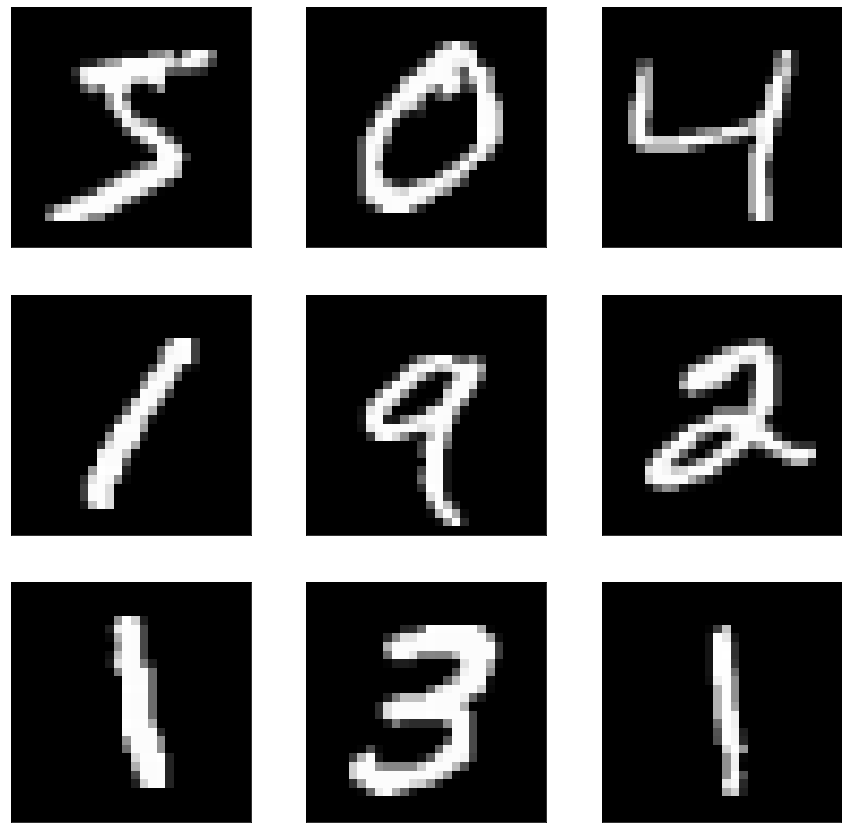

In [3]:
f, axs = plt.subplots(3,3, figsize=(15,15))
ix=0
for i in range(3):
    for j in range(3):
        axs[i,j].imshow(x_train[ix].reshape(28,28), cmap='gray')
        axs[i,j].xaxis.set_visible(False)
        axs[i,j].yaxis.set_visible(False)
        ix+=1
plt.show()

# MLP with two hidden layers

In [4]:
#hyperparameters for the network
n_epochs = 30000
n_hidden = 256
latent_dim = 100
batch_size = 32

In [5]:
#Defining the architecture

#Discriminator
x = Input(shape=(x_train.shape[1:]))
x_disc = Dense(n_hidden*2)(x)
x_disc = LeakyReLU(alpha=0.2)(x_disc)
x_disc = Dense(n_hidden)(x_disc)
x_disc = LeakyReLU(alpha=0.2)(x_disc)
y_hat = Dense(1, activation='sigmoid')(x_disc)


#Generator
z = Input(shape=(latent_dim,))
x_gen = Dense(n_hidden)(z)
x_gen = LeakyReLU(alpha=0.2)(x_gen)
x_gen = BatchNormalization(momentum=0.8)(x_gen)
x_gen = Dense(n_hidden*2)(x_gen)
x_gen = LeakyReLU(alpha=0.2)(x_gen)
x_gen = BatchNormalization(momentum=0.8)(x_gen)
x_gen = Dense(n_hidden*4)(x_gen)
x_gen = LeakyReLU(alpha=0.2)(x_gen)
x_gen = BatchNormalization(momentum=0.8)(x_gen)
x_hat = Dense(x_train.shape[1], activation='tanh')(x_gen)

W0811 22:06:20.359212 140640447854400 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [6]:
generator = Model(z, x_hat)
discriminator = Model(x, y_hat)

adam = keras.optimizers.Adam(0.0002, 0.5)

discriminator.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
discriminator.summary()


z = Input(shape=(latent_dim,))
fake_img = generator(z)
discriminator.trainable = False #For the generation, the discriminator is not trained
fake_pred = discriminator(fake_img)
combined = Model(z, fake_pred)
combined.compile(optimizer=adam, loss='binary_crossentropy')
generator.summary()

W0811 22:06:20.723319 140640447854400 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0811 22:06:20.733516 140640447854400 deprecation.py:323] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

In [7]:
def sample_images(model, epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    ix = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[ix].reshape(28,28), cmap='gray')
            axs[i,j].axis('off')
            ix += 1
    fig.savefig("images/{}_{}.png".format(model, epoch))
    plt.close()

In [8]:
true_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

gen_losses = []
disc_losses = []

for epoch in range(n_epochs):
    print('Epoch: {}'.format(epoch))
    #Select some real images from the dataset
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    imgs = x_train[idx]
    
    
    ###################################
    #          Discriminator          #
    ###################################
    #Sample from the random normal noise.
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    
    fake_imgs = generator.predict(noise)
    
    d_loss_real = discriminator.train_on_batch(imgs, true_labels)
    d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    ###################################
    #             Generator           #
    ###################################
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = combined.train_on_batch(noise, true_labels)
    
    
    print('Discriminator loss: {:.3f}, Generator loss: {:.3f}'.format(d_loss[0], g_loss))
    gen_losses.append(g_loss)
    disc_losses.append(d_loss[0])
    
    if epoch%100==0:
        sample_images('mlp', epoch)

Epoch: 0


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Discriminator loss: 0.580, Generator loss: 0.667
Epoch: 1
Discriminator loss: 0.403, Generator loss: 0.742
Epoch: 2
Discriminator loss: 0.336, Generator loss: 0.928
Epoch: 3
Discriminator loss: 0.252, Generator loss: 1.045
Epoch: 4
Discriminator loss: 0.230, Generator loss: 1.196
Epoch: 5
Discriminator loss: 0.194, Generator loss: 1.397
Epoch: 6
Discriminator loss: 0.172, Generator loss: 1.518
Epoch: 7
Discriminator loss: 0.133, Generator loss: 1.650
Epoch: 8
Discriminator loss: 0.121, Generator loss: 1.787
Epoch: 9
Discriminator loss: 0.117, Generator loss: 1.804
Epoch: 10
Discriminator loss: 0.098, Generator loss: 1.924
Epoch: 11
Discriminator loss: 0.091, Generator loss: 1.991
Epoch: 12
Discriminator loss: 0.088, Generator loss: 2.110
Epoch: 13


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Discriminator loss: 0.097, Generator loss: 2.322
Epoch: 14
Discriminator loss: 0.071, Generator loss: 2.351
Epoch: 15
Discriminator loss: 0.077, Generator loss: 2.359
Epoch: 16
Discriminator loss: 0.057, Generator loss: 2.581
Epoch: 17
Discriminator loss: 0.069, Generator loss: 2.548
Epoch: 18
Discriminator loss: 0.041, Generator loss: 2.627
Epoch: 19
Discriminator loss: 0.047, Generator loss: 2.681
Epoch: 20
Discriminator loss: 0.049, Generator loss: 2.703
Epoch: 21
Discriminator loss: 0.044, Generator loss: 2.832
Epoch: 22
Discriminator loss: 0.053, Generator loss: 2.723
Epoch: 23
Discriminator loss: 0.041, Generator loss: 2.924
Epoch: 24
Discriminator loss: 0.038, Generator loss: 2.984
Epoch: 25
Discriminator loss: 0.034, Generator loss: 2.959
Epoch: 26
Discriminator loss: 0.033, Generator loss: 3.048
Epoch: 27
Discriminator loss: 0.032, Generator loss: 3.078
Epoch: 28
Discriminator loss: 0.034, Generator loss: 3.186
Epoch: 29
Discriminator loss: 0.031, Generator loss: 3.376
Epoch: 

Discriminator loss: 0.302, Generator loss: 2.800
Epoch: 154
Discriminator loss: 0.148, Generator loss: 3.712
Epoch: 155
Discriminator loss: 0.283, Generator loss: 3.070
Epoch: 156
Discriminator loss: 0.101, Generator loss: 3.159
Epoch: 157
Discriminator loss: 0.120, Generator loss: 3.508
Epoch: 158
Discriminator loss: 0.221, Generator loss: 3.092
Epoch: 159
Discriminator loss: 0.117, Generator loss: 3.438
Epoch: 160
Discriminator loss: 0.296, Generator loss: 2.621
Epoch: 161
Discriminator loss: 0.155, Generator loss: 3.758
Epoch: 162
Discriminator loss: 0.199, Generator loss: 3.462
Epoch: 163
Discriminator loss: 0.127, Generator loss: 3.451
Epoch: 164
Discriminator loss: 0.073, Generator loss: 3.892
Epoch: 165
Discriminator loss: 0.085, Generator loss: 3.489
Epoch: 166
Discriminator loss: 0.121, Generator loss: 3.844
Epoch: 167
Discriminator loss: 0.099, Generator loss: 3.868
Epoch: 168
Discriminator loss: 0.230, Generator loss: 2.823
Epoch: 169
Discriminator loss: 0.094, Generator los

Discriminator loss: 0.689, Generator loss: 0.818
Epoch: 295
Discriminator loss: 0.750, Generator loss: 0.768
Epoch: 296
Discriminator loss: 0.671, Generator loss: 0.745
Epoch: 297
Discriminator loss: 0.646, Generator loss: 0.791
Epoch: 298
Discriminator loss: 0.696, Generator loss: 0.795
Epoch: 299
Discriminator loss: 0.655, Generator loss: 0.880
Epoch: 300
Discriminator loss: 0.679, Generator loss: 0.764
Epoch: 301
Discriminator loss: 0.686, Generator loss: 0.778
Epoch: 302
Discriminator loss: 0.702, Generator loss: 0.759
Epoch: 303
Discriminator loss: 0.686, Generator loss: 0.779
Epoch: 304
Discriminator loss: 0.704, Generator loss: 0.758
Epoch: 305
Discriminator loss: 0.682, Generator loss: 0.753
Epoch: 306
Discriminator loss: 0.684, Generator loss: 0.679
Epoch: 307
Discriminator loss: 0.735, Generator loss: 0.665
Epoch: 308
Discriminator loss: 0.653, Generator loss: 0.721
Epoch: 309
Discriminator loss: 0.674, Generator loss: 0.718
Epoch: 310
Discriminator loss: 0.682, Generator los

Discriminator loss: 0.624, Generator loss: 0.773
Epoch: 440
Discriminator loss: 0.627, Generator loss: 0.775
Epoch: 441
Discriminator loss: 0.628, Generator loss: 0.803
Epoch: 442
Discriminator loss: 0.659, Generator loss: 0.769
Epoch: 443
Discriminator loss: 0.648, Generator loss: 0.749
Epoch: 444
Discriminator loss: 0.632, Generator loss: 0.719
Epoch: 445
Discriminator loss: 0.616, Generator loss: 0.779
Epoch: 446
Discriminator loss: 0.639, Generator loss: 0.764
Epoch: 447
Discriminator loss: 0.684, Generator loss: 0.745
Epoch: 448
Discriminator loss: 0.655, Generator loss: 0.744
Epoch: 449
Discriminator loss: 0.665, Generator loss: 0.724
Epoch: 450
Discriminator loss: 0.646, Generator loss: 0.731
Epoch: 451
Discriminator loss: 0.632, Generator loss: 0.765
Epoch: 452
Discriminator loss: 0.650, Generator loss: 0.781
Epoch: 453
Discriminator loss: 0.624, Generator loss: 0.814
Epoch: 454
Discriminator loss: 0.651, Generator loss: 0.808
Epoch: 455
Discriminator loss: 0.651, Generator los

Discriminator loss: 0.610, Generator loss: 0.770
Epoch: 579
Discriminator loss: 0.632, Generator loss: 0.800
Epoch: 580
Discriminator loss: 0.651, Generator loss: 0.781
Epoch: 581
Discriminator loss: 0.670, Generator loss: 0.819
Epoch: 582
Discriminator loss: 0.615, Generator loss: 0.801
Epoch: 583
Discriminator loss: 0.676, Generator loss: 0.747
Epoch: 584
Discriminator loss: 0.668, Generator loss: 0.748
Epoch: 585
Discriminator loss: 0.684, Generator loss: 0.765
Epoch: 586
Discriminator loss: 0.652, Generator loss: 0.784
Epoch: 587
Discriminator loss: 0.640, Generator loss: 0.798
Epoch: 588
Discriminator loss: 0.618, Generator loss: 0.797
Epoch: 589
Discriminator loss: 0.627, Generator loss: 0.774
Epoch: 590
Discriminator loss: 0.654, Generator loss: 0.829
Epoch: 591
Discriminator loss: 0.668, Generator loss: 0.755
Epoch: 592
Discriminator loss: 0.668, Generator loss: 0.828
Epoch: 593
Discriminator loss: 0.660, Generator loss: 0.821
Epoch: 594
Discriminator loss: 0.656, Generator los

Discriminator loss: 0.607, Generator loss: 0.853
Epoch: 727
Discriminator loss: 0.624, Generator loss: 0.824
Epoch: 728
Discriminator loss: 0.609, Generator loss: 0.849
Epoch: 729
Discriminator loss: 0.598, Generator loss: 0.848
Epoch: 730
Discriminator loss: 0.620, Generator loss: 0.844
Epoch: 731
Discriminator loss: 0.603, Generator loss: 0.846
Epoch: 732
Discriminator loss: 0.611, Generator loss: 0.836
Epoch: 733
Discriminator loss: 0.607, Generator loss: 0.845
Epoch: 734
Discriminator loss: 0.634, Generator loss: 0.862
Epoch: 735
Discriminator loss: 0.605, Generator loss: 0.866
Epoch: 736
Discriminator loss: 0.687, Generator loss: 0.826
Epoch: 737
Discriminator loss: 0.632, Generator loss: 0.762
Epoch: 738
Discriminator loss: 0.599, Generator loss: 0.842
Epoch: 739
Discriminator loss: 0.634, Generator loss: 0.835
Epoch: 740
Discriminator loss: 0.635, Generator loss: 0.796
Epoch: 741
Discriminator loss: 0.639, Generator loss: 0.839
Epoch: 742
Discriminator loss: 0.584, Generator los

Discriminator loss: 0.604, Generator loss: 0.778
Epoch: 868
Discriminator loss: 0.652, Generator loss: 0.790
Epoch: 869
Discriminator loss: 0.573, Generator loss: 0.819
Epoch: 870
Discriminator loss: 0.608, Generator loss: 0.815
Epoch: 871
Discriminator loss: 0.613, Generator loss: 0.795
Epoch: 872
Discriminator loss: 0.613, Generator loss: 0.837
Epoch: 873
Discriminator loss: 0.644, Generator loss: 0.831
Epoch: 874
Discriminator loss: 0.623, Generator loss: 0.835
Epoch: 875
Discriminator loss: 0.601, Generator loss: 0.817
Epoch: 876
Discriminator loss: 0.632, Generator loss: 0.804
Epoch: 877
Discriminator loss: 0.619, Generator loss: 0.826
Epoch: 878
Discriminator loss: 0.641, Generator loss: 0.816
Epoch: 879
Discriminator loss: 0.684, Generator loss: 0.785
Epoch: 880
Discriminator loss: 0.660, Generator loss: 0.790
Epoch: 881
Discriminator loss: 0.629, Generator loss: 0.794
Epoch: 882
Discriminator loss: 0.614, Generator loss: 0.755
Epoch: 883
Discriminator loss: 0.602, Generator los

Discriminator loss: 0.582, Generator loss: 0.822
Epoch: 1014
Discriminator loss: 0.620, Generator loss: 0.876
Epoch: 1015
Discriminator loss: 0.572, Generator loss: 0.850
Epoch: 1016
Discriminator loss: 0.573, Generator loss: 0.847
Epoch: 1017
Discriminator loss: 0.642, Generator loss: 0.877
Epoch: 1018
Discriminator loss: 0.577, Generator loss: 0.837
Epoch: 1019
Discriminator loss: 0.631, Generator loss: 0.898
Epoch: 1020
Discriminator loss: 0.587, Generator loss: 0.909
Epoch: 1021
Discriminator loss: 0.600, Generator loss: 0.867
Epoch: 1022
Discriminator loss: 0.684, Generator loss: 0.876
Epoch: 1023
Discriminator loss: 0.619, Generator loss: 0.844
Epoch: 1024
Discriminator loss: 0.600, Generator loss: 0.848
Epoch: 1025
Discriminator loss: 0.616, Generator loss: 0.858
Epoch: 1026
Discriminator loss: 0.563, Generator loss: 0.918
Epoch: 1027
Discriminator loss: 0.612, Generator loss: 0.919
Epoch: 1028
Discriminator loss: 0.570, Generator loss: 0.898
Epoch: 1029
Discriminator loss: 0.59

Discriminator loss: 0.567, Generator loss: 0.880
Epoch: 1153
Discriminator loss: 0.581, Generator loss: 0.887
Epoch: 1154
Discriminator loss: 0.563, Generator loss: 0.901
Epoch: 1155
Discriminator loss: 0.608, Generator loss: 0.966
Epoch: 1156
Discriminator loss: 0.608, Generator loss: 0.893
Epoch: 1157
Discriminator loss: 0.589, Generator loss: 0.941
Epoch: 1158
Discriminator loss: 0.563, Generator loss: 1.013
Epoch: 1159
Discriminator loss: 0.575, Generator loss: 0.910
Epoch: 1160
Discriminator loss: 0.587, Generator loss: 0.866
Epoch: 1161
Discriminator loss: 0.576, Generator loss: 0.867
Epoch: 1162
Discriminator loss: 0.534, Generator loss: 0.883
Epoch: 1163
Discriminator loss: 0.561, Generator loss: 0.878
Epoch: 1164
Discriminator loss: 0.582, Generator loss: 0.938
Epoch: 1165
Discriminator loss: 0.559, Generator loss: 0.971
Epoch: 1166
Discriminator loss: 0.582, Generator loss: 0.860
Epoch: 1167
Discriminator loss: 0.628, Generator loss: 0.885
Epoch: 1168
Discriminator loss: 0.56

Discriminator loss: 0.620, Generator loss: 0.946
Epoch: 1293
Discriminator loss: 0.573, Generator loss: 0.986
Epoch: 1294
Discriminator loss: 0.607, Generator loss: 0.933
Epoch: 1295
Discriminator loss: 0.556, Generator loss: 0.997
Epoch: 1296
Discriminator loss: 0.569, Generator loss: 0.928
Epoch: 1297
Discriminator loss: 0.558, Generator loss: 0.943
Epoch: 1298
Discriminator loss: 0.520, Generator loss: 0.948
Epoch: 1299
Discriminator loss: 0.595, Generator loss: 0.925
Epoch: 1300
Discriminator loss: 0.555, Generator loss: 0.906
Epoch: 1301
Discriminator loss: 0.548, Generator loss: 0.920
Epoch: 1302
Discriminator loss: 0.546, Generator loss: 0.937
Epoch: 1303
Discriminator loss: 0.616, Generator loss: 0.899
Epoch: 1304
Discriminator loss: 0.548, Generator loss: 0.955
Epoch: 1305
Discriminator loss: 0.549, Generator loss: 0.966
Epoch: 1306
Discriminator loss: 0.619, Generator loss: 0.954
Epoch: 1307
Discriminator loss: 0.580, Generator loss: 0.957
Epoch: 1308
Discriminator loss: 0.59

Discriminator loss: 0.570, Generator loss: 0.977
Epoch: 1440
Discriminator loss: 0.531, Generator loss: 1.023
Epoch: 1441
Discriminator loss: 0.537, Generator loss: 0.962
Epoch: 1442
Discriminator loss: 0.625, Generator loss: 0.937
Epoch: 1443
Discriminator loss: 0.578, Generator loss: 0.950
Epoch: 1444
Discriminator loss: 0.539, Generator loss: 0.953
Epoch: 1445
Discriminator loss: 0.509, Generator loss: 0.917
Epoch: 1446
Discriminator loss: 0.558, Generator loss: 1.012
Epoch: 1447
Discriminator loss: 0.600, Generator loss: 0.938
Epoch: 1448
Discriminator loss: 0.584, Generator loss: 0.962
Epoch: 1449
Discriminator loss: 0.574, Generator loss: 1.054
Epoch: 1450
Discriminator loss: 0.580, Generator loss: 0.972
Epoch: 1451
Discriminator loss: 0.606, Generator loss: 0.966
Epoch: 1452
Discriminator loss: 0.589, Generator loss: 0.972
Epoch: 1453
Discriminator loss: 0.612, Generator loss: 0.898
Epoch: 1454
Discriminator loss: 0.567, Generator loss: 0.829
Epoch: 1455
Discriminator loss: 0.56

Discriminator loss: 0.562, Generator loss: 0.936
Epoch: 1580
Discriminator loss: 0.547, Generator loss: 0.932
Epoch: 1581
Discriminator loss: 0.637, Generator loss: 0.931
Epoch: 1582
Discriminator loss: 0.515, Generator loss: 1.029
Epoch: 1583
Discriminator loss: 0.538, Generator loss: 1.032
Epoch: 1584
Discriminator loss: 0.639, Generator loss: 0.960
Epoch: 1585
Discriminator loss: 0.631, Generator loss: 1.014
Epoch: 1586
Discriminator loss: 0.627, Generator loss: 0.999
Epoch: 1587
Discriminator loss: 0.592, Generator loss: 1.022
Epoch: 1588
Discriminator loss: 0.587, Generator loss: 0.951
Epoch: 1589
Discriminator loss: 0.485, Generator loss: 1.094
Epoch: 1590
Discriminator loss: 0.553, Generator loss: 0.947
Epoch: 1591
Discriminator loss: 0.570, Generator loss: 1.077
Epoch: 1592
Discriminator loss: 0.542, Generator loss: 0.990
Epoch: 1593
Discriminator loss: 0.577, Generator loss: 0.964
Epoch: 1594
Discriminator loss: 0.603, Generator loss: 1.029
Epoch: 1595
Discriminator loss: 0.63

Discriminator loss: 0.559, Generator loss: 0.929
Epoch: 1715
Discriminator loss: 0.556, Generator loss: 0.954
Epoch: 1716
Discriminator loss: 0.647, Generator loss: 0.943
Epoch: 1717
Discriminator loss: 0.566, Generator loss: 0.975
Epoch: 1718
Discriminator loss: 0.586, Generator loss: 0.975
Epoch: 1719
Discriminator loss: 0.528, Generator loss: 0.971
Epoch: 1720
Discriminator loss: 0.567, Generator loss: 0.992
Epoch: 1721
Discriminator loss: 0.571, Generator loss: 1.081
Epoch: 1722
Discriminator loss: 0.574, Generator loss: 0.977
Epoch: 1723
Discriminator loss: 0.612, Generator loss: 0.907
Epoch: 1724
Discriminator loss: 0.631, Generator loss: 0.958
Epoch: 1725
Discriminator loss: 0.520, Generator loss: 0.954
Epoch: 1726
Discriminator loss: 0.551, Generator loss: 0.990
Epoch: 1727
Discriminator loss: 0.571, Generator loss: 0.987
Epoch: 1728
Discriminator loss: 0.648, Generator loss: 0.999
Epoch: 1729
Discriminator loss: 0.592, Generator loss: 0.926
Epoch: 1730
Discriminator loss: 0.54

Discriminator loss: 0.635, Generator loss: 0.976
Epoch: 1853
Discriminator loss: 0.544, Generator loss: 1.036
Epoch: 1854
Discriminator loss: 0.544, Generator loss: 1.027
Epoch: 1855
Discriminator loss: 0.594, Generator loss: 1.060
Epoch: 1856
Discriminator loss: 0.594, Generator loss: 1.055
Epoch: 1857
Discriminator loss: 0.541, Generator loss: 1.007
Epoch: 1858
Discriminator loss: 0.504, Generator loss: 1.048
Epoch: 1859
Discriminator loss: 0.569, Generator loss: 1.018
Epoch: 1860
Discriminator loss: 0.602, Generator loss: 0.982
Epoch: 1861
Discriminator loss: 0.618, Generator loss: 0.966
Epoch: 1862
Discriminator loss: 0.564, Generator loss: 1.034
Epoch: 1863
Discriminator loss: 0.576, Generator loss: 0.951
Epoch: 1864
Discriminator loss: 0.621, Generator loss: 0.997
Epoch: 1865
Discriminator loss: 0.577, Generator loss: 0.924
Epoch: 1866
Discriminator loss: 0.548, Generator loss: 0.981
Epoch: 1867
Discriminator loss: 0.597, Generator loss: 0.995
Epoch: 1868
Discriminator loss: 0.57

Discriminator loss: 0.554, Generator loss: 1.040
Epoch: 1993
Discriminator loss: 0.600, Generator loss: 1.002
Epoch: 1994
Discriminator loss: 0.560, Generator loss: 1.042
Epoch: 1995
Discriminator loss: 0.553, Generator loss: 1.024
Epoch: 1996
Discriminator loss: 0.564, Generator loss: 0.945
Epoch: 1997
Discriminator loss: 0.577, Generator loss: 0.970
Epoch: 1998
Discriminator loss: 0.583, Generator loss: 1.047
Epoch: 1999
Discriminator loss: 0.674, Generator loss: 0.870
Epoch: 2000
Discriminator loss: 0.581, Generator loss: 0.883
Epoch: 2001
Discriminator loss: 0.578, Generator loss: 0.951
Epoch: 2002
Discriminator loss: 0.559, Generator loss: 1.081
Epoch: 2003
Discriminator loss: 0.617, Generator loss: 1.012
Epoch: 2004
Discriminator loss: 0.650, Generator loss: 0.944
Epoch: 2005
Discriminator loss: 0.574, Generator loss: 1.029
Epoch: 2006
Discriminator loss: 0.557, Generator loss: 1.031
Epoch: 2007
Discriminator loss: 0.577, Generator loss: 0.986
Epoch: 2008
Discriminator loss: 0.57

Discriminator loss: 0.530, Generator loss: 0.977
Epoch: 2141
Discriminator loss: 0.632, Generator loss: 0.951
Epoch: 2142
Discriminator loss: 0.579, Generator loss: 0.977
Epoch: 2143
Discriminator loss: 0.559, Generator loss: 0.977
Epoch: 2144
Discriminator loss: 0.630, Generator loss: 0.972
Epoch: 2145
Discriminator loss: 0.551, Generator loss: 0.950
Epoch: 2146
Discriminator loss: 0.510, Generator loss: 1.001
Epoch: 2147
Discriminator loss: 0.542, Generator loss: 0.954
Epoch: 2148
Discriminator loss: 0.470, Generator loss: 1.081
Epoch: 2149
Discriminator loss: 0.573, Generator loss: 0.991
Epoch: 2150
Discriminator loss: 0.553, Generator loss: 1.044
Epoch: 2151
Discriminator loss: 0.592, Generator loss: 1.053
Epoch: 2152
Discriminator loss: 0.592, Generator loss: 1.006
Epoch: 2153
Discriminator loss: 0.532, Generator loss: 1.023
Epoch: 2154
Discriminator loss: 0.580, Generator loss: 1.117
Epoch: 2155
Discriminator loss: 0.524, Generator loss: 1.010
Epoch: 2156
Discriminator loss: 0.58

Discriminator loss: 0.582, Generator loss: 0.982
Epoch: 2277
Discriminator loss: 0.583, Generator loss: 0.966
Epoch: 2278
Discriminator loss: 0.580, Generator loss: 1.034
Epoch: 2279
Discriminator loss: 0.574, Generator loss: 0.969
Epoch: 2280
Discriminator loss: 0.594, Generator loss: 0.955
Epoch: 2281
Discriminator loss: 0.543, Generator loss: 0.941
Epoch: 2282
Discriminator loss: 0.521, Generator loss: 1.080
Epoch: 2283
Discriminator loss: 0.692, Generator loss: 0.923
Epoch: 2284
Discriminator loss: 0.622, Generator loss: 0.948
Epoch: 2285
Discriminator loss: 0.581, Generator loss: 0.871
Epoch: 2286
Discriminator loss: 0.564, Generator loss: 1.070
Epoch: 2287
Discriminator loss: 0.556, Generator loss: 0.947
Epoch: 2288
Discriminator loss: 0.693, Generator loss: 1.002
Epoch: 2289
Discriminator loss: 0.625, Generator loss: 1.042
Epoch: 2290
Discriminator loss: 0.571, Generator loss: 1.034
Epoch: 2291
Discriminator loss: 0.571, Generator loss: 0.966
Epoch: 2292
Discriminator loss: 0.59

Discriminator loss: 0.609, Generator loss: 0.998
Epoch: 2414
Discriminator loss: 0.534, Generator loss: 1.037
Epoch: 2415
Discriminator loss: 0.601, Generator loss: 1.031
Epoch: 2416
Discriminator loss: 0.552, Generator loss: 1.001
Epoch: 2417
Discriminator loss: 0.573, Generator loss: 0.987
Epoch: 2418
Discriminator loss: 0.641, Generator loss: 0.941
Epoch: 2419
Discriminator loss: 0.582, Generator loss: 1.001
Epoch: 2420
Discriminator loss: 0.607, Generator loss: 1.023
Epoch: 2421
Discriminator loss: 0.582, Generator loss: 0.991
Epoch: 2422
Discriminator loss: 0.661, Generator loss: 0.959
Epoch: 2423
Discriminator loss: 0.565, Generator loss: 0.982
Epoch: 2424
Discriminator loss: 0.654, Generator loss: 0.935
Epoch: 2425
Discriminator loss: 0.629, Generator loss: 0.980
Epoch: 2426
Discriminator loss: 0.597, Generator loss: 0.957
Epoch: 2427
Discriminator loss: 0.569, Generator loss: 1.007
Epoch: 2428
Discriminator loss: 0.608, Generator loss: 0.973
Epoch: 2429
Discriminator loss: 0.62

Discriminator loss: 0.567, Generator loss: 1.016
Epoch: 2553
Discriminator loss: 0.587, Generator loss: 0.986
Epoch: 2554
Discriminator loss: 0.538, Generator loss: 0.979
Epoch: 2555
Discriminator loss: 0.627, Generator loss: 0.919
Epoch: 2556
Discriminator loss: 0.592, Generator loss: 0.934
Epoch: 2557
Discriminator loss: 0.605, Generator loss: 0.897
Epoch: 2558
Discriminator loss: 0.574, Generator loss: 0.910
Epoch: 2559
Discriminator loss: 0.603, Generator loss: 1.028
Epoch: 2560
Discriminator loss: 0.610, Generator loss: 0.974
Epoch: 2561
Discriminator loss: 0.574, Generator loss: 0.977
Epoch: 2562
Discriminator loss: 0.622, Generator loss: 1.008
Epoch: 2563
Discriminator loss: 0.611, Generator loss: 0.952
Epoch: 2564
Discriminator loss: 0.601, Generator loss: 0.972
Epoch: 2565
Discriminator loss: 0.588, Generator loss: 0.909
Epoch: 2566
Discriminator loss: 0.612, Generator loss: 0.836
Epoch: 2567
Discriminator loss: 0.538, Generator loss: 0.942
Epoch: 2568
Discriminator loss: 0.64

Discriminator loss: 0.636, Generator loss: 1.002
Epoch: 2694
Discriminator loss: 0.616, Generator loss: 0.991
Epoch: 2695
Discriminator loss: 0.540, Generator loss: 0.977
Epoch: 2696
Discriminator loss: 0.685, Generator loss: 1.039
Epoch: 2697
Discriminator loss: 0.576, Generator loss: 1.112
Epoch: 2698
Discriminator loss: 0.643, Generator loss: 0.861
Epoch: 2699
Discriminator loss: 0.561, Generator loss: 0.954
Epoch: 2700
Discriminator loss: 0.667, Generator loss: 0.914
Epoch: 2701
Discriminator loss: 0.625, Generator loss: 0.979
Epoch: 2702
Discriminator loss: 0.618, Generator loss: 1.022
Epoch: 2703
Discriminator loss: 0.533, Generator loss: 0.940
Epoch: 2704
Discriminator loss: 0.601, Generator loss: 0.903
Epoch: 2705
Discriminator loss: 0.595, Generator loss: 1.033
Epoch: 2706
Discriminator loss: 0.608, Generator loss: 0.933
Epoch: 2707
Discriminator loss: 0.563, Generator loss: 0.904
Epoch: 2708
Discriminator loss: 0.608, Generator loss: 0.918
Epoch: 2709
Discriminator loss: 0.59

Discriminator loss: 0.583, Generator loss: 1.057
Epoch: 2841
Discriminator loss: 0.599, Generator loss: 0.998
Epoch: 2842
Discriminator loss: 0.555, Generator loss: 1.054
Epoch: 2843
Discriminator loss: 0.676, Generator loss: 0.950
Epoch: 2844
Discriminator loss: 0.573, Generator loss: 0.987
Epoch: 2845
Discriminator loss: 0.599, Generator loss: 0.981
Epoch: 2846
Discriminator loss: 0.610, Generator loss: 0.919
Epoch: 2847
Discriminator loss: 0.630, Generator loss: 0.968
Epoch: 2848
Discriminator loss: 0.633, Generator loss: 0.888
Epoch: 2849
Discriminator loss: 0.606, Generator loss: 0.951
Epoch: 2850
Discriminator loss: 0.610, Generator loss: 1.031
Epoch: 2851
Discriminator loss: 0.563, Generator loss: 1.093
Epoch: 2852
Discriminator loss: 0.573, Generator loss: 0.981
Epoch: 2853
Discriminator loss: 0.604, Generator loss: 0.953
Epoch: 2854
Discriminator loss: 0.565, Generator loss: 0.951
Epoch: 2855
Discriminator loss: 0.621, Generator loss: 0.967
Epoch: 2856
Discriminator loss: 0.59

Discriminator loss: 0.636, Generator loss: 1.015
Epoch: 2978
Discriminator loss: 0.641, Generator loss: 0.989
Epoch: 2979
Discriminator loss: 0.568, Generator loss: 1.167
Epoch: 2980
Discriminator loss: 0.577, Generator loss: 1.076
Epoch: 2981
Discriminator loss: 0.670, Generator loss: 0.957
Epoch: 2982
Discriminator loss: 0.584, Generator loss: 1.059
Epoch: 2983
Discriminator loss: 0.559, Generator loss: 1.028
Epoch: 2984
Discriminator loss: 0.670, Generator loss: 0.938
Epoch: 2985
Discriminator loss: 0.552, Generator loss: 1.023
Epoch: 2986
Discriminator loss: 0.571, Generator loss: 1.121
Epoch: 2987
Discriminator loss: 0.608, Generator loss: 1.010
Epoch: 2988
Discriminator loss: 0.625, Generator loss: 0.996
Epoch: 2989
Discriminator loss: 0.613, Generator loss: 0.958
Epoch: 2990
Discriminator loss: 0.666, Generator loss: 0.984
Epoch: 2991
Discriminator loss: 0.587, Generator loss: 0.993
Epoch: 2992
Discriminator loss: 0.584, Generator loss: 0.989
Epoch: 2993
Discriminator loss: 0.56

Discriminator loss: 0.579, Generator loss: 1.013
Epoch: 3114
Discriminator loss: 0.586, Generator loss: 1.024
Epoch: 3115
Discriminator loss: 0.587, Generator loss: 1.045
Epoch: 3116
Discriminator loss: 0.589, Generator loss: 1.009
Epoch: 3117
Discriminator loss: 0.642, Generator loss: 1.052
Epoch: 3118
Discriminator loss: 0.583, Generator loss: 1.068
Epoch: 3119
Discriminator loss: 0.670, Generator loss: 1.068
Epoch: 3120
Discriminator loss: 0.609, Generator loss: 1.020
Epoch: 3121
Discriminator loss: 0.576, Generator loss: 1.061
Epoch: 3122
Discriminator loss: 0.615, Generator loss: 0.891
Epoch: 3123
Discriminator loss: 0.567, Generator loss: 0.986
Epoch: 3124
Discriminator loss: 0.577, Generator loss: 1.009
Epoch: 3125
Discriminator loss: 0.590, Generator loss: 1.005
Epoch: 3126
Discriminator loss: 0.606, Generator loss: 0.962
Epoch: 3127
Discriminator loss: 0.582, Generator loss: 0.950
Epoch: 3128
Discriminator loss: 0.571, Generator loss: 1.068
Epoch: 3129
Discriminator loss: 0.59

Discriminator loss: 0.640, Generator loss: 0.958
Epoch: 3253
Discriminator loss: 0.578, Generator loss: 1.005
Epoch: 3254
Discriminator loss: 0.612, Generator loss: 0.946
Epoch: 3255
Discriminator loss: 0.557, Generator loss: 1.056
Epoch: 3256
Discriminator loss: 0.598, Generator loss: 1.055
Epoch: 3257
Discriminator loss: 0.546, Generator loss: 1.126
Epoch: 3258
Discriminator loss: 0.641, Generator loss: 0.951
Epoch: 3259
Discriminator loss: 0.641, Generator loss: 1.057
Epoch: 3260
Discriminator loss: 0.653, Generator loss: 1.023
Epoch: 3261
Discriminator loss: 0.589, Generator loss: 0.945
Epoch: 3262
Discriminator loss: 0.555, Generator loss: 0.884
Epoch: 3263
Discriminator loss: 0.570, Generator loss: 0.983
Epoch: 3264
Discriminator loss: 0.621, Generator loss: 0.968
Epoch: 3265
Discriminator loss: 0.629, Generator loss: 0.958
Epoch: 3266
Discriminator loss: 0.572, Generator loss: 1.065
Epoch: 3267
Discriminator loss: 0.648, Generator loss: 0.983
Epoch: 3268
Discriminator loss: 0.62

Discriminator loss: 0.580, Generator loss: 0.983
Epoch: 3393
Discriminator loss: 0.618, Generator loss: 0.921
Epoch: 3394
Discriminator loss: 0.617, Generator loss: 0.980
Epoch: 3395
Discriminator loss: 0.572, Generator loss: 1.070
Epoch: 3396
Discriminator loss: 0.636, Generator loss: 1.054
Epoch: 3397
Discriminator loss: 0.603, Generator loss: 0.961
Epoch: 3398
Discriminator loss: 0.585, Generator loss: 1.035
Epoch: 3399
Discriminator loss: 0.595, Generator loss: 0.987
Epoch: 3400
Discriminator loss: 0.530, Generator loss: 0.950
Epoch: 3401
Discriminator loss: 0.621, Generator loss: 0.952
Epoch: 3402
Discriminator loss: 0.666, Generator loss: 1.032
Epoch: 3403
Discriminator loss: 0.562, Generator loss: 1.012
Epoch: 3404
Discriminator loss: 0.552, Generator loss: 1.019
Epoch: 3405
Discriminator loss: 0.616, Generator loss: 1.046
Epoch: 3406
Discriminator loss: 0.639, Generator loss: 0.933
Epoch: 3407
Discriminator loss: 0.615, Generator loss: 0.932
Epoch: 3408
Discriminator loss: 0.51

Discriminator loss: 0.585, Generator loss: 1.077
Epoch: 3540
Discriminator loss: 0.583, Generator loss: 1.059
Epoch: 3541
Discriminator loss: 0.623, Generator loss: 1.003
Epoch: 3542
Discriminator loss: 0.576, Generator loss: 1.009
Epoch: 3543
Discriminator loss: 0.635, Generator loss: 1.000
Epoch: 3544
Discriminator loss: 0.580, Generator loss: 0.995
Epoch: 3545
Discriminator loss: 0.625, Generator loss: 0.955
Epoch: 3546
Discriminator loss: 0.606, Generator loss: 0.978
Epoch: 3547
Discriminator loss: 0.567, Generator loss: 1.082
Epoch: 3548
Discriminator loss: 0.622, Generator loss: 0.916
Epoch: 3549
Discriminator loss: 0.570, Generator loss: 0.933
Epoch: 3550
Discriminator loss: 0.648, Generator loss: 1.038
Epoch: 3551
Discriminator loss: 0.596, Generator loss: 1.026
Epoch: 3552
Discriminator loss: 0.624, Generator loss: 0.972
Epoch: 3553
Discriminator loss: 0.581, Generator loss: 1.121
Epoch: 3554
Discriminator loss: 0.543, Generator loss: 1.071
Epoch: 3555
Discriminator loss: 0.60

Discriminator loss: 0.558, Generator loss: 0.958
Epoch: 3680
Discriminator loss: 0.607, Generator loss: 1.050
Epoch: 3681
Discriminator loss: 0.592, Generator loss: 1.044
Epoch: 3682
Discriminator loss: 0.594, Generator loss: 1.008
Epoch: 3683
Discriminator loss: 0.658, Generator loss: 0.973
Epoch: 3684
Discriminator loss: 0.593, Generator loss: 1.087
Epoch: 3685
Discriminator loss: 0.611, Generator loss: 0.992
Epoch: 3686
Discriminator loss: 0.638, Generator loss: 1.049
Epoch: 3687
Discriminator loss: 0.610, Generator loss: 0.992
Epoch: 3688
Discriminator loss: 0.643, Generator loss: 0.933
Epoch: 3689
Discriminator loss: 0.578, Generator loss: 1.033
Epoch: 3690
Discriminator loss: 0.570, Generator loss: 0.999
Epoch: 3691
Discriminator loss: 0.612, Generator loss: 0.993
Epoch: 3692
Discriminator loss: 0.642, Generator loss: 1.012
Epoch: 3693
Discriminator loss: 0.663, Generator loss: 0.952
Epoch: 3694
Discriminator loss: 0.564, Generator loss: 1.056
Epoch: 3695
Discriminator loss: 0.61

Discriminator loss: 0.561, Generator loss: 1.055
Epoch: 3827
Discriminator loss: 0.624, Generator loss: 1.001
Epoch: 3828
Discriminator loss: 0.563, Generator loss: 0.924
Epoch: 3829
Discriminator loss: 0.631, Generator loss: 0.878
Epoch: 3830
Discriminator loss: 0.618, Generator loss: 1.002
Epoch: 3831
Discriminator loss: 0.563, Generator loss: 1.071
Epoch: 3832
Discriminator loss: 0.647, Generator loss: 0.987
Epoch: 3833
Discriminator loss: 0.662, Generator loss: 0.997
Epoch: 3834
Discriminator loss: 0.588, Generator loss: 1.004
Epoch: 3835
Discriminator loss: 0.550, Generator loss: 1.001
Epoch: 3836
Discriminator loss: 0.581, Generator loss: 0.992
Epoch: 3837
Discriminator loss: 0.697, Generator loss: 0.995
Epoch: 3838
Discriminator loss: 0.633, Generator loss: 1.030
Epoch: 3839
Discriminator loss: 0.633, Generator loss: 0.942
Epoch: 3840
Discriminator loss: 0.614, Generator loss: 0.919
Epoch: 3841
Discriminator loss: 0.513, Generator loss: 1.016
Epoch: 3842
Discriminator loss: 0.60

Discriminator loss: 0.554, Generator loss: 1.027
Epoch: 3967
Discriminator loss: 0.583, Generator loss: 0.983
Epoch: 3968
Discriminator loss: 0.561, Generator loss: 0.996
Epoch: 3969
Discriminator loss: 0.649, Generator loss: 0.978
Epoch: 3970
Discriminator loss: 0.502, Generator loss: 1.110
Epoch: 3971
Discriminator loss: 0.726, Generator loss: 1.043
Epoch: 3972
Discriminator loss: 0.599, Generator loss: 0.975
Epoch: 3973
Discriminator loss: 0.539, Generator loss: 0.989
Epoch: 3974
Discriminator loss: 0.599, Generator loss: 0.976
Epoch: 3975
Discriminator loss: 0.614, Generator loss: 0.921
Epoch: 3976
Discriminator loss: 0.563, Generator loss: 0.912
Epoch: 3977
Discriminator loss: 0.592, Generator loss: 0.953
Epoch: 3978
Discriminator loss: 0.568, Generator loss: 1.010
Epoch: 3979
Discriminator loss: 0.640, Generator loss: 1.014
Epoch: 3980
Discriminator loss: 0.611, Generator loss: 1.067
Epoch: 3981
Discriminator loss: 0.669, Generator loss: 0.968
Epoch: 3982
Discriminator loss: 0.63

Epoch: 4101
Discriminator loss: 0.567, Generator loss: 0.979
Epoch: 4102
Discriminator loss: 0.560, Generator loss: 0.914
Epoch: 4103
Discriminator loss: 0.561, Generator loss: 0.986
Epoch: 4104
Discriminator loss: 0.630, Generator loss: 0.895
Epoch: 4105
Discriminator loss: 0.554, Generator loss: 0.990
Epoch: 4106
Discriminator loss: 0.655, Generator loss: 1.010
Epoch: 4107
Discriminator loss: 0.566, Generator loss: 1.023
Epoch: 4108
Discriminator loss: 0.539, Generator loss: 1.024
Epoch: 4109
Discriminator loss: 0.644, Generator loss: 0.984
Epoch: 4110
Discriminator loss: 0.689, Generator loss: 0.971
Epoch: 4111
Discriminator loss: 0.661, Generator loss: 0.957
Epoch: 4112
Discriminator loss: 0.505, Generator loss: 1.058
Epoch: 4113
Discriminator loss: 0.535, Generator loss: 1.007
Epoch: 4114
Discriminator loss: 0.530, Generator loss: 0.978
Epoch: 4115
Discriminator loss: 0.582, Generator loss: 1.056
Epoch: 4116
Discriminator loss: 0.628, Generator loss: 0.935
Epoch: 4117
Discriminato

Discriminator loss: 0.602, Generator loss: 0.997
Epoch: 4240
Discriminator loss: 0.558, Generator loss: 1.000
Epoch: 4241
Discriminator loss: 0.574, Generator loss: 1.003
Epoch: 4242
Discriminator loss: 0.614, Generator loss: 1.029
Epoch: 4243
Discriminator loss: 0.625, Generator loss: 1.049
Epoch: 4244
Discriminator loss: 0.541, Generator loss: 0.987
Epoch: 4245
Discriminator loss: 0.563, Generator loss: 0.948
Epoch: 4246
Discriminator loss: 0.590, Generator loss: 0.956
Epoch: 4247
Discriminator loss: 0.603, Generator loss: 1.063
Epoch: 4248
Discriminator loss: 0.635, Generator loss: 1.122
Epoch: 4249
Discriminator loss: 0.587, Generator loss: 1.009
Epoch: 4250
Discriminator loss: 0.624, Generator loss: 0.930
Epoch: 4251
Discriminator loss: 0.574, Generator loss: 1.045
Epoch: 4252
Discriminator loss: 0.657, Generator loss: 0.980
Epoch: 4253
Discriminator loss: 0.531, Generator loss: 0.915
Epoch: 4254
Discriminator loss: 0.550, Generator loss: 0.915
Epoch: 4255
Discriminator loss: 0.55

Discriminator loss: 0.614, Generator loss: 1.020
Epoch: 4379
Discriminator loss: 0.553, Generator loss: 1.012
Epoch: 4380
Discriminator loss: 0.599, Generator loss: 0.954
Epoch: 4381
Discriminator loss: 0.602, Generator loss: 0.928
Epoch: 4382
Discriminator loss: 0.596, Generator loss: 1.015
Epoch: 4383
Discriminator loss: 0.573, Generator loss: 1.017
Epoch: 4384
Discriminator loss: 0.601, Generator loss: 0.984
Epoch: 4385
Discriminator loss: 0.664, Generator loss: 1.116
Epoch: 4386
Discriminator loss: 0.634, Generator loss: 1.002
Epoch: 4387
Discriminator loss: 0.526, Generator loss: 1.059
Epoch: 4388
Discriminator loss: 0.642, Generator loss: 1.077
Epoch: 4389
Discriminator loss: 0.623, Generator loss: 0.958
Epoch: 4390
Discriminator loss: 0.720, Generator loss: 1.031
Epoch: 4391
Discriminator loss: 0.630, Generator loss: 1.018
Epoch: 4392
Discriminator loss: 0.555, Generator loss: 1.080
Epoch: 4393
Discriminator loss: 0.616, Generator loss: 0.998
Epoch: 4394
Discriminator loss: 0.65

Discriminator loss: 0.549, Generator loss: 1.102
Epoch: 4514
Discriminator loss: 0.642, Generator loss: 0.989
Epoch: 4515
Discriminator loss: 0.713, Generator loss: 1.023
Epoch: 4516
Discriminator loss: 0.530, Generator loss: 0.984
Epoch: 4517
Discriminator loss: 0.637, Generator loss: 1.005
Epoch: 4518
Discriminator loss: 0.562, Generator loss: 0.922
Epoch: 4519
Discriminator loss: 0.553, Generator loss: 0.922
Epoch: 4520
Discriminator loss: 0.623, Generator loss: 0.925
Epoch: 4521
Discriminator loss: 0.599, Generator loss: 1.046
Epoch: 4522
Discriminator loss: 0.606, Generator loss: 0.921
Epoch: 4523
Discriminator loss: 0.645, Generator loss: 0.931
Epoch: 4524
Discriminator loss: 0.593, Generator loss: 0.985
Epoch: 4525
Discriminator loss: 0.579, Generator loss: 1.098
Epoch: 4526
Discriminator loss: 0.553, Generator loss: 1.152
Epoch: 4527
Discriminator loss: 0.625, Generator loss: 1.056
Epoch: 4528
Discriminator loss: 0.584, Generator loss: 0.931
Epoch: 4529
Discriminator loss: 0.59

Discriminator loss: 0.578, Generator loss: 1.013
Epoch: 4653
Discriminator loss: 0.635, Generator loss: 1.048
Epoch: 4654
Discriminator loss: 0.611, Generator loss: 1.103
Epoch: 4655
Discriminator loss: 0.594, Generator loss: 1.075
Epoch: 4656
Discriminator loss: 0.637, Generator loss: 1.085
Epoch: 4657
Discriminator loss: 0.619, Generator loss: 1.088
Epoch: 4658
Discriminator loss: 0.610, Generator loss: 0.937
Epoch: 4659
Discriminator loss: 0.640, Generator loss: 0.901
Epoch: 4660
Discriminator loss: 0.584, Generator loss: 0.993
Epoch: 4661
Discriminator loss: 0.645, Generator loss: 0.968
Epoch: 4662
Discriminator loss: 0.583, Generator loss: 0.888
Epoch: 4663
Discriminator loss: 0.650, Generator loss: 0.936
Epoch: 4664
Discriminator loss: 0.692, Generator loss: 1.023
Epoch: 4665
Discriminator loss: 0.584, Generator loss: 1.000
Epoch: 4666
Discriminator loss: 0.580, Generator loss: 1.101
Epoch: 4667
Discriminator loss: 0.669, Generator loss: 1.030
Epoch: 4668
Discriminator loss: 0.59

Discriminator loss: 0.668, Generator loss: 1.026
Epoch: 4794
Discriminator loss: 0.616, Generator loss: 0.990
Epoch: 4795
Discriminator loss: 0.618, Generator loss: 1.031
Epoch: 4796
Discriminator loss: 0.527, Generator loss: 1.085
Epoch: 4797
Discriminator loss: 0.577, Generator loss: 1.024
Epoch: 4798
Discriminator loss: 0.645, Generator loss: 1.074
Epoch: 4799
Discriminator loss: 0.592, Generator loss: 0.859
Epoch: 4800
Discriminator loss: 0.580, Generator loss: 0.914
Epoch: 4801
Discriminator loss: 0.565, Generator loss: 1.026
Epoch: 4802
Discriminator loss: 0.575, Generator loss: 1.031
Epoch: 4803
Discriminator loss: 0.601, Generator loss: 0.995
Epoch: 4804
Discriminator loss: 0.645, Generator loss: 1.034
Epoch: 4805
Discriminator loss: 0.600, Generator loss: 0.989
Epoch: 4806
Discriminator loss: 0.658, Generator loss: 1.010
Epoch: 4807
Discriminator loss: 0.713, Generator loss: 0.998
Epoch: 4808
Discriminator loss: 0.642, Generator loss: 0.990
Epoch: 4809
Discriminator loss: 0.60

Discriminator loss: 0.636, Generator loss: 0.950
Epoch: 4941
Discriminator loss: 0.538, Generator loss: 1.065
Epoch: 4942
Discriminator loss: 0.625, Generator loss: 1.041
Epoch: 4943
Discriminator loss: 0.562, Generator loss: 1.024
Epoch: 4944
Discriminator loss: 0.638, Generator loss: 0.990
Epoch: 4945
Discriminator loss: 0.623, Generator loss: 0.984
Epoch: 4946
Discriminator loss: 0.615, Generator loss: 0.997
Epoch: 4947
Discriminator loss: 0.683, Generator loss: 1.021
Epoch: 4948
Discriminator loss: 0.578, Generator loss: 1.036
Epoch: 4949
Discriminator loss: 0.635, Generator loss: 1.160
Epoch: 4950
Discriminator loss: 0.558, Generator loss: 1.015
Epoch: 4951
Discriminator loss: 0.536, Generator loss: 1.105
Epoch: 4952
Discriminator loss: 0.636, Generator loss: 0.875
Epoch: 4953
Discriminator loss: 0.504, Generator loss: 1.126
Epoch: 4954
Discriminator loss: 0.615, Generator loss: 1.087
Epoch: 4955
Discriminator loss: 0.598, Generator loss: 0.977
Epoch: 4956
Discriminator loss: 0.60

Discriminator loss: 0.603, Generator loss: 0.881
Epoch: 5080
Discriminator loss: 0.649, Generator loss: 0.976
Epoch: 5081
Discriminator loss: 0.665, Generator loss: 0.998
Epoch: 5082
Discriminator loss: 0.552, Generator loss: 1.062
Epoch: 5083
Discriminator loss: 0.603, Generator loss: 0.968
Epoch: 5084
Discriminator loss: 0.743, Generator loss: 0.920
Epoch: 5085
Discriminator loss: 0.574, Generator loss: 0.926
Epoch: 5086
Discriminator loss: 0.619, Generator loss: 1.028
Epoch: 5087
Discriminator loss: 0.612, Generator loss: 0.874
Epoch: 5088
Discriminator loss: 0.591, Generator loss: 0.979
Epoch: 5089
Discriminator loss: 0.632, Generator loss: 0.995
Epoch: 5090
Discriminator loss: 0.626, Generator loss: 0.971
Epoch: 5091
Discriminator loss: 0.663, Generator loss: 1.119
Epoch: 5092
Discriminator loss: 0.585, Generator loss: 1.051
Epoch: 5093
Discriminator loss: 0.599, Generator loss: 1.038
Epoch: 5094
Discriminator loss: 0.667, Generator loss: 1.083
Epoch: 5095
Discriminator loss: 0.52

Discriminator loss: 0.651, Generator loss: 0.982
Epoch: 5227
Discriminator loss: 0.669, Generator loss: 0.983
Epoch: 5228
Discriminator loss: 0.620, Generator loss: 0.928
Epoch: 5229
Discriminator loss: 0.588, Generator loss: 1.095
Epoch: 5230
Discriminator loss: 0.606, Generator loss: 1.040
Epoch: 5231
Discriminator loss: 0.622, Generator loss: 0.976
Epoch: 5232
Discriminator loss: 0.639, Generator loss: 1.037
Epoch: 5233
Discriminator loss: 0.671, Generator loss: 0.935
Epoch: 5234
Discriminator loss: 0.652, Generator loss: 0.983
Epoch: 5235
Discriminator loss: 0.606, Generator loss: 0.905
Epoch: 5236
Discriminator loss: 0.558, Generator loss: 0.946
Epoch: 5237
Discriminator loss: 0.608, Generator loss: 1.095
Epoch: 5238
Discriminator loss: 0.677, Generator loss: 0.901
Epoch: 5239
Discriminator loss: 0.614, Generator loss: 1.052
Epoch: 5240
Discriminator loss: 0.631, Generator loss: 0.981
Epoch: 5241
Discriminator loss: 0.611, Generator loss: 0.970
Epoch: 5242
Discriminator loss: 0.67

Discriminator loss: 0.610, Generator loss: 0.928
Epoch: 5366
Discriminator loss: 0.646, Generator loss: 0.920
Epoch: 5367
Discriminator loss: 0.607, Generator loss: 0.920
Epoch: 5368
Discriminator loss: 0.651, Generator loss: 0.953
Epoch: 5369
Discriminator loss: 0.623, Generator loss: 0.989
Epoch: 5370
Discriminator loss: 0.625, Generator loss: 0.996
Epoch: 5371
Discriminator loss: 0.611, Generator loss: 1.048
Epoch: 5372
Discriminator loss: 0.698, Generator loss: 0.987
Epoch: 5373
Discriminator loss: 0.589, Generator loss: 0.992
Epoch: 5374
Discriminator loss: 0.609, Generator loss: 0.963
Epoch: 5375
Discriminator loss: 0.635, Generator loss: 0.987
Epoch: 5376
Discriminator loss: 0.636, Generator loss: 1.078
Epoch: 5377
Discriminator loss: 0.619, Generator loss: 0.988
Epoch: 5378
Discriminator loss: 0.628, Generator loss: 0.942
Epoch: 5379
Discriminator loss: 0.581, Generator loss: 0.992
Epoch: 5380
Discriminator loss: 0.576, Generator loss: 1.059
Epoch: 5381
Discriminator loss: 0.65

Epoch: 5501
Discriminator loss: 0.611, Generator loss: 0.976
Epoch: 5502
Discriminator loss: 0.588, Generator loss: 0.867
Epoch: 5503
Discriminator loss: 0.631, Generator loss: 1.037
Epoch: 5504
Discriminator loss: 0.626, Generator loss: 1.055
Epoch: 5505
Discriminator loss: 0.596, Generator loss: 1.162
Epoch: 5506
Discriminator loss: 0.645, Generator loss: 1.026
Epoch: 5507
Discriminator loss: 0.630, Generator loss: 0.950
Epoch: 5508
Discriminator loss: 0.550, Generator loss: 0.876
Epoch: 5509
Discriminator loss: 0.636, Generator loss: 0.942
Epoch: 5510
Discriminator loss: 0.599, Generator loss: 0.941
Epoch: 5511
Discriminator loss: 0.589, Generator loss: 1.007
Epoch: 5512
Discriminator loss: 0.635, Generator loss: 0.841
Epoch: 5513
Discriminator loss: 0.591, Generator loss: 0.839
Epoch: 5514
Discriminator loss: 0.581, Generator loss: 1.062
Epoch: 5515
Discriminator loss: 0.599, Generator loss: 1.040
Epoch: 5516
Discriminator loss: 0.596, Generator loss: 0.949
Epoch: 5517
Discriminato

Discriminator loss: 0.659, Generator loss: 0.967
Epoch: 5642
Discriminator loss: 0.637, Generator loss: 0.964
Epoch: 5643
Discriminator loss: 0.653, Generator loss: 1.007
Epoch: 5644
Discriminator loss: 0.704, Generator loss: 0.961
Epoch: 5645
Discriminator loss: 0.615, Generator loss: 0.923
Epoch: 5646
Discriminator loss: 0.630, Generator loss: 1.070
Epoch: 5647
Discriminator loss: 0.733, Generator loss: 1.015
Epoch: 5648
Discriminator loss: 0.612, Generator loss: 1.073
Epoch: 5649
Discriminator loss: 0.642, Generator loss: 1.056
Epoch: 5650
Discriminator loss: 0.656, Generator loss: 1.036
Epoch: 5651
Discriminator loss: 0.640, Generator loss: 0.966
Epoch: 5652
Discriminator loss: 0.528, Generator loss: 0.978
Epoch: 5653
Discriminator loss: 0.575, Generator loss: 1.091
Epoch: 5654
Discriminator loss: 0.634, Generator loss: 1.004
Epoch: 5655
Discriminator loss: 0.603, Generator loss: 1.077
Epoch: 5656
Discriminator loss: 0.615, Generator loss: 0.890
Epoch: 5657
Discriminator loss: 0.61

Discriminator loss: 0.688, Generator loss: 0.993
Epoch: 5779
Discriminator loss: 0.579, Generator loss: 0.945
Epoch: 5780
Discriminator loss: 0.579, Generator loss: 1.027
Epoch: 5781
Discriminator loss: 0.577, Generator loss: 0.961
Epoch: 5782
Discriminator loss: 0.638, Generator loss: 0.953
Epoch: 5783
Discriminator loss: 0.601, Generator loss: 0.915
Epoch: 5784
Discriminator loss: 0.644, Generator loss: 1.003
Epoch: 5785
Discriminator loss: 0.578, Generator loss: 0.946
Epoch: 5786
Discriminator loss: 0.605, Generator loss: 0.888
Epoch: 5787
Discriminator loss: 0.588, Generator loss: 0.980
Epoch: 5788
Discriminator loss: 0.689, Generator loss: 0.973
Epoch: 5789
Discriminator loss: 0.709, Generator loss: 0.919
Epoch: 5790
Discriminator loss: 0.553, Generator loss: 0.917
Epoch: 5791
Discriminator loss: 0.663, Generator loss: 0.965
Epoch: 5792
Discriminator loss: 0.649, Generator loss: 0.924
Epoch: 5793
Discriminator loss: 0.558, Generator loss: 0.926
Epoch: 5794
Discriminator loss: 0.65

Discriminator loss: 0.626, Generator loss: 1.001
Epoch: 5915
Discriminator loss: 0.664, Generator loss: 0.958
Epoch: 5916
Discriminator loss: 0.646, Generator loss: 0.992
Epoch: 5917
Discriminator loss: 0.673, Generator loss: 1.070
Epoch: 5918
Discriminator loss: 0.669, Generator loss: 0.981
Epoch: 5919
Discriminator loss: 0.607, Generator loss: 0.852
Epoch: 5920
Discriminator loss: 0.592, Generator loss: 1.063
Epoch: 5921
Discriminator loss: 0.660, Generator loss: 0.911
Epoch: 5922
Discriminator loss: 0.656, Generator loss: 0.959
Epoch: 5923
Discriminator loss: 0.557, Generator loss: 0.917
Epoch: 5924
Discriminator loss: 0.677, Generator loss: 1.040
Epoch: 5925
Discriminator loss: 0.608, Generator loss: 0.905
Epoch: 5926
Discriminator loss: 0.627, Generator loss: 0.922
Epoch: 5927
Discriminator loss: 0.641, Generator loss: 0.944
Epoch: 5928
Discriminator loss: 0.591, Generator loss: 1.030
Epoch: 5929
Discriminator loss: 0.633, Generator loss: 1.024
Epoch: 5930
Discriminator loss: 0.54

Discriminator loss: 0.587, Generator loss: 0.979
Epoch: 6054
Discriminator loss: 0.730, Generator loss: 0.935
Epoch: 6055
Discriminator loss: 0.630, Generator loss: 1.001
Epoch: 6056
Discriminator loss: 0.581, Generator loss: 0.947
Epoch: 6057
Discriminator loss: 0.597, Generator loss: 0.930
Epoch: 6058
Discriminator loss: 0.703, Generator loss: 0.906
Epoch: 6059
Discriminator loss: 0.614, Generator loss: 0.908
Epoch: 6060
Discriminator loss: 0.619, Generator loss: 1.099
Epoch: 6061
Discriminator loss: 0.590, Generator loss: 1.058
Epoch: 6062
Discriminator loss: 0.705, Generator loss: 0.967
Epoch: 6063
Discriminator loss: 0.574, Generator loss: 1.065
Epoch: 6064
Discriminator loss: 0.600, Generator loss: 1.004
Epoch: 6065
Discriminator loss: 0.638, Generator loss: 0.944
Epoch: 6066
Discriminator loss: 0.731, Generator loss: 1.052
Epoch: 6067
Discriminator loss: 0.542, Generator loss: 1.041
Epoch: 6068
Discriminator loss: 0.606, Generator loss: 1.086
Epoch: 6069
Discriminator loss: 0.63

Discriminator loss: 0.594, Generator loss: 1.026
Epoch: 6193
Discriminator loss: 0.599, Generator loss: 1.010
Epoch: 6194
Discriminator loss: 0.708, Generator loss: 0.879
Epoch: 6195
Discriminator loss: 0.599, Generator loss: 0.920
Epoch: 6196
Discriminator loss: 0.566, Generator loss: 0.965
Epoch: 6197
Discriminator loss: 0.592, Generator loss: 0.980
Epoch: 6198
Discriminator loss: 0.627, Generator loss: 0.975
Epoch: 6199
Discriminator loss: 0.547, Generator loss: 1.044
Epoch: 6200
Discriminator loss: 0.571, Generator loss: 1.026
Epoch: 6201
Discriminator loss: 0.683, Generator loss: 0.991
Epoch: 6202
Discriminator loss: 0.615, Generator loss: 0.979
Epoch: 6203
Discriminator loss: 0.686, Generator loss: 0.999
Epoch: 6204
Discriminator loss: 0.628, Generator loss: 1.068
Epoch: 6205
Discriminator loss: 0.612, Generator loss: 0.883
Epoch: 6206
Discriminator loss: 0.609, Generator loss: 0.914
Epoch: 6207
Discriminator loss: 0.602, Generator loss: 0.985
Epoch: 6208
Discriminator loss: 0.68

Discriminator loss: 0.644, Generator loss: 1.019
Epoch: 6340
Discriminator loss: 0.634, Generator loss: 0.931
Epoch: 6341
Discriminator loss: 0.646, Generator loss: 0.877
Epoch: 6342
Discriminator loss: 0.715, Generator loss: 0.922
Epoch: 6343
Discriminator loss: 0.625, Generator loss: 0.939
Epoch: 6344
Discriminator loss: 0.634, Generator loss: 1.017
Epoch: 6345
Discriminator loss: 0.570, Generator loss: 0.986
Epoch: 6346
Discriminator loss: 0.613, Generator loss: 1.004
Epoch: 6347
Discriminator loss: 0.683, Generator loss: 0.996
Epoch: 6348
Discriminator loss: 0.695, Generator loss: 0.968
Epoch: 6349
Discriminator loss: 0.632, Generator loss: 0.935
Epoch: 6350
Discriminator loss: 0.720, Generator loss: 1.035
Epoch: 6351
Discriminator loss: 0.598, Generator loss: 1.066
Epoch: 6352
Discriminator loss: 0.572, Generator loss: 1.054
Epoch: 6353
Discriminator loss: 0.642, Generator loss: 1.047
Epoch: 6354
Discriminator loss: 0.651, Generator loss: 0.862
Epoch: 6355
Discriminator loss: 0.59

Discriminator loss: 0.577, Generator loss: 1.034
Epoch: 6481
Discriminator loss: 0.612, Generator loss: 0.923
Epoch: 6482
Discriminator loss: 0.624, Generator loss: 0.983
Epoch: 6483
Discriminator loss: 0.631, Generator loss: 1.024
Epoch: 6484
Discriminator loss: 0.678, Generator loss: 0.952
Epoch: 6485
Discriminator loss: 0.632, Generator loss: 0.975
Epoch: 6486
Discriminator loss: 0.545, Generator loss: 0.913
Epoch: 6487
Discriminator loss: 0.639, Generator loss: 1.047
Epoch: 6488
Discriminator loss: 0.585, Generator loss: 1.050
Epoch: 6489
Discriminator loss: 0.622, Generator loss: 1.048
Epoch: 6490
Discriminator loss: 0.627, Generator loss: 1.016
Epoch: 6491
Discriminator loss: 0.582, Generator loss: 0.882
Epoch: 6492
Discriminator loss: 0.600, Generator loss: 0.890
Epoch: 6493
Discriminator loss: 0.700, Generator loss: 0.867
Epoch: 6494
Discriminator loss: 0.690, Generator loss: 0.983
Epoch: 6495
Discriminator loss: 0.674, Generator loss: 0.982
Epoch: 6496
Discriminator loss: 0.62

Discriminator loss: 0.598, Generator loss: 1.019
Epoch: 6628
Discriminator loss: 0.617, Generator loss: 1.012
Epoch: 6629
Discriminator loss: 0.620, Generator loss: 1.089
Epoch: 6630
Discriminator loss: 0.560, Generator loss: 0.823
Epoch: 6631
Discriminator loss: 0.687, Generator loss: 0.871
Epoch: 6632
Discriminator loss: 0.632, Generator loss: 0.866
Epoch: 6633
Discriminator loss: 0.660, Generator loss: 0.903
Epoch: 6634
Discriminator loss: 0.572, Generator loss: 0.922
Epoch: 6635
Discriminator loss: 0.623, Generator loss: 0.923
Epoch: 6636
Discriminator loss: 0.678, Generator loss: 0.966
Epoch: 6637
Discriminator loss: 0.569, Generator loss: 0.888
Epoch: 6638
Discriminator loss: 0.601, Generator loss: 0.999
Epoch: 6639
Discriminator loss: 0.645, Generator loss: 0.880
Epoch: 6640
Discriminator loss: 0.599, Generator loss: 0.920
Epoch: 6641
Discriminator loss: 0.622, Generator loss: 0.862
Epoch: 6642
Discriminator loss: 0.646, Generator loss: 0.911
Epoch: 6643
Discriminator loss: 0.63

Discriminator loss: 0.620, Generator loss: 1.021
Epoch: 6767
Discriminator loss: 0.541, Generator loss: 0.909
Epoch: 6768
Discriminator loss: 0.682, Generator loss: 0.955
Epoch: 6769
Discriminator loss: 0.632, Generator loss: 0.817
Epoch: 6770
Discriminator loss: 0.626, Generator loss: 0.931
Epoch: 6771
Discriminator loss: 0.586, Generator loss: 0.950
Epoch: 6772
Discriminator loss: 0.718, Generator loss: 0.988
Epoch: 6773
Discriminator loss: 0.695, Generator loss: 0.950
Epoch: 6774
Discriminator loss: 0.690, Generator loss: 0.984
Epoch: 6775
Discriminator loss: 0.655, Generator loss: 0.968
Epoch: 6776
Discriminator loss: 0.633, Generator loss: 0.981
Epoch: 6777
Discriminator loss: 0.617, Generator loss: 0.918
Epoch: 6778
Discriminator loss: 0.621, Generator loss: 1.000
Epoch: 6779
Discriminator loss: 0.624, Generator loss: 1.010
Epoch: 6780
Discriminator loss: 0.643, Generator loss: 1.061
Epoch: 6781
Discriminator loss: 0.634, Generator loss: 1.059
Epoch: 6782
Discriminator loss: 0.72

Epoch: 6901
Discriminator loss: 0.496, Generator loss: 1.022
Epoch: 6902
Discriminator loss: 0.661, Generator loss: 1.031
Epoch: 6903
Discriminator loss: 0.603, Generator loss: 0.984
Epoch: 6904
Discriminator loss: 0.638, Generator loss: 1.082
Epoch: 6905
Discriminator loss: 0.667, Generator loss: 0.915
Epoch: 6906
Discriminator loss: 0.644, Generator loss: 0.937
Epoch: 6907
Discriminator loss: 0.590, Generator loss: 0.917
Epoch: 6908
Discriminator loss: 0.626, Generator loss: 0.981
Epoch: 6909
Discriminator loss: 0.668, Generator loss: 0.996
Epoch: 6910
Discriminator loss: 0.675, Generator loss: 0.928
Epoch: 6911
Discriminator loss: 0.656, Generator loss: 0.907
Epoch: 6912
Discriminator loss: 0.673, Generator loss: 0.899
Epoch: 6913
Discriminator loss: 0.609, Generator loss: 0.916
Epoch: 6914
Discriminator loss: 0.679, Generator loss: 0.899
Epoch: 6915
Discriminator loss: 0.647, Generator loss: 0.914
Epoch: 6916
Discriminator loss: 0.639, Generator loss: 0.920
Epoch: 6917
Discriminato

Discriminator loss: 0.588, Generator loss: 1.061
Epoch: 7041
Discriminator loss: 0.636, Generator loss: 1.039
Epoch: 7042
Discriminator loss: 0.663, Generator loss: 0.918
Epoch: 7043
Discriminator loss: 0.629, Generator loss: 0.996
Epoch: 7044
Discriminator loss: 0.618, Generator loss: 0.904
Epoch: 7045
Discriminator loss: 0.641, Generator loss: 0.955
Epoch: 7046
Discriminator loss: 0.718, Generator loss: 0.976
Epoch: 7047
Discriminator loss: 0.624, Generator loss: 0.914
Epoch: 7048
Discriminator loss: 0.625, Generator loss: 0.982
Epoch: 7049
Discriminator loss: 0.559, Generator loss: 1.051
Epoch: 7050
Discriminator loss: 0.655, Generator loss: 0.885
Epoch: 7051
Discriminator loss: 0.652, Generator loss: 1.008
Epoch: 7052
Discriminator loss: 0.727, Generator loss: 0.976
Epoch: 7053
Discriminator loss: 0.776, Generator loss: 0.962
Epoch: 7054
Discriminator loss: 0.641, Generator loss: 0.933
Epoch: 7055
Discriminator loss: 0.656, Generator loss: 0.991
Epoch: 7056
Discriminator loss: 0.66

Discriminator loss: 0.612, Generator loss: 0.871
Epoch: 7180
Discriminator loss: 0.638, Generator loss: 0.941
Epoch: 7181
Discriminator loss: 0.670, Generator loss: 1.056
Epoch: 7182
Discriminator loss: 0.657, Generator loss: 0.985
Epoch: 7183
Discriminator loss: 0.577, Generator loss: 1.059
Epoch: 7184
Discriminator loss: 0.674, Generator loss: 1.035
Epoch: 7185
Discriminator loss: 0.611, Generator loss: 0.935
Epoch: 7186
Discriminator loss: 0.642, Generator loss: 0.993
Epoch: 7187
Discriminator loss: 0.678, Generator loss: 0.903
Epoch: 7188
Discriminator loss: 0.665, Generator loss: 0.939
Epoch: 7189
Discriminator loss: 0.631, Generator loss: 0.952
Epoch: 7190
Discriminator loss: 0.599, Generator loss: 1.052
Epoch: 7191
Discriminator loss: 0.618, Generator loss: 0.898
Epoch: 7192
Discriminator loss: 0.653, Generator loss: 0.895
Epoch: 7193
Discriminator loss: 0.694, Generator loss: 0.945
Epoch: 7194
Discriminator loss: 0.658, Generator loss: 0.889
Epoch: 7195
Discriminator loss: 0.67

Discriminator loss: 0.603, Generator loss: 0.925
Epoch: 7327
Discriminator loss: 0.673, Generator loss: 0.984
Epoch: 7328
Discriminator loss: 0.641, Generator loss: 0.998
Epoch: 7329
Discriminator loss: 0.643, Generator loss: 1.051
Epoch: 7330
Discriminator loss: 0.687, Generator loss: 0.932
Epoch: 7331
Discriminator loss: 0.689, Generator loss: 0.948
Epoch: 7332
Discriminator loss: 0.638, Generator loss: 1.018
Epoch: 7333
Discriminator loss: 0.676, Generator loss: 0.966
Epoch: 7334
Discriminator loss: 0.605, Generator loss: 1.045
Epoch: 7335
Discriminator loss: 0.629, Generator loss: 0.876
Epoch: 7336
Discriminator loss: 0.597, Generator loss: 0.852
Epoch: 7337
Discriminator loss: 0.616, Generator loss: 0.921
Epoch: 7338
Discriminator loss: 0.589, Generator loss: 0.936
Epoch: 7339
Discriminator loss: 0.585, Generator loss: 0.923
Epoch: 7340
Discriminator loss: 0.656, Generator loss: 0.910
Epoch: 7341
Discriminator loss: 0.628, Generator loss: 0.893
Epoch: 7342
Discriminator loss: 0.63

Discriminator loss: 0.625, Generator loss: 0.966
Epoch: 7467
Discriminator loss: 0.624, Generator loss: 1.028
Epoch: 7468
Discriminator loss: 0.650, Generator loss: 0.918
Epoch: 7469
Discriminator loss: 0.581, Generator loss: 0.971
Epoch: 7470
Discriminator loss: 0.707, Generator loss: 1.037
Epoch: 7471
Discriminator loss: 0.678, Generator loss: 0.964
Epoch: 7472
Discriminator loss: 0.638, Generator loss: 0.983
Epoch: 7473
Discriminator loss: 0.643, Generator loss: 0.950
Epoch: 7474
Discriminator loss: 0.605, Generator loss: 0.886
Epoch: 7475
Discriminator loss: 0.584, Generator loss: 0.927
Epoch: 7476
Discriminator loss: 0.619, Generator loss: 0.955
Epoch: 7477
Discriminator loss: 0.611, Generator loss: 0.978
Epoch: 7478
Discriminator loss: 0.548, Generator loss: 1.005
Epoch: 7479
Discriminator loss: 0.587, Generator loss: 1.011
Epoch: 7480
Discriminator loss: 0.621, Generator loss: 1.056
Epoch: 7481
Discriminator loss: 0.624, Generator loss: 1.019
Epoch: 7482
Discriminator loss: 0.60

Epoch: 7601
Discriminator loss: 0.594, Generator loss: 0.995
Epoch: 7602
Discriminator loss: 0.721, Generator loss: 0.968
Epoch: 7603
Discriminator loss: 0.572, Generator loss: 0.960
Epoch: 7604
Discriminator loss: 0.627, Generator loss: 0.880
Epoch: 7605
Discriminator loss: 0.613, Generator loss: 0.974
Epoch: 7606
Discriminator loss: 0.640, Generator loss: 0.985
Epoch: 7607
Discriminator loss: 0.678, Generator loss: 1.035
Epoch: 7608
Discriminator loss: 0.652, Generator loss: 0.989
Epoch: 7609
Discriminator loss: 0.668, Generator loss: 1.084
Epoch: 7610
Discriminator loss: 0.611, Generator loss: 0.994
Epoch: 7611
Discriminator loss: 0.627, Generator loss: 0.969
Epoch: 7612
Discriminator loss: 0.666, Generator loss: 0.971
Epoch: 7613
Discriminator loss: 0.677, Generator loss: 0.893
Epoch: 7614
Discriminator loss: 0.601, Generator loss: 0.920
Epoch: 7615
Discriminator loss: 0.685, Generator loss: 0.882
Epoch: 7616
Discriminator loss: 0.624, Generator loss: 1.004
Epoch: 7617
Discriminato

Discriminator loss: 0.691, Generator loss: 0.969
Epoch: 7739
Discriminator loss: 0.588, Generator loss: 0.931
Epoch: 7740
Discriminator loss: 0.698, Generator loss: 0.947
Epoch: 7741
Discriminator loss: 0.603, Generator loss: 0.995
Epoch: 7742
Discriminator loss: 0.550, Generator loss: 0.986
Epoch: 7743
Discriminator loss: 0.595, Generator loss: 0.937
Epoch: 7744
Discriminator loss: 0.682, Generator loss: 0.944
Epoch: 7745
Discriminator loss: 0.681, Generator loss: 0.860
Epoch: 7746
Discriminator loss: 0.602, Generator loss: 0.878
Epoch: 7747
Discriminator loss: 0.746, Generator loss: 0.957
Epoch: 7748
Discriminator loss: 0.632, Generator loss: 0.969
Epoch: 7749
Discriminator loss: 0.661, Generator loss: 1.053
Epoch: 7750
Discriminator loss: 0.648, Generator loss: 1.093
Epoch: 7751
Discriminator loss: 0.691, Generator loss: 0.973
Epoch: 7752
Discriminator loss: 0.592, Generator loss: 1.046
Epoch: 7753
Discriminator loss: 0.686, Generator loss: 0.999
Epoch: 7754
Discriminator loss: 0.70

Discriminator loss: 0.637, Generator loss: 0.887
Epoch: 7881
Discriminator loss: 0.625, Generator loss: 0.998
Epoch: 7882
Discriminator loss: 0.685, Generator loss: 0.941
Epoch: 7883
Discriminator loss: 0.692, Generator loss: 0.919
Epoch: 7884
Discriminator loss: 0.638, Generator loss: 0.879
Epoch: 7885
Discriminator loss: 0.618, Generator loss: 0.965
Epoch: 7886
Discriminator loss: 0.745, Generator loss: 0.986
Epoch: 7887
Discriminator loss: 0.673, Generator loss: 0.931
Epoch: 7888
Discriminator loss: 0.620, Generator loss: 0.944
Epoch: 7889
Discriminator loss: 0.664, Generator loss: 1.027
Epoch: 7890
Discriminator loss: 0.671, Generator loss: 0.914
Epoch: 7891
Discriminator loss: 0.600, Generator loss: 1.046
Epoch: 7892
Discriminator loss: 0.644, Generator loss: 1.013
Epoch: 7893
Discriminator loss: 0.641, Generator loss: 0.933
Epoch: 7894
Discriminator loss: 0.618, Generator loss: 0.847
Epoch: 7895
Discriminator loss: 0.595, Generator loss: 0.888
Epoch: 7896
Discriminator loss: 0.59

Discriminator loss: 0.603, Generator loss: 0.978
Epoch: 8024
Discriminator loss: 0.676, Generator loss: 0.877
Epoch: 8025
Discriminator loss: 0.669, Generator loss: 0.944
Epoch: 8026
Discriminator loss: 0.643, Generator loss: 1.008
Epoch: 8027
Discriminator loss: 0.716, Generator loss: 0.981
Epoch: 8028
Discriminator loss: 0.664, Generator loss: 0.989
Epoch: 8029
Discriminator loss: 0.589, Generator loss: 1.037
Epoch: 8030
Discriminator loss: 0.591, Generator loss: 1.009
Epoch: 8031
Discriminator loss: 0.694, Generator loss: 0.961
Epoch: 8032
Discriminator loss: 0.662, Generator loss: 1.032
Epoch: 8033
Discriminator loss: 0.703, Generator loss: 1.044
Epoch: 8034
Discriminator loss: 0.571, Generator loss: 1.015
Epoch: 8035
Discriminator loss: 0.669, Generator loss: 0.953
Epoch: 8036
Discriminator loss: 0.770, Generator loss: 0.922
Epoch: 8037
Discriminator loss: 0.614, Generator loss: 1.038
Epoch: 8038
Discriminator loss: 0.607, Generator loss: 0.949
Epoch: 8039
Discriminator loss: 0.57

Discriminator loss: 0.702, Generator loss: 1.027
Epoch: 8167
Discriminator loss: 0.716, Generator loss: 0.931
Epoch: 8168
Discriminator loss: 0.616, Generator loss: 1.067
Epoch: 8169
Discriminator loss: 0.700, Generator loss: 0.963
Epoch: 8170
Discriminator loss: 0.630, Generator loss: 1.006
Epoch: 8171
Discriminator loss: 0.526, Generator loss: 0.955
Epoch: 8172
Discriminator loss: 0.589, Generator loss: 0.997
Epoch: 8173
Discriminator loss: 0.695, Generator loss: 0.857
Epoch: 8174
Discriminator loss: 0.668, Generator loss: 0.889
Epoch: 8175
Discriminator loss: 0.618, Generator loss: 0.885
Epoch: 8176
Discriminator loss: 0.683, Generator loss: 0.971
Epoch: 8177
Discriminator loss: 0.706, Generator loss: 0.938
Epoch: 8178
Discriminator loss: 0.701, Generator loss: 0.964
Epoch: 8179
Discriminator loss: 0.712, Generator loss: 0.934
Epoch: 8180
Discriminator loss: 0.590, Generator loss: 0.848
Epoch: 8181
Discriminator loss: 0.677, Generator loss: 0.924
Epoch: 8182
Discriminator loss: 0.65

Epoch: 8301
Discriminator loss: 0.626, Generator loss: 0.998
Epoch: 8302
Discriminator loss: 0.620, Generator loss: 0.898
Epoch: 8303
Discriminator loss: 0.642, Generator loss: 0.994
Epoch: 8304
Discriminator loss: 0.637, Generator loss: 0.977
Epoch: 8305
Discriminator loss: 0.639, Generator loss: 0.993
Epoch: 8306
Discriminator loss: 0.624, Generator loss: 1.013
Epoch: 8307
Discriminator loss: 0.620, Generator loss: 0.974
Epoch: 8308
Discriminator loss: 0.708, Generator loss: 0.914
Epoch: 8309
Discriminator loss: 0.697, Generator loss: 0.926
Epoch: 8310
Discriminator loss: 0.575, Generator loss: 0.982
Epoch: 8311
Discriminator loss: 0.613, Generator loss: 0.954
Epoch: 8312
Discriminator loss: 0.646, Generator loss: 0.909
Epoch: 8313
Discriminator loss: 0.591, Generator loss: 0.847
Epoch: 8314
Discriminator loss: 0.684, Generator loss: 0.934
Epoch: 8315
Discriminator loss: 0.603, Generator loss: 1.007
Epoch: 8316
Discriminator loss: 0.614, Generator loss: 1.027
Epoch: 8317
Discriminato

Discriminator loss: 0.663, Generator loss: 1.008
Epoch: 8441
Discriminator loss: 0.637, Generator loss: 0.929
Epoch: 8442
Discriminator loss: 0.645, Generator loss: 0.881
Epoch: 8443
Discriminator loss: 0.524, Generator loss: 0.990
Epoch: 8444
Discriminator loss: 0.665, Generator loss: 1.009
Epoch: 8445
Discriminator loss: 0.620, Generator loss: 0.962
Epoch: 8446
Discriminator loss: 0.663, Generator loss: 1.039
Epoch: 8447
Discriminator loss: 0.615, Generator loss: 1.112
Epoch: 8448
Discriminator loss: 0.703, Generator loss: 0.864
Epoch: 8449
Discriminator loss: 0.687, Generator loss: 0.938
Epoch: 8450
Discriminator loss: 0.623, Generator loss: 1.040
Epoch: 8451
Discriminator loss: 0.740, Generator loss: 0.941
Epoch: 8452
Discriminator loss: 0.695, Generator loss: 0.940
Epoch: 8453
Discriminator loss: 0.607, Generator loss: 0.864
Epoch: 8454
Discriminator loss: 0.622, Generator loss: 0.936
Epoch: 8455
Discriminator loss: 0.619, Generator loss: 0.971
Epoch: 8456
Discriminator loss: 0.61

Discriminator loss: 0.562, Generator loss: 1.002
Epoch: 8581
Discriminator loss: 0.731, Generator loss: 0.967
Epoch: 8582
Discriminator loss: 0.640, Generator loss: 0.943
Epoch: 8583
Discriminator loss: 0.644, Generator loss: 0.985
Epoch: 8584
Discriminator loss: 0.681, Generator loss: 0.843
Epoch: 8585
Discriminator loss: 0.602, Generator loss: 0.925
Epoch: 8586
Discriminator loss: 0.569, Generator loss: 0.991
Epoch: 8587
Discriminator loss: 0.642, Generator loss: 0.924
Epoch: 8588
Discriminator loss: 0.715, Generator loss: 0.912
Epoch: 8589
Discriminator loss: 0.602, Generator loss: 0.982
Epoch: 8590
Discriminator loss: 0.623, Generator loss: 0.939
Epoch: 8591
Discriminator loss: 0.599, Generator loss: 0.926
Epoch: 8592
Discriminator loss: 0.620, Generator loss: 0.937
Epoch: 8593
Discriminator loss: 0.660, Generator loss: 0.917
Epoch: 8594
Discriminator loss: 0.668, Generator loss: 0.958
Epoch: 8595
Discriminator loss: 0.645, Generator loss: 0.929
Epoch: 8596
Discriminator loss: 0.63

Discriminator loss: 0.705, Generator loss: 0.916
Epoch: 8727
Discriminator loss: 0.623, Generator loss: 1.035
Epoch: 8728
Discriminator loss: 0.574, Generator loss: 1.007
Epoch: 8729
Discriminator loss: 0.629, Generator loss: 0.957
Epoch: 8730
Discriminator loss: 0.649, Generator loss: 0.976
Epoch: 8731
Discriminator loss: 0.678, Generator loss: 0.902
Epoch: 8732
Discriminator loss: 0.655, Generator loss: 0.900
Epoch: 8733
Discriminator loss: 0.716, Generator loss: 0.978
Epoch: 8734
Discriminator loss: 0.662, Generator loss: 1.015
Epoch: 8735
Discriminator loss: 0.599, Generator loss: 0.941
Epoch: 8736
Discriminator loss: 0.636, Generator loss: 0.960
Epoch: 8737
Discriminator loss: 0.650, Generator loss: 1.032
Epoch: 8738
Discriminator loss: 0.619, Generator loss: 1.105
Epoch: 8739
Discriminator loss: 0.581, Generator loss: 1.004
Epoch: 8740
Discriminator loss: 0.654, Generator loss: 0.880
Epoch: 8741
Discriminator loss: 0.649, Generator loss: 0.933
Epoch: 8742
Discriminator loss: 0.68

Discriminator loss: 0.623, Generator loss: 1.026
Epoch: 8866
Discriminator loss: 0.569, Generator loss: 0.894
Epoch: 8867
Discriminator loss: 0.684, Generator loss: 1.030
Epoch: 8868
Discriminator loss: 0.684, Generator loss: 0.858
Epoch: 8869
Discriminator loss: 0.600, Generator loss: 0.886
Epoch: 8870
Discriminator loss: 0.693, Generator loss: 0.800
Epoch: 8871
Discriminator loss: 0.623, Generator loss: 0.931
Epoch: 8872
Discriminator loss: 0.662, Generator loss: 0.879
Epoch: 8873
Discriminator loss: 0.772, Generator loss: 0.832
Epoch: 8874
Discriminator loss: 0.670, Generator loss: 0.984
Epoch: 8875
Discriminator loss: 0.665, Generator loss: 0.970
Epoch: 8876
Discriminator loss: 0.631, Generator loss: 0.994
Epoch: 8877
Discriminator loss: 0.597, Generator loss: 1.032
Epoch: 8878
Discriminator loss: 0.684, Generator loss: 0.987
Epoch: 8879
Discriminator loss: 0.625, Generator loss: 0.896
Epoch: 8880
Discriminator loss: 0.625, Generator loss: 0.943
Epoch: 8881
Discriminator loss: 0.66

Epoch: 9001
Discriminator loss: 0.619, Generator loss: 1.057
Epoch: 9002
Discriminator loss: 0.725, Generator loss: 0.961
Epoch: 9003
Discriminator loss: 0.595, Generator loss: 1.024
Epoch: 9004
Discriminator loss: 0.679, Generator loss: 1.095
Epoch: 9005
Discriminator loss: 0.651, Generator loss: 0.950
Epoch: 9006
Discriminator loss: 0.699, Generator loss: 1.078
Epoch: 9007
Discriminator loss: 0.637, Generator loss: 0.954
Epoch: 9008
Discriminator loss: 0.639, Generator loss: 0.979
Epoch: 9009
Discriminator loss: 0.620, Generator loss: 0.906
Epoch: 9010
Discriminator loss: 0.630, Generator loss: 0.925
Epoch: 9011
Discriminator loss: 0.661, Generator loss: 0.946
Epoch: 9012
Discriminator loss: 0.672, Generator loss: 0.913
Epoch: 9013
Discriminator loss: 0.653, Generator loss: 0.963
Epoch: 9014
Discriminator loss: 0.624, Generator loss: 0.950
Epoch: 9015
Discriminator loss: 0.667, Generator loss: 0.958
Epoch: 9016
Discriminator loss: 0.635, Generator loss: 0.923
Epoch: 9017
Discriminato

Discriminator loss: 0.654, Generator loss: 0.947
Epoch: 9141
Discriminator loss: 0.591, Generator loss: 0.954
Epoch: 9142
Discriminator loss: 0.669, Generator loss: 0.997
Epoch: 9143
Discriminator loss: 0.639, Generator loss: 1.027
Epoch: 9144
Discriminator loss: 0.644, Generator loss: 1.006
Epoch: 9145
Discriminator loss: 0.653, Generator loss: 1.048
Epoch: 9146
Discriminator loss: 0.618, Generator loss: 0.992
Epoch: 9147
Discriminator loss: 0.641, Generator loss: 0.999
Epoch: 9148
Discriminator loss: 0.587, Generator loss: 1.079
Epoch: 9149
Discriminator loss: 0.621, Generator loss: 0.932
Epoch: 9150
Discriminator loss: 0.663, Generator loss: 0.913
Epoch: 9151
Discriminator loss: 0.672, Generator loss: 0.907
Epoch: 9152
Discriminator loss: 0.697, Generator loss: 0.982
Epoch: 9153
Discriminator loss: 0.677, Generator loss: 0.902
Epoch: 9154
Discriminator loss: 0.629, Generator loss: 0.926
Epoch: 9155
Discriminator loss: 0.607, Generator loss: 0.881
Epoch: 9156
Discriminator loss: 0.57

Discriminator loss: 0.648, Generator loss: 1.006
Epoch: 9279
Discriminator loss: 0.601, Generator loss: 1.004
Epoch: 9280
Discriminator loss: 0.720, Generator loss: 0.845
Epoch: 9281
Discriminator loss: 0.655, Generator loss: 0.899
Epoch: 9282
Discriminator loss: 0.666, Generator loss: 0.990
Epoch: 9283
Discriminator loss: 0.716, Generator loss: 0.984
Epoch: 9284
Discriminator loss: 0.571, Generator loss: 1.080
Epoch: 9285
Discriminator loss: 0.679, Generator loss: 0.970
Epoch: 9286
Discriminator loss: 0.675, Generator loss: 1.031
Epoch: 9287
Discriminator loss: 0.613, Generator loss: 1.047
Epoch: 9288
Discriminator loss: 0.599, Generator loss: 0.945
Epoch: 9289
Discriminator loss: 0.668, Generator loss: 1.023
Epoch: 9290
Discriminator loss: 0.697, Generator loss: 0.979
Epoch: 9291
Discriminator loss: 0.658, Generator loss: 0.879
Epoch: 9292
Discriminator loss: 0.614, Generator loss: 0.927
Epoch: 9293
Discriminator loss: 0.607, Generator loss: 0.957
Epoch: 9294
Discriminator loss: 0.60

Discriminator loss: 0.607, Generator loss: 0.918
Epoch: 9414
Discriminator loss: 0.611, Generator loss: 0.940
Epoch: 9415
Discriminator loss: 0.701, Generator loss: 1.072
Epoch: 9416
Discriminator loss: 0.648, Generator loss: 0.949
Epoch: 9417
Discriminator loss: 0.714, Generator loss: 1.016
Epoch: 9418
Discriminator loss: 0.612, Generator loss: 0.951
Epoch: 9419
Discriminator loss: 0.616, Generator loss: 1.022
Epoch: 9420
Discriminator loss: 0.601, Generator loss: 0.931
Epoch: 9421
Discriminator loss: 0.608, Generator loss: 0.990
Epoch: 9422
Discriminator loss: 0.683, Generator loss: 0.984
Epoch: 9423
Discriminator loss: 0.708, Generator loss: 0.963
Epoch: 9424
Discriminator loss: 0.623, Generator loss: 1.029
Epoch: 9425
Discriminator loss: 0.680, Generator loss: 0.985
Epoch: 9426
Discriminator loss: 0.597, Generator loss: 0.842
Epoch: 9427
Discriminator loss: 0.605, Generator loss: 0.909
Epoch: 9428
Discriminator loss: 0.665, Generator loss: 0.920
Epoch: 9429
Discriminator loss: 0.67

Discriminator loss: 0.684, Generator loss: 0.940
Epoch: 9554
Discriminator loss: 0.591, Generator loss: 1.016
Epoch: 9555
Discriminator loss: 0.654, Generator loss: 1.001
Epoch: 9556
Discriminator loss: 0.723, Generator loss: 0.881
Epoch: 9557
Discriminator loss: 0.623, Generator loss: 1.013
Epoch: 9558
Discriminator loss: 0.636, Generator loss: 0.912
Epoch: 9559
Discriminator loss: 0.640, Generator loss: 0.943
Epoch: 9560
Discriminator loss: 0.629, Generator loss: 0.998
Epoch: 9561
Discriminator loss: 0.733, Generator loss: 1.072
Epoch: 9562
Discriminator loss: 0.671, Generator loss: 0.951
Epoch: 9563
Discriminator loss: 0.612, Generator loss: 1.002
Epoch: 9564
Discriminator loss: 0.673, Generator loss: 1.032
Epoch: 9565
Discriminator loss: 0.633, Generator loss: 0.933
Epoch: 9566
Discriminator loss: 0.685, Generator loss: 1.010
Epoch: 9567
Discriminator loss: 0.662, Generator loss: 1.010
Epoch: 9568
Discriminator loss: 0.742, Generator loss: 0.998
Epoch: 9569
Discriminator loss: 0.67

Discriminator loss: 0.631, Generator loss: 0.957
Epoch: 9693
Discriminator loss: 0.584, Generator loss: 0.923
Epoch: 9694
Discriminator loss: 0.659, Generator loss: 0.927
Epoch: 9695
Discriminator loss: 0.656, Generator loss: 0.896
Epoch: 9696
Discriminator loss: 0.644, Generator loss: 0.980
Epoch: 9697
Discriminator loss: 0.680, Generator loss: 0.992
Epoch: 9698
Discriminator loss: 0.621, Generator loss: 0.948
Epoch: 9699
Discriminator loss: 0.684, Generator loss: 0.934
Epoch: 9700
Discriminator loss: 0.645, Generator loss: 1.054
Epoch: 9701
Discriminator loss: 0.690, Generator loss: 0.946
Epoch: 9702
Discriminator loss: 0.636, Generator loss: 0.997
Epoch: 9703
Discriminator loss: 0.708, Generator loss: 0.907
Epoch: 9704
Discriminator loss: 0.698, Generator loss: 0.901
Epoch: 9705
Discriminator loss: 0.659, Generator loss: 0.923
Epoch: 9706
Discriminator loss: 0.673, Generator loss: 0.879
Epoch: 9707
Discriminator loss: 0.617, Generator loss: 1.072
Epoch: 9708
Discriminator loss: 0.68

Discriminator loss: 0.693, Generator loss: 0.969
Epoch: 9840
Discriminator loss: 0.648, Generator loss: 0.936
Epoch: 9841
Discriminator loss: 0.707, Generator loss: 0.996
Epoch: 9842
Discriminator loss: 0.656, Generator loss: 0.969
Epoch: 9843
Discriminator loss: 0.639, Generator loss: 1.030
Epoch: 9844
Discriminator loss: 0.550, Generator loss: 0.993
Epoch: 9845
Discriminator loss: 0.591, Generator loss: 0.942
Epoch: 9846
Discriminator loss: 0.678, Generator loss: 0.945
Epoch: 9847
Discriminator loss: 0.601, Generator loss: 1.048
Epoch: 9848
Discriminator loss: 0.659, Generator loss: 0.790
Epoch: 9849
Discriminator loss: 0.584, Generator loss: 1.084
Epoch: 9850
Discriminator loss: 0.684, Generator loss: 1.046
Epoch: 9851
Discriminator loss: 0.663, Generator loss: 0.969
Epoch: 9852
Discriminator loss: 0.618, Generator loss: 0.989
Epoch: 9853
Discriminator loss: 0.742, Generator loss: 0.909
Epoch: 9854
Discriminator loss: 0.574, Generator loss: 1.023
Epoch: 9855
Discriminator loss: 0.64

Discriminator loss: 0.617, Generator loss: 0.967
Epoch: 9979
Discriminator loss: 0.621, Generator loss: 0.900
Epoch: 9980
Discriminator loss: 0.578, Generator loss: 0.914
Epoch: 9981
Discriminator loss: 0.665, Generator loss: 0.942
Epoch: 9982
Discriminator loss: 0.647, Generator loss: 0.893
Epoch: 9983
Discriminator loss: 0.635, Generator loss: 0.911
Epoch: 9984
Discriminator loss: 0.663, Generator loss: 0.952
Epoch: 9985
Discriminator loss: 0.537, Generator loss: 0.914
Epoch: 9986
Discriminator loss: 0.712, Generator loss: 0.985
Epoch: 9987
Discriminator loss: 0.615, Generator loss: 0.913
Epoch: 9988
Discriminator loss: 0.661, Generator loss: 0.920
Epoch: 9989
Discriminator loss: 0.624, Generator loss: 0.916
Epoch: 9990
Discriminator loss: 0.685, Generator loss: 1.006
Epoch: 9991
Discriminator loss: 0.582, Generator loss: 0.881
Epoch: 9992
Discriminator loss: 0.674, Generator loss: 0.898
Epoch: 9993
Discriminator loss: 0.686, Generator loss: 0.969
Epoch: 9994
Discriminator loss: 0.64

Discriminator loss: 0.600, Generator loss: 0.960
Epoch: 10115
Discriminator loss: 0.637, Generator loss: 1.046
Epoch: 10116
Discriminator loss: 0.621, Generator loss: 1.081
Epoch: 10117
Discriminator loss: 0.645, Generator loss: 0.940
Epoch: 10118
Discriminator loss: 0.645, Generator loss: 1.070
Epoch: 10119
Discriminator loss: 0.615, Generator loss: 1.080
Epoch: 10120
Discriminator loss: 0.623, Generator loss: 1.027
Epoch: 10121
Discriminator loss: 0.631, Generator loss: 0.925
Epoch: 10122
Discriminator loss: 0.647, Generator loss: 0.894
Epoch: 10123
Discriminator loss: 0.615, Generator loss: 0.962
Epoch: 10124
Discriminator loss: 0.617, Generator loss: 0.889
Epoch: 10125
Discriminator loss: 0.729, Generator loss: 1.066
Epoch: 10126
Discriminator loss: 0.611, Generator loss: 1.084
Epoch: 10127
Discriminator loss: 0.634, Generator loss: 0.975
Epoch: 10128
Discriminator loss: 0.615, Generator loss: 0.884
Epoch: 10129
Discriminator loss: 0.619, Generator loss: 0.997
Epoch: 10130
Discrimi

Discriminator loss: 0.672, Generator loss: 0.943
Epoch: 10255
Discriminator loss: 0.705, Generator loss: 0.974
Epoch: 10256
Discriminator loss: 0.688, Generator loss: 0.885
Epoch: 10257
Discriminator loss: 0.611, Generator loss: 1.005
Epoch: 10258
Discriminator loss: 0.665, Generator loss: 0.928
Epoch: 10259
Discriminator loss: 0.582, Generator loss: 0.999
Epoch: 10260
Discriminator loss: 0.676, Generator loss: 0.899
Epoch: 10261
Discriminator loss: 0.611, Generator loss: 0.950
Epoch: 10262
Discriminator loss: 0.624, Generator loss: 0.947
Epoch: 10263
Discriminator loss: 0.579, Generator loss: 0.963
Epoch: 10264
Discriminator loss: 0.590, Generator loss: 0.925
Epoch: 10265
Discriminator loss: 0.563, Generator loss: 0.925
Epoch: 10266
Discriminator loss: 0.610, Generator loss: 0.896
Epoch: 10267
Discriminator loss: 0.632, Generator loss: 0.969
Epoch: 10268
Discriminator loss: 0.601, Generator loss: 0.922
Epoch: 10269
Discriminator loss: 0.640, Generator loss: 0.975
Epoch: 10270
Discrimi

Discriminator loss: 0.657, Generator loss: 0.978
Epoch: 10394
Discriminator loss: 0.659, Generator loss: 0.978
Epoch: 10395
Discriminator loss: 0.580, Generator loss: 0.944
Epoch: 10396
Discriminator loss: 0.695, Generator loss: 0.871
Epoch: 10397
Discriminator loss: 0.609, Generator loss: 0.893
Epoch: 10398
Discriminator loss: 0.722, Generator loss: 0.941
Epoch: 10399
Discriminator loss: 0.631, Generator loss: 0.976
Epoch: 10400
Discriminator loss: 0.603, Generator loss: 1.053
Epoch: 10401
Discriminator loss: 0.682, Generator loss: 1.023
Epoch: 10402
Discriminator loss: 0.663, Generator loss: 1.017
Epoch: 10403
Discriminator loss: 0.613, Generator loss: 0.976
Epoch: 10404
Discriminator loss: 0.627, Generator loss: 0.936
Epoch: 10405
Discriminator loss: 0.692, Generator loss: 1.018
Epoch: 10406
Discriminator loss: 0.699, Generator loss: 0.983
Epoch: 10407
Discriminator loss: 0.621, Generator loss: 0.950
Epoch: 10408
Discriminator loss: 0.608, Generator loss: 0.908
Epoch: 10409
Discrimi

Discriminator loss: 0.624, Generator loss: 0.901
Epoch: 10528
Discriminator loss: 0.681, Generator loss: 0.895
Epoch: 10529
Discriminator loss: 0.658, Generator loss: 0.931
Epoch: 10530
Discriminator loss: 0.643, Generator loss: 0.998
Epoch: 10531
Discriminator loss: 0.750, Generator loss: 0.982
Epoch: 10532
Discriminator loss: 0.657, Generator loss: 0.963
Epoch: 10533
Discriminator loss: 0.611, Generator loss: 1.159
Epoch: 10534
Discriminator loss: 0.584, Generator loss: 1.096
Epoch: 10535
Discriminator loss: 0.627, Generator loss: 0.930
Epoch: 10536
Discriminator loss: 0.620, Generator loss: 0.944
Epoch: 10537
Discriminator loss: 0.590, Generator loss: 0.953
Epoch: 10538
Discriminator loss: 0.664, Generator loss: 0.956
Epoch: 10539
Discriminator loss: 0.548, Generator loss: 0.925
Epoch: 10540
Discriminator loss: 0.681, Generator loss: 0.943
Epoch: 10541
Discriminator loss: 0.663, Generator loss: 0.962
Epoch: 10542
Discriminator loss: 0.611, Generator loss: 0.992
Epoch: 10543
Discrimi

Discriminator loss: 0.673, Generator loss: 0.941
Epoch: 10667
Discriminator loss: 0.640, Generator loss: 0.961
Epoch: 10668
Discriminator loss: 0.694, Generator loss: 0.964
Epoch: 10669
Discriminator loss: 0.605, Generator loss: 0.891
Epoch: 10670
Discriminator loss: 0.641, Generator loss: 1.019
Epoch: 10671
Discriminator loss: 0.552, Generator loss: 1.003
Epoch: 10672
Discriminator loss: 0.733, Generator loss: 0.999
Epoch: 10673
Discriminator loss: 0.559, Generator loss: 1.007
Epoch: 10674
Discriminator loss: 0.651, Generator loss: 0.940
Epoch: 10675
Discriminator loss: 0.658, Generator loss: 0.879
Epoch: 10676
Discriminator loss: 0.554, Generator loss: 1.023
Epoch: 10677
Discriminator loss: 0.639, Generator loss: 0.971
Epoch: 10678
Discriminator loss: 0.715, Generator loss: 1.061
Epoch: 10679
Discriminator loss: 0.621, Generator loss: 0.862
Epoch: 10680
Discriminator loss: 0.635, Generator loss: 0.935
Epoch: 10681
Discriminator loss: 0.538, Generator loss: 0.968
Epoch: 10682
Discrimi

Epoch: 10801
Discriminator loss: 0.620, Generator loss: 0.947
Epoch: 10802
Discriminator loss: 0.657, Generator loss: 0.908
Epoch: 10803
Discriminator loss: 0.609, Generator loss: 0.934
Epoch: 10804
Discriminator loss: 0.634, Generator loss: 1.098
Epoch: 10805
Discriminator loss: 0.734, Generator loss: 0.893
Epoch: 10806
Discriminator loss: 0.578, Generator loss: 1.009
Epoch: 10807
Discriminator loss: 0.683, Generator loss: 0.897
Epoch: 10808
Discriminator loss: 0.630, Generator loss: 1.015
Epoch: 10809
Discriminator loss: 0.664, Generator loss: 1.024
Epoch: 10810
Discriminator loss: 0.657, Generator loss: 1.022
Epoch: 10811
Discriminator loss: 0.588, Generator loss: 0.923
Epoch: 10812
Discriminator loss: 0.665, Generator loss: 1.053
Epoch: 10813
Discriminator loss: 0.612, Generator loss: 0.926
Epoch: 10814
Discriminator loss: 0.634, Generator loss: 0.892
Epoch: 10815
Discriminator loss: 0.725, Generator loss: 0.966
Epoch: 10816
Discriminator loss: 0.608, Generator loss: 0.931
Epoch: 1

Discriminator loss: 0.683, Generator loss: 1.032
Epoch: 10941
Discriminator loss: 0.558, Generator loss: 0.955
Epoch: 10942
Discriminator loss: 0.730, Generator loss: 1.054
Epoch: 10943
Discriminator loss: 0.666, Generator loss: 1.033
Epoch: 10944
Discriminator loss: 0.639, Generator loss: 0.984
Epoch: 10945
Discriminator loss: 0.652, Generator loss: 0.997
Epoch: 10946
Discriminator loss: 0.592, Generator loss: 0.952
Epoch: 10947
Discriminator loss: 0.655, Generator loss: 0.909
Epoch: 10948
Discriminator loss: 0.617, Generator loss: 0.921
Epoch: 10949
Discriminator loss: 0.667, Generator loss: 0.871
Epoch: 10950
Discriminator loss: 0.658, Generator loss: 0.881
Epoch: 10951
Discriminator loss: 0.608, Generator loss: 1.033
Epoch: 10952
Discriminator loss: 0.641, Generator loss: 0.913
Epoch: 10953
Discriminator loss: 0.648, Generator loss: 0.959
Epoch: 10954
Discriminator loss: 0.595, Generator loss: 1.037
Epoch: 10955
Discriminator loss: 0.634, Generator loss: 0.928
Epoch: 10956
Discrimi

Discriminator loss: 0.662, Generator loss: 1.020
Epoch: 11079
Discriminator loss: 0.672, Generator loss: 0.958
Epoch: 11080
Discriminator loss: 0.766, Generator loss: 1.101
Epoch: 11081
Discriminator loss: 0.552, Generator loss: 0.896
Epoch: 11082
Discriminator loss: 0.721, Generator loss: 0.965
Epoch: 11083
Discriminator loss: 0.597, Generator loss: 0.937
Epoch: 11084
Discriminator loss: 0.571, Generator loss: 1.040
Epoch: 11085
Discriminator loss: 0.596, Generator loss: 0.930
Epoch: 11086
Discriminator loss: 0.623, Generator loss: 0.880
Epoch: 11087
Discriminator loss: 0.641, Generator loss: 1.052
Epoch: 11088
Discriminator loss: 0.583, Generator loss: 1.010
Epoch: 11089
Discriminator loss: 0.649, Generator loss: 0.978
Epoch: 11090
Discriminator loss: 0.707, Generator loss: 0.928
Epoch: 11091
Discriminator loss: 0.644, Generator loss: 0.999
Epoch: 11092
Discriminator loss: 0.630, Generator loss: 0.976
Epoch: 11093
Discriminator loss: 0.610, Generator loss: 0.926
Epoch: 11094
Discrimi

Discriminator loss: 0.654, Generator loss: 0.998
Epoch: 11214
Discriminator loss: 0.672, Generator loss: 0.924
Epoch: 11215
Discriminator loss: 0.751, Generator loss: 0.856
Epoch: 11216
Discriminator loss: 0.665, Generator loss: 0.921
Epoch: 11217
Discriminator loss: 0.608, Generator loss: 0.965
Epoch: 11218
Discriminator loss: 0.593, Generator loss: 0.939
Epoch: 11219
Discriminator loss: 0.595, Generator loss: 0.898
Epoch: 11220
Discriminator loss: 0.589, Generator loss: 0.962
Epoch: 11221
Discriminator loss: 0.592, Generator loss: 0.923
Epoch: 11222
Discriminator loss: 0.712, Generator loss: 0.964
Epoch: 11223
Discriminator loss: 0.601, Generator loss: 1.018
Epoch: 11224
Discriminator loss: 0.624, Generator loss: 1.036
Epoch: 11225
Discriminator loss: 0.679, Generator loss: 0.933
Epoch: 11226
Discriminator loss: 0.619, Generator loss: 0.997
Epoch: 11227
Discriminator loss: 0.579, Generator loss: 0.917
Epoch: 11228
Discriminator loss: 0.555, Generator loss: 0.929
Epoch: 11229
Discrimi

Discriminator loss: 0.581, Generator loss: 0.928
Epoch: 11353
Discriminator loss: 0.614, Generator loss: 0.918
Epoch: 11354
Discriminator loss: 0.676, Generator loss: 0.916
Epoch: 11355
Discriminator loss: 0.607, Generator loss: 1.037
Epoch: 11356
Discriminator loss: 0.706, Generator loss: 0.997
Epoch: 11357
Discriminator loss: 0.730, Generator loss: 1.090
Epoch: 11358
Discriminator loss: 0.605, Generator loss: 0.890
Epoch: 11359
Discriminator loss: 0.665, Generator loss: 0.897
Epoch: 11360
Discriminator loss: 0.566, Generator loss: 0.966
Epoch: 11361
Discriminator loss: 0.533, Generator loss: 0.962
Epoch: 11362
Discriminator loss: 0.610, Generator loss: 0.937
Epoch: 11363
Discriminator loss: 0.673, Generator loss: 0.912
Epoch: 11364
Discriminator loss: 0.575, Generator loss: 0.912
Epoch: 11365
Discriminator loss: 0.638, Generator loss: 1.000
Epoch: 11366
Discriminator loss: 0.622, Generator loss: 0.876
Epoch: 11367
Discriminator loss: 0.706, Generator loss: 0.914
Epoch: 11368
Discrimi

Discriminator loss: 0.642, Generator loss: 0.962
Epoch: 11493
Discriminator loss: 0.655, Generator loss: 0.879
Epoch: 11494
Discriminator loss: 0.620, Generator loss: 0.943
Epoch: 11495
Discriminator loss: 0.671, Generator loss: 1.012
Epoch: 11496
Discriminator loss: 0.644, Generator loss: 0.903
Epoch: 11497
Discriminator loss: 0.699, Generator loss: 0.939
Epoch: 11498
Discriminator loss: 0.587, Generator loss: 0.889
Epoch: 11499
Discriminator loss: 0.630, Generator loss: 1.053
Epoch: 11500
Discriminator loss: 0.622, Generator loss: 0.959
Epoch: 11501
Discriminator loss: 0.634, Generator loss: 1.024
Epoch: 11502
Discriminator loss: 0.671, Generator loss: 0.980
Epoch: 11503
Discriminator loss: 0.648, Generator loss: 0.958
Epoch: 11504
Discriminator loss: 0.665, Generator loss: 0.971
Epoch: 11505
Discriminator loss: 0.663, Generator loss: 0.968
Epoch: 11506
Discriminator loss: 0.662, Generator loss: 0.895
Epoch: 11507
Discriminator loss: 0.580, Generator loss: 0.937
Epoch: 11508
Discrimi

Discriminator loss: 0.537, Generator loss: 0.972
Epoch: 11627
Discriminator loss: 0.553, Generator loss: 0.970
Epoch: 11628
Discriminator loss: 0.650, Generator loss: 0.945
Epoch: 11629
Discriminator loss: 0.710, Generator loss: 1.025
Epoch: 11630
Discriminator loss: 0.678, Generator loss: 0.841
Epoch: 11631
Discriminator loss: 0.674, Generator loss: 0.875
Epoch: 11632
Discriminator loss: 0.685, Generator loss: 0.993
Epoch: 11633
Discriminator loss: 0.583, Generator loss: 1.007
Epoch: 11634
Discriminator loss: 0.648, Generator loss: 0.990
Epoch: 11635
Discriminator loss: 0.597, Generator loss: 0.999
Epoch: 11636
Discriminator loss: 0.654, Generator loss: 0.905
Epoch: 11637
Discriminator loss: 0.633, Generator loss: 0.991
Epoch: 11638
Discriminator loss: 0.682, Generator loss: 0.965
Epoch: 11639
Discriminator loss: 0.640, Generator loss: 0.985
Epoch: 11640
Discriminator loss: 0.647, Generator loss: 1.010
Epoch: 11641
Discriminator loss: 0.645, Generator loss: 1.036
Epoch: 11642
Discrimi

Discriminator loss: 0.639, Generator loss: 0.925
Epoch: 11766
Discriminator loss: 0.628, Generator loss: 0.906
Epoch: 11767
Discriminator loss: 0.633, Generator loss: 0.959
Epoch: 11768
Discriminator loss: 0.620, Generator loss: 0.946
Epoch: 11769
Discriminator loss: 0.569, Generator loss: 0.846
Epoch: 11770
Discriminator loss: 0.566, Generator loss: 0.942
Epoch: 11771
Discriminator loss: 0.738, Generator loss: 0.949
Epoch: 11772
Discriminator loss: 0.615, Generator loss: 0.954
Epoch: 11773
Discriminator loss: 0.643, Generator loss: 1.045
Epoch: 11774
Discriminator loss: 0.636, Generator loss: 0.939
Epoch: 11775
Discriminator loss: 0.654, Generator loss: 1.083
Epoch: 11776
Discriminator loss: 0.616, Generator loss: 1.062
Epoch: 11777
Discriminator loss: 0.743, Generator loss: 0.918
Epoch: 11778
Discriminator loss: 0.687, Generator loss: 0.895
Epoch: 11779
Discriminator loss: 0.589, Generator loss: 0.970
Epoch: 11780
Discriminator loss: 0.683, Generator loss: 0.965
Epoch: 11781
Discrimi

Epoch: 11901
Discriminator loss: 0.597, Generator loss: 1.074
Epoch: 11902
Discriminator loss: 0.614, Generator loss: 1.084
Epoch: 11903
Discriminator loss: 0.646, Generator loss: 0.994
Epoch: 11904
Discriminator loss: 0.599, Generator loss: 1.056
Epoch: 11905
Discriminator loss: 0.682, Generator loss: 0.864
Epoch: 11906
Discriminator loss: 0.577, Generator loss: 0.867
Epoch: 11907
Discriminator loss: 0.686, Generator loss: 0.922
Epoch: 11908
Discriminator loss: 0.681, Generator loss: 0.940
Epoch: 11909
Discriminator loss: 0.639, Generator loss: 0.944
Epoch: 11910
Discriminator loss: 0.723, Generator loss: 0.938
Epoch: 11911
Discriminator loss: 0.608, Generator loss: 1.086
Epoch: 11912
Discriminator loss: 0.647, Generator loss: 0.966
Epoch: 11913
Discriminator loss: 0.571, Generator loss: 1.055
Epoch: 11914
Discriminator loss: 0.648, Generator loss: 0.953
Epoch: 11915
Discriminator loss: 0.634, Generator loss: 1.011
Epoch: 11916
Discriminator loss: 0.691, Generator loss: 0.952
Epoch: 1

Discriminator loss: 0.633, Generator loss: 0.975
Epoch: 12040
Discriminator loss: 0.724, Generator loss: 1.050
Epoch: 12041
Discriminator loss: 0.650, Generator loss: 1.054
Epoch: 12042
Discriminator loss: 0.639, Generator loss: 1.090
Epoch: 12043
Discriminator loss: 0.601, Generator loss: 1.080
Epoch: 12044
Discriminator loss: 0.680, Generator loss: 0.920
Epoch: 12045
Discriminator loss: 0.578, Generator loss: 0.963
Epoch: 12046
Discriminator loss: 0.649, Generator loss: 0.984
Epoch: 12047
Discriminator loss: 0.635, Generator loss: 0.964
Epoch: 12048
Discriminator loss: 0.632, Generator loss: 1.024
Epoch: 12049
Discriminator loss: 0.667, Generator loss: 1.043
Epoch: 12050
Discriminator loss: 0.648, Generator loss: 0.978
Epoch: 12051
Discriminator loss: 0.575, Generator loss: 0.931
Epoch: 12052
Discriminator loss: 0.650, Generator loss: 0.978
Epoch: 12053
Discriminator loss: 0.606, Generator loss: 0.964
Epoch: 12054
Discriminator loss: 0.637, Generator loss: 1.049
Epoch: 12055
Discrimi

Discriminator loss: 0.656, Generator loss: 1.018
Epoch: 12180
Discriminator loss: 0.573, Generator loss: 0.884
Epoch: 12181
Discriminator loss: 0.663, Generator loss: 0.839
Epoch: 12182
Discriminator loss: 0.676, Generator loss: 1.044
Epoch: 12183
Discriminator loss: 0.643, Generator loss: 0.973
Epoch: 12184
Discriminator loss: 0.578, Generator loss: 1.073
Epoch: 12185
Discriminator loss: 0.687, Generator loss: 1.011
Epoch: 12186
Discriminator loss: 0.633, Generator loss: 1.034
Epoch: 12187
Discriminator loss: 0.693, Generator loss: 0.994
Epoch: 12188
Discriminator loss: 0.609, Generator loss: 0.961
Epoch: 12189
Discriminator loss: 0.674, Generator loss: 1.038
Epoch: 12190
Discriminator loss: 0.571, Generator loss: 0.882
Epoch: 12191
Discriminator loss: 0.673, Generator loss: 0.950
Epoch: 12192
Discriminator loss: 0.584, Generator loss: 1.005
Epoch: 12193
Discriminator loss: 0.644, Generator loss: 0.989
Epoch: 12194
Discriminator loss: 0.601, Generator loss: 0.949
Epoch: 12195
Discrimi

Discriminator loss: 0.578, Generator loss: 0.968
Epoch: 12315
Discriminator loss: 0.634, Generator loss: 1.004
Epoch: 12316
Discriminator loss: 0.684, Generator loss: 0.992
Epoch: 12317
Discriminator loss: 0.637, Generator loss: 1.050
Epoch: 12318
Discriminator loss: 0.632, Generator loss: 1.018
Epoch: 12319
Discriminator loss: 0.663, Generator loss: 0.894
Epoch: 12320
Discriminator loss: 0.653, Generator loss: 0.854
Epoch: 12321
Discriminator loss: 0.663, Generator loss: 0.914
Epoch: 12322
Discriminator loss: 0.654, Generator loss: 0.975
Epoch: 12323
Discriminator loss: 0.753, Generator loss: 0.996
Epoch: 12324
Discriminator loss: 0.645, Generator loss: 0.953
Epoch: 12325
Discriminator loss: 0.698, Generator loss: 1.034
Epoch: 12326
Discriminator loss: 0.645, Generator loss: 0.927
Epoch: 12327
Discriminator loss: 0.681, Generator loss: 0.920
Epoch: 12328
Discriminator loss: 0.635, Generator loss: 1.029
Epoch: 12329
Discriminator loss: 0.611, Generator loss: 0.971
Epoch: 12330
Discrimi

Discriminator loss: 0.638, Generator loss: 0.996
Epoch: 12454
Discriminator loss: 0.617, Generator loss: 0.921
Epoch: 12455
Discriminator loss: 0.758, Generator loss: 0.891
Epoch: 12456
Discriminator loss: 0.746, Generator loss: 0.908
Epoch: 12457
Discriminator loss: 0.610, Generator loss: 0.900
Epoch: 12458
Discriminator loss: 0.601, Generator loss: 1.026
Epoch: 12459
Discriminator loss: 0.622, Generator loss: 1.016
Epoch: 12460
Discriminator loss: 0.671, Generator loss: 0.976
Epoch: 12461
Discriminator loss: 0.612, Generator loss: 0.972
Epoch: 12462
Discriminator loss: 0.662, Generator loss: 0.941
Epoch: 12463
Discriminator loss: 0.616, Generator loss: 0.951
Epoch: 12464
Discriminator loss: 0.637, Generator loss: 1.039
Epoch: 12465
Discriminator loss: 0.620, Generator loss: 0.976
Epoch: 12466
Discriminator loss: 0.687, Generator loss: 0.971
Epoch: 12467
Discriminator loss: 0.596, Generator loss: 0.837
Epoch: 12468
Discriminator loss: 0.618, Generator loss: 0.921
Epoch: 12469
Discrimi

Discriminator loss: 0.669, Generator loss: 0.957
Epoch: 12594
Discriminator loss: 0.670, Generator loss: 0.967
Epoch: 12595
Discriminator loss: 0.630, Generator loss: 1.005
Epoch: 12596
Discriminator loss: 0.649, Generator loss: 1.066
Epoch: 12597
Discriminator loss: 0.653, Generator loss: 1.101
Epoch: 12598
Discriminator loss: 0.676, Generator loss: 1.014
Epoch: 12599
Discriminator loss: 0.610, Generator loss: 0.926
Epoch: 12600
Discriminator loss: 0.614, Generator loss: 0.973
Epoch: 12601
Discriminator loss: 0.592, Generator loss: 0.964
Epoch: 12602
Discriminator loss: 0.623, Generator loss: 0.954
Epoch: 12603
Discriminator loss: 0.621, Generator loss: 0.852
Epoch: 12604
Discriminator loss: 0.583, Generator loss: 0.964
Epoch: 12605
Discriminator loss: 0.738, Generator loss: 0.891
Epoch: 12606
Discriminator loss: 0.626, Generator loss: 0.910
Epoch: 12607
Discriminator loss: 0.623, Generator loss: 1.030
Epoch: 12608
Discriminator loss: 0.678, Generator loss: 0.990
Epoch: 12609
Discrimi

Discriminator loss: 0.772, Generator loss: 0.975
Epoch: 12727
Discriminator loss: 0.668, Generator loss: 0.987
Epoch: 12728
Discriminator loss: 0.644, Generator loss: 1.059
Epoch: 12729
Discriminator loss: 0.694, Generator loss: 0.963
Epoch: 12730
Discriminator loss: 0.636, Generator loss: 0.862
Epoch: 12731
Discriminator loss: 0.664, Generator loss: 0.927
Epoch: 12732
Discriminator loss: 0.662, Generator loss: 1.048
Epoch: 12733
Discriminator loss: 0.571, Generator loss: 0.913
Epoch: 12734
Discriminator loss: 0.710, Generator loss: 0.980
Epoch: 12735
Discriminator loss: 0.637, Generator loss: 1.048
Epoch: 12736
Discriminator loss: 0.619, Generator loss: 1.026
Epoch: 12737
Discriminator loss: 0.668, Generator loss: 1.141
Epoch: 12738
Discriminator loss: 0.633, Generator loss: 1.081
Epoch: 12739
Discriminator loss: 0.648, Generator loss: 1.070
Epoch: 12740
Discriminator loss: 0.663, Generator loss: 1.022
Epoch: 12741
Discriminator loss: 0.692, Generator loss: 0.910
Epoch: 12742
Discrimi

Discriminator loss: 0.633, Generator loss: 0.980
Epoch: 12867
Discriminator loss: 0.628, Generator loss: 1.040
Epoch: 12868
Discriminator loss: 0.636, Generator loss: 0.953
Epoch: 12869
Discriminator loss: 0.682, Generator loss: 0.900
Epoch: 12870
Discriminator loss: 0.619, Generator loss: 0.935
Epoch: 12871
Discriminator loss: 0.617, Generator loss: 0.975
Epoch: 12872
Discriminator loss: 0.615, Generator loss: 0.879
Epoch: 12873
Discriminator loss: 0.708, Generator loss: 0.997
Epoch: 12874
Discriminator loss: 0.597, Generator loss: 0.936
Epoch: 12875
Discriminator loss: 0.650, Generator loss: 1.022
Epoch: 12876
Discriminator loss: 0.641, Generator loss: 0.930
Epoch: 12877
Discriminator loss: 0.753, Generator loss: 1.028
Epoch: 12878
Discriminator loss: 0.629, Generator loss: 0.965
Epoch: 12879
Discriminator loss: 0.623, Generator loss: 0.954
Epoch: 12880
Discriminator loss: 0.684, Generator loss: 1.041
Epoch: 12881
Discriminator loss: 0.670, Generator loss: 1.016
Epoch: 12882
Discrimi

Epoch: 13001
Discriminator loss: 0.662, Generator loss: 0.889
Epoch: 13002
Discriminator loss: 0.658, Generator loss: 0.907
Epoch: 13003
Discriminator loss: 0.633, Generator loss: 0.939
Epoch: 13004
Discriminator loss: 0.670, Generator loss: 1.000
Epoch: 13005
Discriminator loss: 0.719, Generator loss: 1.030
Epoch: 13006
Discriminator loss: 0.656, Generator loss: 0.983
Epoch: 13007
Discriminator loss: 0.658, Generator loss: 0.916
Epoch: 13008
Discriminator loss: 0.576, Generator loss: 0.877
Epoch: 13009
Discriminator loss: 0.654, Generator loss: 0.950
Epoch: 13010
Discriminator loss: 0.652, Generator loss: 0.851
Epoch: 13011
Discriminator loss: 0.601, Generator loss: 0.870
Epoch: 13012
Discriminator loss: 0.603, Generator loss: 0.930
Epoch: 13013
Discriminator loss: 0.663, Generator loss: 0.838
Epoch: 13014
Discriminator loss: 0.577, Generator loss: 0.877
Epoch: 13015
Discriminator loss: 0.641, Generator loss: 0.933
Epoch: 13016
Discriminator loss: 0.572, Generator loss: 0.979
Epoch: 1

Discriminator loss: 0.692, Generator loss: 0.934
Epoch: 13140
Discriminator loss: 0.712, Generator loss: 0.928
Epoch: 13141
Discriminator loss: 0.673, Generator loss: 0.943
Epoch: 13142
Discriminator loss: 0.654, Generator loss: 0.885
Epoch: 13143
Discriminator loss: 0.634, Generator loss: 1.008
Epoch: 13144
Discriminator loss: 0.675, Generator loss: 0.909
Epoch: 13145
Discriminator loss: 0.596, Generator loss: 0.888
Epoch: 13146
Discriminator loss: 0.603, Generator loss: 0.910
Epoch: 13147
Discriminator loss: 0.638, Generator loss: 0.997
Epoch: 13148
Discriminator loss: 0.693, Generator loss: 1.081
Epoch: 13149
Discriminator loss: 0.661, Generator loss: 0.950
Epoch: 13150
Discriminator loss: 0.599, Generator loss: 1.084
Epoch: 13151
Discriminator loss: 0.634, Generator loss: 0.994
Epoch: 13152
Discriminator loss: 0.638, Generator loss: 0.988
Epoch: 13153
Discriminator loss: 0.686, Generator loss: 1.011
Epoch: 13154
Discriminator loss: 0.642, Generator loss: 0.882
Epoch: 13155
Discrimi

Discriminator loss: 0.638, Generator loss: 0.884
Epoch: 13282
Discriminator loss: 0.697, Generator loss: 0.953
Epoch: 13283
Discriminator loss: 0.620, Generator loss: 0.989
Epoch: 13284
Discriminator loss: 0.631, Generator loss: 0.944
Epoch: 13285
Discriminator loss: 0.611, Generator loss: 0.955
Epoch: 13286
Discriminator loss: 0.615, Generator loss: 1.024
Epoch: 13287
Discriminator loss: 0.646, Generator loss: 0.967
Epoch: 13288
Discriminator loss: 0.664, Generator loss: 0.966
Epoch: 13289
Discriminator loss: 0.632, Generator loss: 0.985
Epoch: 13290
Discriminator loss: 0.682, Generator loss: 1.018
Epoch: 13291
Discriminator loss: 0.642, Generator loss: 0.980
Epoch: 13292
Discriminator loss: 0.677, Generator loss: 0.996
Epoch: 13293
Discriminator loss: 0.680, Generator loss: 0.970
Epoch: 13294
Discriminator loss: 0.684, Generator loss: 0.932
Epoch: 13295
Discriminator loss: 0.602, Generator loss: 0.969
Epoch: 13296
Discriminator loss: 0.696, Generator loss: 0.960
Epoch: 13297
Discrimi

Discriminator loss: 0.696, Generator loss: 1.005
Epoch: 13427
Discriminator loss: 0.625, Generator loss: 0.952
Epoch: 13428
Discriminator loss: 0.666, Generator loss: 0.999
Epoch: 13429
Discriminator loss: 0.664, Generator loss: 0.980
Epoch: 13430
Discriminator loss: 0.576, Generator loss: 1.050
Epoch: 13431
Discriminator loss: 0.702, Generator loss: 0.914
Epoch: 13432
Discriminator loss: 0.576, Generator loss: 1.008
Epoch: 13433
Discriminator loss: 0.674, Generator loss: 1.018
Epoch: 13434
Discriminator loss: 0.598, Generator loss: 0.906
Epoch: 13435
Discriminator loss: 0.627, Generator loss: 0.991
Epoch: 13436
Discriminator loss: 0.653, Generator loss: 0.997
Epoch: 13437
Discriminator loss: 0.617, Generator loss: 0.968
Epoch: 13438
Discriminator loss: 0.690, Generator loss: 0.985
Epoch: 13439
Discriminator loss: 0.642, Generator loss: 1.092
Epoch: 13440
Discriminator loss: 0.713, Generator loss: 1.039
Epoch: 13441
Discriminator loss: 0.613, Generator loss: 0.898
Epoch: 13442
Discrimi

Discriminator loss: 0.675, Generator loss: 0.920
Epoch: 13569
Discriminator loss: 0.666, Generator loss: 1.002
Epoch: 13570
Discriminator loss: 0.632, Generator loss: 0.953
Epoch: 13571
Discriminator loss: 0.675, Generator loss: 1.016
Epoch: 13572
Discriminator loss: 0.748, Generator loss: 1.002
Epoch: 13573
Discriminator loss: 0.649, Generator loss: 0.853
Epoch: 13574
Discriminator loss: 0.674, Generator loss: 1.004
Epoch: 13575
Discriminator loss: 0.670, Generator loss: 0.995
Epoch: 13576
Discriminator loss: 0.685, Generator loss: 0.986
Epoch: 13577
Discriminator loss: 0.642, Generator loss: 1.003
Epoch: 13578
Discriminator loss: 0.645, Generator loss: 1.003
Epoch: 13579
Discriminator loss: 0.658, Generator loss: 1.034
Epoch: 13580
Discriminator loss: 0.715, Generator loss: 0.965
Epoch: 13581
Discriminator loss: 0.634, Generator loss: 0.998
Epoch: 13582
Discriminator loss: 0.628, Generator loss: 0.917
Epoch: 13583
Discriminator loss: 0.577, Generator loss: 0.852
Epoch: 13584
Discrimi

Epoch: 13701
Discriminator loss: 0.703, Generator loss: 0.999
Epoch: 13702
Discriminator loss: 0.694, Generator loss: 0.939
Epoch: 13703
Discriminator loss: 0.665, Generator loss: 1.049
Epoch: 13704
Discriminator loss: 0.672, Generator loss: 0.965
Epoch: 13705
Discriminator loss: 0.618, Generator loss: 0.927
Epoch: 13706
Discriminator loss: 0.640, Generator loss: 1.002
Epoch: 13707
Discriminator loss: 0.612, Generator loss: 0.989
Epoch: 13708
Discriminator loss: 0.615, Generator loss: 0.960
Epoch: 13709
Discriminator loss: 0.667, Generator loss: 0.912
Epoch: 13710
Discriminator loss: 0.665, Generator loss: 0.947
Epoch: 13711
Discriminator loss: 0.648, Generator loss: 0.913
Epoch: 13712
Discriminator loss: 0.577, Generator loss: 0.950
Epoch: 13713
Discriminator loss: 0.633, Generator loss: 0.938
Epoch: 13714
Discriminator loss: 0.636, Generator loss: 1.061
Epoch: 13715
Discriminator loss: 0.616, Generator loss: 0.972
Epoch: 13716
Discriminator loss: 0.628, Generator loss: 1.056
Epoch: 1

Discriminator loss: 0.557, Generator loss: 0.959
Epoch: 13841
Discriminator loss: 0.657, Generator loss: 1.119
Epoch: 13842
Discriminator loss: 0.567, Generator loss: 0.928
Epoch: 13843
Discriminator loss: 0.760, Generator loss: 0.808
Epoch: 13844
Discriminator loss: 0.687, Generator loss: 0.929
Epoch: 13845
Discriminator loss: 0.554, Generator loss: 1.043
Epoch: 13846
Discriminator loss: 0.657, Generator loss: 1.058
Epoch: 13847
Discriminator loss: 0.636, Generator loss: 0.991
Epoch: 13848
Discriminator loss: 0.599, Generator loss: 0.982
Epoch: 13849
Discriminator loss: 0.661, Generator loss: 1.031
Epoch: 13850
Discriminator loss: 0.598, Generator loss: 0.986
Epoch: 13851
Discriminator loss: 0.662, Generator loss: 1.031
Epoch: 13852
Discriminator loss: 0.608, Generator loss: 0.873
Epoch: 13853
Discriminator loss: 0.637, Generator loss: 0.937
Epoch: 13854
Discriminator loss: 0.626, Generator loss: 0.885
Epoch: 13855
Discriminator loss: 0.617, Generator loss: 1.021
Epoch: 13856
Discrimi

Discriminator loss: 0.598, Generator loss: 1.016
Epoch: 13979
Discriminator loss: 0.544, Generator loss: 0.916
Epoch: 13980
Discriminator loss: 0.696, Generator loss: 0.967
Epoch: 13981
Discriminator loss: 0.646, Generator loss: 0.947
Epoch: 13982
Discriminator loss: 0.686, Generator loss: 0.949
Epoch: 13983
Discriminator loss: 0.602, Generator loss: 0.964
Epoch: 13984
Discriminator loss: 0.683, Generator loss: 0.834
Epoch: 13985
Discriminator loss: 0.621, Generator loss: 1.036
Epoch: 13986
Discriminator loss: 0.675, Generator loss: 0.999
Epoch: 13987
Discriminator loss: 0.661, Generator loss: 0.982
Epoch: 13988
Discriminator loss: 0.652, Generator loss: 1.031
Epoch: 13989
Discriminator loss: 0.613, Generator loss: 0.979
Epoch: 13990
Discriminator loss: 0.590, Generator loss: 0.913
Epoch: 13991
Discriminator loss: 0.631, Generator loss: 0.900
Epoch: 13992
Discriminator loss: 0.644, Generator loss: 0.866
Epoch: 13993
Discriminator loss: 0.636, Generator loss: 1.006
Epoch: 13994
Discrimi

Discriminator loss: 0.609, Generator loss: 0.928
Epoch: 14114
Discriminator loss: 0.639, Generator loss: 0.975
Epoch: 14115
Discriminator loss: 0.638, Generator loss: 0.909
Epoch: 14116
Discriminator loss: 0.608, Generator loss: 0.980
Epoch: 14117
Discriminator loss: 0.575, Generator loss: 1.025
Epoch: 14118
Discriminator loss: 0.639, Generator loss: 1.017
Epoch: 14119
Discriminator loss: 0.652, Generator loss: 0.960
Epoch: 14120
Discriminator loss: 0.630, Generator loss: 0.982
Epoch: 14121
Discriminator loss: 0.595, Generator loss: 1.134
Epoch: 14122
Discriminator loss: 0.630, Generator loss: 0.915
Epoch: 14123
Discriminator loss: 0.669, Generator loss: 0.939
Epoch: 14124
Discriminator loss: 0.664, Generator loss: 0.960
Epoch: 14125
Discriminator loss: 0.553, Generator loss: 1.137
Epoch: 14126
Discriminator loss: 0.579, Generator loss: 1.037
Epoch: 14127
Discriminator loss: 0.642, Generator loss: 1.033
Epoch: 14128
Discriminator loss: 0.635, Generator loss: 0.945
Epoch: 14129
Discrimi

Discriminator loss: 0.653, Generator loss: 0.896
Epoch: 14253
Discriminator loss: 0.667, Generator loss: 0.931
Epoch: 14254
Discriminator loss: 0.701, Generator loss: 0.942
Epoch: 14255
Discriminator loss: 0.616, Generator loss: 0.952
Epoch: 14256
Discriminator loss: 0.662, Generator loss: 0.938
Epoch: 14257
Discriminator loss: 0.582, Generator loss: 0.923
Epoch: 14258
Discriminator loss: 0.624, Generator loss: 0.889
Epoch: 14259
Discriminator loss: 0.646, Generator loss: 0.864
Epoch: 14260
Discriminator loss: 0.599, Generator loss: 0.917
Epoch: 14261
Discriminator loss: 0.646, Generator loss: 0.994
Epoch: 14262
Discriminator loss: 0.702, Generator loss: 0.944
Epoch: 14263
Discriminator loss: 0.661, Generator loss: 0.966
Epoch: 14264
Discriminator loss: 0.664, Generator loss: 0.937
Epoch: 14265
Discriminator loss: 0.670, Generator loss: 0.940
Epoch: 14266
Discriminator loss: 0.588, Generator loss: 1.021
Epoch: 14267
Discriminator loss: 0.666, Generator loss: 0.850
Epoch: 14268
Discrimi

Discriminator loss: 0.707, Generator loss: 1.023
Epoch: 14392
Discriminator loss: 0.583, Generator loss: 0.896
Epoch: 14393
Discriminator loss: 0.685, Generator loss: 1.040
Epoch: 14394
Discriminator loss: 0.730, Generator loss: 1.002
Epoch: 14395
Discriminator loss: 0.563, Generator loss: 0.978
Epoch: 14396
Discriminator loss: 0.618, Generator loss: 1.012
Epoch: 14397
Discriminator loss: 0.564, Generator loss: 0.920
Epoch: 14398
Discriminator loss: 0.607, Generator loss: 0.948
Epoch: 14399
Discriminator loss: 0.636, Generator loss: 0.948
Epoch: 14400
Discriminator loss: 0.661, Generator loss: 0.988
Epoch: 14401
Discriminator loss: 0.587, Generator loss: 1.020
Epoch: 14402
Discriminator loss: 0.678, Generator loss: 0.853
Epoch: 14403
Discriminator loss: 0.610, Generator loss: 1.040
Epoch: 14404
Discriminator loss: 0.614, Generator loss: 0.954
Epoch: 14405
Discriminator loss: 0.671, Generator loss: 0.936
Epoch: 14406
Discriminator loss: 0.643, Generator loss: 0.987
Epoch: 14407
Discrimi

Discriminator loss: 0.586, Generator loss: 0.909
Epoch: 14527
Discriminator loss: 0.748, Generator loss: 0.951
Epoch: 14528
Discriminator loss: 0.628, Generator loss: 1.022
Epoch: 14529
Discriminator loss: 0.634, Generator loss: 0.831
Epoch: 14530
Discriminator loss: 0.692, Generator loss: 0.922
Epoch: 14531
Discriminator loss: 0.641, Generator loss: 0.961
Epoch: 14532
Discriminator loss: 0.646, Generator loss: 1.019
Epoch: 14533
Discriminator loss: 0.713, Generator loss: 0.955
Epoch: 14534
Discriminator loss: 0.659, Generator loss: 0.956
Epoch: 14535
Discriminator loss: 0.663, Generator loss: 0.922
Epoch: 14536
Discriminator loss: 0.662, Generator loss: 0.867
Epoch: 14537
Discriminator loss: 0.625, Generator loss: 0.902
Epoch: 14538
Discriminator loss: 0.651, Generator loss: 0.996
Epoch: 14539
Discriminator loss: 0.584, Generator loss: 1.027
Epoch: 14540
Discriminator loss: 0.616, Generator loss: 0.945
Epoch: 14541
Discriminator loss: 0.698, Generator loss: 0.881
Epoch: 14542
Discrimi

Discriminator loss: 0.616, Generator loss: 0.915
Epoch: 14669
Discriminator loss: 0.679, Generator loss: 0.985
Epoch: 14670
Discriminator loss: 0.621, Generator loss: 0.985
Epoch: 14671
Discriminator loss: 0.677, Generator loss: 1.013
Epoch: 14672
Discriminator loss: 0.553, Generator loss: 1.188
Epoch: 14673
Discriminator loss: 0.619, Generator loss: 1.093
Epoch: 14674
Discriminator loss: 0.631, Generator loss: 0.959
Epoch: 14675
Discriminator loss: 0.737, Generator loss: 0.937
Epoch: 14676
Discriminator loss: 0.614, Generator loss: 0.955
Epoch: 14677
Discriminator loss: 0.689, Generator loss: 0.911
Epoch: 14678
Discriminator loss: 0.530, Generator loss: 0.966
Epoch: 14679
Discriminator loss: 0.711, Generator loss: 1.024
Epoch: 14680
Discriminator loss: 0.632, Generator loss: 0.944
Epoch: 14681
Discriminator loss: 0.693, Generator loss: 0.860
Epoch: 14682
Discriminator loss: 0.545, Generator loss: 0.895
Epoch: 14683
Discriminator loss: 0.629, Generator loss: 0.981
Epoch: 14684
Discrimi

Epoch: 14801
Discriminator loss: 0.628, Generator loss: 1.010
Epoch: 14802
Discriminator loss: 0.627, Generator loss: 1.095
Epoch: 14803
Discriminator loss: 0.569, Generator loss: 1.028
Epoch: 14804
Discriminator loss: 0.653, Generator loss: 0.974
Epoch: 14805
Discriminator loss: 0.659, Generator loss: 0.891
Epoch: 14806
Discriminator loss: 0.682, Generator loss: 0.876
Epoch: 14807
Discriminator loss: 0.667, Generator loss: 1.111
Epoch: 14808
Discriminator loss: 0.652, Generator loss: 0.891
Epoch: 14809
Discriminator loss: 0.653, Generator loss: 1.019
Epoch: 14810
Discriminator loss: 0.640, Generator loss: 1.022
Epoch: 14811
Discriminator loss: 0.630, Generator loss: 0.936
Epoch: 14812
Discriminator loss: 0.607, Generator loss: 0.960
Epoch: 14813
Discriminator loss: 0.669, Generator loss: 0.935
Epoch: 14814
Discriminator loss: 0.765, Generator loss: 1.059
Epoch: 14815
Discriminator loss: 0.619, Generator loss: 1.012
Epoch: 14816
Discriminator loss: 0.592, Generator loss: 0.956
Epoch: 1

Discriminator loss: 0.584, Generator loss: 0.876
Epoch: 14940
Discriminator loss: 0.613, Generator loss: 1.057
Epoch: 14941
Discriminator loss: 0.655, Generator loss: 0.922
Epoch: 14942
Discriminator loss: 0.704, Generator loss: 1.012
Epoch: 14943
Discriminator loss: 0.627, Generator loss: 0.984
Epoch: 14944
Discriminator loss: 0.636, Generator loss: 1.033
Epoch: 14945
Discriminator loss: 0.644, Generator loss: 1.015
Epoch: 14946
Discriminator loss: 0.679, Generator loss: 0.932
Epoch: 14947
Discriminator loss: 0.639, Generator loss: 0.975
Epoch: 14948
Discriminator loss: 0.682, Generator loss: 0.939
Epoch: 14949
Discriminator loss: 0.693, Generator loss: 1.161
Epoch: 14950
Discriminator loss: 0.616, Generator loss: 0.980
Epoch: 14951
Discriminator loss: 0.710, Generator loss: 1.040
Epoch: 14952
Discriminator loss: 0.610, Generator loss: 0.948
Epoch: 14953
Discriminator loss: 0.614, Generator loss: 1.060
Epoch: 14954
Discriminator loss: 0.646, Generator loss: 0.885
Epoch: 14955
Discrimi

Epoch: 15081
Discriminator loss: 0.543, Generator loss: 1.000
Epoch: 15082
Discriminator loss: 0.620, Generator loss: 0.933
Epoch: 15083
Discriminator loss: 0.633, Generator loss: 0.916
Epoch: 15084
Discriminator loss: 0.629, Generator loss: 0.963
Epoch: 15085
Discriminator loss: 0.599, Generator loss: 0.922
Epoch: 15086
Discriminator loss: 0.586, Generator loss: 1.025
Epoch: 15087
Discriminator loss: 0.614, Generator loss: 0.862
Epoch: 15088
Discriminator loss: 0.598, Generator loss: 1.003
Epoch: 15089
Discriminator loss: 0.665, Generator loss: 0.940
Epoch: 15090
Discriminator loss: 0.606, Generator loss: 0.968
Epoch: 15091
Discriminator loss: 0.651, Generator loss: 0.999
Epoch: 15092
Discriminator loss: 0.638, Generator loss: 0.953
Epoch: 15093
Discriminator loss: 0.625, Generator loss: 1.000
Epoch: 15094
Discriminator loss: 0.627, Generator loss: 0.976
Epoch: 15095
Discriminator loss: 0.618, Generator loss: 1.004
Epoch: 15096
Discriminator loss: 0.581, Generator loss: 1.023
Epoch: 1

Discriminator loss: 0.716, Generator loss: 0.908
Epoch: 15214
Discriminator loss: 0.657, Generator loss: 0.977
Epoch: 15215
Discriminator loss: 0.562, Generator loss: 0.869
Epoch: 15216
Discriminator loss: 0.674, Generator loss: 0.917
Epoch: 15217
Discriminator loss: 0.640, Generator loss: 0.901
Epoch: 15218
Discriminator loss: 0.641, Generator loss: 0.974
Epoch: 15219
Discriminator loss: 0.654, Generator loss: 0.931
Epoch: 15220
Discriminator loss: 0.648, Generator loss: 0.973
Epoch: 15221
Discriminator loss: 0.591, Generator loss: 0.959
Epoch: 15222
Discriminator loss: 0.697, Generator loss: 1.164
Epoch: 15223
Discriminator loss: 0.682, Generator loss: 1.047
Epoch: 15224
Discriminator loss: 0.651, Generator loss: 1.089
Epoch: 15225
Discriminator loss: 0.615, Generator loss: 1.022
Epoch: 15226
Discriminator loss: 0.709, Generator loss: 0.956
Epoch: 15227
Discriminator loss: 0.635, Generator loss: 0.904
Epoch: 15228
Discriminator loss: 0.588, Generator loss: 1.053
Epoch: 15229
Discrimi

Discriminator loss: 0.661, Generator loss: 0.944
Epoch: 15353
Discriminator loss: 0.591, Generator loss: 0.986
Epoch: 15354
Discriminator loss: 0.557, Generator loss: 1.022
Epoch: 15355
Discriminator loss: 0.650, Generator loss: 0.948
Epoch: 15356
Discriminator loss: 0.611, Generator loss: 0.948
Epoch: 15357
Discriminator loss: 0.577, Generator loss: 0.892
Epoch: 15358
Discriminator loss: 0.685, Generator loss: 0.889
Epoch: 15359
Discriminator loss: 0.603, Generator loss: 1.003
Epoch: 15360
Discriminator loss: 0.619, Generator loss: 1.004
Epoch: 15361
Discriminator loss: 0.729, Generator loss: 0.979
Epoch: 15362
Discriminator loss: 0.615, Generator loss: 0.942
Epoch: 15363
Discriminator loss: 0.587, Generator loss: 0.947
Epoch: 15364
Discriminator loss: 0.637, Generator loss: 1.100
Epoch: 15365
Discriminator loss: 0.632, Generator loss: 0.996
Epoch: 15366
Discriminator loss: 0.657, Generator loss: 0.958
Epoch: 15367
Discriminator loss: 0.700, Generator loss: 0.919
Epoch: 15368
Discrimi

Discriminator loss: 0.670, Generator loss: 0.929
Epoch: 15493
Discriminator loss: 0.622, Generator loss: 0.994
Epoch: 15494
Discriminator loss: 0.624, Generator loss: 0.964
Epoch: 15495
Discriminator loss: 0.681, Generator loss: 0.948
Epoch: 15496
Discriminator loss: 0.682, Generator loss: 1.098
Epoch: 15497
Discriminator loss: 0.659, Generator loss: 0.973
Epoch: 15498
Discriminator loss: 0.620, Generator loss: 1.031
Epoch: 15499
Discriminator loss: 0.557, Generator loss: 1.027
Epoch: 15500
Discriminator loss: 0.628, Generator loss: 1.003
Epoch: 15501
Discriminator loss: 0.553, Generator loss: 1.070
Epoch: 15502
Discriminator loss: 0.602, Generator loss: 1.011
Epoch: 15503
Discriminator loss: 0.647, Generator loss: 0.977
Epoch: 15504
Discriminator loss: 0.635, Generator loss: 0.908
Epoch: 15505
Discriminator loss: 0.645, Generator loss: 0.897
Epoch: 15506
Discriminator loss: 0.651, Generator loss: 0.884
Epoch: 15507
Discriminator loss: 0.594, Generator loss: 0.889
Epoch: 15508
Discrimi

Discriminator loss: 0.564, Generator loss: 1.114
Epoch: 15627
Discriminator loss: 0.548, Generator loss: 1.160
Epoch: 15628
Discriminator loss: 0.685, Generator loss: 1.012
Epoch: 15629
Discriminator loss: 0.582, Generator loss: 0.885
Epoch: 15630
Discriminator loss: 0.656, Generator loss: 0.982
Epoch: 15631
Discriminator loss: 0.641, Generator loss: 0.973
Epoch: 15632
Discriminator loss: 0.644, Generator loss: 0.954
Epoch: 15633
Discriminator loss: 0.667, Generator loss: 0.969
Epoch: 15634
Discriminator loss: 0.581, Generator loss: 0.981
Epoch: 15635
Discriminator loss: 0.673, Generator loss: 0.993
Epoch: 15636
Discriminator loss: 0.650, Generator loss: 0.900
Epoch: 15637
Discriminator loss: 0.603, Generator loss: 1.082
Epoch: 15638
Discriminator loss: 0.626, Generator loss: 0.981
Epoch: 15639
Discriminator loss: 0.691, Generator loss: 1.002
Epoch: 15640
Discriminator loss: 0.594, Generator loss: 1.039
Epoch: 15641
Discriminator loss: 0.618, Generator loss: 0.979
Epoch: 15642
Discrimi

Discriminator loss: 0.630, Generator loss: 0.973
Epoch: 15768
Discriminator loss: 0.663, Generator loss: 0.989
Epoch: 15769
Discriminator loss: 0.597, Generator loss: 0.986
Epoch: 15770
Discriminator loss: 0.711, Generator loss: 0.843
Epoch: 15771
Discriminator loss: 0.602, Generator loss: 0.916
Epoch: 15772
Discriminator loss: 0.691, Generator loss: 0.882
Epoch: 15773
Discriminator loss: 0.622, Generator loss: 0.949
Epoch: 15774
Discriminator loss: 0.667, Generator loss: 1.047
Epoch: 15775
Discriminator loss: 0.568, Generator loss: 0.906
Epoch: 15776
Discriminator loss: 0.663, Generator loss: 0.966
Epoch: 15777
Discriminator loss: 0.582, Generator loss: 1.001
Epoch: 15778
Discriminator loss: 0.582, Generator loss: 1.030
Epoch: 15779
Discriminator loss: 0.778, Generator loss: 0.939
Epoch: 15780
Discriminator loss: 0.618, Generator loss: 0.931
Epoch: 15781
Discriminator loss: 0.630, Generator loss: 1.021
Epoch: 15782
Discriminator loss: 0.689, Generator loss: 0.914
Epoch: 15783
Discrimi

Epoch: 15901
Discriminator loss: 0.629, Generator loss: 1.023
Epoch: 15902
Discriminator loss: 0.660, Generator loss: 1.091
Epoch: 15903
Discriminator loss: 0.637, Generator loss: 1.054
Epoch: 15904
Discriminator loss: 0.731, Generator loss: 1.077
Epoch: 15905
Discriminator loss: 0.634, Generator loss: 0.998
Epoch: 15906
Discriminator loss: 0.707, Generator loss: 0.943
Epoch: 15907
Discriminator loss: 0.670, Generator loss: 0.885
Epoch: 15908
Discriminator loss: 0.640, Generator loss: 0.927
Epoch: 15909
Discriminator loss: 0.600, Generator loss: 0.929
Epoch: 15910
Discriminator loss: 0.689, Generator loss: 0.924
Epoch: 15911
Discriminator loss: 0.650, Generator loss: 0.963
Epoch: 15912
Discriminator loss: 0.675, Generator loss: 0.972
Epoch: 15913
Discriminator loss: 0.588, Generator loss: 0.939
Epoch: 15914
Discriminator loss: 0.654, Generator loss: 1.030
Epoch: 15915
Discriminator loss: 0.583, Generator loss: 1.024
Epoch: 15916
Discriminator loss: 0.672, Generator loss: 0.930
Epoch: 1

Discriminator loss: 0.645, Generator loss: 0.989
Epoch: 16040
Discriminator loss: 0.552, Generator loss: 0.928
Epoch: 16041
Discriminator loss: 0.584, Generator loss: 0.966
Epoch: 16042
Discriminator loss: 0.698, Generator loss: 0.978
Epoch: 16043
Discriminator loss: 0.645, Generator loss: 1.048
Epoch: 16044
Discriminator loss: 0.710, Generator loss: 0.988
Epoch: 16045
Discriminator loss: 0.587, Generator loss: 1.054
Epoch: 16046
Discriminator loss: 0.684, Generator loss: 1.075
Epoch: 16047
Discriminator loss: 0.614, Generator loss: 0.967
Epoch: 16048
Discriminator loss: 0.627, Generator loss: 0.962
Epoch: 16049
Discriminator loss: 0.652, Generator loss: 0.946
Epoch: 16050
Discriminator loss: 0.601, Generator loss: 1.089
Epoch: 16051
Discriminator loss: 0.628, Generator loss: 1.139
Epoch: 16052
Discriminator loss: 0.602, Generator loss: 0.976
Epoch: 16053
Discriminator loss: 0.628, Generator loss: 0.927
Epoch: 16054
Discriminator loss: 0.650, Generator loss: 0.994
Epoch: 16055
Discrimi

Discriminator loss: 0.693, Generator loss: 0.990
Epoch: 16179
Discriminator loss: 0.633, Generator loss: 1.078
Epoch: 16180
Discriminator loss: 0.719, Generator loss: 1.014
Epoch: 16181
Discriminator loss: 0.653, Generator loss: 0.982
Epoch: 16182
Discriminator loss: 0.765, Generator loss: 1.005
Epoch: 16183
Discriminator loss: 0.654, Generator loss: 1.013
Epoch: 16184
Discriminator loss: 0.695, Generator loss: 0.949
Epoch: 16185
Discriminator loss: 0.664, Generator loss: 1.003
Epoch: 16186
Discriminator loss: 0.608, Generator loss: 0.992
Epoch: 16187
Discriminator loss: 0.625, Generator loss: 1.203
Epoch: 16188
Discriminator loss: 0.641, Generator loss: 1.027
Epoch: 16189
Discriminator loss: 0.615, Generator loss: 0.982
Epoch: 16190
Discriminator loss: 0.723, Generator loss: 0.943
Epoch: 16191
Discriminator loss: 0.569, Generator loss: 0.885
Epoch: 16192
Discriminator loss: 0.631, Generator loss: 0.879
Epoch: 16193
Discriminator loss: 0.752, Generator loss: 0.952
Epoch: 16194
Discrimi

Discriminator loss: 0.607, Generator loss: 0.952
Epoch: 16315
Discriminator loss: 0.608, Generator loss: 0.911
Epoch: 16316
Discriminator loss: 0.619, Generator loss: 0.997
Epoch: 16317
Discriminator loss: 0.646, Generator loss: 1.010
Epoch: 16318
Discriminator loss: 0.572, Generator loss: 0.948
Epoch: 16319
Discriminator loss: 0.694, Generator loss: 1.094
Epoch: 16320
Discriminator loss: 0.684, Generator loss: 1.096
Epoch: 16321
Discriminator loss: 0.656, Generator loss: 0.976
Epoch: 16322
Discriminator loss: 0.565, Generator loss: 0.984
Epoch: 16323
Discriminator loss: 0.625, Generator loss: 0.984
Epoch: 16324
Discriminator loss: 0.652, Generator loss: 1.039
Epoch: 16325
Discriminator loss: 0.655, Generator loss: 0.940
Epoch: 16326
Discriminator loss: 0.562, Generator loss: 1.000
Epoch: 16327
Discriminator loss: 0.598, Generator loss: 0.914
Epoch: 16328
Discriminator loss: 0.703, Generator loss: 0.946
Epoch: 16329
Discriminator loss: 0.668, Generator loss: 0.901
Epoch: 16330
Discrimi

Discriminator loss: 0.611, Generator loss: 0.971
Epoch: 16453
Discriminator loss: 0.628, Generator loss: 0.925
Epoch: 16454
Discriminator loss: 0.692, Generator loss: 0.938
Epoch: 16455
Discriminator loss: 0.622, Generator loss: 1.110
Epoch: 16456
Discriminator loss: 0.626, Generator loss: 0.936
Epoch: 16457
Discriminator loss: 0.638, Generator loss: 0.959
Epoch: 16458
Discriminator loss: 0.590, Generator loss: 0.864
Epoch: 16459
Discriminator loss: 0.685, Generator loss: 0.974
Epoch: 16460
Discriminator loss: 0.613, Generator loss: 0.974
Epoch: 16461
Discriminator loss: 0.520, Generator loss: 1.048
Epoch: 16462
Discriminator loss: 0.643, Generator loss: 1.002
Epoch: 16463
Discriminator loss: 0.613, Generator loss: 1.041
Epoch: 16464
Discriminator loss: 0.665, Generator loss: 0.976
Epoch: 16465
Discriminator loss: 0.648, Generator loss: 0.886
Epoch: 16466
Discriminator loss: 0.661, Generator loss: 0.981
Epoch: 16467
Discriminator loss: 0.675, Generator loss: 0.938
Epoch: 16468
Discrimi

Discriminator loss: 0.584, Generator loss: 0.976
Epoch: 16588
Discriminator loss: 0.600, Generator loss: 1.000
Epoch: 16589
Discriminator loss: 0.773, Generator loss: 1.023
Epoch: 16590
Discriminator loss: 0.623, Generator loss: 1.023
Epoch: 16591
Discriminator loss: 0.699, Generator loss: 1.000
Epoch: 16592
Discriminator loss: 0.574, Generator loss: 1.048
Epoch: 16593
Discriminator loss: 0.623, Generator loss: 0.932
Epoch: 16594
Discriminator loss: 0.623, Generator loss: 0.944
Epoch: 16595
Discriminator loss: 0.597, Generator loss: 0.880
Epoch: 16596
Discriminator loss: 0.582, Generator loss: 0.999
Epoch: 16597
Discriminator loss: 0.706, Generator loss: 1.047
Epoch: 16598
Discriminator loss: 0.610, Generator loss: 1.075
Epoch: 16599
Discriminator loss: 0.648, Generator loss: 1.058
Epoch: 16600
Discriminator loss: 0.684, Generator loss: 1.054
Epoch: 16601
Discriminator loss: 0.580, Generator loss: 0.955
Epoch: 16602
Discriminator loss: 0.708, Generator loss: 1.026
Epoch: 16603
Discrimi

Discriminator loss: 0.689, Generator loss: 1.103
Epoch: 16728
Discriminator loss: 0.693, Generator loss: 0.986
Epoch: 16729
Discriminator loss: 0.681, Generator loss: 0.859
Epoch: 16730
Discriminator loss: 0.639, Generator loss: 0.933
Epoch: 16731
Discriminator loss: 0.759, Generator loss: 0.951
Epoch: 16732
Discriminator loss: 0.597, Generator loss: 1.026
Epoch: 16733
Discriminator loss: 0.716, Generator loss: 0.996
Epoch: 16734
Discriminator loss: 0.632, Generator loss: 0.942
Epoch: 16735
Discriminator loss: 0.598, Generator loss: 0.936
Epoch: 16736
Discriminator loss: 0.615, Generator loss: 0.926
Epoch: 16737
Discriminator loss: 0.660, Generator loss: 0.976
Epoch: 16738
Discriminator loss: 0.654, Generator loss: 0.964
Epoch: 16739
Discriminator loss: 0.598, Generator loss: 0.897
Epoch: 16740
Discriminator loss: 0.578, Generator loss: 1.110
Epoch: 16741
Discriminator loss: 0.680, Generator loss: 0.992
Epoch: 16742
Discriminator loss: 0.623, Generator loss: 0.980
Epoch: 16743
Discrimi

Discriminator loss: 0.664, Generator loss: 0.937
Epoch: 16866
Discriminator loss: 0.699, Generator loss: 0.955
Epoch: 16867
Discriminator loss: 0.639, Generator loss: 1.030
Epoch: 16868
Discriminator loss: 0.655, Generator loss: 0.958
Epoch: 16869
Discriminator loss: 0.694, Generator loss: 0.974
Epoch: 16870
Discriminator loss: 0.608, Generator loss: 1.017
Epoch: 16871
Discriminator loss: 0.583, Generator loss: 1.054
Epoch: 16872
Discriminator loss: 0.554, Generator loss: 1.010
Epoch: 16873
Discriminator loss: 0.648, Generator loss: 0.980
Epoch: 16874
Discriminator loss: 0.652, Generator loss: 0.954
Epoch: 16875
Discriminator loss: 0.577, Generator loss: 1.192
Epoch: 16876
Discriminator loss: 0.669, Generator loss: 0.845
Epoch: 16877
Discriminator loss: 0.678, Generator loss: 1.004
Epoch: 16878
Discriminator loss: 0.708, Generator loss: 0.946
Epoch: 16879
Discriminator loss: 0.681, Generator loss: 1.025
Epoch: 16880
Discriminator loss: 0.588, Generator loss: 0.963
Epoch: 16881
Discrimi

Epoch: 17001
Discriminator loss: 0.627, Generator loss: 0.956
Epoch: 17002
Discriminator loss: 0.608, Generator loss: 1.007
Epoch: 17003
Discriminator loss: 0.656, Generator loss: 0.855
Epoch: 17004
Discriminator loss: 0.649, Generator loss: 0.984
Epoch: 17005
Discriminator loss: 0.750, Generator loss: 0.959
Epoch: 17006
Discriminator loss: 0.560, Generator loss: 0.934
Epoch: 17007
Discriminator loss: 0.725, Generator loss: 0.882
Epoch: 17008
Discriminator loss: 0.689, Generator loss: 0.954
Epoch: 17009
Discriminator loss: 0.655, Generator loss: 1.130
Epoch: 17010
Discriminator loss: 0.666, Generator loss: 1.045
Epoch: 17011
Discriminator loss: 0.704, Generator loss: 0.973
Epoch: 17012
Discriminator loss: 0.600, Generator loss: 1.026
Epoch: 17013
Discriminator loss: 0.704, Generator loss: 0.951
Epoch: 17014
Discriminator loss: 0.627, Generator loss: 0.913
Epoch: 17015
Discriminator loss: 0.620, Generator loss: 0.851
Epoch: 17016
Discriminator loss: 0.626, Generator loss: 0.901
Epoch: 1

Discriminator loss: 0.625, Generator loss: 1.014
Epoch: 17142
Discriminator loss: 0.692, Generator loss: 0.894
Epoch: 17143
Discriminator loss: 0.626, Generator loss: 0.930
Epoch: 17144
Discriminator loss: 0.614, Generator loss: 1.018
Epoch: 17145
Discriminator loss: 0.632, Generator loss: 1.006
Epoch: 17146
Discriminator loss: 0.718, Generator loss: 1.061
Epoch: 17147
Discriminator loss: 0.651, Generator loss: 0.915
Epoch: 17148
Discriminator loss: 0.640, Generator loss: 0.979
Epoch: 17149
Discriminator loss: 0.603, Generator loss: 0.949
Epoch: 17150
Discriminator loss: 0.642, Generator loss: 0.918
Epoch: 17151
Discriminator loss: 0.634, Generator loss: 0.934
Epoch: 17152
Discriminator loss: 0.597, Generator loss: 1.053
Epoch: 17153
Discriminator loss: 0.705, Generator loss: 1.002
Epoch: 17154
Discriminator loss: 0.632, Generator loss: 0.910
Epoch: 17155
Discriminator loss: 0.599, Generator loss: 1.116
Epoch: 17156
Discriminator loss: 0.642, Generator loss: 1.022
Epoch: 17157
Discrimi

Discriminator loss: 0.656, Generator loss: 1.090
Epoch: 17282
Discriminator loss: 0.701, Generator loss: 0.953
Epoch: 17283
Discriminator loss: 0.599, Generator loss: 0.971
Epoch: 17284
Discriminator loss: 0.650, Generator loss: 0.937
Epoch: 17285
Discriminator loss: 0.642, Generator loss: 1.080
Epoch: 17286
Discriminator loss: 0.613, Generator loss: 0.924
Epoch: 17287
Discriminator loss: 0.610, Generator loss: 0.878
Epoch: 17288
Discriminator loss: 0.670, Generator loss: 0.914
Epoch: 17289
Discriminator loss: 0.698, Generator loss: 0.943
Epoch: 17290
Discriminator loss: 0.605, Generator loss: 0.995
Epoch: 17291
Discriminator loss: 0.663, Generator loss: 0.996
Epoch: 17292
Discriminator loss: 0.639, Generator loss: 0.980
Epoch: 17293
Discriminator loss: 0.638, Generator loss: 1.008
Epoch: 17294
Discriminator loss: 0.675, Generator loss: 1.090
Epoch: 17295
Discriminator loss: 0.612, Generator loss: 0.978
Epoch: 17296
Discriminator loss: 0.587, Generator loss: 1.179
Epoch: 17297
Discrimi

Discriminator loss: 0.673, Generator loss: 0.902
Epoch: 17427
Discriminator loss: 0.711, Generator loss: 0.908
Epoch: 17428
Discriminator loss: 0.626, Generator loss: 0.913
Epoch: 17429
Discriminator loss: 0.617, Generator loss: 1.019
Epoch: 17430
Discriminator loss: 0.607, Generator loss: 0.876
Epoch: 17431
Discriminator loss: 0.592, Generator loss: 1.001
Epoch: 17432
Discriminator loss: 0.572, Generator loss: 0.971
Epoch: 17433
Discriminator loss: 0.586, Generator loss: 1.106
Epoch: 17434
Discriminator loss: 0.644, Generator loss: 0.971
Epoch: 17435
Discriminator loss: 0.672, Generator loss: 1.015
Epoch: 17436
Discriminator loss: 0.607, Generator loss: 0.944
Epoch: 17437
Discriminator loss: 0.686, Generator loss: 0.880
Epoch: 17438
Discriminator loss: 0.601, Generator loss: 1.029
Epoch: 17439
Discriminator loss: 0.674, Generator loss: 0.908
Epoch: 17440
Discriminator loss: 0.598, Generator loss: 1.019
Epoch: 17441
Discriminator loss: 0.632, Generator loss: 1.054
Epoch: 17442
Discrimi

Discriminator loss: 0.610, Generator loss: 1.083
Epoch: 17568
Discriminator loss: 0.604, Generator loss: 1.033
Epoch: 17569
Discriminator loss: 0.666, Generator loss: 0.879
Epoch: 17570
Discriminator loss: 0.644, Generator loss: 1.043
Epoch: 17571
Discriminator loss: 0.632, Generator loss: 0.990
Epoch: 17572
Discriminator loss: 0.557, Generator loss: 0.951
Epoch: 17573
Discriminator loss: 0.620, Generator loss: 1.030
Epoch: 17574
Discriminator loss: 0.677, Generator loss: 0.933
Epoch: 17575
Discriminator loss: 0.671, Generator loss: 0.844
Epoch: 17576
Discriminator loss: 0.643, Generator loss: 0.899
Epoch: 17577
Discriminator loss: 0.607, Generator loss: 0.943
Epoch: 17578
Discriminator loss: 0.653, Generator loss: 1.022
Epoch: 17579
Discriminator loss: 0.630, Generator loss: 1.021
Epoch: 17580
Discriminator loss: 0.588, Generator loss: 0.930
Epoch: 17581
Discriminator loss: 0.720, Generator loss: 0.979
Epoch: 17582
Discriminator loss: 0.624, Generator loss: 0.990
Epoch: 17583
Discrimi

Epoch: 17701
Discriminator loss: 0.663, Generator loss: 1.019
Epoch: 17702
Discriminator loss: 0.662, Generator loss: 1.047
Epoch: 17703
Discriminator loss: 0.627, Generator loss: 1.067
Epoch: 17704
Discriminator loss: 0.689, Generator loss: 0.952
Epoch: 17705
Discriminator loss: 0.618, Generator loss: 0.861
Epoch: 17706
Discriminator loss: 0.601, Generator loss: 0.869
Epoch: 17707
Discriminator loss: 0.675, Generator loss: 1.022
Epoch: 17708
Discriminator loss: 0.608, Generator loss: 0.983
Epoch: 17709
Discriminator loss: 0.580, Generator loss: 0.916
Epoch: 17710
Discriminator loss: 0.718, Generator loss: 1.029
Epoch: 17711
Discriminator loss: 0.625, Generator loss: 1.026
Epoch: 17712
Discriminator loss: 0.675, Generator loss: 0.954
Epoch: 17713
Discriminator loss: 0.733, Generator loss: 1.009
Epoch: 17714
Discriminator loss: 0.680, Generator loss: 0.927
Epoch: 17715
Discriminator loss: 0.632, Generator loss: 0.982
Epoch: 17716
Discriminator loss: 0.637, Generator loss: 1.040
Epoch: 1

Discriminator loss: 0.650, Generator loss: 0.944
Epoch: 17841
Discriminator loss: 0.639, Generator loss: 0.958
Epoch: 17842
Discriminator loss: 0.685, Generator loss: 1.032
Epoch: 17843
Discriminator loss: 0.689, Generator loss: 0.898
Epoch: 17844
Discriminator loss: 0.634, Generator loss: 0.918
Epoch: 17845
Discriminator loss: 0.597, Generator loss: 0.857
Epoch: 17846
Discriminator loss: 0.577, Generator loss: 0.906
Epoch: 17847
Discriminator loss: 0.577, Generator loss: 0.944
Epoch: 17848
Discriminator loss: 0.721, Generator loss: 0.856
Epoch: 17849
Discriminator loss: 0.613, Generator loss: 0.986
Epoch: 17850
Discriminator loss: 0.600, Generator loss: 0.943
Epoch: 17851
Discriminator loss: 0.606, Generator loss: 0.937
Epoch: 17852
Discriminator loss: 0.587, Generator loss: 0.928
Epoch: 17853
Discriminator loss: 0.670, Generator loss: 0.977
Epoch: 17854
Discriminator loss: 0.607, Generator loss: 0.951
Epoch: 17855
Discriminator loss: 0.574, Generator loss: 1.061
Epoch: 17856
Discrimi

Discriminator loss: 0.633, Generator loss: 0.998
Epoch: 17982
Discriminator loss: 0.636, Generator loss: 0.936
Epoch: 17983
Discriminator loss: 0.562, Generator loss: 0.882
Epoch: 17984
Discriminator loss: 0.741, Generator loss: 0.911
Epoch: 17985
Discriminator loss: 0.626, Generator loss: 0.953
Epoch: 17986
Discriminator loss: 0.673, Generator loss: 0.905
Epoch: 17987
Discriminator loss: 0.659, Generator loss: 0.811
Epoch: 17988
Discriminator loss: 0.613, Generator loss: 1.016
Epoch: 17989
Discriminator loss: 0.679, Generator loss: 0.980
Epoch: 17990
Discriminator loss: 0.564, Generator loss: 0.926
Epoch: 17991
Discriminator loss: 0.650, Generator loss: 0.916
Epoch: 17992
Discriminator loss: 0.665, Generator loss: 1.049
Epoch: 17993
Discriminator loss: 0.696, Generator loss: 1.031
Epoch: 17994
Discriminator loss: 0.665, Generator loss: 1.036
Epoch: 17995
Discriminator loss: 0.691, Generator loss: 0.960
Epoch: 17996
Discriminator loss: 0.668, Generator loss: 0.958
Epoch: 17997
Discrimi

Discriminator loss: 0.655, Generator loss: 0.917
Epoch: 18127
Discriminator loss: 0.665, Generator loss: 0.896
Epoch: 18128
Discriminator loss: 0.632, Generator loss: 0.985
Epoch: 18129
Discriminator loss: 0.572, Generator loss: 0.933
Epoch: 18130
Discriminator loss: 0.646, Generator loss: 1.167
Epoch: 18131
Discriminator loss: 0.632, Generator loss: 1.047
Epoch: 18132
Discriminator loss: 0.694, Generator loss: 1.122
Epoch: 18133
Discriminator loss: 0.661, Generator loss: 0.996
Epoch: 18134
Discriminator loss: 0.732, Generator loss: 0.976
Epoch: 18135
Discriminator loss: 0.642, Generator loss: 0.987
Epoch: 18136
Discriminator loss: 0.697, Generator loss: 1.105
Epoch: 18137
Discriminator loss: 0.715, Generator loss: 0.927
Epoch: 18138
Discriminator loss: 0.591, Generator loss: 0.849
Epoch: 18139
Discriminator loss: 0.645, Generator loss: 0.956
Epoch: 18140
Discriminator loss: 0.710, Generator loss: 0.998
Epoch: 18141
Discriminator loss: 0.576, Generator loss: 0.981
Epoch: 18142
Discrimi

Discriminator loss: 0.596, Generator loss: 0.945
Epoch: 18268
Discriminator loss: 0.595, Generator loss: 0.967
Epoch: 18269
Discriminator loss: 0.657, Generator loss: 1.084
Epoch: 18270
Discriminator loss: 0.716, Generator loss: 0.975
Epoch: 18271
Discriminator loss: 0.760, Generator loss: 0.904
Epoch: 18272
Discriminator loss: 0.627, Generator loss: 0.971
Epoch: 18273
Discriminator loss: 0.643, Generator loss: 0.900
Epoch: 18274
Discriminator loss: 0.666, Generator loss: 0.987
Epoch: 18275
Discriminator loss: 0.614, Generator loss: 0.999
Epoch: 18276
Discriminator loss: 0.619, Generator loss: 0.902
Epoch: 18277
Discriminator loss: 0.649, Generator loss: 1.013
Epoch: 18278
Discriminator loss: 0.579, Generator loss: 0.946
Epoch: 18279
Discriminator loss: 0.713, Generator loss: 1.036
Epoch: 18280
Discriminator loss: 0.702, Generator loss: 0.915
Epoch: 18281
Discriminator loss: 0.626, Generator loss: 0.961
Epoch: 18282
Discriminator loss: 0.578, Generator loss: 0.899
Epoch: 18283
Discrimi

Epoch: 18401
Discriminator loss: 0.588, Generator loss: 1.052
Epoch: 18402
Discriminator loss: 0.580, Generator loss: 1.005
Epoch: 18403
Discriminator loss: 0.691, Generator loss: 0.915
Epoch: 18404
Discriminator loss: 0.567, Generator loss: 0.968
Epoch: 18405
Discriminator loss: 0.639, Generator loss: 0.949
Epoch: 18406
Discriminator loss: 0.704, Generator loss: 1.005
Epoch: 18407
Discriminator loss: 0.678, Generator loss: 0.952
Epoch: 18408
Discriminator loss: 0.607, Generator loss: 0.993
Epoch: 18409
Discriminator loss: 0.616, Generator loss: 1.026
Epoch: 18410
Discriminator loss: 0.578, Generator loss: 1.035
Epoch: 18411
Discriminator loss: 0.648, Generator loss: 0.985
Epoch: 18412
Discriminator loss: 0.683, Generator loss: 0.945
Epoch: 18413
Discriminator loss: 0.602, Generator loss: 0.999
Epoch: 18414
Discriminator loss: 0.667, Generator loss: 1.003
Epoch: 18415
Discriminator loss: 0.646, Generator loss: 1.012
Epoch: 18416
Discriminator loss: 0.595, Generator loss: 0.881
Epoch: 1

Discriminator loss: 0.598, Generator loss: 0.948
Epoch: 18540
Discriminator loss: 0.671, Generator loss: 0.993
Epoch: 18541
Discriminator loss: 0.616, Generator loss: 1.023
Epoch: 18542
Discriminator loss: 0.647, Generator loss: 1.043
Epoch: 18543
Discriminator loss: 0.629, Generator loss: 1.011
Epoch: 18544
Discriminator loss: 0.627, Generator loss: 0.953
Epoch: 18545
Discriminator loss: 0.632, Generator loss: 0.953
Epoch: 18546
Discriminator loss: 0.691, Generator loss: 0.941
Epoch: 18547
Discriminator loss: 0.670, Generator loss: 1.034
Epoch: 18548
Discriminator loss: 0.675, Generator loss: 1.123
Epoch: 18549
Discriminator loss: 0.632, Generator loss: 1.066
Epoch: 18550
Discriminator loss: 0.703, Generator loss: 0.832
Epoch: 18551
Discriminator loss: 0.597, Generator loss: 1.051
Epoch: 18552
Discriminator loss: 0.608, Generator loss: 0.800
Epoch: 18553
Discriminator loss: 0.642, Generator loss: 0.901
Epoch: 18554
Discriminator loss: 0.737, Generator loss: 0.880
Epoch: 18555
Discrimi

Discriminator loss: 0.592, Generator loss: 1.000
Epoch: 18682
Discriminator loss: 0.567, Generator loss: 0.995
Epoch: 18683
Discriminator loss: 0.656, Generator loss: 0.972
Epoch: 18684
Discriminator loss: 0.586, Generator loss: 1.018
Epoch: 18685
Discriminator loss: 0.628, Generator loss: 1.025
Epoch: 18686
Discriminator loss: 0.634, Generator loss: 0.900
Epoch: 18687
Discriminator loss: 0.662, Generator loss: 1.059
Epoch: 18688
Discriminator loss: 0.582, Generator loss: 1.048
Epoch: 18689
Discriminator loss: 0.661, Generator loss: 1.038
Epoch: 18690
Discriminator loss: 0.586, Generator loss: 1.042
Epoch: 18691
Discriminator loss: 0.611, Generator loss: 0.945
Epoch: 18692
Discriminator loss: 0.619, Generator loss: 0.886
Epoch: 18693
Discriminator loss: 0.711, Generator loss: 0.957
Epoch: 18694
Discriminator loss: 0.636, Generator loss: 0.864
Epoch: 18695
Discriminator loss: 0.641, Generator loss: 1.044
Epoch: 18696
Discriminator loss: 0.670, Generator loss: 0.951
Epoch: 18697
Discrimi

Discriminator loss: 0.662, Generator loss: 0.986
Epoch: 18827
Discriminator loss: 0.634, Generator loss: 0.963
Epoch: 18828
Discriminator loss: 0.688, Generator loss: 0.878
Epoch: 18829
Discriminator loss: 0.598, Generator loss: 1.090
Epoch: 18830
Discriminator loss: 0.599, Generator loss: 0.910
Epoch: 18831
Discriminator loss: 0.693, Generator loss: 0.920
Epoch: 18832
Discriminator loss: 0.623, Generator loss: 1.037
Epoch: 18833
Discriminator loss: 0.657, Generator loss: 1.002
Epoch: 18834
Discriminator loss: 0.678, Generator loss: 1.012
Epoch: 18835
Discriminator loss: 0.582, Generator loss: 1.037
Epoch: 18836
Discriminator loss: 0.741, Generator loss: 1.006
Epoch: 18837
Discriminator loss: 0.584, Generator loss: 1.106
Epoch: 18838
Discriminator loss: 0.655, Generator loss: 1.062
Epoch: 18839
Discriminator loss: 0.629, Generator loss: 0.994
Epoch: 18840
Discriminator loss: 0.598, Generator loss: 0.848
Epoch: 18841
Discriminator loss: 0.550, Generator loss: 0.910
Epoch: 18842
Discrimi

Discriminator loss: 0.643, Generator loss: 1.063
Epoch: 18967
Discriminator loss: 0.618, Generator loss: 1.105
Epoch: 18968
Discriminator loss: 0.658, Generator loss: 1.056
Epoch: 18969
Discriminator loss: 0.630, Generator loss: 0.979
Epoch: 18970
Discriminator loss: 0.615, Generator loss: 0.983
Epoch: 18971
Discriminator loss: 0.627, Generator loss: 1.022
Epoch: 18972
Discriminator loss: 0.671, Generator loss: 0.994
Epoch: 18973
Discriminator loss: 0.712, Generator loss: 0.935
Epoch: 18974
Discriminator loss: 0.618, Generator loss: 0.863
Epoch: 18975
Discriminator loss: 0.636, Generator loss: 1.015
Epoch: 18976
Discriminator loss: 0.617, Generator loss: 1.094
Epoch: 18977
Discriminator loss: 0.651, Generator loss: 0.928
Epoch: 18978
Discriminator loss: 0.624, Generator loss: 0.943
Epoch: 18979
Discriminator loss: 0.715, Generator loss: 1.044
Epoch: 18980
Discriminator loss: 0.686, Generator loss: 0.965
Epoch: 18981
Discriminator loss: 0.680, Generator loss: 1.049
Epoch: 18982
Discrimi

Epoch: 19101
Discriminator loss: 0.609, Generator loss: 0.946
Epoch: 19102
Discriminator loss: 0.605, Generator loss: 0.940
Epoch: 19103
Discriminator loss: 0.721, Generator loss: 0.914
Epoch: 19104
Discriminator loss: 0.636, Generator loss: 0.960
Epoch: 19105
Discriminator loss: 0.658, Generator loss: 0.925
Epoch: 19106
Discriminator loss: 0.643, Generator loss: 0.979
Epoch: 19107
Discriminator loss: 0.620, Generator loss: 1.022
Epoch: 19108
Discriminator loss: 0.670, Generator loss: 1.022
Epoch: 19109
Discriminator loss: 0.671, Generator loss: 1.049
Epoch: 19110
Discriminator loss: 0.556, Generator loss: 1.053
Epoch: 19111
Discriminator loss: 0.672, Generator loss: 1.095
Epoch: 19112
Discriminator loss: 0.644, Generator loss: 1.058
Epoch: 19113
Discriminator loss: 0.681, Generator loss: 0.976
Epoch: 19114
Discriminator loss: 0.583, Generator loss: 1.007
Epoch: 19115
Discriminator loss: 0.620, Generator loss: 0.893
Epoch: 19116
Discriminator loss: 0.640, Generator loss: 0.982
Epoch: 1

Discriminator loss: 0.683, Generator loss: 1.041
Epoch: 19240
Discriminator loss: 0.633, Generator loss: 0.999
Epoch: 19241
Discriminator loss: 0.610, Generator loss: 1.029
Epoch: 19242
Discriminator loss: 0.617, Generator loss: 1.220
Epoch: 19243
Discriminator loss: 0.676, Generator loss: 0.992
Epoch: 19244
Discriminator loss: 0.598, Generator loss: 0.978
Epoch: 19245
Discriminator loss: 0.610, Generator loss: 1.064
Epoch: 19246
Discriminator loss: 0.675, Generator loss: 0.935
Epoch: 19247
Discriminator loss: 0.696, Generator loss: 0.891
Epoch: 19248
Discriminator loss: 0.629, Generator loss: 0.975
Epoch: 19249
Discriminator loss: 0.584, Generator loss: 0.983
Epoch: 19250
Discriminator loss: 0.534, Generator loss: 0.935
Epoch: 19251
Discriminator loss: 0.587, Generator loss: 0.920
Epoch: 19252
Discriminator loss: 0.691, Generator loss: 0.954
Epoch: 19253
Discriminator loss: 0.582, Generator loss: 1.140
Epoch: 19254
Discriminator loss: 0.708, Generator loss: 0.909
Epoch: 19255
Discrimi

Discriminator loss: 0.607, Generator loss: 1.053
Epoch: 19381
Discriminator loss: 0.563, Generator loss: 0.933
Epoch: 19382
Discriminator loss: 0.616, Generator loss: 1.107
Epoch: 19383
Discriminator loss: 0.570, Generator loss: 0.936
Epoch: 19384
Discriminator loss: 0.750, Generator loss: 0.992
Epoch: 19385
Discriminator loss: 0.640, Generator loss: 1.022
Epoch: 19386
Discriminator loss: 0.636, Generator loss: 1.049
Epoch: 19387
Discriminator loss: 0.618, Generator loss: 1.129
Epoch: 19388
Discriminator loss: 0.620, Generator loss: 1.068
Epoch: 19389
Discriminator loss: 0.783, Generator loss: 0.964
Epoch: 19390
Discriminator loss: 0.644, Generator loss: 0.865
Epoch: 19391
Discriminator loss: 0.692, Generator loss: 0.981
Epoch: 19392
Discriminator loss: 0.638, Generator loss: 1.002
Epoch: 19393
Discriminator loss: 0.623, Generator loss: 1.130
Epoch: 19394
Discriminator loss: 0.622, Generator loss: 1.020
Epoch: 19395
Discriminator loss: 0.667, Generator loss: 0.915
Epoch: 19396
Discrimi

Discriminator loss: 0.661, Generator loss: 1.046
Epoch: 19514
Discriminator loss: 0.661, Generator loss: 0.959
Epoch: 19515
Discriminator loss: 0.665, Generator loss: 1.004
Epoch: 19516
Discriminator loss: 0.625, Generator loss: 1.053
Epoch: 19517
Discriminator loss: 0.598, Generator loss: 0.960
Epoch: 19518
Discriminator loss: 0.576, Generator loss: 0.946
Epoch: 19519
Discriminator loss: 0.648, Generator loss: 0.990
Epoch: 19520
Discriminator loss: 0.607, Generator loss: 1.132
Epoch: 19521
Discriminator loss: 0.630, Generator loss: 1.106
Epoch: 19522
Discriminator loss: 0.665, Generator loss: 0.875
Epoch: 19523
Discriminator loss: 0.688, Generator loss: 0.994
Epoch: 19524
Discriminator loss: 0.679, Generator loss: 0.942
Epoch: 19525
Discriminator loss: 0.625, Generator loss: 0.907
Epoch: 19526
Discriminator loss: 0.682, Generator loss: 0.890
Epoch: 19527
Discriminator loss: 0.654, Generator loss: 0.924
Epoch: 19528
Discriminator loss: 0.636, Generator loss: 0.899
Epoch: 19529
Discrimi

Discriminator loss: 0.659, Generator loss: 1.018
Epoch: 19653
Discriminator loss: 0.638, Generator loss: 1.121
Epoch: 19654
Discriminator loss: 0.660, Generator loss: 1.043
Epoch: 19655
Discriminator loss: 0.593, Generator loss: 1.061
Epoch: 19656
Discriminator loss: 0.697, Generator loss: 0.990
Epoch: 19657
Discriminator loss: 0.571, Generator loss: 0.950
Epoch: 19658
Discriminator loss: 0.620, Generator loss: 0.898
Epoch: 19659
Discriminator loss: 0.610, Generator loss: 1.007
Epoch: 19660
Discriminator loss: 0.616, Generator loss: 0.922
Epoch: 19661
Discriminator loss: 0.662, Generator loss: 0.964
Epoch: 19662
Discriminator loss: 0.632, Generator loss: 0.971
Epoch: 19663
Discriminator loss: 0.650, Generator loss: 0.999
Epoch: 19664
Discriminator loss: 0.616, Generator loss: 0.936
Epoch: 19665
Discriminator loss: 0.666, Generator loss: 0.977
Epoch: 19666
Discriminator loss: 0.658, Generator loss: 1.141
Epoch: 19667
Discriminator loss: 0.610, Generator loss: 1.009
Epoch: 19668
Discrimi

Discriminator loss: 0.685, Generator loss: 1.021
Epoch: 19793
Discriminator loss: 0.615, Generator loss: 1.008
Epoch: 19794
Discriminator loss: 0.604, Generator loss: 0.858
Epoch: 19795
Discriminator loss: 0.611, Generator loss: 0.956
Epoch: 19796
Discriminator loss: 0.662, Generator loss: 0.952
Epoch: 19797
Discriminator loss: 0.571, Generator loss: 0.919
Epoch: 19798
Discriminator loss: 0.685, Generator loss: 1.039
Epoch: 19799
Discriminator loss: 0.645, Generator loss: 1.066
Epoch: 19800
Discriminator loss: 0.650, Generator loss: 0.963
Epoch: 19801
Discriminator loss: 0.652, Generator loss: 1.052
Epoch: 19802
Discriminator loss: 0.641, Generator loss: 1.028
Epoch: 19803
Discriminator loss: 0.609, Generator loss: 0.957
Epoch: 19804
Discriminator loss: 0.588, Generator loss: 1.020
Epoch: 19805
Discriminator loss: 0.652, Generator loss: 0.948
Epoch: 19806
Discriminator loss: 0.685, Generator loss: 1.029
Epoch: 19807
Discriminator loss: 0.648, Generator loss: 0.869
Epoch: 19808
Discrimi

Discriminator loss: 0.759, Generator loss: 0.942
Epoch: 19927
Discriminator loss: 0.635, Generator loss: 0.958
Epoch: 19928
Discriminator loss: 0.637, Generator loss: 1.024
Epoch: 19929
Discriminator loss: 0.594, Generator loss: 1.168
Epoch: 19930
Discriminator loss: 0.707, Generator loss: 1.069
Epoch: 19931
Discriminator loss: 0.766, Generator loss: 0.898
Epoch: 19932
Discriminator loss: 0.587, Generator loss: 0.996
Epoch: 19933
Discriminator loss: 0.606, Generator loss: 1.058
Epoch: 19934
Discriminator loss: 0.667, Generator loss: 0.955
Epoch: 19935
Discriminator loss: 0.675, Generator loss: 1.088
Epoch: 19936
Discriminator loss: 0.646, Generator loss: 1.019
Epoch: 19937
Discriminator loss: 0.688, Generator loss: 1.073
Epoch: 19938
Discriminator loss: 0.590, Generator loss: 0.946
Epoch: 19939
Discriminator loss: 0.642, Generator loss: 1.065
Epoch: 19940
Discriminator loss: 0.644, Generator loss: 1.061
Epoch: 19941
Discriminator loss: 0.674, Generator loss: 1.034
Epoch: 19942
Discrimi

Discriminator loss: 0.644, Generator loss: 1.062
Epoch: 20066
Discriminator loss: 0.574, Generator loss: 0.869
Epoch: 20067
Discriminator loss: 0.602, Generator loss: 0.954
Epoch: 20068
Discriminator loss: 0.652, Generator loss: 1.033
Epoch: 20069
Discriminator loss: 0.648, Generator loss: 0.961
Epoch: 20070
Discriminator loss: 0.697, Generator loss: 0.951
Epoch: 20071
Discriminator loss: 0.615, Generator loss: 1.086
Epoch: 20072
Discriminator loss: 0.684, Generator loss: 1.044
Epoch: 20073
Discriminator loss: 0.665, Generator loss: 1.033
Epoch: 20074
Discriminator loss: 0.659, Generator loss: 1.171
Epoch: 20075
Discriminator loss: 0.604, Generator loss: 1.165
Epoch: 20076
Discriminator loss: 0.633, Generator loss: 1.131
Epoch: 20077
Discriminator loss: 0.632, Generator loss: 1.049
Epoch: 20078
Discriminator loss: 0.600, Generator loss: 0.987
Epoch: 20079
Discriminator loss: 0.618, Generator loss: 1.048
Epoch: 20080
Discriminator loss: 0.632, Generator loss: 0.869
Epoch: 20081
Discrimi

Epoch: 20201
Discriminator loss: 0.603, Generator loss: 1.093
Epoch: 20202
Discriminator loss: 0.653, Generator loss: 0.943
Epoch: 20203
Discriminator loss: 0.667, Generator loss: 0.943
Epoch: 20204
Discriminator loss: 0.627, Generator loss: 1.036
Epoch: 20205
Discriminator loss: 0.609, Generator loss: 1.014
Epoch: 20206
Discriminator loss: 0.667, Generator loss: 1.191
Epoch: 20207
Discriminator loss: 0.630, Generator loss: 0.973
Epoch: 20208
Discriminator loss: 0.617, Generator loss: 0.895
Epoch: 20209
Discriminator loss: 0.625, Generator loss: 0.964
Epoch: 20210
Discriminator loss: 0.537, Generator loss: 1.044
Epoch: 20211
Discriminator loss: 0.634, Generator loss: 1.156
Epoch: 20212
Discriminator loss: 0.640, Generator loss: 0.989
Epoch: 20213
Discriminator loss: 0.630, Generator loss: 0.917
Epoch: 20214
Discriminator loss: 0.668, Generator loss: 0.909
Epoch: 20215
Discriminator loss: 0.677, Generator loss: 0.898
Epoch: 20216
Discriminator loss: 0.624, Generator loss: 0.947
Epoch: 2

Discriminator loss: 0.628, Generator loss: 0.968
Epoch: 20342
Discriminator loss: 0.612, Generator loss: 1.075
Epoch: 20343
Discriminator loss: 0.575, Generator loss: 1.030
Epoch: 20344
Discriminator loss: 0.649, Generator loss: 0.998
Epoch: 20345
Discriminator loss: 0.666, Generator loss: 1.078
Epoch: 20346
Discriminator loss: 0.640, Generator loss: 1.080
Epoch: 20347
Discriminator loss: 0.636, Generator loss: 0.966
Epoch: 20348
Discriminator loss: 0.580, Generator loss: 1.112
Epoch: 20349
Discriminator loss: 0.569, Generator loss: 1.004
Epoch: 20350
Discriminator loss: 0.654, Generator loss: 1.037
Epoch: 20351
Discriminator loss: 0.696, Generator loss: 0.953
Epoch: 20352
Discriminator loss: 0.716, Generator loss: 0.955
Epoch: 20353
Discriminator loss: 0.654, Generator loss: 0.914
Epoch: 20354
Discriminator loss: 0.629, Generator loss: 0.972
Epoch: 20355
Discriminator loss: 0.651, Generator loss: 1.074
Epoch: 20356
Discriminator loss: 0.583, Generator loss: 1.108
Epoch: 20357
Discrimi

Discriminator loss: 0.713, Generator loss: 0.899
Epoch: 20486
Discriminator loss: 0.562, Generator loss: 0.949
Epoch: 20487
Discriminator loss: 0.631, Generator loss: 1.013
Epoch: 20488
Discriminator loss: 0.654, Generator loss: 1.022
Epoch: 20489
Discriminator loss: 0.615, Generator loss: 1.016
Epoch: 20490
Discriminator loss: 0.574, Generator loss: 1.041
Epoch: 20491
Discriminator loss: 0.638, Generator loss: 1.021
Epoch: 20492
Discriminator loss: 0.737, Generator loss: 0.954
Epoch: 20493
Discriminator loss: 0.615, Generator loss: 1.026
Epoch: 20494
Discriminator loss: 0.654, Generator loss: 0.954
Epoch: 20495
Discriminator loss: 0.679, Generator loss: 1.099
Epoch: 20496
Discriminator loss: 0.615, Generator loss: 1.050
Epoch: 20497
Discriminator loss: 0.614, Generator loss: 1.090
Epoch: 20498
Discriminator loss: 0.621, Generator loss: 0.994
Epoch: 20499
Discriminator loss: 0.567, Generator loss: 0.943
Epoch: 20500
Discriminator loss: 0.596, Generator loss: 1.022
Epoch: 20501
Discrimi

Discriminator loss: 0.625, Generator loss: 1.036
Epoch: 20627
Discriminator loss: 0.597, Generator loss: 1.081
Epoch: 20628
Discriminator loss: 0.628, Generator loss: 0.959
Epoch: 20629
Discriminator loss: 0.697, Generator loss: 1.010
Epoch: 20630
Discriminator loss: 0.738, Generator loss: 1.018
Epoch: 20631
Discriminator loss: 0.608, Generator loss: 0.938
Epoch: 20632
Discriminator loss: 0.605, Generator loss: 1.061
Epoch: 20633
Discriminator loss: 0.667, Generator loss: 1.061
Epoch: 20634
Discriminator loss: 0.562, Generator loss: 1.131
Epoch: 20635
Discriminator loss: 0.617, Generator loss: 0.954
Epoch: 20636
Discriminator loss: 0.685, Generator loss: 0.851
Epoch: 20637
Discriminator loss: 0.754, Generator loss: 0.945
Epoch: 20638
Discriminator loss: 0.591, Generator loss: 1.049
Epoch: 20639
Discriminator loss: 0.610, Generator loss: 1.012
Epoch: 20640
Discriminator loss: 0.693, Generator loss: 1.069
Epoch: 20641
Discriminator loss: 0.627, Generator loss: 1.085
Epoch: 20642
Discrimi

Discriminator loss: 0.649, Generator loss: 1.000
Epoch: 20766
Discriminator loss: 0.776, Generator loss: 1.023
Epoch: 20767
Discriminator loss: 0.590, Generator loss: 1.088
Epoch: 20768
Discriminator loss: 0.555, Generator loss: 0.991
Epoch: 20769
Discriminator loss: 0.658, Generator loss: 0.924
Epoch: 20770
Discriminator loss: 0.658, Generator loss: 0.859
Epoch: 20771
Discriminator loss: 0.561, Generator loss: 0.974
Epoch: 20772
Discriminator loss: 0.649, Generator loss: 0.991
Epoch: 20773
Discriminator loss: 0.519, Generator loss: 0.974
Epoch: 20774
Discriminator loss: 0.614, Generator loss: 0.868
Epoch: 20775
Discriminator loss: 0.563, Generator loss: 0.960
Epoch: 20776
Discriminator loss: 0.593, Generator loss: 1.052
Epoch: 20777
Discriminator loss: 0.702, Generator loss: 0.918
Epoch: 20778
Discriminator loss: 0.601, Generator loss: 0.926
Epoch: 20779
Discriminator loss: 0.635, Generator loss: 1.007
Epoch: 20780
Discriminator loss: 0.645, Generator loss: 1.003
Epoch: 20781
Discrimi

Epoch: 20901
Discriminator loss: 0.567, Generator loss: 0.945
Epoch: 20902
Discriminator loss: 0.635, Generator loss: 1.062
Epoch: 20903
Discriminator loss: 0.674, Generator loss: 1.035
Epoch: 20904
Discriminator loss: 0.598, Generator loss: 0.968
Epoch: 20905
Discriminator loss: 0.661, Generator loss: 0.907
Epoch: 20906
Discriminator loss: 0.644, Generator loss: 0.945
Epoch: 20907
Discriminator loss: 0.653, Generator loss: 1.013
Epoch: 20908
Discriminator loss: 0.621, Generator loss: 0.931
Epoch: 20909
Discriminator loss: 0.708, Generator loss: 1.044
Epoch: 20910
Discriminator loss: 0.618, Generator loss: 1.023
Epoch: 20911
Discriminator loss: 0.648, Generator loss: 1.064
Epoch: 20912
Discriminator loss: 0.609, Generator loss: 0.977
Epoch: 20913
Discriminator loss: 0.661, Generator loss: 0.975
Epoch: 20914
Discriminator loss: 0.645, Generator loss: 0.898
Epoch: 20915
Discriminator loss: 0.631, Generator loss: 0.998
Epoch: 20916
Discriminator loss: 0.671, Generator loss: 0.995
Epoch: 2

Discriminator loss: 0.661, Generator loss: 1.056
Epoch: 21040
Discriminator loss: 0.647, Generator loss: 1.047
Epoch: 21041
Discriminator loss: 0.578, Generator loss: 1.166
Epoch: 21042
Discriminator loss: 0.620, Generator loss: 1.036
Epoch: 21043
Discriminator loss: 0.652, Generator loss: 1.041
Epoch: 21044
Discriminator loss: 0.585, Generator loss: 1.182
Epoch: 21045
Discriminator loss: 0.604, Generator loss: 0.968
Epoch: 21046
Discriminator loss: 0.578, Generator loss: 1.024
Epoch: 21047
Discriminator loss: 0.706, Generator loss: 0.950
Epoch: 21048
Discriminator loss: 0.606, Generator loss: 0.878
Epoch: 21049
Discriminator loss: 0.597, Generator loss: 1.059
Epoch: 21050
Discriminator loss: 0.655, Generator loss: 1.058
Epoch: 21051
Discriminator loss: 0.612, Generator loss: 1.063
Epoch: 21052
Discriminator loss: 0.627, Generator loss: 1.023
Epoch: 21053
Discriminator loss: 0.746, Generator loss: 0.911
Epoch: 21054
Discriminator loss: 0.663, Generator loss: 1.006
Epoch: 21055
Discrimi

Discriminator loss: 0.597, Generator loss: 1.014
Epoch: 21182
Discriminator loss: 0.678, Generator loss: 1.024
Epoch: 21183
Discriminator loss: 0.613, Generator loss: 0.980
Epoch: 21184
Discriminator loss: 0.620, Generator loss: 1.027
Epoch: 21185
Discriminator loss: 0.695, Generator loss: 1.101
Epoch: 21186
Discriminator loss: 0.651, Generator loss: 1.062
Epoch: 21187
Discriminator loss: 0.691, Generator loss: 1.132
Epoch: 21188
Discriminator loss: 0.674, Generator loss: 1.056
Epoch: 21189
Discriminator loss: 0.607, Generator loss: 0.949
Epoch: 21190
Discriminator loss: 0.662, Generator loss: 1.005
Epoch: 21191
Discriminator loss: 0.571, Generator loss: 1.020
Epoch: 21192
Discriminator loss: 0.595, Generator loss: 1.065
Epoch: 21193
Discriminator loss: 0.631, Generator loss: 1.120
Epoch: 21194
Discriminator loss: 0.673, Generator loss: 0.908
Epoch: 21195
Discriminator loss: 0.632, Generator loss: 0.989
Epoch: 21196
Discriminator loss: 0.655, Generator loss: 0.931
Epoch: 21197
Discrimi

Discriminator loss: 0.588, Generator loss: 1.075
Epoch: 21327
Discriminator loss: 0.700, Generator loss: 1.052
Epoch: 21328
Discriminator loss: 0.567, Generator loss: 1.075
Epoch: 21329
Discriminator loss: 0.708, Generator loss: 0.982
Epoch: 21330
Discriminator loss: 0.553, Generator loss: 1.147
Epoch: 21331
Discriminator loss: 0.709, Generator loss: 1.083
Epoch: 21332
Discriminator loss: 0.591, Generator loss: 1.056
Epoch: 21333
Discriminator loss: 0.545, Generator loss: 1.053
Epoch: 21334
Discriminator loss: 0.559, Generator loss: 0.951
Epoch: 21335
Discriminator loss: 0.623, Generator loss: 1.004
Epoch: 21336
Discriminator loss: 0.615, Generator loss: 1.049
Epoch: 21337
Discriminator loss: 0.671, Generator loss: 1.105
Epoch: 21338
Discriminator loss: 0.604, Generator loss: 1.011
Epoch: 21339
Discriminator loss: 0.607, Generator loss: 0.904
Epoch: 21340
Discriminator loss: 0.660, Generator loss: 1.081
Epoch: 21341
Discriminator loss: 0.641, Generator loss: 0.974
Epoch: 21342
Discrimi

Discriminator loss: 0.587, Generator loss: 0.966
Epoch: 21469
Discriminator loss: 0.591, Generator loss: 1.120
Epoch: 21470
Discriminator loss: 0.643, Generator loss: 1.130
Epoch: 21471
Discriminator loss: 0.580, Generator loss: 1.041
Epoch: 21472
Discriminator loss: 0.553, Generator loss: 0.967
Epoch: 21473
Discriminator loss: 0.665, Generator loss: 0.967
Epoch: 21474
Discriminator loss: 0.637, Generator loss: 1.151
Epoch: 21475
Discriminator loss: 0.607, Generator loss: 1.124
Epoch: 21476
Discriminator loss: 0.681, Generator loss: 0.885
Epoch: 21477
Discriminator loss: 0.635, Generator loss: 0.989
Epoch: 21478
Discriminator loss: 0.647, Generator loss: 0.992
Epoch: 21479
Discriminator loss: 0.557, Generator loss: 1.001
Epoch: 21480
Discriminator loss: 0.637, Generator loss: 0.994
Epoch: 21481
Discriminator loss: 0.586, Generator loss: 1.037
Epoch: 21482
Discriminator loss: 0.702, Generator loss: 0.941
Epoch: 21483
Discriminator loss: 0.673, Generator loss: 0.882
Epoch: 21484
Discrimi

Epoch: 21601
Discriminator loss: 0.613, Generator loss: 1.032
Epoch: 21602
Discriminator loss: 0.709, Generator loss: 1.070
Epoch: 21603
Discriminator loss: 0.621, Generator loss: 1.037
Epoch: 21604
Discriminator loss: 0.755, Generator loss: 1.023
Epoch: 21605
Discriminator loss: 0.730, Generator loss: 1.072
Epoch: 21606
Discriminator loss: 0.640, Generator loss: 1.047
Epoch: 21607
Discriminator loss: 0.617, Generator loss: 1.137
Epoch: 21608
Discriminator loss: 0.687, Generator loss: 1.037
Epoch: 21609
Discriminator loss: 0.583, Generator loss: 1.043
Epoch: 21610
Discriminator loss: 0.677, Generator loss: 1.009
Epoch: 21611
Discriminator loss: 0.599, Generator loss: 1.124
Epoch: 21612
Discriminator loss: 0.672, Generator loss: 1.014
Epoch: 21613
Discriminator loss: 0.666, Generator loss: 0.943
Epoch: 21614
Discriminator loss: 0.682, Generator loss: 1.006
Epoch: 21615
Discriminator loss: 0.593, Generator loss: 0.948
Epoch: 21616
Discriminator loss: 0.665, Generator loss: 0.957
Epoch: 2

Discriminator loss: 0.718, Generator loss: 0.909
Epoch: 21740
Discriminator loss: 0.610, Generator loss: 1.046
Epoch: 21741
Discriminator loss: 0.587, Generator loss: 1.010
Epoch: 21742
Discriminator loss: 0.665, Generator loss: 1.018
Epoch: 21743
Discriminator loss: 0.618, Generator loss: 1.027
Epoch: 21744
Discriminator loss: 0.569, Generator loss: 0.987
Epoch: 21745
Discriminator loss: 0.595, Generator loss: 1.073
Epoch: 21746
Discriminator loss: 0.580, Generator loss: 0.917
Epoch: 21747
Discriminator loss: 0.646, Generator loss: 1.009
Epoch: 21748
Discriminator loss: 0.606, Generator loss: 1.123
Epoch: 21749
Discriminator loss: 0.601, Generator loss: 0.944
Epoch: 21750
Discriminator loss: 0.636, Generator loss: 0.855
Epoch: 21751
Discriminator loss: 0.609, Generator loss: 0.827
Epoch: 21752
Discriminator loss: 0.628, Generator loss: 0.981
Epoch: 21753
Discriminator loss: 0.650, Generator loss: 0.937
Epoch: 21754
Discriminator loss: 0.627, Generator loss: 0.992
Epoch: 21755
Discrimi

Discriminator loss: 0.634, Generator loss: 0.930
Epoch: 21881
Discriminator loss: 0.560, Generator loss: 0.911
Epoch: 21882
Discriminator loss: 0.710, Generator loss: 0.941
Epoch: 21883
Discriminator loss: 0.655, Generator loss: 0.888
Epoch: 21884
Discriminator loss: 0.645, Generator loss: 1.010
Epoch: 21885
Discriminator loss: 0.643, Generator loss: 1.011
Epoch: 21886
Discriminator loss: 0.648, Generator loss: 1.050
Epoch: 21887
Discriminator loss: 0.675, Generator loss: 1.069
Epoch: 21888
Discriminator loss: 0.625, Generator loss: 1.044
Epoch: 21889
Discriminator loss: 0.770, Generator loss: 0.898
Epoch: 21890
Discriminator loss: 0.647, Generator loss: 0.913
Epoch: 21891
Discriminator loss: 0.619, Generator loss: 1.000
Epoch: 21892
Discriminator loss: 0.614, Generator loss: 1.010
Epoch: 21893
Discriminator loss: 0.665, Generator loss: 0.902
Epoch: 21894
Discriminator loss: 0.614, Generator loss: 0.988
Epoch: 21895
Discriminator loss: 0.613, Generator loss: 1.082
Epoch: 21896
Discrimi

Discriminator loss: 0.654, Generator loss: 1.060
Epoch: 22014
Discriminator loss: 0.610, Generator loss: 1.037
Epoch: 22015
Discriminator loss: 0.681, Generator loss: 1.014
Epoch: 22016
Discriminator loss: 0.609, Generator loss: 0.936
Epoch: 22017
Discriminator loss: 0.717, Generator loss: 0.968
Epoch: 22018
Discriminator loss: 0.632, Generator loss: 0.943
Epoch: 22019
Discriminator loss: 0.618, Generator loss: 1.050
Epoch: 22020
Discriminator loss: 0.693, Generator loss: 0.996
Epoch: 22021
Discriminator loss: 0.591, Generator loss: 1.033
Epoch: 22022
Discriminator loss: 0.661, Generator loss: 1.040
Epoch: 22023
Discriminator loss: 0.689, Generator loss: 0.956
Epoch: 22024
Discriminator loss: 0.611, Generator loss: 1.005
Epoch: 22025
Discriminator loss: 0.627, Generator loss: 1.054
Epoch: 22026
Discriminator loss: 0.702, Generator loss: 1.027
Epoch: 22027
Discriminator loss: 0.562, Generator loss: 1.029
Epoch: 22028
Discriminator loss: 0.645, Generator loss: 0.930
Epoch: 22029
Discrimi

Discriminator loss: 0.623, Generator loss: 0.954
Epoch: 22154
Discriminator loss: 0.607, Generator loss: 1.210
Epoch: 22155
Discriminator loss: 0.659, Generator loss: 1.139
Epoch: 22156
Discriminator loss: 0.641, Generator loss: 0.978
Epoch: 22157
Discriminator loss: 0.653, Generator loss: 0.991
Epoch: 22158
Discriminator loss: 0.577, Generator loss: 0.871
Epoch: 22159
Discriminator loss: 0.682, Generator loss: 0.905
Epoch: 22160
Discriminator loss: 0.595, Generator loss: 0.977
Epoch: 22161
Discriminator loss: 0.620, Generator loss: 0.996
Epoch: 22162
Discriminator loss: 0.583, Generator loss: 1.022
Epoch: 22163
Discriminator loss: 0.606, Generator loss: 1.122
Epoch: 22164
Discriminator loss: 0.642, Generator loss: 0.973
Epoch: 22165
Discriminator loss: 0.659, Generator loss: 1.065
Epoch: 22166
Discriminator loss: 0.563, Generator loss: 1.139
Epoch: 22167
Discriminator loss: 0.686, Generator loss: 1.068
Epoch: 22168
Discriminator loss: 0.666, Generator loss: 0.954
Epoch: 22169
Discrimi

Discriminator loss: 0.667, Generator loss: 0.966
Epoch: 22292
Discriminator loss: 0.610, Generator loss: 0.898
Epoch: 22293
Discriminator loss: 0.623, Generator loss: 0.973
Epoch: 22294
Discriminator loss: 0.585, Generator loss: 0.954
Epoch: 22295
Discriminator loss: 0.609, Generator loss: 0.986
Epoch: 22296
Discriminator loss: 0.661, Generator loss: 1.034
Epoch: 22297
Discriminator loss: 0.671, Generator loss: 0.970
Epoch: 22298
Discriminator loss: 0.625, Generator loss: 0.959
Epoch: 22299
Discriminator loss: 0.629, Generator loss: 0.874
Epoch: 22300
Discriminator loss: 0.658, Generator loss: 0.945
Epoch: 22301
Discriminator loss: 0.650, Generator loss: 1.035
Epoch: 22302
Discriminator loss: 0.729, Generator loss: 1.014
Epoch: 22303
Discriminator loss: 0.626, Generator loss: 1.008
Epoch: 22304
Discriminator loss: 0.632, Generator loss: 1.133
Epoch: 22305
Discriminator loss: 0.641, Generator loss: 0.990
Epoch: 22306
Discriminator loss: 0.583, Generator loss: 1.089
Epoch: 22307
Discrimi

Discriminator loss: 0.631, Generator loss: 1.155
Epoch: 22427
Discriminator loss: 0.580, Generator loss: 1.092
Epoch: 22428
Discriminator loss: 0.635, Generator loss: 0.886
Epoch: 22429
Discriminator loss: 0.659, Generator loss: 1.051
Epoch: 22430
Discriminator loss: 0.634, Generator loss: 0.958
Epoch: 22431
Discriminator loss: 0.581, Generator loss: 1.218
Epoch: 22432
Discriminator loss: 0.633, Generator loss: 1.028
Epoch: 22433
Discriminator loss: 0.675, Generator loss: 0.846
Epoch: 22434
Discriminator loss: 0.631, Generator loss: 0.970
Epoch: 22435
Discriminator loss: 0.686, Generator loss: 0.949
Epoch: 22436
Discriminator loss: 0.722, Generator loss: 1.070
Epoch: 22437
Discriminator loss: 0.561, Generator loss: 0.991
Epoch: 22438
Discriminator loss: 0.605, Generator loss: 1.094
Epoch: 22439
Discriminator loss: 0.653, Generator loss: 1.001
Epoch: 22440
Discriminator loss: 0.637, Generator loss: 0.922
Epoch: 22441
Discriminator loss: 0.569, Generator loss: 0.975
Epoch: 22442
Discrimi

Discriminator loss: 0.578, Generator loss: 1.141
Epoch: 22567
Discriminator loss: 0.627, Generator loss: 1.081
Epoch: 22568
Discriminator loss: 0.618, Generator loss: 0.912
Epoch: 22569
Discriminator loss: 0.671, Generator loss: 0.953
Epoch: 22570
Discriminator loss: 0.735, Generator loss: 0.965
Epoch: 22571
Discriminator loss: 0.606, Generator loss: 1.007
Epoch: 22572
Discriminator loss: 0.566, Generator loss: 1.065
Epoch: 22573
Discriminator loss: 0.654, Generator loss: 1.080
Epoch: 22574
Discriminator loss: 0.617, Generator loss: 0.969
Epoch: 22575
Discriminator loss: 0.645, Generator loss: 1.155
Epoch: 22576
Discriminator loss: 0.508, Generator loss: 1.033
Epoch: 22577
Discriminator loss: 0.615, Generator loss: 0.948
Epoch: 22578
Discriminator loss: 0.732, Generator loss: 1.030
Epoch: 22579
Discriminator loss: 0.650, Generator loss: 1.086
Epoch: 22580
Discriminator loss: 0.580, Generator loss: 1.074
Epoch: 22581
Discriminator loss: 0.581, Generator loss: 1.149
Epoch: 22582
Discrimi

Epoch: 22701
Discriminator loss: 0.569, Generator loss: 1.062
Epoch: 22702
Discriminator loss: 0.561, Generator loss: 1.008
Epoch: 22703
Discriminator loss: 0.582, Generator loss: 0.949
Epoch: 22704
Discriminator loss: 0.582, Generator loss: 1.162
Epoch: 22705
Discriminator loss: 0.571, Generator loss: 0.952
Epoch: 22706
Discriminator loss: 0.707, Generator loss: 0.937
Epoch: 22707
Discriminator loss: 0.756, Generator loss: 0.919
Epoch: 22708
Discriminator loss: 0.629, Generator loss: 1.028
Epoch: 22709
Discriminator loss: 0.614, Generator loss: 1.078
Epoch: 22710
Discriminator loss: 0.644, Generator loss: 1.045
Epoch: 22711
Discriminator loss: 0.711, Generator loss: 0.911
Epoch: 22712
Discriminator loss: 0.624, Generator loss: 1.025
Epoch: 22713
Discriminator loss: 0.682, Generator loss: 1.016
Epoch: 22714
Discriminator loss: 0.538, Generator loss: 1.149
Epoch: 22715
Discriminator loss: 0.713, Generator loss: 1.147
Epoch: 22716
Discriminator loss: 0.694, Generator loss: 1.128
Epoch: 2

Discriminator loss: 0.602, Generator loss: 0.951
Epoch: 22841
Discriminator loss: 0.641, Generator loss: 0.983
Epoch: 22842
Discriminator loss: 0.633, Generator loss: 0.981
Epoch: 22843
Discriminator loss: 0.624, Generator loss: 0.950
Epoch: 22844
Discriminator loss: 0.644, Generator loss: 0.868
Epoch: 22845
Discriminator loss: 0.644, Generator loss: 0.833
Epoch: 22846
Discriminator loss: 0.588, Generator loss: 0.881
Epoch: 22847
Discriminator loss: 0.694, Generator loss: 0.948
Epoch: 22848
Discriminator loss: 0.603, Generator loss: 1.131
Epoch: 22849
Discriminator loss: 0.619, Generator loss: 1.034
Epoch: 22850
Discriminator loss: 0.638, Generator loss: 1.068
Epoch: 22851
Discriminator loss: 0.581, Generator loss: 1.106
Epoch: 22852
Discriminator loss: 0.689, Generator loss: 1.025
Epoch: 22853
Discriminator loss: 0.601, Generator loss: 1.003
Epoch: 22854
Discriminator loss: 0.734, Generator loss: 0.984
Epoch: 22855
Discriminator loss: 0.634, Generator loss: 1.063
Epoch: 22856
Discrimi

Discriminator loss: 0.640, Generator loss: 0.969
Epoch: 22983
Discriminator loss: 0.645, Generator loss: 1.131
Epoch: 22984
Discriminator loss: 0.642, Generator loss: 1.125
Epoch: 22985
Discriminator loss: 0.647, Generator loss: 0.995
Epoch: 22986
Discriminator loss: 0.641, Generator loss: 1.036
Epoch: 22987
Discriminator loss: 0.638, Generator loss: 0.969
Epoch: 22988
Discriminator loss: 0.559, Generator loss: 0.967
Epoch: 22989
Discriminator loss: 0.592, Generator loss: 1.021
Epoch: 22990
Discriminator loss: 0.617, Generator loss: 1.078
Epoch: 22991
Discriminator loss: 0.602, Generator loss: 0.954
Epoch: 22992
Discriminator loss: 0.652, Generator loss: 1.023
Epoch: 22993
Discriminator loss: 0.627, Generator loss: 0.955
Epoch: 22994
Discriminator loss: 0.569, Generator loss: 0.954
Epoch: 22995
Discriminator loss: 0.630, Generator loss: 1.002
Epoch: 22996
Discriminator loss: 0.669, Generator loss: 0.991
Epoch: 22997
Discriminator loss: 0.630, Generator loss: 1.085
Epoch: 22998
Discrimi

Discriminator loss: 0.623, Generator loss: 0.994
Epoch: 23127
Discriminator loss: 0.628, Generator loss: 0.975
Epoch: 23128
Discriminator loss: 0.632, Generator loss: 1.088
Epoch: 23129
Discriminator loss: 0.681, Generator loss: 1.104
Epoch: 23130
Discriminator loss: 0.597, Generator loss: 1.066
Epoch: 23131
Discriminator loss: 0.583, Generator loss: 1.093
Epoch: 23132
Discriminator loss: 0.675, Generator loss: 0.990
Epoch: 23133
Discriminator loss: 0.583, Generator loss: 0.919
Epoch: 23134
Discriminator loss: 0.536, Generator loss: 1.022
Epoch: 23135
Discriminator loss: 0.644, Generator loss: 1.068
Epoch: 23136
Discriminator loss: 0.601, Generator loss: 1.013
Epoch: 23137
Discriminator loss: 0.690, Generator loss: 1.032
Epoch: 23138
Discriminator loss: 0.637, Generator loss: 0.953
Epoch: 23139
Discriminator loss: 0.680, Generator loss: 0.964
Epoch: 23140
Discriminator loss: 0.605, Generator loss: 1.040
Epoch: 23141
Discriminator loss: 0.584, Generator loss: 0.977
Epoch: 23142
Discrimi

Discriminator loss: 0.647, Generator loss: 0.999
Epoch: 23266
Discriminator loss: 0.701, Generator loss: 1.147
Epoch: 23267
Discriminator loss: 0.570, Generator loss: 1.085
Epoch: 23268
Discriminator loss: 0.658, Generator loss: 0.928
Epoch: 23269
Discriminator loss: 0.665, Generator loss: 1.009
Epoch: 23270
Discriminator loss: 0.547, Generator loss: 1.018
Epoch: 23271
Discriminator loss: 0.579, Generator loss: 0.942
Epoch: 23272
Discriminator loss: 0.518, Generator loss: 0.963
Epoch: 23273
Discriminator loss: 0.585, Generator loss: 1.028
Epoch: 23274
Discriminator loss: 0.610, Generator loss: 0.996
Epoch: 23275
Discriminator loss: 0.705, Generator loss: 1.078
Epoch: 23276
Discriminator loss: 0.617, Generator loss: 0.962
Epoch: 23277
Discriminator loss: 0.630, Generator loss: 1.019
Epoch: 23278
Discriminator loss: 0.651, Generator loss: 1.014
Epoch: 23279
Discriminator loss: 0.597, Generator loss: 1.047
Epoch: 23280
Discriminator loss: 0.582, Generator loss: 1.075
Epoch: 23281
Discrimi

Epoch: 23401
Discriminator loss: 0.614, Generator loss: 0.901
Epoch: 23402
Discriminator loss: 0.634, Generator loss: 0.816
Epoch: 23403
Discriminator loss: 0.702, Generator loss: 0.992
Epoch: 23404
Discriminator loss: 0.603, Generator loss: 0.821
Epoch: 23405
Discriminator loss: 0.589, Generator loss: 1.003
Epoch: 23406
Discriminator loss: 0.627, Generator loss: 0.888
Epoch: 23407
Discriminator loss: 0.598, Generator loss: 1.001
Epoch: 23408
Discriminator loss: 0.619, Generator loss: 1.007
Epoch: 23409
Discriminator loss: 0.627, Generator loss: 0.945
Epoch: 23410
Discriminator loss: 0.652, Generator loss: 1.053
Epoch: 23411
Discriminator loss: 0.596, Generator loss: 1.035
Epoch: 23412
Discriminator loss: 0.580, Generator loss: 1.029
Epoch: 23413
Discriminator loss: 0.676, Generator loss: 0.819
Epoch: 23414
Discriminator loss: 0.624, Generator loss: 0.949
Epoch: 23415
Discriminator loss: 0.575, Generator loss: 0.994
Epoch: 23416
Discriminator loss: 0.620, Generator loss: 1.054
Epoch: 2

Discriminator loss: 0.639, Generator loss: 0.954
Epoch: 23540
Discriminator loss: 0.683, Generator loss: 1.082
Epoch: 23541
Discriminator loss: 0.616, Generator loss: 0.994
Epoch: 23542
Discriminator loss: 0.677, Generator loss: 0.886
Epoch: 23543
Discriminator loss: 0.578, Generator loss: 0.965
Epoch: 23544
Discriminator loss: 0.610, Generator loss: 0.935
Epoch: 23545
Discriminator loss: 0.588, Generator loss: 1.088
Epoch: 23546
Discriminator loss: 0.586, Generator loss: 0.897
Epoch: 23547
Discriminator loss: 0.686, Generator loss: 1.005
Epoch: 23548
Discriminator loss: 0.655, Generator loss: 0.988
Epoch: 23549
Discriminator loss: 0.631, Generator loss: 1.064
Epoch: 23550
Discriminator loss: 0.671, Generator loss: 1.064
Epoch: 23551
Discriminator loss: 0.635, Generator loss: 1.094
Epoch: 23552
Discriminator loss: 0.634, Generator loss: 0.971
Epoch: 23553
Discriminator loss: 0.671, Generator loss: 1.005
Epoch: 23554
Discriminator loss: 0.631, Generator loss: 1.163
Epoch: 23555
Discrimi

Discriminator loss: 0.620, Generator loss: 1.098
Epoch: 23680
Discriminator loss: 0.610, Generator loss: 1.055
Epoch: 23681
Discriminator loss: 0.586, Generator loss: 1.067
Epoch: 23682
Discriminator loss: 0.560, Generator loss: 1.175
Epoch: 23683
Discriminator loss: 0.579, Generator loss: 0.990
Epoch: 23684
Discriminator loss: 0.604, Generator loss: 1.011
Epoch: 23685
Discriminator loss: 0.686, Generator loss: 0.981
Epoch: 23686
Discriminator loss: 0.598, Generator loss: 1.040
Epoch: 23687
Discriminator loss: 0.666, Generator loss: 1.070
Epoch: 23688
Discriminator loss: 0.598, Generator loss: 1.031
Epoch: 23689
Discriminator loss: 0.584, Generator loss: 0.927
Epoch: 23690
Discriminator loss: 0.610, Generator loss: 0.991
Epoch: 23691
Discriminator loss: 0.710, Generator loss: 1.046
Epoch: 23692
Discriminator loss: 0.574, Generator loss: 0.952
Epoch: 23693
Discriminator loss: 0.660, Generator loss: 0.924
Epoch: 23694
Discriminator loss: 0.636, Generator loss: 1.089
Epoch: 23695
Discrimi

Discriminator loss: 0.668, Generator loss: 1.121
Epoch: 23814
Discriminator loss: 0.666, Generator loss: 1.010
Epoch: 23815
Discriminator loss: 0.672, Generator loss: 1.069
Epoch: 23816
Discriminator loss: 0.694, Generator loss: 0.988
Epoch: 23817
Discriminator loss: 0.736, Generator loss: 0.981
Epoch: 23818
Discriminator loss: 0.596, Generator loss: 1.028
Epoch: 23819
Discriminator loss: 0.652, Generator loss: 1.039
Epoch: 23820
Discriminator loss: 0.577, Generator loss: 1.073
Epoch: 23821
Discriminator loss: 0.685, Generator loss: 0.905
Epoch: 23822
Discriminator loss: 0.579, Generator loss: 0.893
Epoch: 23823
Discriminator loss: 0.715, Generator loss: 1.014
Epoch: 23824
Discriminator loss: 0.586, Generator loss: 1.101
Epoch: 23825
Discriminator loss: 0.619, Generator loss: 0.969
Epoch: 23826
Discriminator loss: 0.623, Generator loss: 0.967
Epoch: 23827
Discriminator loss: 0.594, Generator loss: 1.069
Epoch: 23828
Discriminator loss: 0.623, Generator loss: 0.981
Epoch: 23829
Discrimi

Discriminator loss: 0.727, Generator loss: 1.008
Epoch: 23953
Discriminator loss: 0.641, Generator loss: 0.870
Epoch: 23954
Discriminator loss: 0.619, Generator loss: 0.943
Epoch: 23955
Discriminator loss: 0.605, Generator loss: 1.072
Epoch: 23956
Discriminator loss: 0.632, Generator loss: 1.078
Epoch: 23957
Discriminator loss: 0.683, Generator loss: 1.047
Epoch: 23958
Discriminator loss: 0.570, Generator loss: 0.922
Epoch: 23959
Discriminator loss: 0.688, Generator loss: 0.987
Epoch: 23960
Discriminator loss: 0.637, Generator loss: 1.018
Epoch: 23961
Discriminator loss: 0.695, Generator loss: 0.921
Epoch: 23962
Discriminator loss: 0.666, Generator loss: 1.033
Epoch: 23963
Discriminator loss: 0.617, Generator loss: 0.997
Epoch: 23964
Discriminator loss: 0.603, Generator loss: 0.964
Epoch: 23965
Discriminator loss: 0.678, Generator loss: 0.937
Epoch: 23966
Discriminator loss: 0.595, Generator loss: 1.020
Epoch: 23967
Discriminator loss: 0.573, Generator loss: 1.019
Epoch: 23968
Discrimi

Discriminator loss: 0.604, Generator loss: 1.055
Epoch: 24093
Discriminator loss: 0.665, Generator loss: 1.167
Epoch: 24094
Discriminator loss: 0.670, Generator loss: 1.003
Epoch: 24095
Discriminator loss: 0.646, Generator loss: 1.051
Epoch: 24096
Discriminator loss: 0.688, Generator loss: 0.829
Epoch: 24097
Discriminator loss: 0.648, Generator loss: 0.835
Epoch: 24098
Discriminator loss: 0.668, Generator loss: 0.871
Epoch: 24099
Discriminator loss: 0.646, Generator loss: 0.911
Epoch: 24100
Discriminator loss: 0.565, Generator loss: 1.008
Epoch: 24101
Discriminator loss: 0.645, Generator loss: 1.108
Epoch: 24102
Discriminator loss: 0.662, Generator loss: 0.928
Epoch: 24103
Discriminator loss: 0.686, Generator loss: 0.871
Epoch: 24104
Discriminator loss: 0.548, Generator loss: 1.166
Epoch: 24105
Discriminator loss: 0.573, Generator loss: 0.952
Epoch: 24106
Discriminator loss: 0.665, Generator loss: 1.022
Epoch: 24107
Discriminator loss: 0.641, Generator loss: 0.946
Epoch: 24108
Discrimi

Discriminator loss: 0.631, Generator loss: 1.024
Epoch: 24228
Discriminator loss: 0.604, Generator loss: 1.015
Epoch: 24229
Discriminator loss: 0.708, Generator loss: 1.070
Epoch: 24230
Discriminator loss: 0.608, Generator loss: 1.021
Epoch: 24231
Discriminator loss: 0.667, Generator loss: 0.967
Epoch: 24232
Discriminator loss: 0.616, Generator loss: 0.972
Epoch: 24233
Discriminator loss: 0.695, Generator loss: 0.882
Epoch: 24234
Discriminator loss: 0.615, Generator loss: 0.995
Epoch: 24235
Discriminator loss: 0.662, Generator loss: 1.026
Epoch: 24236
Discriminator loss: 0.563, Generator loss: 1.110
Epoch: 24237
Discriminator loss: 0.696, Generator loss: 1.051
Epoch: 24238
Discriminator loss: 0.609, Generator loss: 1.037
Epoch: 24239
Discriminator loss: 0.603, Generator loss: 1.043
Epoch: 24240
Discriminator loss: 0.634, Generator loss: 1.049
Epoch: 24241
Discriminator loss: 0.643, Generator loss: 0.966
Epoch: 24242
Discriminator loss: 0.662, Generator loss: 1.062
Epoch: 24243
Discrimi

Discriminator loss: 0.632, Generator loss: 1.045
Epoch: 24365
Discriminator loss: 0.581, Generator loss: 1.072
Epoch: 24366
Discriminator loss: 0.576, Generator loss: 0.912
Epoch: 24367
Discriminator loss: 0.622, Generator loss: 1.046
Epoch: 24368
Discriminator loss: 0.557, Generator loss: 0.995
Epoch: 24369
Discriminator loss: 0.642, Generator loss: 0.960
Epoch: 24370
Discriminator loss: 0.655, Generator loss: 0.941
Epoch: 24371
Discriminator loss: 0.621, Generator loss: 0.916
Epoch: 24372
Discriminator loss: 0.683, Generator loss: 0.985
Epoch: 24373
Discriminator loss: 0.583, Generator loss: 1.039
Epoch: 24374
Discriminator loss: 0.589, Generator loss: 1.006
Epoch: 24375
Discriminator loss: 0.636, Generator loss: 0.977
Epoch: 24376
Discriminator loss: 0.625, Generator loss: 1.094
Epoch: 24377
Discriminator loss: 0.642, Generator loss: 1.200
Epoch: 24378
Discriminator loss: 0.716, Generator loss: 1.022
Epoch: 24379
Discriminator loss: 0.663, Generator loss: 1.049
Epoch: 24380
Discrimi

Epoch: 24501
Discriminator loss: 0.627, Generator loss: 1.074
Epoch: 24502
Discriminator loss: 0.600, Generator loss: 1.054
Epoch: 24503
Discriminator loss: 0.617, Generator loss: 0.882
Epoch: 24504
Discriminator loss: 0.595, Generator loss: 0.989
Epoch: 24505
Discriminator loss: 0.531, Generator loss: 1.062
Epoch: 24506
Discriminator loss: 0.604, Generator loss: 1.022
Epoch: 24507
Discriminator loss: 0.557, Generator loss: 1.093
Epoch: 24508
Discriminator loss: 0.692, Generator loss: 0.985
Epoch: 24509
Discriminator loss: 0.631, Generator loss: 0.991
Epoch: 24510
Discriminator loss: 0.637, Generator loss: 1.035
Epoch: 24511
Discriminator loss: 0.673, Generator loss: 1.045
Epoch: 24512
Discriminator loss: 0.711, Generator loss: 0.932
Epoch: 24513
Discriminator loss: 0.671, Generator loss: 0.989
Epoch: 24514
Discriminator loss: 0.611, Generator loss: 0.885
Epoch: 24515
Discriminator loss: 0.663, Generator loss: 0.883
Epoch: 24516
Discriminator loss: 0.693, Generator loss: 0.992
Epoch: 2

Discriminator loss: 0.586, Generator loss: 1.327
Epoch: 24641
Discriminator loss: 0.600, Generator loss: 1.054
Epoch: 24642
Discriminator loss: 0.579, Generator loss: 0.969
Epoch: 24643
Discriminator loss: 0.631, Generator loss: 1.071
Epoch: 24644
Discriminator loss: 0.625, Generator loss: 1.018
Epoch: 24645
Discriminator loss: 0.640, Generator loss: 1.040
Epoch: 24646
Discriminator loss: 0.587, Generator loss: 0.975
Epoch: 24647
Discriminator loss: 0.518, Generator loss: 1.075
Epoch: 24648
Discriminator loss: 0.660, Generator loss: 0.921
Epoch: 24649
Discriminator loss: 0.626, Generator loss: 1.078
Epoch: 24650
Discriminator loss: 0.578, Generator loss: 1.063
Epoch: 24651
Discriminator loss: 0.677, Generator loss: 1.078
Epoch: 24652
Discriminator loss: 0.656, Generator loss: 1.076
Epoch: 24653
Discriminator loss: 0.714, Generator loss: 0.993
Epoch: 24654
Discriminator loss: 0.623, Generator loss: 0.921
Epoch: 24655
Discriminator loss: 0.631, Generator loss: 0.927
Epoch: 24656
Discrimi

Discriminator loss: 0.599, Generator loss: 0.986
Epoch: 24781
Discriminator loss: 0.692, Generator loss: 1.085
Epoch: 24782
Discriminator loss: 0.575, Generator loss: 1.157
Epoch: 24783
Discriminator loss: 0.610, Generator loss: 1.055
Epoch: 24784
Discriminator loss: 0.649, Generator loss: 1.021
Epoch: 24785
Discriminator loss: 0.612, Generator loss: 0.967
Epoch: 24786
Discriminator loss: 0.587, Generator loss: 1.001
Epoch: 24787
Discriminator loss: 0.643, Generator loss: 1.090
Epoch: 24788
Discriminator loss: 0.642, Generator loss: 1.065
Epoch: 24789
Discriminator loss: 0.590, Generator loss: 0.979
Epoch: 24790
Discriminator loss: 0.679, Generator loss: 1.164
Epoch: 24791
Discriminator loss: 0.611, Generator loss: 1.032
Epoch: 24792
Discriminator loss: 0.703, Generator loss: 0.876
Epoch: 24793
Discriminator loss: 0.635, Generator loss: 1.028
Epoch: 24794
Discriminator loss: 0.804, Generator loss: 0.983
Epoch: 24795
Discriminator loss: 0.557, Generator loss: 1.056
Epoch: 24796
Discrimi

Discriminator loss: 0.576, Generator loss: 1.060
Epoch: 24914
Discriminator loss: 0.555, Generator loss: 1.159
Epoch: 24915
Discriminator loss: 0.609, Generator loss: 1.109
Epoch: 24916
Discriminator loss: 0.696, Generator loss: 1.091
Epoch: 24917
Discriminator loss: 0.634, Generator loss: 1.100
Epoch: 24918
Discriminator loss: 0.663, Generator loss: 1.060
Epoch: 24919
Discriminator loss: 0.641, Generator loss: 1.137
Epoch: 24920
Discriminator loss: 0.639, Generator loss: 1.048
Epoch: 24921
Discriminator loss: 0.606, Generator loss: 1.044
Epoch: 24922
Discriminator loss: 0.684, Generator loss: 1.093
Epoch: 24923
Discriminator loss: 0.625, Generator loss: 0.946
Epoch: 24924
Discriminator loss: 0.593, Generator loss: 0.989
Epoch: 24925
Discriminator loss: 0.658, Generator loss: 0.888
Epoch: 24926
Discriminator loss: 0.668, Generator loss: 0.846
Epoch: 24927
Discriminator loss: 0.616, Generator loss: 1.007
Epoch: 24928
Discriminator loss: 0.643, Generator loss: 1.033
Epoch: 24929
Discrimi

Discriminator loss: 0.627, Generator loss: 0.849
Epoch: 25053
Discriminator loss: 0.681, Generator loss: 0.945
Epoch: 25054
Discriminator loss: 0.700, Generator loss: 0.922
Epoch: 25055
Discriminator loss: 0.592, Generator loss: 0.938
Epoch: 25056
Discriminator loss: 0.637, Generator loss: 0.949
Epoch: 25057
Discriminator loss: 0.623, Generator loss: 1.093
Epoch: 25058
Discriminator loss: 0.599, Generator loss: 1.119
Epoch: 25059
Discriminator loss: 0.690, Generator loss: 1.020
Epoch: 25060
Discriminator loss: 0.600, Generator loss: 1.104
Epoch: 25061
Discriminator loss: 0.667, Generator loss: 0.999
Epoch: 25062
Discriminator loss: 0.679, Generator loss: 1.041
Epoch: 25063
Discriminator loss: 0.653, Generator loss: 0.903
Epoch: 25064
Discriminator loss: 0.666, Generator loss: 0.980
Epoch: 25065
Discriminator loss: 0.593, Generator loss: 0.963
Epoch: 25066
Discriminator loss: 0.630, Generator loss: 1.044
Epoch: 25067
Discriminator loss: 0.644, Generator loss: 1.055
Epoch: 25068
Discrimi

Discriminator loss: 0.581, Generator loss: 0.984
Epoch: 25193
Discriminator loss: 0.560, Generator loss: 0.973
Epoch: 25194
Discriminator loss: 0.663, Generator loss: 1.007
Epoch: 25195
Discriminator loss: 0.656, Generator loss: 1.114
Epoch: 25196
Discriminator loss: 0.620, Generator loss: 1.059
Epoch: 25197
Discriminator loss: 0.576, Generator loss: 1.049
Epoch: 25198
Discriminator loss: 0.671, Generator loss: 1.157
Epoch: 25199
Discriminator loss: 0.642, Generator loss: 1.003
Epoch: 25200
Discriminator loss: 0.646, Generator loss: 1.005
Epoch: 25201
Discriminator loss: 0.607, Generator loss: 0.979
Epoch: 25202
Discriminator loss: 0.710, Generator loss: 1.030
Epoch: 25203
Discriminator loss: 0.662, Generator loss: 1.081
Epoch: 25204
Discriminator loss: 0.621, Generator loss: 1.095
Epoch: 25205
Discriminator loss: 0.636, Generator loss: 1.025
Epoch: 25206
Discriminator loss: 0.571, Generator loss: 0.989
Epoch: 25207
Discriminator loss: 0.557, Generator loss: 1.025
Epoch: 25208
Discrimi

Discriminator loss: 0.589, Generator loss: 0.940
Epoch: 25327
Discriminator loss: 0.639, Generator loss: 1.079
Epoch: 25328
Discriminator loss: 0.586, Generator loss: 0.927
Epoch: 25329
Discriminator loss: 0.559, Generator loss: 0.931
Epoch: 25330
Discriminator loss: 0.726, Generator loss: 0.897
Epoch: 25331
Discriminator loss: 0.610, Generator loss: 0.986
Epoch: 25332
Discriminator loss: 0.515, Generator loss: 1.032
Epoch: 25333
Discriminator loss: 0.597, Generator loss: 0.955
Epoch: 25334
Discriminator loss: 0.619, Generator loss: 1.042
Epoch: 25335
Discriminator loss: 0.600, Generator loss: 1.014
Epoch: 25336
Discriminator loss: 0.645, Generator loss: 0.990
Epoch: 25337
Discriminator loss: 0.621, Generator loss: 0.922
Epoch: 25338
Discriminator loss: 0.650, Generator loss: 1.136
Epoch: 25339
Discriminator loss: 0.641, Generator loss: 1.062
Epoch: 25340
Discriminator loss: 0.703, Generator loss: 1.001
Epoch: 25341
Discriminator loss: 0.660, Generator loss: 1.041
Epoch: 25342
Discrimi

Discriminator loss: 0.661, Generator loss: 0.817
Epoch: 25466
Discriminator loss: 0.670, Generator loss: 1.009
Epoch: 25467
Discriminator loss: 0.619, Generator loss: 1.115
Epoch: 25468
Discriminator loss: 0.584, Generator loss: 1.035
Epoch: 25469
Discriminator loss: 0.634, Generator loss: 0.967
Epoch: 25470
Discriminator loss: 0.592, Generator loss: 0.853
Epoch: 25471
Discriminator loss: 0.592, Generator loss: 1.022
Epoch: 25472
Discriminator loss: 0.588, Generator loss: 1.071
Epoch: 25473
Discriminator loss: 0.722, Generator loss: 1.101
Epoch: 25474
Discriminator loss: 0.629, Generator loss: 1.022
Epoch: 25475
Discriminator loss: 0.681, Generator loss: 1.138
Epoch: 25476
Discriminator loss: 0.592, Generator loss: 0.961
Epoch: 25477
Discriminator loss: 0.747, Generator loss: 0.955
Epoch: 25478
Discriminator loss: 0.664, Generator loss: 1.033
Epoch: 25479
Discriminator loss: 0.691, Generator loss: 0.861
Epoch: 25480
Discriminator loss: 0.594, Generator loss: 1.058
Epoch: 25481
Discrimi

Epoch: 25601
Discriminator loss: 0.581, Generator loss: 1.131
Epoch: 25602
Discriminator loss: 0.687, Generator loss: 1.024
Epoch: 25603
Discriminator loss: 0.682, Generator loss: 1.082
Epoch: 25604
Discriminator loss: 0.685, Generator loss: 1.044
Epoch: 25605
Discriminator loss: 0.581, Generator loss: 1.027
Epoch: 25606
Discriminator loss: 0.688, Generator loss: 0.991
Epoch: 25607
Discriminator loss: 0.673, Generator loss: 0.986
Epoch: 25608
Discriminator loss: 0.642, Generator loss: 1.019
Epoch: 25609
Discriminator loss: 0.646, Generator loss: 1.016
Epoch: 25610
Discriminator loss: 0.748, Generator loss: 1.048
Epoch: 25611
Discriminator loss: 0.760, Generator loss: 0.958
Epoch: 25612
Discriminator loss: 0.625, Generator loss: 1.206
Epoch: 25613
Discriminator loss: 0.528, Generator loss: 1.085
Epoch: 25614
Discriminator loss: 0.665, Generator loss: 0.995
Epoch: 25615
Discriminator loss: 0.651, Generator loss: 1.009
Epoch: 25616
Discriminator loss: 0.626, Generator loss: 0.949
Epoch: 2

Discriminator loss: 0.639, Generator loss: 0.975
Epoch: 25740
Discriminator loss: 0.580, Generator loss: 0.895
Epoch: 25741
Discriminator loss: 0.633, Generator loss: 0.834
Epoch: 25742
Discriminator loss: 0.644, Generator loss: 0.983
Epoch: 25743
Discriminator loss: 0.662, Generator loss: 0.899
Epoch: 25744
Discriminator loss: 0.652, Generator loss: 1.022
Epoch: 25745
Discriminator loss: 0.666, Generator loss: 1.027
Epoch: 25746
Discriminator loss: 0.721, Generator loss: 0.920
Epoch: 25747
Discriminator loss: 0.600, Generator loss: 0.936
Epoch: 25748
Discriminator loss: 0.711, Generator loss: 0.983
Epoch: 25749
Discriminator loss: 0.571, Generator loss: 1.121
Epoch: 25750
Discriminator loss: 0.656, Generator loss: 1.156
Epoch: 25751
Discriminator loss: 0.574, Generator loss: 1.104
Epoch: 25752
Discriminator loss: 0.559, Generator loss: 1.086
Epoch: 25753
Discriminator loss: 0.688, Generator loss: 1.110
Epoch: 25754
Discriminator loss: 0.684, Generator loss: 1.063
Epoch: 25755
Discrimi

Discriminator loss: 0.568, Generator loss: 1.015
Epoch: 25880
Discriminator loss: 0.652, Generator loss: 1.094
Epoch: 25881
Discriminator loss: 0.619, Generator loss: 1.109
Epoch: 25882
Discriminator loss: 0.642, Generator loss: 0.973
Epoch: 25883
Discriminator loss: 0.645, Generator loss: 1.007
Epoch: 25884
Discriminator loss: 0.698, Generator loss: 1.035
Epoch: 25885
Discriminator loss: 0.629, Generator loss: 0.963
Epoch: 25886
Discriminator loss: 0.670, Generator loss: 0.952
Epoch: 25887
Discriminator loss: 0.570, Generator loss: 1.015
Epoch: 25888
Discriminator loss: 0.650, Generator loss: 0.971
Epoch: 25889
Discriminator loss: 0.614, Generator loss: 0.991
Epoch: 25890
Discriminator loss: 0.677, Generator loss: 1.161
Epoch: 25891
Discriminator loss: 0.603, Generator loss: 1.111
Epoch: 25892
Discriminator loss: 0.639, Generator loss: 1.072
Epoch: 25893
Discriminator loss: 0.562, Generator loss: 0.897
Epoch: 25894
Discriminator loss: 0.712, Generator loss: 1.017
Epoch: 25895
Discrimi

Discriminator loss: 0.653, Generator loss: 0.983
Epoch: 26015
Discriminator loss: 0.643, Generator loss: 1.086
Epoch: 26016
Discriminator loss: 0.672, Generator loss: 0.965
Epoch: 26017
Discriminator loss: 0.675, Generator loss: 1.089
Epoch: 26018
Discriminator loss: 0.614, Generator loss: 1.070
Epoch: 26019
Discriminator loss: 0.622, Generator loss: 1.046
Epoch: 26020
Discriminator loss: 0.621, Generator loss: 1.071
Epoch: 26021
Discriminator loss: 0.617, Generator loss: 1.122
Epoch: 26022
Discriminator loss: 0.607, Generator loss: 1.112
Epoch: 26023
Discriminator loss: 0.596, Generator loss: 1.009
Epoch: 26024
Discriminator loss: 0.640, Generator loss: 1.006
Epoch: 26025
Discriminator loss: 0.650, Generator loss: 1.265
Epoch: 26026
Discriminator loss: 0.588, Generator loss: 0.930
Epoch: 26027
Discriminator loss: 0.671, Generator loss: 0.937
Epoch: 26028
Discriminator loss: 0.584, Generator loss: 1.008
Epoch: 26029
Discriminator loss: 0.587, Generator loss: 1.080
Epoch: 26030
Discrimi

Discriminator loss: 0.626, Generator loss: 1.146
Epoch: 26153
Discriminator loss: 0.523, Generator loss: 1.083
Epoch: 26154
Discriminator loss: 0.669, Generator loss: 0.977
Epoch: 26155
Discriminator loss: 0.608, Generator loss: 0.979
Epoch: 26156
Discriminator loss: 0.657, Generator loss: 1.072
Epoch: 26157
Discriminator loss: 0.573, Generator loss: 1.072
Epoch: 26158
Discriminator loss: 0.592, Generator loss: 1.011
Epoch: 26159
Discriminator loss: 0.712, Generator loss: 0.905
Epoch: 26160
Discriminator loss: 0.547, Generator loss: 0.916
Epoch: 26161
Discriminator loss: 0.608, Generator loss: 0.978
Epoch: 26162
Discriminator loss: 0.588, Generator loss: 0.984
Epoch: 26163
Discriminator loss: 0.657, Generator loss: 1.112
Epoch: 26164
Discriminator loss: 0.692, Generator loss: 0.919
Epoch: 26165
Discriminator loss: 0.688, Generator loss: 1.020
Epoch: 26166
Discriminator loss: 0.625, Generator loss: 1.037
Epoch: 26167
Discriminator loss: 0.661, Generator loss: 1.009
Epoch: 26168
Discrimi

Discriminator loss: 0.587, Generator loss: 1.153
Epoch: 26290
Discriminator loss: 0.624, Generator loss: 1.059
Epoch: 26291
Discriminator loss: 0.603, Generator loss: 0.981
Epoch: 26292
Discriminator loss: 0.642, Generator loss: 0.992
Epoch: 26293
Discriminator loss: 0.656, Generator loss: 1.026
Epoch: 26294
Discriminator loss: 0.657, Generator loss: 1.090
Epoch: 26295
Discriminator loss: 0.597, Generator loss: 1.085
Epoch: 26296
Discriminator loss: 0.566, Generator loss: 1.109
Epoch: 26297
Discriminator loss: 0.629, Generator loss: 1.075
Epoch: 26298
Discriminator loss: 0.569, Generator loss: 1.067
Epoch: 26299
Discriminator loss: 0.762, Generator loss: 0.971
Epoch: 26300
Discriminator loss: 0.663, Generator loss: 1.142
Epoch: 26301
Discriminator loss: 0.647, Generator loss: 1.090
Epoch: 26302
Discriminator loss: 0.600, Generator loss: 0.999
Epoch: 26303
Discriminator loss: 0.600, Generator loss: 1.026
Epoch: 26304
Discriminator loss: 0.597, Generator loss: 0.942
Epoch: 26305
Discrimi

Discriminator loss: 0.612, Generator loss: 0.899
Epoch: 26427
Discriminator loss: 0.618, Generator loss: 0.978
Epoch: 26428
Discriminator loss: 0.647, Generator loss: 1.019
Epoch: 26429
Discriminator loss: 0.538, Generator loss: 0.972
Epoch: 26430
Discriminator loss: 0.603, Generator loss: 0.913
Epoch: 26431
Discriminator loss: 0.707, Generator loss: 1.064
Epoch: 26432
Discriminator loss: 0.608, Generator loss: 1.045
Epoch: 26433
Discriminator loss: 0.663, Generator loss: 0.986
Epoch: 26434
Discriminator loss: 0.612, Generator loss: 1.024
Epoch: 26435
Discriminator loss: 0.525, Generator loss: 1.008
Epoch: 26436
Discriminator loss: 0.626, Generator loss: 0.917
Epoch: 26437
Discriminator loss: 0.681, Generator loss: 1.137
Epoch: 26438
Discriminator loss: 0.562, Generator loss: 1.091
Epoch: 26439
Discriminator loss: 0.590, Generator loss: 1.061
Epoch: 26440
Discriminator loss: 0.612, Generator loss: 1.014
Epoch: 26441
Discriminator loss: 0.707, Generator loss: 0.976
Epoch: 26442
Discrimi

Discriminator loss: 0.620, Generator loss: 1.049
Epoch: 26567
Discriminator loss: 0.592, Generator loss: 0.905
Epoch: 26568
Discriminator loss: 0.593, Generator loss: 0.871
Epoch: 26569
Discriminator loss: 0.588, Generator loss: 1.149
Epoch: 26570
Discriminator loss: 0.688, Generator loss: 0.999
Epoch: 26571
Discriminator loss: 0.590, Generator loss: 0.991
Epoch: 26572
Discriminator loss: 0.760, Generator loss: 0.999
Epoch: 26573
Discriminator loss: 0.555, Generator loss: 1.109
Epoch: 26574
Discriminator loss: 0.673, Generator loss: 1.025
Epoch: 26575
Discriminator loss: 0.619, Generator loss: 1.003
Epoch: 26576
Discriminator loss: 0.663, Generator loss: 1.115
Epoch: 26577
Discriminator loss: 0.655, Generator loss: 0.928
Epoch: 26578
Discriminator loss: 0.625, Generator loss: 1.055
Epoch: 26579
Discriminator loss: 0.597, Generator loss: 1.056
Epoch: 26580
Discriminator loss: 0.682, Generator loss: 0.920
Epoch: 26581
Discriminator loss: 0.590, Generator loss: 0.850
Epoch: 26582
Discrimi

Epoch: 26701
Discriminator loss: 0.631, Generator loss: 1.032
Epoch: 26702
Discriminator loss: 0.616, Generator loss: 1.044
Epoch: 26703
Discriminator loss: 0.627, Generator loss: 0.966
Epoch: 26704
Discriminator loss: 0.633, Generator loss: 1.016
Epoch: 26705
Discriminator loss: 0.585, Generator loss: 0.973
Epoch: 26706
Discriminator loss: 0.653, Generator loss: 0.929
Epoch: 26707
Discriminator loss: 0.688, Generator loss: 1.025
Epoch: 26708
Discriminator loss: 0.524, Generator loss: 1.074
Epoch: 26709
Discriminator loss: 0.641, Generator loss: 1.032
Epoch: 26710
Discriminator loss: 0.713, Generator loss: 1.104
Epoch: 26711
Discriminator loss: 0.624, Generator loss: 0.953
Epoch: 26712
Discriminator loss: 0.596, Generator loss: 0.986
Epoch: 26713
Discriminator loss: 0.612, Generator loss: 0.995
Epoch: 26714
Discriminator loss: 0.667, Generator loss: 1.053
Epoch: 26715
Discriminator loss: 0.669, Generator loss: 0.921
Epoch: 26716
Discriminator loss: 0.631, Generator loss: 0.965
Epoch: 2

Discriminator loss: 0.596, Generator loss: 0.951
Epoch: 26842
Discriminator loss: 0.610, Generator loss: 0.907
Epoch: 26843
Discriminator loss: 0.731, Generator loss: 0.924
Epoch: 26844
Discriminator loss: 0.588, Generator loss: 1.070
Epoch: 26845
Discriminator loss: 0.605, Generator loss: 1.187
Epoch: 26846
Discriminator loss: 0.752, Generator loss: 1.080
Epoch: 26847
Discriminator loss: 0.634, Generator loss: 0.954
Epoch: 26848
Discriminator loss: 0.613, Generator loss: 1.043
Epoch: 26849
Discriminator loss: 0.690, Generator loss: 0.992
Epoch: 26850
Discriminator loss: 0.686, Generator loss: 0.937
Epoch: 26851
Discriminator loss: 0.600, Generator loss: 0.956
Epoch: 26852
Discriminator loss: 0.692, Generator loss: 1.167
Epoch: 26853
Discriminator loss: 0.648, Generator loss: 1.110
Epoch: 26854
Discriminator loss: 0.639, Generator loss: 1.003
Epoch: 26855
Discriminator loss: 0.656, Generator loss: 1.053
Epoch: 26856
Discriminator loss: 0.607, Generator loss: 1.007
Epoch: 26857
Discrimi

Discriminator loss: 0.652, Generator loss: 1.020
Epoch: 26981
Discriminator loss: 0.666, Generator loss: 0.988
Epoch: 26982
Discriminator loss: 0.571, Generator loss: 0.961
Epoch: 26983
Discriminator loss: 0.581, Generator loss: 1.101
Epoch: 26984
Discriminator loss: 0.627, Generator loss: 1.050
Epoch: 26985
Discriminator loss: 0.588, Generator loss: 1.147
Epoch: 26986
Discriminator loss: 0.643, Generator loss: 0.999
Epoch: 26987
Discriminator loss: 0.600, Generator loss: 1.108
Epoch: 26988
Discriminator loss: 0.651, Generator loss: 1.009
Epoch: 26989
Discriminator loss: 0.637, Generator loss: 1.076
Epoch: 26990
Discriminator loss: 0.621, Generator loss: 0.949
Epoch: 26991
Discriminator loss: 0.647, Generator loss: 0.985
Epoch: 26992
Discriminator loss: 0.716, Generator loss: 1.074
Epoch: 26993
Discriminator loss: 0.603, Generator loss: 0.969
Epoch: 26994
Discriminator loss: 0.660, Generator loss: 0.940
Epoch: 26995
Discriminator loss: 0.624, Generator loss: 0.960
Epoch: 26996
Discrimi

Discriminator loss: 0.526, Generator loss: 0.927
Epoch: 27114
Discriminator loss: 0.603, Generator loss: 1.113
Epoch: 27115
Discriminator loss: 0.552, Generator loss: 1.059
Epoch: 27116
Discriminator loss: 0.796, Generator loss: 0.960
Epoch: 27117
Discriminator loss: 0.626, Generator loss: 1.120
Epoch: 27118
Discriminator loss: 0.561, Generator loss: 0.983
Epoch: 27119
Discriminator loss: 0.615, Generator loss: 1.052
Epoch: 27120
Discriminator loss: 0.666, Generator loss: 0.895
Epoch: 27121
Discriminator loss: 0.666, Generator loss: 1.281
Epoch: 27122
Discriminator loss: 0.666, Generator loss: 1.182
Epoch: 27123
Discriminator loss: 0.569, Generator loss: 1.152
Epoch: 27124
Discriminator loss: 0.735, Generator loss: 1.038
Epoch: 27125
Discriminator loss: 0.518, Generator loss: 0.991
Epoch: 27126
Discriminator loss: 0.637, Generator loss: 1.081
Epoch: 27127
Discriminator loss: 0.630, Generator loss: 0.962
Epoch: 27128
Discriminator loss: 0.624, Generator loss: 1.082
Epoch: 27129
Discrimi

Discriminator loss: 0.589, Generator loss: 0.869
Epoch: 27253
Discriminator loss: 0.602, Generator loss: 0.944
Epoch: 27254
Discriminator loss: 0.607, Generator loss: 1.139
Epoch: 27255
Discriminator loss: 0.605, Generator loss: 1.016
Epoch: 27256
Discriminator loss: 0.578, Generator loss: 0.997
Epoch: 27257
Discriminator loss: 0.597, Generator loss: 0.917
Epoch: 27258
Discriminator loss: 0.641, Generator loss: 1.055
Epoch: 27259
Discriminator loss: 0.612, Generator loss: 1.038
Epoch: 27260
Discriminator loss: 0.636, Generator loss: 0.962
Epoch: 27261
Discriminator loss: 0.611, Generator loss: 1.089
Epoch: 27262
Discriminator loss: 0.725, Generator loss: 1.057
Epoch: 27263
Discriminator loss: 0.608, Generator loss: 1.088
Epoch: 27264
Discriminator loss: 0.576, Generator loss: 1.039
Epoch: 27265
Discriminator loss: 0.584, Generator loss: 1.125
Epoch: 27266
Discriminator loss: 0.579, Generator loss: 1.006
Epoch: 27267
Discriminator loss: 0.596, Generator loss: 1.011
Epoch: 27268
Discrimi

Discriminator loss: 0.641, Generator loss: 1.017
Epoch: 27393
Discriminator loss: 0.662, Generator loss: 1.026
Epoch: 27394
Discriminator loss: 0.767, Generator loss: 1.044
Epoch: 27395
Discriminator loss: 0.624, Generator loss: 1.038
Epoch: 27396
Discriminator loss: 0.662, Generator loss: 1.001
Epoch: 27397
Discriminator loss: 0.524, Generator loss: 1.219
Epoch: 27398
Discriminator loss: 0.601, Generator loss: 1.143
Epoch: 27399
Discriminator loss: 0.722, Generator loss: 1.047
Epoch: 27400
Discriminator loss: 0.657, Generator loss: 1.038
Epoch: 27401
Discriminator loss: 0.665, Generator loss: 0.981
Epoch: 27402
Discriminator loss: 0.662, Generator loss: 0.976
Epoch: 27403
Discriminator loss: 0.650, Generator loss: 1.092
Epoch: 27404
Discriminator loss: 0.670, Generator loss: 1.123
Epoch: 27405
Discriminator loss: 0.655, Generator loss: 1.059
Epoch: 27406
Discriminator loss: 0.557, Generator loss: 1.012
Epoch: 27407
Discriminator loss: 0.640, Generator loss: 0.999
Epoch: 27408
Discrimi

Discriminator loss: 0.612, Generator loss: 1.118
Epoch: 27527
Discriminator loss: 0.752, Generator loss: 1.027
Epoch: 27528
Discriminator loss: 0.748, Generator loss: 0.933
Epoch: 27529
Discriminator loss: 0.606, Generator loss: 0.964
Epoch: 27530
Discriminator loss: 0.647, Generator loss: 0.947
Epoch: 27531
Discriminator loss: 0.549, Generator loss: 1.064
Epoch: 27532
Discriminator loss: 0.657, Generator loss: 1.051
Epoch: 27533
Discriminator loss: 0.633, Generator loss: 0.921
Epoch: 27534
Discriminator loss: 0.596, Generator loss: 0.897
Epoch: 27535
Discriminator loss: 0.650, Generator loss: 1.033
Epoch: 27536
Discriminator loss: 0.642, Generator loss: 1.058
Epoch: 27537
Discriminator loss: 0.641, Generator loss: 1.177
Epoch: 27538
Discriminator loss: 0.590, Generator loss: 1.117
Epoch: 27539
Discriminator loss: 0.586, Generator loss: 1.275
Epoch: 27540
Discriminator loss: 0.724, Generator loss: 1.078
Epoch: 27541
Discriminator loss: 0.659, Generator loss: 1.015
Epoch: 27542
Discrimi

Discriminator loss: 0.710, Generator loss: 1.057
Epoch: 27666
Discriminator loss: 0.625, Generator loss: 0.919
Epoch: 27667
Discriminator loss: 0.589, Generator loss: 1.055
Epoch: 27668
Discriminator loss: 0.659, Generator loss: 1.041
Epoch: 27669
Discriminator loss: 0.550, Generator loss: 1.060
Epoch: 27670
Discriminator loss: 0.569, Generator loss: 0.999
Epoch: 27671
Discriminator loss: 0.569, Generator loss: 1.015
Epoch: 27672
Discriminator loss: 0.742, Generator loss: 0.934
Epoch: 27673
Discriminator loss: 0.663, Generator loss: 1.015
Epoch: 27674
Discriminator loss: 0.655, Generator loss: 0.974
Epoch: 27675
Discriminator loss: 0.660, Generator loss: 1.051
Epoch: 27676
Discriminator loss: 0.612, Generator loss: 0.972
Epoch: 27677
Discriminator loss: 0.609, Generator loss: 0.948
Epoch: 27678
Discriminator loss: 0.643, Generator loss: 0.909
Epoch: 27679
Discriminator loss: 0.662, Generator loss: 0.937
Epoch: 27680
Discriminator loss: 0.640, Generator loss: 0.959
Epoch: 27681
Discrimi

Epoch: 27801
Discriminator loss: 0.557, Generator loss: 0.908
Epoch: 27802
Discriminator loss: 0.620, Generator loss: 1.035
Epoch: 27803
Discriminator loss: 0.625, Generator loss: 0.965
Epoch: 27804
Discriminator loss: 0.527, Generator loss: 1.060
Epoch: 27805
Discriminator loss: 0.631, Generator loss: 0.938
Epoch: 27806
Discriminator loss: 0.571, Generator loss: 0.920
Epoch: 27807
Discriminator loss: 0.512, Generator loss: 0.973
Epoch: 27808
Discriminator loss: 0.785, Generator loss: 0.955
Epoch: 27809
Discriminator loss: 0.588, Generator loss: 1.118
Epoch: 27810
Discriminator loss: 0.692, Generator loss: 1.152
Epoch: 27811
Discriminator loss: 0.654, Generator loss: 1.069
Epoch: 27812
Discriminator loss: 0.620, Generator loss: 1.028
Epoch: 27813
Discriminator loss: 0.666, Generator loss: 1.072
Epoch: 27814
Discriminator loss: 0.652, Generator loss: 1.092
Epoch: 27815
Discriminator loss: 0.703, Generator loss: 0.932
Epoch: 27816
Discriminator loss: 0.565, Generator loss: 0.977
Epoch: 2

Discriminator loss: 0.680, Generator loss: 0.983
Epoch: 27940
Discriminator loss: 0.644, Generator loss: 0.987
Epoch: 27941
Discriminator loss: 0.548, Generator loss: 1.095
Epoch: 27942
Discriminator loss: 0.588, Generator loss: 1.086
Epoch: 27943
Discriminator loss: 0.630, Generator loss: 1.088
Epoch: 27944
Discriminator loss: 0.645, Generator loss: 0.993
Epoch: 27945
Discriminator loss: 0.589, Generator loss: 0.977
Epoch: 27946
Discriminator loss: 0.608, Generator loss: 0.967
Epoch: 27947
Discriminator loss: 0.548, Generator loss: 0.890
Epoch: 27948
Discriminator loss: 0.650, Generator loss: 1.020
Epoch: 27949
Discriminator loss: 0.716, Generator loss: 1.024
Epoch: 27950
Discriminator loss: 0.700, Generator loss: 1.038
Epoch: 27951
Discriminator loss: 0.594, Generator loss: 1.062
Epoch: 27952
Discriminator loss: 0.666, Generator loss: 1.092
Epoch: 27953
Discriminator loss: 0.693, Generator loss: 1.100
Epoch: 27954
Discriminator loss: 0.662, Generator loss: 1.010
Epoch: 27955
Discrimi

Discriminator loss: 0.678, Generator loss: 0.967
Epoch: 28079
Discriminator loss: 0.634, Generator loss: 1.029
Epoch: 28080
Discriminator loss: 0.623, Generator loss: 0.962
Epoch: 28081
Discriminator loss: 0.690, Generator loss: 0.970
Epoch: 28082
Discriminator loss: 0.572, Generator loss: 0.977
Epoch: 28083
Discriminator loss: 0.672, Generator loss: 1.056
Epoch: 28084
Discriminator loss: 0.619, Generator loss: 0.978
Epoch: 28085
Discriminator loss: 0.686, Generator loss: 1.074
Epoch: 28086
Discriminator loss: 0.673, Generator loss: 1.000
Epoch: 28087
Discriminator loss: 0.600, Generator loss: 0.939
Epoch: 28088
Discriminator loss: 0.626, Generator loss: 1.002
Epoch: 28089
Discriminator loss: 0.678, Generator loss: 1.070
Epoch: 28090
Discriminator loss: 0.588, Generator loss: 1.040
Epoch: 28091
Discriminator loss: 0.685, Generator loss: 1.052
Epoch: 28092
Discriminator loss: 0.622, Generator loss: 1.149
Epoch: 28093
Discriminator loss: 0.578, Generator loss: 1.110
Epoch: 28094
Discrimi

Discriminator loss: 0.578, Generator loss: 1.041
Epoch: 28215
Discriminator loss: 0.628, Generator loss: 1.047
Epoch: 28216
Discriminator loss: 0.575, Generator loss: 0.975
Epoch: 28217
Discriminator loss: 0.654, Generator loss: 1.036
Epoch: 28218
Discriminator loss: 0.556, Generator loss: 1.130
Epoch: 28219
Discriminator loss: 0.588, Generator loss: 0.992
Epoch: 28220
Discriminator loss: 0.566, Generator loss: 1.087
Epoch: 28221
Discriminator loss: 0.624, Generator loss: 1.034
Epoch: 28222
Discriminator loss: 0.660, Generator loss: 0.903
Epoch: 28223
Discriminator loss: 0.615, Generator loss: 0.882
Epoch: 28224
Discriminator loss: 0.627, Generator loss: 0.984
Epoch: 28225
Discriminator loss: 0.645, Generator loss: 1.041
Epoch: 28226
Discriminator loss: 0.628, Generator loss: 1.035
Epoch: 28227
Discriminator loss: 0.580, Generator loss: 1.012
Epoch: 28228
Discriminator loss: 0.636, Generator loss: 1.012
Epoch: 28229
Discriminator loss: 0.594, Generator loss: 0.923
Epoch: 28230
Discrimi

Discriminator loss: 0.598, Generator loss: 1.131
Epoch: 28355
Discriminator loss: 0.635, Generator loss: 0.906
Epoch: 28356
Discriminator loss: 0.690, Generator loss: 1.084
Epoch: 28357
Discriminator loss: 0.586, Generator loss: 1.061
Epoch: 28358
Discriminator loss: 0.708, Generator loss: 0.910
Epoch: 28359
Discriminator loss: 0.609, Generator loss: 0.948
Epoch: 28360
Discriminator loss: 0.688, Generator loss: 1.137
Epoch: 28361
Discriminator loss: 0.587, Generator loss: 0.915
Epoch: 28362
Discriminator loss: 0.702, Generator loss: 1.066
Epoch: 28363
Discriminator loss: 0.700, Generator loss: 1.051
Epoch: 28364
Discriminator loss: 0.660, Generator loss: 1.072
Epoch: 28365
Discriminator loss: 0.619, Generator loss: 1.207
Epoch: 28366
Discriminator loss: 0.687, Generator loss: 1.188
Epoch: 28367
Discriminator loss: 0.616, Generator loss: 0.963
Epoch: 28368
Discriminator loss: 0.606, Generator loss: 1.069
Epoch: 28369
Discriminator loss: 0.571, Generator loss: 1.046
Epoch: 28370
Discrimi

Discriminator loss: 0.609, Generator loss: 1.245
Epoch: 28493
Discriminator loss: 0.637, Generator loss: 0.954
Epoch: 28494
Discriminator loss: 0.618, Generator loss: 1.046
Epoch: 28495
Discriminator loss: 0.660, Generator loss: 0.893
Epoch: 28496
Discriminator loss: 0.599, Generator loss: 1.057
Epoch: 28497
Discriminator loss: 0.713, Generator loss: 1.168
Epoch: 28498
Discriminator loss: 0.538, Generator loss: 1.097
Epoch: 28499
Discriminator loss: 0.607, Generator loss: 1.037
Epoch: 28500
Discriminator loss: 0.544, Generator loss: 1.098
Epoch: 28501
Discriminator loss: 0.717, Generator loss: 1.012
Epoch: 28502
Discriminator loss: 0.721, Generator loss: 1.043
Epoch: 28503
Discriminator loss: 0.595, Generator loss: 0.999
Epoch: 28504
Discriminator loss: 0.646, Generator loss: 0.984
Epoch: 28505
Discriminator loss: 0.666, Generator loss: 1.107
Epoch: 28506
Discriminator loss: 0.625, Generator loss: 1.018
Epoch: 28507
Discriminator loss: 0.604, Generator loss: 1.106
Epoch: 28508
Discrimi

Discriminator loss: 0.609, Generator loss: 0.952
Epoch: 28627
Discriminator loss: 0.622, Generator loss: 1.056
Epoch: 28628
Discriminator loss: 0.723, Generator loss: 0.985
Epoch: 28629
Discriminator loss: 0.621, Generator loss: 0.971
Epoch: 28630
Discriminator loss: 0.560, Generator loss: 1.017
Epoch: 28631
Discriminator loss: 0.602, Generator loss: 1.033
Epoch: 28632
Discriminator loss: 0.613, Generator loss: 0.952
Epoch: 28633
Discriminator loss: 0.632, Generator loss: 1.090
Epoch: 28634
Discriminator loss: 0.706, Generator loss: 1.062
Epoch: 28635
Discriminator loss: 0.643, Generator loss: 0.968
Epoch: 28636
Discriminator loss: 0.675, Generator loss: 1.058
Epoch: 28637
Discriminator loss: 0.666, Generator loss: 1.034
Epoch: 28638
Discriminator loss: 0.606, Generator loss: 1.028
Epoch: 28639
Discriminator loss: 0.589, Generator loss: 0.939
Epoch: 28640
Discriminator loss: 0.634, Generator loss: 0.997
Epoch: 28641
Discriminator loss: 0.600, Generator loss: 0.933
Epoch: 28642
Discrimi

Discriminator loss: 0.568, Generator loss: 0.990
Epoch: 28767
Discriminator loss: 0.545, Generator loss: 1.041
Epoch: 28768
Discriminator loss: 0.602, Generator loss: 1.122
Epoch: 28769
Discriminator loss: 0.573, Generator loss: 0.967
Epoch: 28770
Discriminator loss: 0.609, Generator loss: 1.108
Epoch: 28771
Discriminator loss: 0.663, Generator loss: 0.987
Epoch: 28772
Discriminator loss: 0.720, Generator loss: 0.906
Epoch: 28773
Discriminator loss: 0.653, Generator loss: 0.942
Epoch: 28774
Discriminator loss: 0.615, Generator loss: 0.991
Epoch: 28775
Discriminator loss: 0.662, Generator loss: 1.011
Epoch: 28776
Discriminator loss: 0.615, Generator loss: 1.106
Epoch: 28777
Discriminator loss: 0.657, Generator loss: 1.071
Epoch: 28778
Discriminator loss: 0.623, Generator loss: 1.148
Epoch: 28779
Discriminator loss: 0.596, Generator loss: 1.064
Epoch: 28780
Discriminator loss: 0.669, Generator loss: 1.023
Epoch: 28781
Discriminator loss: 0.670, Generator loss: 0.942
Epoch: 28782
Discrimi

Epoch: 28901
Discriminator loss: 0.691, Generator loss: 0.996
Epoch: 28902
Discriminator loss: 0.580, Generator loss: 0.977
Epoch: 28903
Discriminator loss: 0.677, Generator loss: 0.924
Epoch: 28904
Discriminator loss: 0.686, Generator loss: 0.978
Epoch: 28905
Discriminator loss: 0.586, Generator loss: 1.044
Epoch: 28906
Discriminator loss: 0.604, Generator loss: 1.139
Epoch: 28907
Discriminator loss: 0.589, Generator loss: 1.140
Epoch: 28908
Discriminator loss: 0.674, Generator loss: 1.121
Epoch: 28909
Discriminator loss: 0.638, Generator loss: 0.934
Epoch: 28910
Discriminator loss: 0.620, Generator loss: 1.006
Epoch: 28911
Discriminator loss: 0.639, Generator loss: 0.926
Epoch: 28912
Discriminator loss: 0.640, Generator loss: 1.048
Epoch: 28913
Discriminator loss: 0.627, Generator loss: 0.929
Epoch: 28914
Discriminator loss: 0.603, Generator loss: 1.129
Epoch: 28915
Discriminator loss: 0.563, Generator loss: 0.915
Epoch: 28916
Discriminator loss: 0.644, Generator loss: 0.850
Epoch: 2

Discriminator loss: 0.666, Generator loss: 1.035
Epoch: 29040
Discriminator loss: 0.635, Generator loss: 0.964
Epoch: 29041
Discriminator loss: 0.763, Generator loss: 0.951
Epoch: 29042
Discriminator loss: 0.675, Generator loss: 0.915
Epoch: 29043
Discriminator loss: 0.619, Generator loss: 0.933
Epoch: 29044
Discriminator loss: 0.634, Generator loss: 1.017
Epoch: 29045
Discriminator loss: 0.645, Generator loss: 1.174
Epoch: 29046
Discriminator loss: 0.554, Generator loss: 1.114
Epoch: 29047
Discriminator loss: 0.623, Generator loss: 1.130
Epoch: 29048
Discriminator loss: 0.605, Generator loss: 0.993
Epoch: 29049
Discriminator loss: 0.673, Generator loss: 1.053
Epoch: 29050
Discriminator loss: 0.597, Generator loss: 1.053
Epoch: 29051
Discriminator loss: 0.726, Generator loss: 1.007
Epoch: 29052
Discriminator loss: 0.669, Generator loss: 1.167
Epoch: 29053
Discriminator loss: 0.635, Generator loss: 1.089
Epoch: 29054
Discriminator loss: 0.644, Generator loss: 1.058
Epoch: 29055
Discrimi

Discriminator loss: 0.658, Generator loss: 1.133
Epoch: 29180
Discriminator loss: 0.725, Generator loss: 1.017
Epoch: 29181
Discriminator loss: 0.666, Generator loss: 1.036
Epoch: 29182
Discriminator loss: 0.688, Generator loss: 0.982
Epoch: 29183
Discriminator loss: 0.630, Generator loss: 1.107
Epoch: 29184
Discriminator loss: 0.561, Generator loss: 1.117
Epoch: 29185
Discriminator loss: 0.630, Generator loss: 1.102
Epoch: 29186
Discriminator loss: 0.758, Generator loss: 1.033
Epoch: 29187
Discriminator loss: 0.574, Generator loss: 1.058
Epoch: 29188
Discriminator loss: 0.637, Generator loss: 1.212
Epoch: 29189
Discriminator loss: 0.705, Generator loss: 1.190
Epoch: 29190
Discriminator loss: 0.678, Generator loss: 1.061
Epoch: 29191
Discriminator loss: 0.663, Generator loss: 1.047
Epoch: 29192
Discriminator loss: 0.720, Generator loss: 0.967
Epoch: 29193
Discriminator loss: 0.635, Generator loss: 1.087
Epoch: 29194
Discriminator loss: 0.603, Generator loss: 1.135
Epoch: 29195
Discrimi

Discriminator loss: 0.598, Generator loss: 0.948
Epoch: 29313
Discriminator loss: 0.583, Generator loss: 0.977
Epoch: 29314
Discriminator loss: 0.644, Generator loss: 0.880
Epoch: 29315
Discriminator loss: 0.595, Generator loss: 1.026
Epoch: 29316
Discriminator loss: 0.614, Generator loss: 1.036
Epoch: 29317
Discriminator loss: 0.592, Generator loss: 0.925
Epoch: 29318
Discriminator loss: 0.575, Generator loss: 1.187
Epoch: 29319
Discriminator loss: 0.600, Generator loss: 1.249
Epoch: 29320
Discriminator loss: 0.601, Generator loss: 1.004
Epoch: 29321
Discriminator loss: 0.648, Generator loss: 1.254
Epoch: 29322
Discriminator loss: 0.673, Generator loss: 1.190
Epoch: 29323
Discriminator loss: 0.602, Generator loss: 1.063
Epoch: 29324
Discriminator loss: 0.641, Generator loss: 0.982
Epoch: 29325
Discriminator loss: 0.583, Generator loss: 1.070
Epoch: 29326
Discriminator loss: 0.648, Generator loss: 1.121
Epoch: 29327
Discriminator loss: 0.672, Generator loss: 1.049
Epoch: 29328
Discrimi

Discriminator loss: 0.650, Generator loss: 0.967
Epoch: 29453
Discriminator loss: 0.608, Generator loss: 1.002
Epoch: 29454
Discriminator loss: 0.639, Generator loss: 1.134
Epoch: 29455
Discriminator loss: 0.662, Generator loss: 1.034
Epoch: 29456
Discriminator loss: 0.719, Generator loss: 1.016
Epoch: 29457
Discriminator loss: 0.608, Generator loss: 0.965
Epoch: 29458
Discriminator loss: 0.600, Generator loss: 0.960
Epoch: 29459
Discriminator loss: 0.679, Generator loss: 1.110
Epoch: 29460
Discriminator loss: 0.678, Generator loss: 1.096
Epoch: 29461
Discriminator loss: 0.577, Generator loss: 1.082
Epoch: 29462
Discriminator loss: 0.637, Generator loss: 1.021
Epoch: 29463
Discriminator loss: 0.624, Generator loss: 1.104
Epoch: 29464
Discriminator loss: 0.563, Generator loss: 1.115
Epoch: 29465
Discriminator loss: 0.611, Generator loss: 0.996
Epoch: 29466
Discriminator loss: 0.717, Generator loss: 0.974
Epoch: 29467
Discriminator loss: 0.644, Generator loss: 1.033
Epoch: 29468
Discrimi

Discriminator loss: 0.586, Generator loss: 0.937
Epoch: 29593
Discriminator loss: 0.603, Generator loss: 1.016
Epoch: 29594
Discriminator loss: 0.685, Generator loss: 0.990
Epoch: 29595
Discriminator loss: 0.592, Generator loss: 1.028
Epoch: 29596
Discriminator loss: 0.643, Generator loss: 0.973
Epoch: 29597
Discriminator loss: 0.718, Generator loss: 1.014
Epoch: 29598
Discriminator loss: 0.586, Generator loss: 1.083
Epoch: 29599
Discriminator loss: 0.643, Generator loss: 1.088
Epoch: 29600
Discriminator loss: 0.638, Generator loss: 1.073
Epoch: 29601
Discriminator loss: 0.643, Generator loss: 1.036
Epoch: 29602
Discriminator loss: 0.554, Generator loss: 1.013
Epoch: 29603
Discriminator loss: 0.672, Generator loss: 1.049
Epoch: 29604
Discriminator loss: 0.642, Generator loss: 1.072
Epoch: 29605
Discriminator loss: 0.604, Generator loss: 0.972
Epoch: 29606
Discriminator loss: 0.621, Generator loss: 0.942
Epoch: 29607
Discriminator loss: 0.634, Generator loss: 0.930
Epoch: 29608
Discrimi

Discriminator loss: 0.619, Generator loss: 1.011
Epoch: 29727
Discriminator loss: 0.651, Generator loss: 1.080
Epoch: 29728
Discriminator loss: 0.701, Generator loss: 1.122
Epoch: 29729
Discriminator loss: 0.665, Generator loss: 1.069
Epoch: 29730
Discriminator loss: 0.680, Generator loss: 1.102
Epoch: 29731
Discriminator loss: 0.640, Generator loss: 0.925
Epoch: 29732
Discriminator loss: 0.636, Generator loss: 1.094
Epoch: 29733
Discriminator loss: 0.607, Generator loss: 0.962
Epoch: 29734
Discriminator loss: 0.686, Generator loss: 1.035
Epoch: 29735
Discriminator loss: 0.573, Generator loss: 1.240
Epoch: 29736
Discriminator loss: 0.670, Generator loss: 1.099
Epoch: 29737
Discriminator loss: 0.617, Generator loss: 1.005
Epoch: 29738
Discriminator loss: 0.594, Generator loss: 0.877
Epoch: 29739
Discriminator loss: 0.647, Generator loss: 1.018
Epoch: 29740
Discriminator loss: 0.655, Generator loss: 1.250
Epoch: 29741
Discriminator loss: 0.611, Generator loss: 1.091
Epoch: 29742
Discrimi

Discriminator loss: 0.662, Generator loss: 0.943
Epoch: 29867
Discriminator loss: 0.633, Generator loss: 0.927
Epoch: 29868
Discriminator loss: 0.621, Generator loss: 1.025
Epoch: 29869
Discriminator loss: 0.667, Generator loss: 1.015
Epoch: 29870
Discriminator loss: 0.660, Generator loss: 0.962
Epoch: 29871
Discriminator loss: 0.602, Generator loss: 0.950
Epoch: 29872
Discriminator loss: 0.575, Generator loss: 1.132
Epoch: 29873
Discriminator loss: 0.566, Generator loss: 1.186
Epoch: 29874
Discriminator loss: 0.710, Generator loss: 0.945
Epoch: 29875
Discriminator loss: 0.771, Generator loss: 0.963
Epoch: 29876
Discriminator loss: 0.689, Generator loss: 0.976
Epoch: 29877
Discriminator loss: 0.624, Generator loss: 1.135
Epoch: 29878
Discriminator loss: 0.677, Generator loss: 1.126
Epoch: 29879
Discriminator loss: 0.637, Generator loss: 1.090
Epoch: 29880
Discriminator loss: 0.553, Generator loss: 1.004
Epoch: 29881
Discriminator loss: 0.580, Generator loss: 1.150
Epoch: 29882
Discrimi

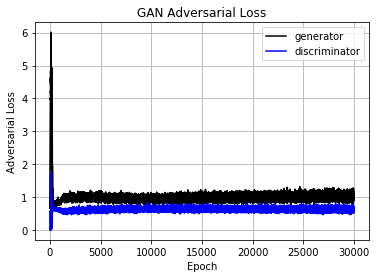

In [9]:
def plot_loss(values, values_t, metric):
    plt.plot(np.arange(len(values)), values, c='k', label='generator')
    plt.plot(np.arange(len(values_t)), values_t, c='b', label='discriminator')
    plt.title('GAN {}'.format(metric))
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


plot_loss(gen_losses, disc_losses, 'Adversarial Loss')

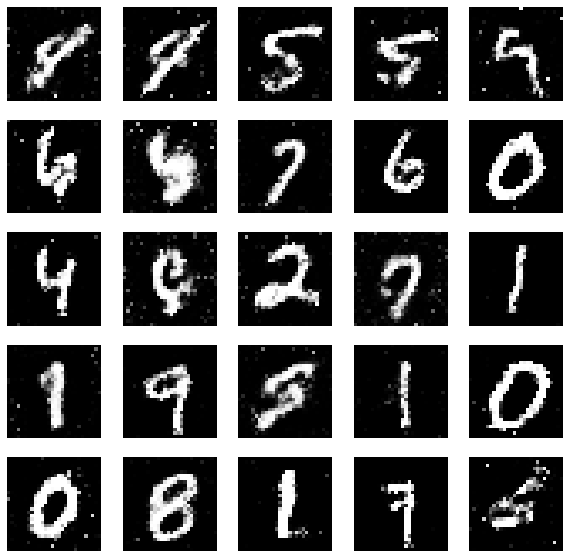

In [12]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, latent_dim))
gen_imgs = generator.predict(noise)

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(r, c, figsize=(10,10))
ix = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[ix].reshape(28,28), cmap='gray')
        axs[i,j].axis('off')
        ix += 1
plt.show()

# Conditional Generative Adversarial Network (CGAN)

In [97]:
#hyperparameters for the network
n_epochs = 30000
n_hidden = 256
latent_dim = 100
batch_size = 32
n_classes = 10
input_dim = 28*28

In [98]:
#Defining the architecture

#Discriminator
x = Input(shape=(input_dim,))
y_d = Input(shape=(n_classes,))
concat_d= Concatenate()([x,y_d])
x_disc = Dense(n_hidden*2)(concat_d)
x_disc = LeakyReLU(alpha=0.2)(x_disc)
x_disc = Dense(n_hidden)(x_disc)
x_disc = LeakyReLU(alpha=0.2)(x_disc)
y_hat = Dense(1, activation='sigmoid')(x_disc)


#Generator
z = Input(shape=(latent_dim,))
y_g = Input(shape=(n_classes,))
concat_g= Concatenate()([z,y_g])
x_gen = Dense(n_hidden)(concat_g)
x_gen = LeakyReLU(alpha=0.2)(x_gen)
x_gen = BatchNormalization(momentum=0.8)(x_gen)
x_gen = Dense(n_hidden*2)(x_gen)
x_gen = LeakyReLU(alpha=0.2)(x_gen)
x_gen = BatchNormalization(momentum=0.8)(x_gen)
x_gen = Dense(n_hidden*4)(x_gen)
x_gen = LeakyReLU(alpha=0.2)(x_gen)
x_gen = BatchNormalization(momentum=0.8)(x_gen)
x_hat = Dense(input_dim, activation='tanh')(x_gen)

In [99]:
generator = Model([z,y_g], x_hat)
discriminator = Model([x,y_d], y_hat)

adam = keras.optimizers.Adam(0.0002, 0.5)

discriminator.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
discriminator.summary()



z = Input(shape=(latent_dim,))
label = Input(shape=(n_classes,))
fake_img = generator([z, label])
discriminator.trainable = False #For the generation, the discriminator is not trained
fake_pred = discriminator([fake_img, label])
combined = Model([z, label], fake_pred)
combined.compile(optimizer=adam, loss='binary_crossentropy')
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
input_46 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 794)          0           input_45[0][0]                   
                                                                 input_46[0][0]                   
__________________________________________________________________________________________________
dense_70 (Dense)                (None, 512)          407040      concatenate_5[0][0]              
__________

In [100]:
y_train = keras.utils.to_categorical(y_train, num_classes=n_classes)

In [107]:
def sample_images(model, epoch):
    r, c = 10, 10
    labels = np.eye(n_classes)
    fig, axs = plt.subplots(r, c)
    ix = 0
    for i in range(r):
        for j in range(c):
            noise = np.random.normal(0, 1, (1, latent_dim))
            label = labels[j].reshape(1,-1)
            
            gen_img = generator.predict([noise, label])
            gen_img = 0.5 * gen_img + 0.5
            
            axs[i,j].imshow(gen_img.reshape(28,28), cmap='gray')
            axs[i,j].axis('off')
            ix += 1
    fig.savefig("images/{}_{}.png".format(model, epoch))
    plt.close()

In [108]:
possible_labels = np.eye(n_classes)
true_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

gen_losses = []
disc_losses = []

for epoch in range(n_epochs):
    print('Epoch: {}'.format(epoch))
    #Select some real images from the dataset
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    imgs = x_train[idx]
    labels = y_train[idx]
    
    
    ###################################
    #          Discriminator          #
    ###################################
    #Sample from the random normal noise.
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    sampled_label = possible_labels[np.random.randint(1, 10, batch_size)]
    
    fake_imgs = generator.predict([noise, sampled_label])
    
    d_loss_real = discriminator.train_on_batch([imgs, labels], true_labels)
    d_loss_fake = discriminator.train_on_batch([fake_imgs, sampled_label], fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    ###################################
    #             Generator           #
    ###################################
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    sampled_label = possible_labels[np.random.randint(1, 10, batch_size)]
    
    g_loss = combined.train_on_batch([noise, sampled_label], true_labels)
    
    
    print('Discriminator loss: {:.3f}, Generator loss: {:.3f}'.format(d_loss[0], g_loss))
    gen_losses.append(g_loss)
    disc_losses.append(d_loss[0])
    
    if epoch%100==0:
        sample_images('cdan', epoch)

Epoch: 0
Discriminator loss: 0.319, Generator loss: 1.017


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 1
Discriminator loss: 0.209, Generator loss: 1.233
Epoch: 2
Discriminator loss: 0.220, Generator loss: 1.326
Epoch: 3
Discriminator loss: 0.182, Generator loss: 1.547
Epoch: 4
Discriminator loss: 0.145, Generator loss: 1.630
Epoch: 5
Discriminator loss: 0.126, Generator loss: 1.795
Epoch: 6
Discriminator loss: 0.104, Generator loss: 1.898
Epoch: 7
Discriminator loss: 0.106, Generator loss: 2.047
Epoch: 8
Discriminator loss: 0.094, Generator loss: 2.143
Epoch: 9
Discriminator loss: 0.069, Generator loss: 2.164
Epoch: 10
Discriminator loss: 0.076, Generator loss: 2.265
Epoch: 11
Discriminator loss: 0.063, Generator loss: 2.330
Epoch: 12
Discriminator loss: 0.067, Generator loss: 2.388
Epoch: 13
Discriminator loss: 0.056, Generator loss: 2.573
Epoch: 14
Discriminator loss: 0.061, Generator loss: 2.618
Epoch: 15
Discriminator loss: 0.048, Generator loss: 2.582
Epoch: 16
Discriminator loss: 0.046, Generator loss: 2.655
Epoch: 17
Discriminator loss: 0.043, Generator loss: 2.655
Epoch:

Discriminator loss: 0.283, Generator loss: 4.116
Epoch: 149
Discriminator loss: 0.073, Generator loss: 3.874
Epoch: 150
Discriminator loss: 0.095, Generator loss: 3.558
Epoch: 151
Discriminator loss: 0.140, Generator loss: 4.652
Epoch: 152
Discriminator loss: 0.305, Generator loss: 3.187
Epoch: 153
Discriminator loss: 0.103, Generator loss: 4.431
Epoch: 154
Discriminator loss: 0.133, Generator loss: 4.292
Epoch: 155
Discriminator loss: 0.159, Generator loss: 3.958
Epoch: 156
Discriminator loss: 0.067, Generator loss: 4.535
Epoch: 157
Discriminator loss: 0.414, Generator loss: 3.517
Epoch: 158
Discriminator loss: 0.088, Generator loss: 3.897
Epoch: 159
Discriminator loss: 0.063, Generator loss: 3.739
Epoch: 160
Discriminator loss: 0.141, Generator loss: 4.081
Epoch: 161
Discriminator loss: 0.368, Generator loss: 4.232
Epoch: 162
Discriminator loss: 0.299, Generator loss: 4.324
Epoch: 163
Discriminator loss: 0.441, Generator loss: 4.475
Epoch: 164
Discriminator loss: 0.126, Generator los

Discriminator loss: 0.666, Generator loss: 1.026
Epoch: 295
Discriminator loss: 0.834, Generator loss: 0.820
Epoch: 296
Discriminator loss: 0.763, Generator loss: 0.860
Epoch: 297
Discriminator loss: 0.707, Generator loss: 0.977
Epoch: 298
Discriminator loss: 0.716, Generator loss: 0.909
Epoch: 299
Discriminator loss: 0.716, Generator loss: 0.894
Epoch: 300
Discriminator loss: 0.722, Generator loss: 0.888
Epoch: 301
Discriminator loss: 0.709, Generator loss: 0.845
Epoch: 302
Discriminator loss: 0.775, Generator loss: 0.823
Epoch: 303
Discriminator loss: 0.716, Generator loss: 0.844
Epoch: 304
Discriminator loss: 0.747, Generator loss: 0.773
Epoch: 305
Discriminator loss: 0.707, Generator loss: 0.826
Epoch: 306
Discriminator loss: 0.745, Generator loss: 0.759
Epoch: 307
Discriminator loss: 0.758, Generator loss: 0.749
Epoch: 308
Discriminator loss: 0.712, Generator loss: 0.755
Epoch: 309
Discriminator loss: 0.741, Generator loss: 0.744
Epoch: 310
Discriminator loss: 0.743, Generator los

Discriminator loss: 0.655, Generator loss: 0.719
Epoch: 437
Discriminator loss: 0.683, Generator loss: 0.752
Epoch: 438
Discriminator loss: 0.680, Generator loss: 0.766
Epoch: 439
Discriminator loss: 0.666, Generator loss: 0.710
Epoch: 440
Discriminator loss: 0.696, Generator loss: 0.747
Epoch: 441
Discriminator loss: 0.682, Generator loss: 0.744
Epoch: 442
Discriminator loss: 0.634, Generator loss: 0.758
Epoch: 443
Discriminator loss: 0.662, Generator loss: 0.740
Epoch: 444
Discriminator loss: 0.691, Generator loss: 0.761
Epoch: 445
Discriminator loss: 0.681, Generator loss: 0.737
Epoch: 446
Discriminator loss: 0.655, Generator loss: 0.737
Epoch: 447
Discriminator loss: 0.658, Generator loss: 0.747
Epoch: 448
Discriminator loss: 0.666, Generator loss: 0.747
Epoch: 449
Discriminator loss: 0.650, Generator loss: 0.759
Epoch: 450
Discriminator loss: 0.674, Generator loss: 0.728
Epoch: 451
Discriminator loss: 0.665, Generator loss: 0.723
Epoch: 452
Discriminator loss: 0.703, Generator los

Discriminator loss: 0.661, Generator loss: 0.745
Epoch: 574
Discriminator loss: 0.631, Generator loss: 0.760
Epoch: 575
Discriminator loss: 0.648, Generator loss: 0.738
Epoch: 576
Discriminator loss: 0.608, Generator loss: 0.765
Epoch: 577
Discriminator loss: 0.650, Generator loss: 0.769
Epoch: 578
Discriminator loss: 0.603, Generator loss: 0.775
Epoch: 579
Discriminator loss: 0.623, Generator loss: 0.766
Epoch: 580
Discriminator loss: 0.624, Generator loss: 0.750
Epoch: 581
Discriminator loss: 0.639, Generator loss: 0.746
Epoch: 582
Discriminator loss: 0.649, Generator loss: 0.775
Epoch: 583
Discriminator loss: 0.611, Generator loss: 0.786
Epoch: 584
Discriminator loss: 0.619, Generator loss: 0.765
Epoch: 585
Discriminator loss: 0.652, Generator loss: 0.777
Epoch: 586
Discriminator loss: 0.632, Generator loss: 0.740
Epoch: 587
Discriminator loss: 0.637, Generator loss: 0.761
Epoch: 588
Discriminator loss: 0.617, Generator loss: 0.776
Epoch: 589
Discriminator loss: 0.627, Generator los

Discriminator loss: 0.607, Generator loss: 0.803
Epoch: 713
Discriminator loss: 0.628, Generator loss: 0.814
Epoch: 714
Discriminator loss: 0.635, Generator loss: 0.801
Epoch: 715
Discriminator loss: 0.636, Generator loss: 0.796
Epoch: 716
Discriminator loss: 0.641, Generator loss: 0.813
Epoch: 717
Discriminator loss: 0.634, Generator loss: 0.796
Epoch: 718
Discriminator loss: 0.646, Generator loss: 0.795
Epoch: 719
Discriminator loss: 0.664, Generator loss: 0.769
Epoch: 720
Discriminator loss: 0.621, Generator loss: 0.771
Epoch: 721
Discriminator loss: 0.615, Generator loss: 0.843
Epoch: 722
Discriminator loss: 0.657, Generator loss: 0.807
Epoch: 723
Discriminator loss: 0.620, Generator loss: 0.820
Epoch: 724
Discriminator loss: 0.651, Generator loss: 0.829
Epoch: 725
Discriminator loss: 0.635, Generator loss: 0.770
Epoch: 726
Discriminator loss: 0.639, Generator loss: 0.777
Epoch: 727
Discriminator loss: 0.657, Generator loss: 0.801
Epoch: 728
Discriminator loss: 0.625, Generator los

Discriminator loss: 0.536, Generator loss: 0.890
Epoch: 861
Discriminator loss: 0.615, Generator loss: 0.878
Epoch: 862
Discriminator loss: 0.607, Generator loss: 0.854
Epoch: 863
Discriminator loss: 0.649, Generator loss: 0.837
Epoch: 864
Discriminator loss: 0.621, Generator loss: 0.803
Epoch: 865
Discriminator loss: 0.611, Generator loss: 0.823
Epoch: 866
Discriminator loss: 0.613, Generator loss: 0.858
Epoch: 867
Discriminator loss: 0.598, Generator loss: 0.825
Epoch: 868
Discriminator loss: 0.603, Generator loss: 0.800
Epoch: 869
Discriminator loss: 0.638, Generator loss: 0.835
Epoch: 870
Discriminator loss: 0.613, Generator loss: 0.847
Epoch: 871
Discriminator loss: 0.606, Generator loss: 0.821
Epoch: 872
Discriminator loss: 0.663, Generator loss: 0.797
Epoch: 873
Discriminator loss: 0.562, Generator loss: 0.863
Epoch: 874
Discriminator loss: 0.613, Generator loss: 0.843
Epoch: 875
Discriminator loss: 0.606, Generator loss: 0.800
Epoch: 876
Discriminator loss: 0.583, Generator los

Epoch: 1001
Discriminator loss: 0.641, Generator loss: 0.881
Epoch: 1002
Discriminator loss: 0.600, Generator loss: 0.860
Epoch: 1003
Discriminator loss: 0.552, Generator loss: 0.950
Epoch: 1004
Discriminator loss: 0.617, Generator loss: 0.921
Epoch: 1005
Discriminator loss: 0.628, Generator loss: 0.920
Epoch: 1006
Discriminator loss: 0.630, Generator loss: 0.877
Epoch: 1007
Discriminator loss: 0.580, Generator loss: 0.866
Epoch: 1008
Discriminator loss: 0.606, Generator loss: 0.854
Epoch: 1009
Discriminator loss: 0.608, Generator loss: 0.849
Epoch: 1010
Discriminator loss: 0.593, Generator loss: 0.818
Epoch: 1011
Discriminator loss: 0.586, Generator loss: 0.882
Epoch: 1012
Discriminator loss: 0.564, Generator loss: 0.926
Epoch: 1013
Discriminator loss: 0.571, Generator loss: 0.952
Epoch: 1014
Discriminator loss: 0.571, Generator loss: 0.880
Epoch: 1015
Discriminator loss: 0.597, Generator loss: 0.862
Epoch: 1016
Discriminator loss: 0.611, Generator loss: 0.894
Epoch: 1017
Discriminato

Discriminator loss: 0.569, Generator loss: 0.898
Epoch: 1137
Discriminator loss: 0.554, Generator loss: 0.882
Epoch: 1138
Discriminator loss: 0.567, Generator loss: 0.960
Epoch: 1139
Discriminator loss: 0.546, Generator loss: 0.896
Epoch: 1140
Discriminator loss: 0.580, Generator loss: 0.913
Epoch: 1141
Discriminator loss: 0.567, Generator loss: 0.966
Epoch: 1142
Discriminator loss: 0.583, Generator loss: 0.954
Epoch: 1143
Discriminator loss: 0.492, Generator loss: 0.939
Epoch: 1144
Discriminator loss: 0.598, Generator loss: 0.949
Epoch: 1145
Discriminator loss: 0.594, Generator loss: 0.970
Epoch: 1146
Discriminator loss: 0.584, Generator loss: 0.902
Epoch: 1147
Discriminator loss: 0.631, Generator loss: 0.855
Epoch: 1148
Discriminator loss: 0.636, Generator loss: 0.902
Epoch: 1149
Discriminator loss: 0.558, Generator loss: 0.954
Epoch: 1150
Discriminator loss: 0.569, Generator loss: 0.968
Epoch: 1151
Discriminator loss: 0.575, Generator loss: 0.953
Epoch: 1152
Discriminator loss: 0.54

Discriminator loss: 0.537, Generator loss: 0.964
Epoch: 1273
Discriminator loss: 0.569, Generator loss: 1.019
Epoch: 1274
Discriminator loss: 0.535, Generator loss: 1.006
Epoch: 1275
Discriminator loss: 0.537, Generator loss: 1.100
Epoch: 1276
Discriminator loss: 0.554, Generator loss: 1.008
Epoch: 1277
Discriminator loss: 0.495, Generator loss: 0.993
Epoch: 1278
Discriminator loss: 0.506, Generator loss: 1.024
Epoch: 1279
Discriminator loss: 0.574, Generator loss: 1.004
Epoch: 1280
Discriminator loss: 0.569, Generator loss: 0.927
Epoch: 1281
Discriminator loss: 0.549, Generator loss: 1.005
Epoch: 1282
Discriminator loss: 0.587, Generator loss: 1.012
Epoch: 1283
Discriminator loss: 0.590, Generator loss: 0.937
Epoch: 1284
Discriminator loss: 0.522, Generator loss: 0.915
Epoch: 1285
Discriminator loss: 0.562, Generator loss: 1.087
Epoch: 1286
Discriminator loss: 0.444, Generator loss: 1.130
Epoch: 1287
Discriminator loss: 0.625, Generator loss: 0.937
Epoch: 1288
Discriminator loss: 0.53

Discriminator loss: 0.567, Generator loss: 0.995
Epoch: 1413
Discriminator loss: 0.587, Generator loss: 0.977
Epoch: 1414
Discriminator loss: 0.540, Generator loss: 1.065
Epoch: 1415
Discriminator loss: 0.556, Generator loss: 1.075
Epoch: 1416
Discriminator loss: 0.495, Generator loss: 1.015
Epoch: 1417
Discriminator loss: 0.606, Generator loss: 1.198
Epoch: 1418
Discriminator loss: 0.581, Generator loss: 1.034
Epoch: 1419
Discriminator loss: 0.528, Generator loss: 1.020
Epoch: 1420
Discriminator loss: 0.520, Generator loss: 1.049
Epoch: 1421
Discriminator loss: 0.498, Generator loss: 1.135
Epoch: 1422
Discriminator loss: 0.565, Generator loss: 1.004
Epoch: 1423
Discriminator loss: 0.567, Generator loss: 1.038
Epoch: 1424
Discriminator loss: 0.538, Generator loss: 0.944
Epoch: 1425
Discriminator loss: 0.504, Generator loss: 0.890
Epoch: 1426
Discriminator loss: 0.587, Generator loss: 0.860
Epoch: 1427
Discriminator loss: 0.566, Generator loss: 1.019
Epoch: 1428
Discriminator loss: 0.57

Discriminator loss: 0.558, Generator loss: 1.081
Epoch: 1549
Discriminator loss: 0.568, Generator loss: 0.990
Epoch: 1550
Discriminator loss: 0.557, Generator loss: 0.999
Epoch: 1551
Discriminator loss: 0.491, Generator loss: 0.909
Epoch: 1552
Discriminator loss: 0.494, Generator loss: 1.017
Epoch: 1553
Discriminator loss: 0.591, Generator loss: 1.043
Epoch: 1554
Discriminator loss: 0.480, Generator loss: 1.081
Epoch: 1555
Discriminator loss: 0.542, Generator loss: 0.996
Epoch: 1556
Discriminator loss: 0.517, Generator loss: 1.070
Epoch: 1557
Discriminator loss: 0.570, Generator loss: 1.200
Epoch: 1558
Discriminator loss: 0.528, Generator loss: 1.195
Epoch: 1559
Discriminator loss: 0.560, Generator loss: 1.013
Epoch: 1560
Discriminator loss: 0.491, Generator loss: 1.060
Epoch: 1561
Discriminator loss: 0.497, Generator loss: 1.096
Epoch: 1562
Discriminator loss: 0.549, Generator loss: 1.087
Epoch: 1563
Discriminator loss: 0.556, Generator loss: 1.063
Epoch: 1564
Discriminator loss: 0.53

Discriminator loss: 0.543, Generator loss: 1.212
Epoch: 1685
Discriminator loss: 0.439, Generator loss: 1.120
Epoch: 1686
Discriminator loss: 0.543, Generator loss: 1.162
Epoch: 1687
Discriminator loss: 0.473, Generator loss: 1.169
Epoch: 1688
Discriminator loss: 0.556, Generator loss: 1.237
Epoch: 1689
Discriminator loss: 0.507, Generator loss: 1.088
Epoch: 1690
Discriminator loss: 0.582, Generator loss: 1.138
Epoch: 1691
Discriminator loss: 0.510, Generator loss: 1.085
Epoch: 1692
Discriminator loss: 0.473, Generator loss: 1.120
Epoch: 1693
Discriminator loss: 0.489, Generator loss: 1.093
Epoch: 1694
Discriminator loss: 0.481, Generator loss: 1.057
Epoch: 1695
Discriminator loss: 0.434, Generator loss: 1.121
Epoch: 1696
Discriminator loss: 0.566, Generator loss: 1.107
Epoch: 1697
Discriminator loss: 0.525, Generator loss: 1.252
Epoch: 1698
Discriminator loss: 0.521, Generator loss: 1.192
Epoch: 1699
Discriminator loss: 0.637, Generator loss: 1.095
Epoch: 1700
Discriminator loss: 0.55

Discriminator loss: 0.529, Generator loss: 1.074
Epoch: 1825
Discriminator loss: 0.474, Generator loss: 1.129
Epoch: 1826
Discriminator loss: 0.598, Generator loss: 1.094
Epoch: 1827
Discriminator loss: 0.480, Generator loss: 1.194
Epoch: 1828
Discriminator loss: 0.609, Generator loss: 1.134
Epoch: 1829
Discriminator loss: 0.547, Generator loss: 1.062
Epoch: 1830
Discriminator loss: 0.501, Generator loss: 1.059
Epoch: 1831
Discriminator loss: 0.597, Generator loss: 1.107
Epoch: 1832
Discriminator loss: 0.499, Generator loss: 1.286
Epoch: 1833
Discriminator loss: 0.499, Generator loss: 1.235
Epoch: 1834
Discriminator loss: 0.555, Generator loss: 1.098
Epoch: 1835
Discriminator loss: 0.506, Generator loss: 1.145
Epoch: 1836
Discriminator loss: 0.469, Generator loss: 1.128
Epoch: 1837
Discriminator loss: 0.485, Generator loss: 1.102
Epoch: 1838
Discriminator loss: 0.539, Generator loss: 0.902
Epoch: 1839
Discriminator loss: 0.533, Generator loss: 1.066
Epoch: 1840
Discriminator loss: 0.50

Discriminator loss: 0.490, Generator loss: 1.182
Epoch: 1961
Discriminator loss: 0.472, Generator loss: 1.150
Epoch: 1962
Discriminator loss: 0.533, Generator loss: 1.161
Epoch: 1963
Discriminator loss: 0.508, Generator loss: 1.345
Epoch: 1964
Discriminator loss: 0.577, Generator loss: 1.211
Epoch: 1965
Discriminator loss: 0.537, Generator loss: 1.210
Epoch: 1966
Discriminator loss: 0.485, Generator loss: 1.200
Epoch: 1967
Discriminator loss: 0.490, Generator loss: 1.300
Epoch: 1968
Discriminator loss: 0.587, Generator loss: 1.095
Epoch: 1969
Discriminator loss: 0.492, Generator loss: 1.247
Epoch: 1970
Discriminator loss: 0.470, Generator loss: 1.340
Epoch: 1971
Discriminator loss: 0.495, Generator loss: 1.082
Epoch: 1972
Discriminator loss: 0.535, Generator loss: 1.031
Epoch: 1973
Discriminator loss: 0.515, Generator loss: 1.219
Epoch: 1974
Discriminator loss: 0.453, Generator loss: 1.201
Epoch: 1975
Discriminator loss: 0.581, Generator loss: 1.137
Epoch: 1976
Discriminator loss: 0.51

Discriminator loss: 0.560, Generator loss: 1.062
Epoch: 2097
Discriminator loss: 0.477, Generator loss: 1.316
Epoch: 2098
Discriminator loss: 0.536, Generator loss: 1.059
Epoch: 2099
Discriminator loss: 0.672, Generator loss: 1.041
Epoch: 2100
Discriminator loss: 0.529, Generator loss: 1.204
Epoch: 2101
Discriminator loss: 0.542, Generator loss: 1.051
Epoch: 2102
Discriminator loss: 0.542, Generator loss: 1.188
Epoch: 2103
Discriminator loss: 0.572, Generator loss: 1.143
Epoch: 2104
Discriminator loss: 0.573, Generator loss: 1.192
Epoch: 2105
Discriminator loss: 0.547, Generator loss: 1.044
Epoch: 2106
Discriminator loss: 0.621, Generator loss: 1.074
Epoch: 2107
Discriminator loss: 0.566, Generator loss: 1.197
Epoch: 2108
Discriminator loss: 0.450, Generator loss: 1.168
Epoch: 2109
Discriminator loss: 0.463, Generator loss: 1.272
Epoch: 2110
Discriminator loss: 0.560, Generator loss: 1.239
Epoch: 2111
Discriminator loss: 0.510, Generator loss: 1.183
Epoch: 2112
Discriminator loss: 0.51

Discriminator loss: 0.586, Generator loss: 1.108
Epoch: 2237
Discriminator loss: 0.527, Generator loss: 1.208
Epoch: 2238
Discriminator loss: 0.501, Generator loss: 1.096
Epoch: 2239
Discriminator loss: 0.532, Generator loss: 1.124
Epoch: 2240
Discriminator loss: 0.533, Generator loss: 1.173
Epoch: 2241
Discriminator loss: 0.546, Generator loss: 1.131
Epoch: 2242
Discriminator loss: 0.598, Generator loss: 1.085
Epoch: 2243
Discriminator loss: 0.545, Generator loss: 1.239
Epoch: 2244
Discriminator loss: 0.606, Generator loss: 1.146
Epoch: 2245
Discriminator loss: 0.531, Generator loss: 1.220
Epoch: 2246
Discriminator loss: 0.555, Generator loss: 1.098
Epoch: 2247
Discriminator loss: 0.539, Generator loss: 1.147
Epoch: 2248
Discriminator loss: 0.580, Generator loss: 1.231
Epoch: 2249
Discriminator loss: 0.536, Generator loss: 1.111
Epoch: 2250
Discriminator loss: 0.567, Generator loss: 1.040
Epoch: 2251
Discriminator loss: 0.606, Generator loss: 0.923
Epoch: 2252
Discriminator loss: 0.56

Discriminator loss: 0.614, Generator loss: 1.083
Epoch: 2373
Discriminator loss: 0.557, Generator loss: 1.093
Epoch: 2374
Discriminator loss: 0.595, Generator loss: 1.017
Epoch: 2375
Discriminator loss: 0.543, Generator loss: 1.256
Epoch: 2376
Discriminator loss: 0.478, Generator loss: 1.207
Epoch: 2377
Discriminator loss: 0.646, Generator loss: 1.062
Epoch: 2378
Discriminator loss: 0.610, Generator loss: 1.003
Epoch: 2379
Discriminator loss: 0.550, Generator loss: 1.028
Epoch: 2380
Discriminator loss: 0.612, Generator loss: 1.047
Epoch: 2381
Discriminator loss: 0.568, Generator loss: 0.998
Epoch: 2382
Discriminator loss: 0.638, Generator loss: 0.993
Epoch: 2383
Discriminator loss: 0.525, Generator loss: 1.103
Epoch: 2384
Discriminator loss: 0.534, Generator loss: 1.206
Epoch: 2385
Discriminator loss: 0.599, Generator loss: 0.926
Epoch: 2386
Discriminator loss: 0.637, Generator loss: 1.037
Epoch: 2387
Discriminator loss: 0.564, Generator loss: 1.125
Epoch: 2388
Discriminator loss: 0.59

Discriminator loss: 0.512, Generator loss: 0.920
Epoch: 2513
Discriminator loss: 0.562, Generator loss: 0.988
Epoch: 2514
Discriminator loss: 0.533, Generator loss: 1.072
Epoch: 2515
Discriminator loss: 0.479, Generator loss: 1.105
Epoch: 2516
Discriminator loss: 0.569, Generator loss: 1.004
Epoch: 2517
Discriminator loss: 0.642, Generator loss: 0.932
Epoch: 2518
Discriminator loss: 0.633, Generator loss: 0.929
Epoch: 2519
Discriminator loss: 0.632, Generator loss: 1.165
Epoch: 2520
Discriminator loss: 0.550, Generator loss: 1.057
Epoch: 2521
Discriminator loss: 0.629, Generator loss: 1.191
Epoch: 2522
Discriminator loss: 0.604, Generator loss: 1.053
Epoch: 2523
Discriminator loss: 0.525, Generator loss: 1.080
Epoch: 2524
Discriminator loss: 0.548, Generator loss: 1.137
Epoch: 2525
Discriminator loss: 0.484, Generator loss: 1.008
Epoch: 2526
Discriminator loss: 0.601, Generator loss: 1.187
Epoch: 2527
Discriminator loss: 0.601, Generator loss: 0.990
Epoch: 2528
Discriminator loss: 0.61

Discriminator loss: 0.574, Generator loss: 1.022
Epoch: 2649
Discriminator loss: 0.599, Generator loss: 1.071
Epoch: 2650
Discriminator loss: 0.560, Generator loss: 1.137
Epoch: 2651
Discriminator loss: 0.552, Generator loss: 1.099
Epoch: 2652
Discriminator loss: 0.620, Generator loss: 1.071
Epoch: 2653
Discriminator loss: 0.611, Generator loss: 0.985
Epoch: 2654
Discriminator loss: 0.651, Generator loss: 1.052
Epoch: 2655
Discriminator loss: 0.578, Generator loss: 0.960
Epoch: 2656
Discriminator loss: 0.540, Generator loss: 1.048
Epoch: 2657
Discriminator loss: 0.600, Generator loss: 1.002
Epoch: 2658
Discriminator loss: 0.603, Generator loss: 0.971
Epoch: 2659
Discriminator loss: 0.617, Generator loss: 1.014
Epoch: 2660
Discriminator loss: 0.501, Generator loss: 1.064
Epoch: 2661
Discriminator loss: 0.627, Generator loss: 1.001
Epoch: 2662
Discriminator loss: 0.594, Generator loss: 1.025
Epoch: 2663
Discriminator loss: 0.584, Generator loss: 1.052
Epoch: 2664
Discriminator loss: 0.58

Discriminator loss: 0.602, Generator loss: 0.999
Epoch: 2785
Discriminator loss: 0.547, Generator loss: 1.023
Epoch: 2786
Discriminator loss: 0.565, Generator loss: 1.034
Epoch: 2787
Discriminator loss: 0.572, Generator loss: 1.029
Epoch: 2788
Discriminator loss: 0.643, Generator loss: 0.988
Epoch: 2789
Discriminator loss: 0.497, Generator loss: 1.009
Epoch: 2790
Discriminator loss: 0.548, Generator loss: 0.961
Epoch: 2791
Discriminator loss: 0.578, Generator loss: 1.025
Epoch: 2792
Discriminator loss: 0.669, Generator loss: 0.971
Epoch: 2793
Discriminator loss: 0.517, Generator loss: 1.039
Epoch: 2794
Discriminator loss: 0.600, Generator loss: 1.069
Epoch: 2795
Discriminator loss: 0.535, Generator loss: 1.040
Epoch: 2796
Discriminator loss: 0.573, Generator loss: 0.971
Epoch: 2797
Discriminator loss: 0.639, Generator loss: 0.893
Epoch: 2798
Discriminator loss: 0.613, Generator loss: 0.954
Epoch: 2799
Discriminator loss: 0.518, Generator loss: 1.007
Epoch: 2800
Discriminator loss: 0.64

Discriminator loss: 0.609, Generator loss: 0.891
Epoch: 2925
Discriminator loss: 0.664, Generator loss: 0.961
Epoch: 2926
Discriminator loss: 0.606, Generator loss: 1.015
Epoch: 2927
Discriminator loss: 0.556, Generator loss: 0.852
Epoch: 2928
Discriminator loss: 0.667, Generator loss: 0.859
Epoch: 2929
Discriminator loss: 0.562, Generator loss: 0.967
Epoch: 2930
Discriminator loss: 0.585, Generator loss: 1.039
Epoch: 2931
Discriminator loss: 0.635, Generator loss: 1.085
Epoch: 2932
Discriminator loss: 0.612, Generator loss: 1.028
Epoch: 2933
Discriminator loss: 0.715, Generator loss: 1.021
Epoch: 2934
Discriminator loss: 0.650, Generator loss: 0.996
Epoch: 2935
Discriminator loss: 0.508, Generator loss: 1.033
Epoch: 2936
Discriminator loss: 0.657, Generator loss: 0.987
Epoch: 2937
Discriminator loss: 0.519, Generator loss: 1.086
Epoch: 2938
Discriminator loss: 0.621, Generator loss: 1.086
Epoch: 2939
Discriminator loss: 0.617, Generator loss: 1.055
Epoch: 2940
Discriminator loss: 0.57

Discriminator loss: 0.600, Generator loss: 0.985
Epoch: 3061
Discriminator loss: 0.653, Generator loss: 1.019
Epoch: 3062
Discriminator loss: 0.600, Generator loss: 0.996
Epoch: 3063
Discriminator loss: 0.625, Generator loss: 0.966
Epoch: 3064
Discriminator loss: 0.622, Generator loss: 0.912
Epoch: 3065
Discriminator loss: 0.646, Generator loss: 0.918
Epoch: 3066
Discriminator loss: 0.570, Generator loss: 0.935
Epoch: 3067
Discriminator loss: 0.566, Generator loss: 0.954
Epoch: 3068
Discriminator loss: 0.608, Generator loss: 0.931
Epoch: 3069
Discriminator loss: 0.713, Generator loss: 0.913
Epoch: 3070
Discriminator loss: 0.569, Generator loss: 0.998
Epoch: 3071
Discriminator loss: 0.546, Generator loss: 1.062
Epoch: 3072
Discriminator loss: 0.619, Generator loss: 1.050
Epoch: 3073
Discriminator loss: 0.616, Generator loss: 1.003
Epoch: 3074
Discriminator loss: 0.629, Generator loss: 0.999
Epoch: 3075
Discriminator loss: 0.628, Generator loss: 0.983
Epoch: 3076
Discriminator loss: 0.60

Discriminator loss: 0.614, Generator loss: 0.959
Epoch: 3198
Discriminator loss: 0.585, Generator loss: 0.927
Epoch: 3199
Discriminator loss: 0.583, Generator loss: 0.985
Epoch: 3200
Discriminator loss: 0.653, Generator loss: 0.892
Epoch: 3201
Discriminator loss: 0.685, Generator loss: 0.839
Epoch: 3202
Discriminator loss: 0.608, Generator loss: 0.829
Epoch: 3203
Discriminator loss: 0.588, Generator loss: 0.970
Epoch: 3204
Discriminator loss: 0.613, Generator loss: 0.940
Epoch: 3205
Discriminator loss: 0.628, Generator loss: 0.910
Epoch: 3206
Discriminator loss: 0.615, Generator loss: 0.896
Epoch: 3207
Discriminator loss: 0.614, Generator loss: 1.003
Epoch: 3208
Discriminator loss: 0.698, Generator loss: 0.951
Epoch: 3209
Discriminator loss: 0.608, Generator loss: 0.972
Epoch: 3210
Discriminator loss: 0.605, Generator loss: 1.008
Epoch: 3211
Discriminator loss: 0.654, Generator loss: 1.088
Epoch: 3212
Discriminator loss: 0.590, Generator loss: 0.994
Epoch: 3213
Discriminator loss: 0.64

Discriminator loss: 0.632, Generator loss: 0.953
Epoch: 3337
Discriminator loss: 0.615, Generator loss: 0.941
Epoch: 3338
Discriminator loss: 0.599, Generator loss: 0.911
Epoch: 3339
Discriminator loss: 0.551, Generator loss: 1.025
Epoch: 3340
Discriminator loss: 0.705, Generator loss: 1.001
Epoch: 3341
Discriminator loss: 0.540, Generator loss: 0.955
Epoch: 3342
Discriminator loss: 0.583, Generator loss: 1.049
Epoch: 3343
Discriminator loss: 0.574, Generator loss: 0.927
Epoch: 3344
Discriminator loss: 0.527, Generator loss: 0.975
Epoch: 3345
Discriminator loss: 0.541, Generator loss: 0.992
Epoch: 3346
Discriminator loss: 0.625, Generator loss: 0.910
Epoch: 3347
Discriminator loss: 0.634, Generator loss: 0.952
Epoch: 3348
Discriminator loss: 0.644, Generator loss: 0.917
Epoch: 3349
Discriminator loss: 0.607, Generator loss: 1.031
Epoch: 3350
Discriminator loss: 0.691, Generator loss: 0.927
Epoch: 3351
Discriminator loss: 0.536, Generator loss: 0.890
Epoch: 3352
Discriminator loss: 0.69

Discriminator loss: 0.615, Generator loss: 1.018
Epoch: 3473
Discriminator loss: 0.641, Generator loss: 1.097
Epoch: 3474
Discriminator loss: 0.569, Generator loss: 1.112
Epoch: 3475
Discriminator loss: 0.649, Generator loss: 0.961
Epoch: 3476
Discriminator loss: 0.578, Generator loss: 1.041
Epoch: 3477
Discriminator loss: 0.667, Generator loss: 0.986
Epoch: 3478
Discriminator loss: 0.569, Generator loss: 0.930
Epoch: 3479
Discriminator loss: 0.555, Generator loss: 0.985
Epoch: 3480
Discriminator loss: 0.581, Generator loss: 0.940
Epoch: 3481
Discriminator loss: 0.603, Generator loss: 1.020
Epoch: 3482
Discriminator loss: 0.651, Generator loss: 0.980
Epoch: 3483
Discriminator loss: 0.610, Generator loss: 1.024
Epoch: 3484
Discriminator loss: 0.578, Generator loss: 1.000
Epoch: 3485
Discriminator loss: 0.615, Generator loss: 0.897
Epoch: 3486
Discriminator loss: 0.615, Generator loss: 0.958
Epoch: 3487
Discriminator loss: 0.584, Generator loss: 0.922
Epoch: 3488
Discriminator loss: 0.58

Discriminator loss: 0.663, Generator loss: 0.915
Epoch: 3613
Discriminator loss: 0.554, Generator loss: 1.082
Epoch: 3614
Discriminator loss: 0.570, Generator loss: 0.989
Epoch: 3615
Discriminator loss: 0.635, Generator loss: 1.031
Epoch: 3616
Discriminator loss: 0.585, Generator loss: 0.944
Epoch: 3617
Discriminator loss: 0.614, Generator loss: 0.970
Epoch: 3618
Discriminator loss: 0.585, Generator loss: 1.005
Epoch: 3619
Discriminator loss: 0.648, Generator loss: 0.941
Epoch: 3620
Discriminator loss: 0.652, Generator loss: 1.065
Epoch: 3621
Discriminator loss: 0.605, Generator loss: 1.044
Epoch: 3622
Discriminator loss: 0.635, Generator loss: 1.013
Epoch: 3623
Discriminator loss: 0.628, Generator loss: 0.975
Epoch: 3624
Discriminator loss: 0.591, Generator loss: 0.954
Epoch: 3625
Discriminator loss: 0.628, Generator loss: 0.999
Epoch: 3626
Discriminator loss: 0.522, Generator loss: 0.964
Epoch: 3627
Discriminator loss: 0.588, Generator loss: 0.915
Epoch: 3628
Discriminator loss: 0.60

Discriminator loss: 0.637, Generator loss: 0.987
Epoch: 3749
Discriminator loss: 0.702, Generator loss: 0.962
Epoch: 3750
Discriminator loss: 0.619, Generator loss: 0.977
Epoch: 3751
Discriminator loss: 0.664, Generator loss: 0.981
Epoch: 3752
Discriminator loss: 0.576, Generator loss: 1.001
Epoch: 3753
Discriminator loss: 0.623, Generator loss: 0.953
Epoch: 3754
Discriminator loss: 0.681, Generator loss: 1.011
Epoch: 3755
Discriminator loss: 0.655, Generator loss: 1.050
Epoch: 3756
Discriminator loss: 0.702, Generator loss: 0.986
Epoch: 3757
Discriminator loss: 0.611, Generator loss: 1.034
Epoch: 3758
Discriminator loss: 0.587, Generator loss: 1.009
Epoch: 3759
Discriminator loss: 0.535, Generator loss: 1.100
Epoch: 3760
Discriminator loss: 0.714, Generator loss: 1.016
Epoch: 3761
Discriminator loss: 0.612, Generator loss: 0.953
Epoch: 3762
Discriminator loss: 0.607, Generator loss: 1.006
Epoch: 3763
Discriminator loss: 0.559, Generator loss: 0.948
Epoch: 3764
Discriminator loss: 0.57

Discriminator loss: 0.516, Generator loss: 0.944
Epoch: 3886
Discriminator loss: 0.646, Generator loss: 0.947
Epoch: 3887
Discriminator loss: 0.635, Generator loss: 0.966
Epoch: 3888
Discriminator loss: 0.622, Generator loss: 0.944
Epoch: 3889
Discriminator loss: 0.617, Generator loss: 0.873
Epoch: 3890
Discriminator loss: 0.627, Generator loss: 0.932
Epoch: 3891
Discriminator loss: 0.547, Generator loss: 1.037
Epoch: 3892
Discriminator loss: 0.513, Generator loss: 0.999
Epoch: 3893
Discriminator loss: 0.587, Generator loss: 1.016
Epoch: 3894
Discriminator loss: 0.637, Generator loss: 1.030
Epoch: 3895
Discriminator loss: 0.609, Generator loss: 0.949
Epoch: 3896
Discriminator loss: 0.589, Generator loss: 1.003
Epoch: 3897
Discriminator loss: 0.616, Generator loss: 1.013
Epoch: 3898
Discriminator loss: 0.608, Generator loss: 1.029
Epoch: 3899
Discriminator loss: 0.596, Generator loss: 1.148
Epoch: 3900
Discriminator loss: 0.621, Generator loss: 0.993
Epoch: 3901
Discriminator loss: 0.61

Discriminator loss: 0.562, Generator loss: 1.029
Epoch: 4024
Discriminator loss: 0.616, Generator loss: 1.063
Epoch: 4025
Discriminator loss: 0.592, Generator loss: 0.946
Epoch: 4026
Discriminator loss: 0.573, Generator loss: 1.040
Epoch: 4027
Discriminator loss: 0.569, Generator loss: 0.983
Epoch: 4028
Discriminator loss: 0.664, Generator loss: 0.989
Epoch: 4029
Discriminator loss: 0.607, Generator loss: 0.958
Epoch: 4030
Discriminator loss: 0.571, Generator loss: 0.990
Epoch: 4031
Discriminator loss: 0.644, Generator loss: 0.916
Epoch: 4032
Discriminator loss: 0.629, Generator loss: 0.909
Epoch: 4033
Discriminator loss: 0.517, Generator loss: 0.947
Epoch: 4034
Discriminator loss: 0.692, Generator loss: 0.965
Epoch: 4035
Discriminator loss: 0.601, Generator loss: 1.027
Epoch: 4036
Discriminator loss: 0.606, Generator loss: 1.049
Epoch: 4037
Discriminator loss: 0.595, Generator loss: 0.929
Epoch: 4038
Discriminator loss: 0.610, Generator loss: 0.925
Epoch: 4039
Discriminator loss: 0.65

Discriminator loss: 0.652, Generator loss: 0.954
Epoch: 4162
Discriminator loss: 0.684, Generator loss: 0.934
Epoch: 4163
Discriminator loss: 0.602, Generator loss: 1.009
Epoch: 4164
Discriminator loss: 0.682, Generator loss: 0.871
Epoch: 4165
Discriminator loss: 0.600, Generator loss: 0.925
Epoch: 4166
Discriminator loss: 0.638, Generator loss: 0.950
Epoch: 4167
Discriminator loss: 0.625, Generator loss: 0.940
Epoch: 4168
Discriminator loss: 0.604, Generator loss: 0.942
Epoch: 4169
Discriminator loss: 0.630, Generator loss: 0.929
Epoch: 4170
Discriminator loss: 0.639, Generator loss: 0.901
Epoch: 4171
Discriminator loss: 0.636, Generator loss: 1.002
Epoch: 4172
Discriminator loss: 0.678, Generator loss: 0.886
Epoch: 4173
Discriminator loss: 0.627, Generator loss: 0.953
Epoch: 4174
Discriminator loss: 0.656, Generator loss: 0.936
Epoch: 4175
Discriminator loss: 0.605, Generator loss: 0.954
Epoch: 4176
Discriminator loss: 0.604, Generator loss: 1.017
Epoch: 4177
Discriminator loss: 0.62

Discriminator loss: 0.669, Generator loss: 0.953
Epoch: 4298
Discriminator loss: 0.605, Generator loss: 1.013
Epoch: 4299
Discriminator loss: 0.650, Generator loss: 1.000
Epoch: 4300
Discriminator loss: 0.591, Generator loss: 1.019
Epoch: 4301
Discriminator loss: 0.613, Generator loss: 0.985
Epoch: 4302
Discriminator loss: 0.612, Generator loss: 0.924
Epoch: 4303
Discriminator loss: 0.691, Generator loss: 0.908
Epoch: 4304
Discriminator loss: 0.654, Generator loss: 1.000
Epoch: 4305
Discriminator loss: 0.548, Generator loss: 0.997
Epoch: 4306
Discriminator loss: 0.638, Generator loss: 0.997
Epoch: 4307
Discriminator loss: 0.608, Generator loss: 1.041
Epoch: 4308
Discriminator loss: 0.601, Generator loss: 0.936
Epoch: 4309
Discriminator loss: 0.650, Generator loss: 0.957
Epoch: 4310
Discriminator loss: 0.597, Generator loss: 0.893
Epoch: 4311
Discriminator loss: 0.662, Generator loss: 0.886
Epoch: 4312
Discriminator loss: 0.622, Generator loss: 0.952
Epoch: 4313
Discriminator loss: 0.60

Discriminator loss: 0.649, Generator loss: 0.961
Epoch: 4437
Discriminator loss: 0.611, Generator loss: 0.963
Epoch: 4438
Discriminator loss: 0.640, Generator loss: 0.938
Epoch: 4439
Discriminator loss: 0.634, Generator loss: 1.008
Epoch: 4440
Discriminator loss: 0.562, Generator loss: 0.957
Epoch: 4441
Discriminator loss: 0.566, Generator loss: 0.960
Epoch: 4442
Discriminator loss: 0.690, Generator loss: 1.012
Epoch: 4443
Discriminator loss: 0.564, Generator loss: 0.999
Epoch: 4444
Discriminator loss: 0.654, Generator loss: 0.957
Epoch: 4445
Discriminator loss: 0.580, Generator loss: 1.008
Epoch: 4446
Discriminator loss: 0.731, Generator loss: 0.976
Epoch: 4447
Discriminator loss: 0.656, Generator loss: 0.987
Epoch: 4448
Discriminator loss: 0.663, Generator loss: 0.923
Epoch: 4449
Discriminator loss: 0.603, Generator loss: 1.017
Epoch: 4450
Discriminator loss: 0.571, Generator loss: 1.041
Epoch: 4451
Discriminator loss: 0.690, Generator loss: 0.923
Epoch: 4452
Discriminator loss: 0.64

Discriminator loss: 0.638, Generator loss: 0.934
Epoch: 4573
Discriminator loss: 0.569, Generator loss: 0.900
Epoch: 4574
Discriminator loss: 0.588, Generator loss: 0.929
Epoch: 4575
Discriminator loss: 0.681, Generator loss: 0.948
Epoch: 4576
Discriminator loss: 0.474, Generator loss: 1.019
Epoch: 4577
Discriminator loss: 0.579, Generator loss: 1.002
Epoch: 4578
Discriminator loss: 0.624, Generator loss: 1.009
Epoch: 4579
Discriminator loss: 0.624, Generator loss: 1.002
Epoch: 4580
Discriminator loss: 0.643, Generator loss: 0.941
Epoch: 4581
Discriminator loss: 0.684, Generator loss: 0.969
Epoch: 4582
Discriminator loss: 0.669, Generator loss: 0.887
Epoch: 4583
Discriminator loss: 0.731, Generator loss: 0.919
Epoch: 4584
Discriminator loss: 0.618, Generator loss: 0.838
Epoch: 4585
Discriminator loss: 0.574, Generator loss: 0.870
Epoch: 4586
Discriminator loss: 0.635, Generator loss: 0.945
Epoch: 4587
Discriminator loss: 0.650, Generator loss: 0.988
Epoch: 4588
Discriminator loss: 0.64

Discriminator loss: 0.608, Generator loss: 0.982
Epoch: 4713
Discriminator loss: 0.600, Generator loss: 0.904
Epoch: 4714
Discriminator loss: 0.567, Generator loss: 0.981
Epoch: 4715
Discriminator loss: 0.615, Generator loss: 0.908
Epoch: 4716
Discriminator loss: 0.595, Generator loss: 0.953
Epoch: 4717
Discriminator loss: 0.624, Generator loss: 0.939
Epoch: 4718
Discriminator loss: 0.668, Generator loss: 0.943
Epoch: 4719
Discriminator loss: 0.611, Generator loss: 0.915
Epoch: 4720
Discriminator loss: 0.566, Generator loss: 0.956
Epoch: 4721
Discriminator loss: 0.593, Generator loss: 0.980
Epoch: 4722
Discriminator loss: 0.588, Generator loss: 0.961
Epoch: 4723
Discriminator loss: 0.654, Generator loss: 1.045
Epoch: 4724
Discriminator loss: 0.691, Generator loss: 0.984
Epoch: 4725
Discriminator loss: 0.613, Generator loss: 1.016
Epoch: 4726
Discriminator loss: 0.592, Generator loss: 0.938
Epoch: 4727
Discriminator loss: 0.626, Generator loss: 1.012
Epoch: 4728
Discriminator loss: 0.65

Discriminator loss: 0.560, Generator loss: 0.965
Epoch: 4848
Discriminator loss: 0.623, Generator loss: 0.885
Epoch: 4849
Discriminator loss: 0.662, Generator loss: 0.993
Epoch: 4850
Discriminator loss: 0.587, Generator loss: 0.958
Epoch: 4851
Discriminator loss: 0.575, Generator loss: 0.992
Epoch: 4852
Discriminator loss: 0.630, Generator loss: 0.875
Epoch: 4853
Discriminator loss: 0.616, Generator loss: 0.949
Epoch: 4854
Discriminator loss: 0.580, Generator loss: 1.012
Epoch: 4855
Discriminator loss: 0.619, Generator loss: 1.006
Epoch: 4856
Discriminator loss: 0.631, Generator loss: 0.984
Epoch: 4857
Discriminator loss: 0.645, Generator loss: 0.977
Epoch: 4858
Discriminator loss: 0.554, Generator loss: 0.985
Epoch: 4859
Discriminator loss: 0.639, Generator loss: 0.986
Epoch: 4860
Discriminator loss: 0.579, Generator loss: 0.926
Epoch: 4861
Discriminator loss: 0.575, Generator loss: 0.993
Epoch: 4862
Discriminator loss: 0.635, Generator loss: 0.942
Epoch: 4863
Discriminator loss: 0.64

Discriminator loss: 0.678, Generator loss: 0.992
Epoch: 4985
Discriminator loss: 0.661, Generator loss: 0.900
Epoch: 4986
Discriminator loss: 0.645, Generator loss: 0.898
Epoch: 4987
Discriminator loss: 0.645, Generator loss: 0.978
Epoch: 4988
Discriminator loss: 0.660, Generator loss: 0.935
Epoch: 4989
Discriminator loss: 0.636, Generator loss: 0.931
Epoch: 4990
Discriminator loss: 0.644, Generator loss: 0.905
Epoch: 4991
Discriminator loss: 0.614, Generator loss: 1.015
Epoch: 4992
Discriminator loss: 0.634, Generator loss: 0.995
Epoch: 4993
Discriminator loss: 0.666, Generator loss: 0.925
Epoch: 4994
Discriminator loss: 0.670, Generator loss: 0.906
Epoch: 4995
Discriminator loss: 0.631, Generator loss: 0.968
Epoch: 4996
Discriminator loss: 0.607, Generator loss: 0.917
Epoch: 4997
Discriminator loss: 0.646, Generator loss: 0.895
Epoch: 4998
Discriminator loss: 0.597, Generator loss: 0.964
Epoch: 4999
Discriminator loss: 0.629, Generator loss: 0.961
Epoch: 5000
Discriminator loss: 0.61

Discriminator loss: 0.591, Generator loss: 1.054
Epoch: 5124
Discriminator loss: 0.658, Generator loss: 0.954
Epoch: 5125
Discriminator loss: 0.629, Generator loss: 0.926
Epoch: 5126
Discriminator loss: 0.557, Generator loss: 0.981
Epoch: 5127
Discriminator loss: 0.576, Generator loss: 1.053
Epoch: 5128
Discriminator loss: 0.660, Generator loss: 0.992
Epoch: 5129
Discriminator loss: 0.618, Generator loss: 1.059
Epoch: 5130
Discriminator loss: 0.665, Generator loss: 0.995
Epoch: 5131
Discriminator loss: 0.656, Generator loss: 0.860
Epoch: 5132
Discriminator loss: 0.616, Generator loss: 0.901
Epoch: 5133
Discriminator loss: 0.649, Generator loss: 0.940
Epoch: 5134
Discriminator loss: 0.647, Generator loss: 0.916
Epoch: 5135
Discriminator loss: 0.693, Generator loss: 0.991
Epoch: 5136
Discriminator loss: 0.657, Generator loss: 0.903
Epoch: 5137
Discriminator loss: 0.591, Generator loss: 0.942
Epoch: 5138
Discriminator loss: 0.583, Generator loss: 0.883
Epoch: 5139
Discriminator loss: 0.66

Discriminator loss: 0.633, Generator loss: 0.931
Epoch: 5261
Discriminator loss: 0.615, Generator loss: 0.941
Epoch: 5262
Discriminator loss: 0.617, Generator loss: 1.000
Epoch: 5263
Discriminator loss: 0.651, Generator loss: 0.941
Epoch: 5264
Discriminator loss: 0.657, Generator loss: 0.869
Epoch: 5265
Discriminator loss: 0.600, Generator loss: 0.932
Epoch: 5266
Discriminator loss: 0.640, Generator loss: 0.967
Epoch: 5267
Discriminator loss: 0.683, Generator loss: 0.912
Epoch: 5268
Discriminator loss: 0.578, Generator loss: 0.956
Epoch: 5269
Discriminator loss: 0.601, Generator loss: 0.935
Epoch: 5270
Discriminator loss: 0.642, Generator loss: 0.939
Epoch: 5271
Discriminator loss: 0.627, Generator loss: 0.995
Epoch: 5272
Discriminator loss: 0.666, Generator loss: 0.883
Epoch: 5273
Discriminator loss: 0.642, Generator loss: 0.898
Epoch: 5274
Discriminator loss: 0.679, Generator loss: 0.918
Epoch: 5275
Discriminator loss: 0.534, Generator loss: 1.014
Epoch: 5276
Discriminator loss: 0.71

Discriminator loss: 0.638, Generator loss: 0.984
Epoch: 5398
Discriminator loss: 0.615, Generator loss: 0.930
Epoch: 5399
Discriminator loss: 0.680, Generator loss: 0.922
Epoch: 5400
Discriminator loss: 0.579, Generator loss: 0.856
Epoch: 5401
Discriminator loss: 0.595, Generator loss: 0.905
Epoch: 5402
Discriminator loss: 0.583, Generator loss: 0.997
Epoch: 5403
Discriminator loss: 0.622, Generator loss: 1.003
Epoch: 5404
Discriminator loss: 0.645, Generator loss: 1.028
Epoch: 5405
Discriminator loss: 0.623, Generator loss: 0.919
Epoch: 5406
Discriminator loss: 0.694, Generator loss: 0.914
Epoch: 5407
Discriminator loss: 0.594, Generator loss: 0.992
Epoch: 5408
Discriminator loss: 0.609, Generator loss: 0.949
Epoch: 5409
Discriminator loss: 0.602, Generator loss: 0.950
Epoch: 5410
Discriminator loss: 0.560, Generator loss: 1.019
Epoch: 5411
Discriminator loss: 0.673, Generator loss: 0.980
Epoch: 5412
Discriminator loss: 0.657, Generator loss: 0.973
Epoch: 5413
Discriminator loss: 0.63

Discriminator loss: 0.585, Generator loss: 1.005
Epoch: 5536
Discriminator loss: 0.588, Generator loss: 0.962
Epoch: 5537
Discriminator loss: 0.648, Generator loss: 0.982
Epoch: 5538
Discriminator loss: 0.649, Generator loss: 0.962
Epoch: 5539
Discriminator loss: 0.606, Generator loss: 0.865
Epoch: 5540
Discriminator loss: 0.537, Generator loss: 0.973
Epoch: 5541
Discriminator loss: 0.642, Generator loss: 0.932
Epoch: 5542
Discriminator loss: 0.618, Generator loss: 0.887
Epoch: 5543
Discriminator loss: 0.677, Generator loss: 0.934
Epoch: 5544
Discriminator loss: 0.647, Generator loss: 0.902
Epoch: 5545
Discriminator loss: 0.756, Generator loss: 0.888
Epoch: 5546
Discriminator loss: 0.652, Generator loss: 0.905
Epoch: 5547
Discriminator loss: 0.566, Generator loss: 0.957
Epoch: 5548
Discriminator loss: 0.617, Generator loss: 0.959
Epoch: 5549
Discriminator loss: 0.699, Generator loss: 0.942
Epoch: 5550
Discriminator loss: 0.652, Generator loss: 0.945
Epoch: 5551
Discriminator loss: 0.60

Discriminator loss: 0.649, Generator loss: 0.992
Epoch: 5673
Discriminator loss: 0.722, Generator loss: 0.984
Epoch: 5674
Discriminator loss: 0.641, Generator loss: 0.910
Epoch: 5675
Discriminator loss: 0.624, Generator loss: 0.935
Epoch: 5676
Discriminator loss: 0.592, Generator loss: 0.906
Epoch: 5677
Discriminator loss: 0.593, Generator loss: 1.050
Epoch: 5678
Discriminator loss: 0.582, Generator loss: 0.956
Epoch: 5679
Discriminator loss: 0.539, Generator loss: 0.983
Epoch: 5680
Discriminator loss: 0.637, Generator loss: 0.991
Epoch: 5681
Discriminator loss: 0.676, Generator loss: 1.015
Epoch: 5682
Discriminator loss: 0.603, Generator loss: 0.962
Epoch: 5683
Discriminator loss: 0.622, Generator loss: 0.964
Epoch: 5684
Discriminator loss: 0.533, Generator loss: 1.102
Epoch: 5685
Discriminator loss: 0.659, Generator loss: 0.989
Epoch: 5686
Discriminator loss: 0.678, Generator loss: 0.968
Epoch: 5687
Discriminator loss: 0.639, Generator loss: 0.977
Epoch: 5688
Discriminator loss: 0.66

Discriminator loss: 0.663, Generator loss: 0.974
Epoch: 5813
Discriminator loss: 0.614, Generator loss: 0.957
Epoch: 5814
Discriminator loss: 0.623, Generator loss: 0.948
Epoch: 5815
Discriminator loss: 0.592, Generator loss: 0.973
Epoch: 5816
Discriminator loss: 0.675, Generator loss: 0.962
Epoch: 5817
Discriminator loss: 0.652, Generator loss: 0.925
Epoch: 5818
Discriminator loss: 0.679, Generator loss: 0.938
Epoch: 5819
Discriminator loss: 0.673, Generator loss: 0.976
Epoch: 5820
Discriminator loss: 0.578, Generator loss: 1.016
Epoch: 5821
Discriminator loss: 0.631, Generator loss: 0.924
Epoch: 5822
Discriminator loss: 0.631, Generator loss: 0.966
Epoch: 5823
Discriminator loss: 0.567, Generator loss: 0.911
Epoch: 5824
Discriminator loss: 0.602, Generator loss: 0.981
Epoch: 5825
Discriminator loss: 0.590, Generator loss: 0.980
Epoch: 5826
Discriminator loss: 0.617, Generator loss: 0.981
Epoch: 5827
Discriminator loss: 0.646, Generator loss: 0.983
Epoch: 5828
Discriminator loss: 0.61

Discriminator loss: 0.650, Generator loss: 1.071
Epoch: 5950
Discriminator loss: 0.663, Generator loss: 0.990
Epoch: 5951
Discriminator loss: 0.628, Generator loss: 0.951
Epoch: 5952
Discriminator loss: 0.484, Generator loss: 0.985
Epoch: 5953
Discriminator loss: 0.662, Generator loss: 0.956
Epoch: 5954
Discriminator loss: 0.582, Generator loss: 0.933
Epoch: 5955
Discriminator loss: 0.606, Generator loss: 0.985
Epoch: 5956
Discriminator loss: 0.652, Generator loss: 0.936
Epoch: 5957
Discriminator loss: 0.667, Generator loss: 0.920
Epoch: 5958
Discriminator loss: 0.595, Generator loss: 0.986
Epoch: 5959
Discriminator loss: 0.633, Generator loss: 0.929
Epoch: 5960
Discriminator loss: 0.672, Generator loss: 0.985
Epoch: 5961
Discriminator loss: 0.660, Generator loss: 0.951
Epoch: 5962
Discriminator loss: 0.608, Generator loss: 0.953
Epoch: 5963
Discriminator loss: 0.635, Generator loss: 0.943
Epoch: 5964
Discriminator loss: 0.608, Generator loss: 0.927
Epoch: 5965
Discriminator loss: 0.53

Discriminator loss: 0.692, Generator loss: 1.026
Epoch: 6085
Discriminator loss: 0.597, Generator loss: 1.107
Epoch: 6086
Discriminator loss: 0.581, Generator loss: 1.021
Epoch: 6087
Discriminator loss: 0.673, Generator loss: 0.876
Epoch: 6088
Discriminator loss: 0.606, Generator loss: 0.884
Epoch: 6089
Discriminator loss: 0.651, Generator loss: 0.925
Epoch: 6090
Discriminator loss: 0.574, Generator loss: 0.957
Epoch: 6091
Discriminator loss: 0.616, Generator loss: 0.994
Epoch: 6092
Discriminator loss: 0.617, Generator loss: 0.951
Epoch: 6093
Discriminator loss: 0.637, Generator loss: 0.870
Epoch: 6094
Discriminator loss: 0.702, Generator loss: 0.944
Epoch: 6095
Discriminator loss: 0.589, Generator loss: 0.915
Epoch: 6096
Discriminator loss: 0.646, Generator loss: 0.976
Epoch: 6097
Discriminator loss: 0.619, Generator loss: 1.031
Epoch: 6098
Discriminator loss: 0.615, Generator loss: 0.920
Epoch: 6099
Discriminator loss: 0.669, Generator loss: 0.936
Epoch: 6100
Discriminator loss: 0.62

Discriminator loss: 0.646, Generator loss: 1.005
Epoch: 6225
Discriminator loss: 0.659, Generator loss: 0.929
Epoch: 6226
Discriminator loss: 0.629, Generator loss: 0.972
Epoch: 6227
Discriminator loss: 0.684, Generator loss: 0.936
Epoch: 6228
Discriminator loss: 0.635, Generator loss: 0.898
Epoch: 6229
Discriminator loss: 0.648, Generator loss: 0.946
Epoch: 6230
Discriminator loss: 0.652, Generator loss: 0.892
Epoch: 6231
Discriminator loss: 0.700, Generator loss: 0.944
Epoch: 6232
Discriminator loss: 0.599, Generator loss: 0.906
Epoch: 6233
Discriminator loss: 0.689, Generator loss: 1.012
Epoch: 6234
Discriminator loss: 0.634, Generator loss: 0.908
Epoch: 6235
Discriminator loss: 0.632, Generator loss: 0.898
Epoch: 6236
Discriminator loss: 0.642, Generator loss: 0.916
Epoch: 6237
Discriminator loss: 0.668, Generator loss: 0.952
Epoch: 6238
Discriminator loss: 0.583, Generator loss: 0.900
Epoch: 6239
Discriminator loss: 0.658, Generator loss: 1.067
Epoch: 6240
Discriminator loss: 0.57

Discriminator loss: 0.619, Generator loss: 0.995
Epoch: 6362
Discriminator loss: 0.633, Generator loss: 0.918
Epoch: 6363
Discriminator loss: 0.654, Generator loss: 0.962
Epoch: 6364
Discriminator loss: 0.601, Generator loss: 1.015
Epoch: 6365
Discriminator loss: 0.640, Generator loss: 0.943
Epoch: 6366
Discriminator loss: 0.643, Generator loss: 0.932
Epoch: 6367
Discriminator loss: 0.625, Generator loss: 1.044
Epoch: 6368
Discriminator loss: 0.660, Generator loss: 0.976
Epoch: 6369
Discriminator loss: 0.694, Generator loss: 0.926
Epoch: 6370
Discriminator loss: 0.628, Generator loss: 0.886
Epoch: 6371
Discriminator loss: 0.574, Generator loss: 1.007
Epoch: 6372
Discriminator loss: 0.613, Generator loss: 0.875
Epoch: 6373
Discriminator loss: 0.627, Generator loss: 0.926
Epoch: 6374
Discriminator loss: 0.554, Generator loss: 0.981
Epoch: 6375
Discriminator loss: 0.605, Generator loss: 0.887
Epoch: 6376
Discriminator loss: 0.609, Generator loss: 0.975
Epoch: 6377
Discriminator loss: 0.62

Discriminator loss: 0.602, Generator loss: 0.864
Epoch: 6497
Discriminator loss: 0.710, Generator loss: 0.847
Epoch: 6498
Discriminator loss: 0.613, Generator loss: 1.028
Epoch: 6499
Discriminator loss: 0.625, Generator loss: 1.002
Epoch: 6500
Discriminator loss: 0.646, Generator loss: 0.950
Epoch: 6501
Discriminator loss: 0.651, Generator loss: 0.966
Epoch: 6502
Discriminator loss: 0.689, Generator loss: 0.972
Epoch: 6503
Discriminator loss: 0.643, Generator loss: 0.905
Epoch: 6504
Discriminator loss: 0.609, Generator loss: 0.883
Epoch: 6505
Discriminator loss: 0.671, Generator loss: 0.946
Epoch: 6506
Discriminator loss: 0.629, Generator loss: 0.887
Epoch: 6507
Discriminator loss: 0.657, Generator loss: 0.945
Epoch: 6508
Discriminator loss: 0.654, Generator loss: 0.915
Epoch: 6509
Discriminator loss: 0.594, Generator loss: 0.919
Epoch: 6510
Discriminator loss: 0.600, Generator loss: 0.902
Epoch: 6511
Discriminator loss: 0.630, Generator loss: 0.990
Epoch: 6512
Discriminator loss: 0.64

Discriminator loss: 0.610, Generator loss: 0.954
Epoch: 6637
Discriminator loss: 0.573, Generator loss: 0.913
Epoch: 6638
Discriminator loss: 0.751, Generator loss: 0.907
Epoch: 6639
Discriminator loss: 0.630, Generator loss: 0.934
Epoch: 6640
Discriminator loss: 0.680, Generator loss: 0.902
Epoch: 6641
Discriminator loss: 0.595, Generator loss: 0.956
Epoch: 6642
Discriminator loss: 0.592, Generator loss: 1.030
Epoch: 6643
Discriminator loss: 0.710, Generator loss: 0.918
Epoch: 6644
Discriminator loss: 0.616, Generator loss: 0.935
Epoch: 6645
Discriminator loss: 0.639, Generator loss: 0.905
Epoch: 6646
Discriminator loss: 0.659, Generator loss: 0.880
Epoch: 6647
Discriminator loss: 0.616, Generator loss: 0.891
Epoch: 6648
Discriminator loss: 0.639, Generator loss: 0.923
Epoch: 6649
Discriminator loss: 0.617, Generator loss: 0.891
Epoch: 6650
Discriminator loss: 0.617, Generator loss: 0.911
Epoch: 6651
Discriminator loss: 0.651, Generator loss: 0.945
Epoch: 6652
Discriminator loss: 0.61

Discriminator loss: 0.629, Generator loss: 0.946
Epoch: 6773
Discriminator loss: 0.627, Generator loss: 0.927
Epoch: 6774
Discriminator loss: 0.679, Generator loss: 1.034
Epoch: 6775
Discriminator loss: 0.680, Generator loss: 0.936
Epoch: 6776
Discriminator loss: 0.624, Generator loss: 0.892
Epoch: 6777
Discriminator loss: 0.653, Generator loss: 0.948
Epoch: 6778
Discriminator loss: 0.660, Generator loss: 0.940
Epoch: 6779
Discriminator loss: 0.618, Generator loss: 0.969
Epoch: 6780
Discriminator loss: 0.585, Generator loss: 0.947
Epoch: 6781
Discriminator loss: 0.621, Generator loss: 0.918
Epoch: 6782
Discriminator loss: 0.609, Generator loss: 0.961
Epoch: 6783
Discriminator loss: 0.607, Generator loss: 1.034
Epoch: 6784
Discriminator loss: 0.607, Generator loss: 0.894
Epoch: 6785
Discriminator loss: 0.549, Generator loss: 1.022
Epoch: 6786
Discriminator loss: 0.699, Generator loss: 0.951
Epoch: 6787
Discriminator loss: 0.655, Generator loss: 1.004
Epoch: 6788
Discriminator loss: 0.50

Discriminator loss: 0.686, Generator loss: 0.949
Epoch: 6913
Discriminator loss: 0.618, Generator loss: 0.900
Epoch: 6914
Discriminator loss: 0.663, Generator loss: 0.911
Epoch: 6915
Discriminator loss: 0.641, Generator loss: 0.878
Epoch: 6916
Discriminator loss: 0.686, Generator loss: 0.881
Epoch: 6917
Discriminator loss: 0.596, Generator loss: 0.855
Epoch: 6918
Discriminator loss: 0.668, Generator loss: 0.949
Epoch: 6919
Discriminator loss: 0.597, Generator loss: 0.942
Epoch: 6920
Discriminator loss: 0.654, Generator loss: 0.994
Epoch: 6921
Discriminator loss: 0.645, Generator loss: 0.969
Epoch: 6922
Discriminator loss: 0.610, Generator loss: 1.044
Epoch: 6923
Discriminator loss: 0.665, Generator loss: 0.956
Epoch: 6924
Discriminator loss: 0.633, Generator loss: 0.946
Epoch: 6925
Discriminator loss: 0.740, Generator loss: 0.942
Epoch: 6926
Discriminator loss: 0.624, Generator loss: 0.980
Epoch: 6927
Discriminator loss: 0.628, Generator loss: 0.904
Epoch: 6928
Discriminator loss: 0.64

Discriminator loss: 0.604, Generator loss: 0.950
Epoch: 7049
Discriminator loss: 0.663, Generator loss: 0.877
Epoch: 7050
Discriminator loss: 0.674, Generator loss: 0.959
Epoch: 7051
Discriminator loss: 0.706, Generator loss: 0.927
Epoch: 7052
Discriminator loss: 0.583, Generator loss: 0.960
Epoch: 7053
Discriminator loss: 0.632, Generator loss: 1.008
Epoch: 7054
Discriminator loss: 0.578, Generator loss: 1.106
Epoch: 7055
Discriminator loss: 0.626, Generator loss: 1.007
Epoch: 7056
Discriminator loss: 0.676, Generator loss: 0.926
Epoch: 7057
Discriminator loss: 0.729, Generator loss: 0.886
Epoch: 7058
Discriminator loss: 0.629, Generator loss: 0.937
Epoch: 7059
Discriminator loss: 0.691, Generator loss: 0.924
Epoch: 7060
Discriminator loss: 0.655, Generator loss: 0.935
Epoch: 7061
Discriminator loss: 0.723, Generator loss: 0.988
Epoch: 7062
Discriminator loss: 0.605, Generator loss: 0.871
Epoch: 7063
Discriminator loss: 0.693, Generator loss: 0.945
Epoch: 7064
Discriminator loss: 0.63

Discriminator loss: 0.615, Generator loss: 0.933
Epoch: 7185
Discriminator loss: 0.638, Generator loss: 0.870
Epoch: 7186
Discriminator loss: 0.621, Generator loss: 0.955
Epoch: 7187
Discriminator loss: 0.645, Generator loss: 0.870
Epoch: 7188
Discriminator loss: 0.583, Generator loss: 1.009
Epoch: 7189
Discriminator loss: 0.560, Generator loss: 1.096
Epoch: 7190
Discriminator loss: 0.587, Generator loss: 1.044
Epoch: 7191
Discriminator loss: 0.641, Generator loss: 0.974
Epoch: 7192
Discriminator loss: 0.665, Generator loss: 1.014
Epoch: 7193
Discriminator loss: 0.598, Generator loss: 1.024
Epoch: 7194
Discriminator loss: 0.591, Generator loss: 0.970
Epoch: 7195
Discriminator loss: 0.589, Generator loss: 0.968
Epoch: 7196
Discriminator loss: 0.659, Generator loss: 1.024
Epoch: 7197
Discriminator loss: 0.622, Generator loss: 0.986
Epoch: 7198
Discriminator loss: 0.631, Generator loss: 0.963
Epoch: 7199
Discriminator loss: 0.629, Generator loss: 0.969
Epoch: 7200
Discriminator loss: 0.59

Discriminator loss: 0.670, Generator loss: 0.936
Epoch: 7325
Discriminator loss: 0.658, Generator loss: 0.959
Epoch: 7326
Discriminator loss: 0.540, Generator loss: 0.931
Epoch: 7327
Discriminator loss: 0.655, Generator loss: 0.925
Epoch: 7328
Discriminator loss: 0.575, Generator loss: 1.032
Epoch: 7329
Discriminator loss: 0.626, Generator loss: 0.883
Epoch: 7330
Discriminator loss: 0.616, Generator loss: 1.024
Epoch: 7331
Discriminator loss: 0.663, Generator loss: 0.950
Epoch: 7332
Discriminator loss: 0.643, Generator loss: 0.968
Epoch: 7333
Discriminator loss: 0.612, Generator loss: 0.949
Epoch: 7334
Discriminator loss: 0.662, Generator loss: 0.964
Epoch: 7335
Discriminator loss: 0.671, Generator loss: 1.020
Epoch: 7336
Discriminator loss: 0.601, Generator loss: 1.036
Epoch: 7337
Discriminator loss: 0.677, Generator loss: 0.951
Epoch: 7338
Discriminator loss: 0.617, Generator loss: 0.922
Epoch: 7339
Discriminator loss: 0.637, Generator loss: 0.859
Epoch: 7340
Discriminator loss: 0.69

Discriminator loss: 0.613, Generator loss: 0.909
Epoch: 7463
Discriminator loss: 0.656, Generator loss: 0.974
Epoch: 7464
Discriminator loss: 0.561, Generator loss: 0.983
Epoch: 7465
Discriminator loss: 0.652, Generator loss: 0.968
Epoch: 7466
Discriminator loss: 0.638, Generator loss: 1.005
Epoch: 7467
Discriminator loss: 0.625, Generator loss: 1.011
Epoch: 7468
Discriminator loss: 0.598, Generator loss: 0.990
Epoch: 7469
Discriminator loss: 0.634, Generator loss: 0.980
Epoch: 7470
Discriminator loss: 0.637, Generator loss: 0.912
Epoch: 7471
Discriminator loss: 0.682, Generator loss: 0.826
Epoch: 7472
Discriminator loss: 0.735, Generator loss: 0.927
Epoch: 7473
Discriminator loss: 0.664, Generator loss: 0.939
Epoch: 7474
Discriminator loss: 0.640, Generator loss: 1.014
Epoch: 7475
Discriminator loss: 0.669, Generator loss: 0.938
Epoch: 7476
Discriminator loss: 0.639, Generator loss: 0.974
Epoch: 7477
Discriminator loss: 0.591, Generator loss: 0.930
Epoch: 7478
Discriminator loss: 0.60

Epoch: 7601
Discriminator loss: 0.660, Generator loss: 0.927
Epoch: 7602
Discriminator loss: 0.625, Generator loss: 0.875
Epoch: 7603
Discriminator loss: 0.589, Generator loss: 0.903
Epoch: 7604
Discriminator loss: 0.665, Generator loss: 0.876
Epoch: 7605
Discriminator loss: 0.665, Generator loss: 0.899
Epoch: 7606
Discriminator loss: 0.656, Generator loss: 0.869
Epoch: 7607
Discriminator loss: 0.643, Generator loss: 0.938
Epoch: 7608
Discriminator loss: 0.684, Generator loss: 0.927
Epoch: 7609
Discriminator loss: 0.611, Generator loss: 0.916
Epoch: 7610
Discriminator loss: 0.633, Generator loss: 0.932
Epoch: 7611
Discriminator loss: 0.684, Generator loss: 0.844
Epoch: 7612
Discriminator loss: 0.591, Generator loss: 0.925
Epoch: 7613
Discriminator loss: 0.659, Generator loss: 1.008
Epoch: 7614
Discriminator loss: 0.685, Generator loss: 0.977
Epoch: 7615
Discriminator loss: 0.731, Generator loss: 0.980
Epoch: 7616
Discriminator loss: 0.647, Generator loss: 0.912
Epoch: 7617
Discriminato

Discriminator loss: 0.619, Generator loss: 0.945
Epoch: 7737
Discriminator loss: 0.619, Generator loss: 0.974
Epoch: 7738
Discriminator loss: 0.678, Generator loss: 0.906
Epoch: 7739
Discriminator loss: 0.713, Generator loss: 0.904
Epoch: 7740
Discriminator loss: 0.579, Generator loss: 0.940
Epoch: 7741
Discriminator loss: 0.658, Generator loss: 0.886
Epoch: 7742
Discriminator loss: 0.551, Generator loss: 0.981
Epoch: 7743
Discriminator loss: 0.631, Generator loss: 0.960
Epoch: 7744
Discriminator loss: 0.626, Generator loss: 0.966
Epoch: 7745
Discriminator loss: 0.584, Generator loss: 0.931
Epoch: 7746
Discriminator loss: 0.619, Generator loss: 1.010
Epoch: 7747
Discriminator loss: 0.585, Generator loss: 0.987
Epoch: 7748
Discriminator loss: 0.574, Generator loss: 0.964
Epoch: 7749
Discriminator loss: 0.624, Generator loss: 0.928
Epoch: 7750
Discriminator loss: 0.669, Generator loss: 0.935
Epoch: 7751
Discriminator loss: 0.703, Generator loss: 0.904
Epoch: 7752
Discriminator loss: 0.62

Discriminator loss: 0.687, Generator loss: 0.915
Epoch: 7874
Discriminator loss: 0.613, Generator loss: 0.917
Epoch: 7875
Discriminator loss: 0.624, Generator loss: 0.850
Epoch: 7876
Discriminator loss: 0.621, Generator loss: 0.907
Epoch: 7877
Discriminator loss: 0.641, Generator loss: 0.894
Epoch: 7878
Discriminator loss: 0.653, Generator loss: 0.951
Epoch: 7879
Discriminator loss: 0.703, Generator loss: 0.956
Epoch: 7880
Discriminator loss: 0.623, Generator loss: 1.023
Epoch: 7881
Discriminator loss: 0.626, Generator loss: 0.832
Epoch: 7882
Discriminator loss: 0.598, Generator loss: 0.958
Epoch: 7883
Discriminator loss: 0.625, Generator loss: 0.961
Epoch: 7884
Discriminator loss: 0.574, Generator loss: 0.926
Epoch: 7885
Discriminator loss: 0.751, Generator loss: 0.946
Epoch: 7886
Discriminator loss: 0.612, Generator loss: 1.031
Epoch: 7887
Discriminator loss: 0.655, Generator loss: 0.992
Epoch: 7888
Discriminator loss: 0.632, Generator loss: 1.017
Epoch: 7889
Discriminator loss: 0.58

Discriminator loss: 0.668, Generator loss: 0.932
Epoch: 8013
Discriminator loss: 0.719, Generator loss: 0.959
Epoch: 8014
Discriminator loss: 0.619, Generator loss: 0.928
Epoch: 8015
Discriminator loss: 0.634, Generator loss: 0.936
Epoch: 8016
Discriminator loss: 0.603, Generator loss: 1.088
Epoch: 8017
Discriminator loss: 0.557, Generator loss: 0.976
Epoch: 8018
Discriminator loss: 0.694, Generator loss: 0.960
Epoch: 8019
Discriminator loss: 0.615, Generator loss: 0.975
Epoch: 8020
Discriminator loss: 0.663, Generator loss: 0.972
Epoch: 8021
Discriminator loss: 0.642, Generator loss: 1.048
Epoch: 8022
Discriminator loss: 0.720, Generator loss: 0.931
Epoch: 8023
Discriminator loss: 0.646, Generator loss: 0.970
Epoch: 8024
Discriminator loss: 0.613, Generator loss: 0.915
Epoch: 8025
Discriminator loss: 0.646, Generator loss: 0.864
Epoch: 8026
Discriminator loss: 0.633, Generator loss: 0.994
Epoch: 8027
Discriminator loss: 0.664, Generator loss: 0.988
Epoch: 8028
Discriminator loss: 0.63

Discriminator loss: 0.581, Generator loss: 0.935
Epoch: 8150
Discriminator loss: 0.614, Generator loss: 0.864
Epoch: 8151
Discriminator loss: 0.579, Generator loss: 0.971
Epoch: 8152
Discriminator loss: 0.615, Generator loss: 0.908
Epoch: 8153
Discriminator loss: 0.640, Generator loss: 1.023
Epoch: 8154
Discriminator loss: 0.648, Generator loss: 0.916
Epoch: 8155
Discriminator loss: 0.658, Generator loss: 0.891
Epoch: 8156
Discriminator loss: 0.616, Generator loss: 0.913
Epoch: 8157
Discriminator loss: 0.657, Generator loss: 0.915
Epoch: 8158
Discriminator loss: 0.708, Generator loss: 0.919
Epoch: 8159
Discriminator loss: 0.600, Generator loss: 0.959
Epoch: 8160
Discriminator loss: 0.644, Generator loss: 0.936
Epoch: 8161
Discriminator loss: 0.601, Generator loss: 0.941
Epoch: 8162
Discriminator loss: 0.671, Generator loss: 0.922
Epoch: 8163
Discriminator loss: 0.656, Generator loss: 0.862
Epoch: 8164
Discriminator loss: 0.592, Generator loss: 0.917
Epoch: 8165
Discriminator loss: 0.65

Discriminator loss: 0.662, Generator loss: 0.932
Epoch: 8285
Discriminator loss: 0.613, Generator loss: 0.961
Epoch: 8286
Discriminator loss: 0.593, Generator loss: 0.962
Epoch: 8287
Discriminator loss: 0.624, Generator loss: 1.017
Epoch: 8288
Discriminator loss: 0.654, Generator loss: 0.832
Epoch: 8289
Discriminator loss: 0.667, Generator loss: 0.938
Epoch: 8290
Discriminator loss: 0.556, Generator loss: 0.976
Epoch: 8291
Discriminator loss: 0.650, Generator loss: 0.930
Epoch: 8292
Discriminator loss: 0.601, Generator loss: 0.951
Epoch: 8293
Discriminator loss: 0.633, Generator loss: 0.927
Epoch: 8294
Discriminator loss: 0.614, Generator loss: 0.836
Epoch: 8295
Discriminator loss: 0.571, Generator loss: 0.897
Epoch: 8296
Discriminator loss: 0.644, Generator loss: 0.937
Epoch: 8297
Discriminator loss: 0.708, Generator loss: 0.958
Epoch: 8298
Discriminator loss: 0.651, Generator loss: 0.941
Epoch: 8299
Discriminator loss: 0.657, Generator loss: 0.949
Epoch: 8300
Discriminator loss: 0.64

Discriminator loss: 0.709, Generator loss: 0.946
Epoch: 8425
Discriminator loss: 0.604, Generator loss: 0.909
Epoch: 8426
Discriminator loss: 0.701, Generator loss: 0.951
Epoch: 8427
Discriminator loss: 0.617, Generator loss: 0.969
Epoch: 8428
Discriminator loss: 0.651, Generator loss: 0.859
Epoch: 8429
Discriminator loss: 0.611, Generator loss: 0.960
Epoch: 8430
Discriminator loss: 0.662, Generator loss: 0.920
Epoch: 8431
Discriminator loss: 0.638, Generator loss: 1.001
Epoch: 8432
Discriminator loss: 0.621, Generator loss: 0.870
Epoch: 8433
Discriminator loss: 0.606, Generator loss: 0.930
Epoch: 8434
Discriminator loss: 0.643, Generator loss: 0.901
Epoch: 8435
Discriminator loss: 0.559, Generator loss: 0.954
Epoch: 8436
Discriminator loss: 0.691, Generator loss: 0.938
Epoch: 8437
Discriminator loss: 0.580, Generator loss: 0.965
Epoch: 8438
Discriminator loss: 0.627, Generator loss: 0.915
Epoch: 8439
Discriminator loss: 0.640, Generator loss: 0.928
Epoch: 8440
Discriminator loss: 0.66

Discriminator loss: 0.705, Generator loss: 0.907
Epoch: 8561
Discriminator loss: 0.623, Generator loss: 0.908
Epoch: 8562
Discriminator loss: 0.661, Generator loss: 0.940
Epoch: 8563
Discriminator loss: 0.588, Generator loss: 1.013
Epoch: 8564
Discriminator loss: 0.668, Generator loss: 0.913
Epoch: 8565
Discriminator loss: 0.634, Generator loss: 0.905
Epoch: 8566
Discriminator loss: 0.641, Generator loss: 1.008
Epoch: 8567
Discriminator loss: 0.645, Generator loss: 0.969
Epoch: 8568
Discriminator loss: 0.609, Generator loss: 0.978
Epoch: 8569
Discriminator loss: 0.668, Generator loss: 0.970
Epoch: 8570
Discriminator loss: 0.654, Generator loss: 0.948
Epoch: 8571
Discriminator loss: 0.613, Generator loss: 0.866
Epoch: 8572
Discriminator loss: 0.684, Generator loss: 0.925
Epoch: 8573
Discriminator loss: 0.594, Generator loss: 0.973
Epoch: 8574
Discriminator loss: 0.616, Generator loss: 0.903
Epoch: 8575
Discriminator loss: 0.676, Generator loss: 0.886
Epoch: 8576
Discriminator loss: 0.59

Discriminator loss: 0.621, Generator loss: 0.877
Epoch: 8698
Discriminator loss: 0.619, Generator loss: 0.859
Epoch: 8699
Discriminator loss: 0.520, Generator loss: 0.809
Epoch: 8700
Discriminator loss: 0.639, Generator loss: 0.939
Epoch: 8701
Discriminator loss: 0.682, Generator loss: 0.882
Epoch: 8702
Discriminator loss: 0.659, Generator loss: 0.911
Epoch: 8703
Discriminator loss: 0.647, Generator loss: 0.991
Epoch: 8704
Discriminator loss: 0.667, Generator loss: 0.943
Epoch: 8705
Discriminator loss: 0.691, Generator loss: 0.969
Epoch: 8706
Discriminator loss: 0.690, Generator loss: 0.894
Epoch: 8707
Discriminator loss: 0.685, Generator loss: 0.888
Epoch: 8708
Discriminator loss: 0.622, Generator loss: 0.951
Epoch: 8709
Discriminator loss: 0.630, Generator loss: 0.962
Epoch: 8710
Discriminator loss: 0.687, Generator loss: 0.947
Epoch: 8711
Discriminator loss: 0.686, Generator loss: 1.003
Epoch: 8712
Discriminator loss: 0.645, Generator loss: 1.066
Epoch: 8713
Discriminator loss: 0.67

Discriminator loss: 0.719, Generator loss: 0.860
Epoch: 8838
Discriminator loss: 0.679, Generator loss: 0.924
Epoch: 8839
Discriminator loss: 0.612, Generator loss: 1.016
Epoch: 8840
Discriminator loss: 0.616, Generator loss: 0.962
Epoch: 8841
Discriminator loss: 0.695, Generator loss: 0.856
Epoch: 8842
Discriminator loss: 0.637, Generator loss: 0.863
Epoch: 8843
Discriminator loss: 0.664, Generator loss: 0.862
Epoch: 8844
Discriminator loss: 0.577, Generator loss: 0.989
Epoch: 8845
Discriminator loss: 0.536, Generator loss: 0.975
Epoch: 8846
Discriminator loss: 0.646, Generator loss: 1.034
Epoch: 8847
Discriminator loss: 0.602, Generator loss: 0.995
Epoch: 8848
Discriminator loss: 0.677, Generator loss: 0.917
Epoch: 8849
Discriminator loss: 0.677, Generator loss: 0.957
Epoch: 8850
Discriminator loss: 0.682, Generator loss: 0.928
Epoch: 8851
Discriminator loss: 0.673, Generator loss: 0.936
Epoch: 8852
Discriminator loss: 0.627, Generator loss: 0.975
Epoch: 8853
Discriminator loss: 0.60

Discriminator loss: 0.610, Generator loss: 0.900
Epoch: 8974
Discriminator loss: 0.727, Generator loss: 0.826
Epoch: 8975
Discriminator loss: 0.644, Generator loss: 1.017
Epoch: 8976
Discriminator loss: 0.632, Generator loss: 1.025
Epoch: 8977
Discriminator loss: 0.648, Generator loss: 0.945
Epoch: 8978
Discriminator loss: 0.602, Generator loss: 0.885
Epoch: 8979
Discriminator loss: 0.671, Generator loss: 0.987
Epoch: 8980
Discriminator loss: 0.599, Generator loss: 0.917
Epoch: 8981
Discriminator loss: 0.615, Generator loss: 0.911
Epoch: 8982
Discriminator loss: 0.586, Generator loss: 0.951
Epoch: 8983
Discriminator loss: 0.646, Generator loss: 0.939
Epoch: 8984
Discriminator loss: 0.605, Generator loss: 0.970
Epoch: 8985
Discriminator loss: 0.678, Generator loss: 0.891
Epoch: 8986
Discriminator loss: 0.690, Generator loss: 0.802
Epoch: 8987
Discriminator loss: 0.585, Generator loss: 0.926
Epoch: 8988
Discriminator loss: 0.650, Generator loss: 0.889
Epoch: 8989
Discriminator loss: 0.62

Discriminator loss: 0.681, Generator loss: 0.916
Epoch: 9113
Discriminator loss: 0.672, Generator loss: 0.882
Epoch: 9114
Discriminator loss: 0.591, Generator loss: 0.908
Epoch: 9115
Discriminator loss: 0.621, Generator loss: 0.847
Epoch: 9116
Discriminator loss: 0.598, Generator loss: 0.920
Epoch: 9117
Discriminator loss: 0.620, Generator loss: 1.024
Epoch: 9118
Discriminator loss: 0.674, Generator loss: 1.047
Epoch: 9119
Discriminator loss: 0.696, Generator loss: 0.963
Epoch: 9120
Discriminator loss: 0.638, Generator loss: 0.892
Epoch: 9121
Discriminator loss: 0.627, Generator loss: 0.953
Epoch: 9122
Discriminator loss: 0.596, Generator loss: 0.951
Epoch: 9123
Discriminator loss: 0.663, Generator loss: 1.004
Epoch: 9124
Discriminator loss: 0.671, Generator loss: 0.918
Epoch: 9125
Discriminator loss: 0.665, Generator loss: 0.962
Epoch: 9126
Discriminator loss: 0.582, Generator loss: 0.898
Epoch: 9127
Discriminator loss: 0.584, Generator loss: 0.963
Epoch: 9128
Discriminator loss: 0.64

Discriminator loss: 0.648, Generator loss: 0.931
Epoch: 9248
Discriminator loss: 0.732, Generator loss: 0.903
Epoch: 9249
Discriminator loss: 0.606, Generator loss: 0.891
Epoch: 9250
Discriminator loss: 0.686, Generator loss: 0.932
Epoch: 9251
Discriminator loss: 0.617, Generator loss: 0.994
Epoch: 9252
Discriminator loss: 0.633, Generator loss: 0.928
Epoch: 9253
Discriminator loss: 0.640, Generator loss: 0.994
Epoch: 9254
Discriminator loss: 0.678, Generator loss: 0.990
Epoch: 9255
Discriminator loss: 0.748, Generator loss: 0.924
Epoch: 9256
Discriminator loss: 0.631, Generator loss: 0.927
Epoch: 9257
Discriminator loss: 0.660, Generator loss: 0.969
Epoch: 9258
Discriminator loss: 0.619, Generator loss: 0.909
Epoch: 9259
Discriminator loss: 0.616, Generator loss: 0.996
Epoch: 9260
Discriminator loss: 0.672, Generator loss: 0.958
Epoch: 9261
Discriminator loss: 0.616, Generator loss: 0.939
Epoch: 9262
Discriminator loss: 0.614, Generator loss: 0.971
Epoch: 9263
Discriminator loss: 0.75

Discriminator loss: 0.636, Generator loss: 0.982
Epoch: 9385
Discriminator loss: 0.663, Generator loss: 0.909
Epoch: 9386
Discriminator loss: 0.657, Generator loss: 0.939
Epoch: 9387
Discriminator loss: 0.683, Generator loss: 0.910
Epoch: 9388
Discriminator loss: 0.614, Generator loss: 0.979
Epoch: 9389
Discriminator loss: 0.595, Generator loss: 1.011
Epoch: 9390
Discriminator loss: 0.645, Generator loss: 1.020
Epoch: 9391
Discriminator loss: 0.687, Generator loss: 0.997
Epoch: 9392
Discriminator loss: 0.676, Generator loss: 0.902
Epoch: 9393
Discriminator loss: 0.614, Generator loss: 1.003
Epoch: 9394
Discriminator loss: 0.637, Generator loss: 0.896
Epoch: 9395
Discriminator loss: 0.590, Generator loss: 1.044
Epoch: 9396
Discriminator loss: 0.626, Generator loss: 1.006
Epoch: 9397
Discriminator loss: 0.658, Generator loss: 1.041
Epoch: 9398
Discriminator loss: 0.629, Generator loss: 0.923
Epoch: 9399
Discriminator loss: 0.645, Generator loss: 0.876
Epoch: 9400
Discriminator loss: 0.58

Discriminator loss: 0.598, Generator loss: 0.926
Epoch: 9525
Discriminator loss: 0.732, Generator loss: 0.884
Epoch: 9526
Discriminator loss: 0.639, Generator loss: 0.876
Epoch: 9527
Discriminator loss: 0.611, Generator loss: 0.923
Epoch: 9528
Discriminator loss: 0.657, Generator loss: 0.933
Epoch: 9529
Discriminator loss: 0.635, Generator loss: 0.893
Epoch: 9530
Discriminator loss: 0.624, Generator loss: 0.868
Epoch: 9531
Discriminator loss: 0.620, Generator loss: 0.950
Epoch: 9532
Discriminator loss: 0.560, Generator loss: 0.965
Epoch: 9533
Discriminator loss: 0.644, Generator loss: 0.946
Epoch: 9534
Discriminator loss: 0.642, Generator loss: 0.939
Epoch: 9535
Discriminator loss: 0.675, Generator loss: 0.950
Epoch: 9536
Discriminator loss: 0.702, Generator loss: 0.941
Epoch: 9537
Discriminator loss: 0.603, Generator loss: 0.950
Epoch: 9538
Discriminator loss: 0.631, Generator loss: 0.980
Epoch: 9539
Discriminator loss: 0.684, Generator loss: 0.907
Epoch: 9540
Discriminator loss: 0.66

Discriminator loss: 0.649, Generator loss: 0.890
Epoch: 9661
Discriminator loss: 0.647, Generator loss: 0.878
Epoch: 9662
Discriminator loss: 0.573, Generator loss: 0.918
Epoch: 9663
Discriminator loss: 0.678, Generator loss: 0.996
Epoch: 9664
Discriminator loss: 0.610, Generator loss: 0.946
Epoch: 9665
Discriminator loss: 0.661, Generator loss: 0.914
Epoch: 9666
Discriminator loss: 0.691, Generator loss: 0.934
Epoch: 9667
Discriminator loss: 0.601, Generator loss: 0.955
Epoch: 9668
Discriminator loss: 0.601, Generator loss: 0.931
Epoch: 9669
Discriminator loss: 0.671, Generator loss: 0.944
Epoch: 9670
Discriminator loss: 0.633, Generator loss: 0.943
Epoch: 9671
Discriminator loss: 0.634, Generator loss: 0.944
Epoch: 9672
Discriminator loss: 0.632, Generator loss: 0.915
Epoch: 9673
Discriminator loss: 0.610, Generator loss: 0.865
Epoch: 9674
Discriminator loss: 0.641, Generator loss: 0.938
Epoch: 9675
Discriminator loss: 0.696, Generator loss: 0.871
Epoch: 9676
Discriminator loss: 0.64

Discriminator loss: 0.677, Generator loss: 0.911
Epoch: 9798
Discriminator loss: 0.600, Generator loss: 0.918
Epoch: 9799
Discriminator loss: 0.646, Generator loss: 0.879
Epoch: 9800
Discriminator loss: 0.606, Generator loss: 0.885
Epoch: 9801
Discriminator loss: 0.531, Generator loss: 0.881
Epoch: 9802
Discriminator loss: 0.668, Generator loss: 0.897
Epoch: 9803
Discriminator loss: 0.597, Generator loss: 0.967
Epoch: 9804
Discriminator loss: 0.642, Generator loss: 0.935
Epoch: 9805
Discriminator loss: 0.686, Generator loss: 0.897
Epoch: 9806
Discriminator loss: 0.676, Generator loss: 0.844
Epoch: 9807
Discriminator loss: 0.611, Generator loss: 0.908
Epoch: 9808
Discriminator loss: 0.639, Generator loss: 0.996
Epoch: 9809
Discriminator loss: 0.603, Generator loss: 0.963
Epoch: 9810
Discriminator loss: 0.688, Generator loss: 1.021
Epoch: 9811
Discriminator loss: 0.694, Generator loss: 0.914
Epoch: 9812
Discriminator loss: 0.628, Generator loss: 0.987
Epoch: 9813
Discriminator loss: 0.65

Discriminator loss: 0.555, Generator loss: 0.949
Epoch: 9937
Discriminator loss: 0.634, Generator loss: 0.961
Epoch: 9938
Discriminator loss: 0.616, Generator loss: 0.904
Epoch: 9939
Discriminator loss: 0.594, Generator loss: 0.974
Epoch: 9940
Discriminator loss: 0.621, Generator loss: 0.958
Epoch: 9941
Discriminator loss: 0.543, Generator loss: 0.995
Epoch: 9942
Discriminator loss: 0.619, Generator loss: 0.943
Epoch: 9943
Discriminator loss: 0.774, Generator loss: 0.961
Epoch: 9944
Discriminator loss: 0.674, Generator loss: 0.875
Epoch: 9945
Discriminator loss: 0.692, Generator loss: 0.798
Epoch: 9946
Discriminator loss: 0.628, Generator loss: 0.939
Epoch: 9947
Discriminator loss: 0.708, Generator loss: 0.982
Epoch: 9948
Discriminator loss: 0.676, Generator loss: 0.860
Epoch: 9949
Discriminator loss: 0.658, Generator loss: 0.925
Epoch: 9950
Discriminator loss: 0.597, Generator loss: 0.873
Epoch: 9951
Discriminator loss: 0.595, Generator loss: 0.889
Epoch: 9952
Discriminator loss: 0.64

Discriminator loss: 0.624, Generator loss: 0.921
Epoch: 10073
Discriminator loss: 0.657, Generator loss: 0.896
Epoch: 10074
Discriminator loss: 0.692, Generator loss: 0.850
Epoch: 10075
Discriminator loss: 0.626, Generator loss: 0.868
Epoch: 10076
Discriminator loss: 0.667, Generator loss: 0.959
Epoch: 10077
Discriminator loss: 0.664, Generator loss: 0.929
Epoch: 10078
Discriminator loss: 0.604, Generator loss: 0.877
Epoch: 10079
Discriminator loss: 0.628, Generator loss: 0.866
Epoch: 10080
Discriminator loss: 0.680, Generator loss: 0.963
Epoch: 10081
Discriminator loss: 0.653, Generator loss: 0.966
Epoch: 10082
Discriminator loss: 0.603, Generator loss: 1.029
Epoch: 10083
Discriminator loss: 0.625, Generator loss: 0.935
Epoch: 10084
Discriminator loss: 0.662, Generator loss: 0.908
Epoch: 10085
Discriminator loss: 0.666, Generator loss: 0.969
Epoch: 10086
Discriminator loss: 0.612, Generator loss: 0.978
Epoch: 10087
Discriminator loss: 0.615, Generator loss: 1.050
Epoch: 10088
Discrimi

Discriminator loss: 0.595, Generator loss: 0.978
Epoch: 10213
Discriminator loss: 0.647, Generator loss: 0.995
Epoch: 10214
Discriminator loss: 0.627, Generator loss: 0.916
Epoch: 10215
Discriminator loss: 0.595, Generator loss: 0.954
Epoch: 10216
Discriminator loss: 0.664, Generator loss: 0.943
Epoch: 10217
Discriminator loss: 0.653, Generator loss: 0.846
Epoch: 10218
Discriminator loss: 0.643, Generator loss: 0.897
Epoch: 10219
Discriminator loss: 0.627, Generator loss: 0.934
Epoch: 10220
Discriminator loss: 0.599, Generator loss: 0.878
Epoch: 10221
Discriminator loss: 0.604, Generator loss: 0.890
Epoch: 10222
Discriminator loss: 0.740, Generator loss: 0.919
Epoch: 10223
Discriminator loss: 0.661, Generator loss: 0.939
Epoch: 10224
Discriminator loss: 0.663, Generator loss: 0.923
Epoch: 10225
Discriminator loss: 0.676, Generator loss: 0.906
Epoch: 10226
Discriminator loss: 0.582, Generator loss: 0.970
Epoch: 10227
Discriminator loss: 0.558, Generator loss: 0.944
Epoch: 10228
Discrimi

Discriminator loss: 0.619, Generator loss: 0.910
Epoch: 10349
Discriminator loss: 0.614, Generator loss: 0.974
Epoch: 10350
Discriminator loss: 0.612, Generator loss: 0.899
Epoch: 10351
Discriminator loss: 0.649, Generator loss: 0.948
Epoch: 10352
Discriminator loss: 0.690, Generator loss: 0.933
Epoch: 10353
Discriminator loss: 0.662, Generator loss: 0.999
Epoch: 10354
Discriminator loss: 0.609, Generator loss: 0.936
Epoch: 10355
Discriminator loss: 0.614, Generator loss: 0.986
Epoch: 10356
Discriminator loss: 0.657, Generator loss: 0.918
Epoch: 10357
Discriminator loss: 0.660, Generator loss: 1.005
Epoch: 10358
Discriminator loss: 0.626, Generator loss: 0.981
Epoch: 10359
Discriminator loss: 0.673, Generator loss: 0.884
Epoch: 10360
Discriminator loss: 0.663, Generator loss: 0.887
Epoch: 10361
Discriminator loss: 0.660, Generator loss: 0.914
Epoch: 10362
Discriminator loss: 0.610, Generator loss: 0.918
Epoch: 10363
Discriminator loss: 0.594, Generator loss: 0.879
Epoch: 10364
Discrimi

Discriminator loss: 0.641, Generator loss: 0.967
Epoch: 10485
Discriminator loss: 0.608, Generator loss: 0.970
Epoch: 10486
Discriminator loss: 0.695, Generator loss: 0.912
Epoch: 10487
Discriminator loss: 0.583, Generator loss: 0.904
Epoch: 10488
Discriminator loss: 0.706, Generator loss: 0.940
Epoch: 10489
Discriminator loss: 0.636, Generator loss: 0.948
Epoch: 10490
Discriminator loss: 0.580, Generator loss: 0.937
Epoch: 10491
Discriminator loss: 0.672, Generator loss: 0.959
Epoch: 10492
Discriminator loss: 0.654, Generator loss: 1.001
Epoch: 10493
Discriminator loss: 0.620, Generator loss: 1.038
Epoch: 10494
Discriminator loss: 0.720, Generator loss: 0.901
Epoch: 10495
Discriminator loss: 0.641, Generator loss: 0.950
Epoch: 10496
Discriminator loss: 0.637, Generator loss: 1.008
Epoch: 10497
Discriminator loss: 0.661, Generator loss: 0.945
Epoch: 10498
Discriminator loss: 0.632, Generator loss: 0.944
Epoch: 10499
Discriminator loss: 0.659, Generator loss: 0.986
Epoch: 10500
Discrimi

Discriminator loss: 0.598, Generator loss: 0.959
Epoch: 10625
Discriminator loss: 0.636, Generator loss: 0.964
Epoch: 10626
Discriminator loss: 0.703, Generator loss: 0.853
Epoch: 10627
Discriminator loss: 0.661, Generator loss: 0.896
Epoch: 10628
Discriminator loss: 0.642, Generator loss: 0.939
Epoch: 10629
Discriminator loss: 0.636, Generator loss: 0.952
Epoch: 10630
Discriminator loss: 0.586, Generator loss: 0.943
Epoch: 10631
Discriminator loss: 0.632, Generator loss: 0.975
Epoch: 10632
Discriminator loss: 0.621, Generator loss: 0.980
Epoch: 10633
Discriminator loss: 0.645, Generator loss: 0.914
Epoch: 10634
Discriminator loss: 0.582, Generator loss: 0.933
Epoch: 10635
Discriminator loss: 0.737, Generator loss: 0.945
Epoch: 10636
Discriminator loss: 0.704, Generator loss: 0.940
Epoch: 10637
Discriminator loss: 0.609, Generator loss: 0.967
Epoch: 10638
Discriminator loss: 0.636, Generator loss: 0.869
Epoch: 10639
Discriminator loss: 0.692, Generator loss: 0.919
Epoch: 10640
Discrimi

Discriminator loss: 0.641, Generator loss: 0.866
Epoch: 10763
Discriminator loss: 0.626, Generator loss: 0.888
Epoch: 10764
Discriminator loss: 0.650, Generator loss: 0.956
Epoch: 10765
Discriminator loss: 0.709, Generator loss: 0.919
Epoch: 10766
Discriminator loss: 0.597, Generator loss: 0.958
Epoch: 10767
Discriminator loss: 0.675, Generator loss: 0.908
Epoch: 10768
Discriminator loss: 0.611, Generator loss: 0.995
Epoch: 10769
Discriminator loss: 0.673, Generator loss: 0.957
Epoch: 10770
Discriminator loss: 0.693, Generator loss: 0.894
Epoch: 10771
Discriminator loss: 0.621, Generator loss: 0.854
Epoch: 10772
Discriminator loss: 0.608, Generator loss: 0.889
Epoch: 10773
Discriminator loss: 0.653, Generator loss: 0.966
Epoch: 10774
Discriminator loss: 0.639, Generator loss: 0.922
Epoch: 10775
Discriminator loss: 0.682, Generator loss: 0.937
Epoch: 10776
Discriminator loss: 0.640, Generator loss: 0.953
Epoch: 10777
Discriminator loss: 0.585, Generator loss: 0.946
Epoch: 10778
Discrimi

Discriminator loss: 0.642, Generator loss: 0.891
Epoch: 10898
Discriminator loss: 0.627, Generator loss: 0.958
Epoch: 10899
Discriminator loss: 0.627, Generator loss: 0.898
Epoch: 10900
Discriminator loss: 0.599, Generator loss: 0.982
Epoch: 10901
Discriminator loss: 0.648, Generator loss: 0.926
Epoch: 10902
Discriminator loss: 0.729, Generator loss: 0.872
Epoch: 10903
Discriminator loss: 0.550, Generator loss: 0.937
Epoch: 10904
Discriminator loss: 0.586, Generator loss: 1.015
Epoch: 10905
Discriminator loss: 0.658, Generator loss: 0.981
Epoch: 10906
Discriminator loss: 0.613, Generator loss: 0.954
Epoch: 10907
Discriminator loss: 0.665, Generator loss: 0.979
Epoch: 10908
Discriminator loss: 0.610, Generator loss: 0.974
Epoch: 10909
Discriminator loss: 0.598, Generator loss: 0.953
Epoch: 10910
Discriminator loss: 0.699, Generator loss: 0.926
Epoch: 10911
Discriminator loss: 0.685, Generator loss: 0.887
Epoch: 10912
Discriminator loss: 0.624, Generator loss: 0.921
Epoch: 10913
Discrimi

Discriminator loss: 0.739, Generator loss: 0.912
Epoch: 11037
Discriminator loss: 0.636, Generator loss: 0.982
Epoch: 11038
Discriminator loss: 0.667, Generator loss: 0.908
Epoch: 11039
Discriminator loss: 0.611, Generator loss: 0.888
Epoch: 11040
Discriminator loss: 0.607, Generator loss: 0.925
Epoch: 11041
Discriminator loss: 0.606, Generator loss: 0.967
Epoch: 11042
Discriminator loss: 0.651, Generator loss: 0.959
Epoch: 11043
Discriminator loss: 0.682, Generator loss: 0.965
Epoch: 11044
Discriminator loss: 0.584, Generator loss: 1.031
Epoch: 11045
Discriminator loss: 0.623, Generator loss: 0.908
Epoch: 11046
Discriminator loss: 0.601, Generator loss: 0.969
Epoch: 11047
Discriminator loss: 0.686, Generator loss: 0.881
Epoch: 11048
Discriminator loss: 0.680, Generator loss: 0.938
Epoch: 11049
Discriminator loss: 0.664, Generator loss: 0.847
Epoch: 11050
Discriminator loss: 0.706, Generator loss: 0.914
Epoch: 11051
Discriminator loss: 0.653, Generator loss: 0.907
Epoch: 11052
Discrimi

Discriminator loss: 0.568, Generator loss: 0.968
Epoch: 11173
Discriminator loss: 0.588, Generator loss: 1.027
Epoch: 11174
Discriminator loss: 0.715, Generator loss: 0.983
Epoch: 11175
Discriminator loss: 0.672, Generator loss: 0.899
Epoch: 11176
Discriminator loss: 0.659, Generator loss: 0.942
Epoch: 11177
Discriminator loss: 0.646, Generator loss: 0.907
Epoch: 11178
Discriminator loss: 0.718, Generator loss: 0.894
Epoch: 11179
Discriminator loss: 0.675, Generator loss: 0.916
Epoch: 11180
Discriminator loss: 0.594, Generator loss: 0.977
Epoch: 11181
Discriminator loss: 0.630, Generator loss: 0.983
Epoch: 11182
Discriminator loss: 0.587, Generator loss: 0.944
Epoch: 11183
Discriminator loss: 0.619, Generator loss: 1.001
Epoch: 11184
Discriminator loss: 0.679, Generator loss: 0.916
Epoch: 11185
Discriminator loss: 0.622, Generator loss: 0.930
Epoch: 11186
Discriminator loss: 0.669, Generator loss: 0.945
Epoch: 11187
Discriminator loss: 0.599, Generator loss: 0.882
Epoch: 11188
Discrimi

Discriminator loss: 0.679, Generator loss: 0.953
Epoch: 11313
Discriminator loss: 0.691, Generator loss: 0.937
Epoch: 11314
Discriminator loss: 0.614, Generator loss: 0.908
Epoch: 11315
Discriminator loss: 0.618, Generator loss: 0.924
Epoch: 11316
Discriminator loss: 0.693, Generator loss: 1.000
Epoch: 11317
Discriminator loss: 0.607, Generator loss: 0.957
Epoch: 11318
Discriminator loss: 0.684, Generator loss: 0.983
Epoch: 11319
Discriminator loss: 0.570, Generator loss: 0.881
Epoch: 11320
Discriminator loss: 0.676, Generator loss: 0.902
Epoch: 11321
Discriminator loss: 0.606, Generator loss: 0.887
Epoch: 11322
Discriminator loss: 0.665, Generator loss: 0.909
Epoch: 11323
Discriminator loss: 0.630, Generator loss: 0.888
Epoch: 11324
Discriminator loss: 0.628, Generator loss: 0.899
Epoch: 11325
Discriminator loss: 0.621, Generator loss: 0.917
Epoch: 11326
Discriminator loss: 0.656, Generator loss: 0.952
Epoch: 11327
Discriminator loss: 0.633, Generator loss: 0.999
Epoch: 11328
Discrimi

Discriminator loss: 0.580, Generator loss: 0.946
Epoch: 11449
Discriminator loss: 0.641, Generator loss: 0.949
Epoch: 11450
Discriminator loss: 0.612, Generator loss: 0.967
Epoch: 11451
Discriminator loss: 0.680, Generator loss: 0.910
Epoch: 11452
Discriminator loss: 0.656, Generator loss: 0.877
Epoch: 11453
Discriminator loss: 0.638, Generator loss: 0.878
Epoch: 11454
Discriminator loss: 0.676, Generator loss: 0.925
Epoch: 11455
Discriminator loss: 0.630, Generator loss: 0.877
Epoch: 11456
Discriminator loss: 0.636, Generator loss: 0.917
Epoch: 11457
Discriminator loss: 0.574, Generator loss: 0.940
Epoch: 11458
Discriminator loss: 0.654, Generator loss: 1.047
Epoch: 11459
Discriminator loss: 0.627, Generator loss: 0.897
Epoch: 11460
Discriminator loss: 0.623, Generator loss: 0.930
Epoch: 11461
Discriminator loss: 0.652, Generator loss: 0.943
Epoch: 11462
Discriminator loss: 0.614, Generator loss: 0.922
Epoch: 11463
Discriminator loss: 0.626, Generator loss: 0.908
Epoch: 11464
Discrimi

Discriminator loss: 0.589, Generator loss: 0.982
Epoch: 11585
Discriminator loss: 0.630, Generator loss: 0.911
Epoch: 11586
Discriminator loss: 0.706, Generator loss: 0.894
Epoch: 11587
Discriminator loss: 0.606, Generator loss: 0.885
Epoch: 11588
Discriminator loss: 0.636, Generator loss: 0.963
Epoch: 11589
Discriminator loss: 0.670, Generator loss: 0.861
Epoch: 11590
Discriminator loss: 0.659, Generator loss: 0.873
Epoch: 11591
Discriminator loss: 0.672, Generator loss: 0.893
Epoch: 11592
Discriminator loss: 0.634, Generator loss: 0.905
Epoch: 11593
Discriminator loss: 0.647, Generator loss: 1.027
Epoch: 11594
Discriminator loss: 0.771, Generator loss: 0.932
Epoch: 11595
Discriminator loss: 0.695, Generator loss: 0.912
Epoch: 11596
Discriminator loss: 0.618, Generator loss: 0.881
Epoch: 11597
Discriminator loss: 0.643, Generator loss: 0.957
Epoch: 11598
Discriminator loss: 0.661, Generator loss: 0.993
Epoch: 11599
Discriminator loss: 0.616, Generator loss: 0.945
Epoch: 11600
Discrimi

Discriminator loss: 0.662, Generator loss: 0.903
Epoch: 11725
Discriminator loss: 0.582, Generator loss: 0.927
Epoch: 11726
Discriminator loss: 0.642, Generator loss: 0.896
Epoch: 11727
Discriminator loss: 0.637, Generator loss: 0.975
Epoch: 11728
Discriminator loss: 0.625, Generator loss: 0.860
Epoch: 11729
Discriminator loss: 0.619, Generator loss: 0.970
Epoch: 11730
Discriminator loss: 0.691, Generator loss: 0.899
Epoch: 11731
Discriminator loss: 0.663, Generator loss: 0.906
Epoch: 11732
Discriminator loss: 0.619, Generator loss: 0.907
Epoch: 11733
Discriminator loss: 0.597, Generator loss: 1.041
Epoch: 11734
Discriminator loss: 0.649, Generator loss: 0.981
Epoch: 11735
Discriminator loss: 0.680, Generator loss: 0.883
Epoch: 11736
Discriminator loss: 0.696, Generator loss: 0.919
Epoch: 11737
Discriminator loss: 0.582, Generator loss: 0.967
Epoch: 11738
Discriminator loss: 0.669, Generator loss: 0.893
Epoch: 11739
Discriminator loss: 0.666, Generator loss: 0.928
Epoch: 11740
Discrimi

Discriminator loss: 0.711, Generator loss: 0.966
Epoch: 11861
Discriminator loss: 0.679, Generator loss: 0.964
Epoch: 11862
Discriminator loss: 0.693, Generator loss: 0.918
Epoch: 11863
Discriminator loss: 0.683, Generator loss: 1.007
Epoch: 11864
Discriminator loss: 0.583, Generator loss: 0.906
Epoch: 11865
Discriminator loss: 0.611, Generator loss: 0.986
Epoch: 11866
Discriminator loss: 0.722, Generator loss: 0.880
Epoch: 11867
Discriminator loss: 0.590, Generator loss: 0.974
Epoch: 11868
Discriminator loss: 0.706, Generator loss: 0.968
Epoch: 11869
Discriminator loss: 0.596, Generator loss: 0.933
Epoch: 11870
Discriminator loss: 0.611, Generator loss: 1.031
Epoch: 11871
Discriminator loss: 0.614, Generator loss: 0.967
Epoch: 11872
Discriminator loss: 0.613, Generator loss: 0.906
Epoch: 11873
Discriminator loss: 0.703, Generator loss: 1.008
Epoch: 11874
Discriminator loss: 0.616, Generator loss: 0.946
Epoch: 11875
Discriminator loss: 0.621, Generator loss: 1.015
Epoch: 11876
Discrimi

Discriminator loss: 0.648, Generator loss: 0.918
Epoch: 11996
Discriminator loss: 0.599, Generator loss: 0.971
Epoch: 11997
Discriminator loss: 0.649, Generator loss: 0.976
Epoch: 11998
Discriminator loss: 0.626, Generator loss: 0.938
Epoch: 11999
Discriminator loss: 0.663, Generator loss: 0.920
Epoch: 12000
Discriminator loss: 0.657, Generator loss: 0.942
Epoch: 12001
Discriminator loss: 0.676, Generator loss: 0.905
Epoch: 12002
Discriminator loss: 0.632, Generator loss: 0.900
Epoch: 12003
Discriminator loss: 0.627, Generator loss: 0.966
Epoch: 12004
Discriminator loss: 0.628, Generator loss: 0.958
Epoch: 12005
Discriminator loss: 0.599, Generator loss: 0.862
Epoch: 12006
Discriminator loss: 0.640, Generator loss: 0.949
Epoch: 12007
Discriminator loss: 0.653, Generator loss: 0.910
Epoch: 12008
Discriminator loss: 0.648, Generator loss: 0.958
Epoch: 12009
Discriminator loss: 0.704, Generator loss: 0.890
Epoch: 12010
Discriminator loss: 0.700, Generator loss: 0.890
Epoch: 12011
Discrimi

Discriminator loss: 0.685, Generator loss: 0.870
Epoch: 12137
Discriminator loss: 0.701, Generator loss: 0.826
Epoch: 12138
Discriminator loss: 0.701, Generator loss: 0.879
Epoch: 12139
Discriminator loss: 0.645, Generator loss: 0.852
Epoch: 12140
Discriminator loss: 0.667, Generator loss: 0.853
Epoch: 12141
Discriminator loss: 0.658, Generator loss: 0.951
Epoch: 12142
Discriminator loss: 0.690, Generator loss: 0.983
Epoch: 12143
Discriminator loss: 0.624, Generator loss: 0.910
Epoch: 12144
Discriminator loss: 0.617, Generator loss: 0.967
Epoch: 12145
Discriminator loss: 0.599, Generator loss: 0.970
Epoch: 12146
Discriminator loss: 0.660, Generator loss: 0.925
Epoch: 12147
Discriminator loss: 0.622, Generator loss: 0.964
Epoch: 12148
Discriminator loss: 0.710, Generator loss: 0.874
Epoch: 12149
Discriminator loss: 0.656, Generator loss: 0.939
Epoch: 12150
Discriminator loss: 0.605, Generator loss: 0.889
Epoch: 12151
Discriminator loss: 0.658, Generator loss: 0.909
Epoch: 12152
Discrimi

Discriminator loss: 0.624, Generator loss: 0.925
Epoch: 12274
Discriminator loss: 0.673, Generator loss: 0.866
Epoch: 12275
Discriminator loss: 0.614, Generator loss: 0.931
Epoch: 12276
Discriminator loss: 0.631, Generator loss: 0.934
Epoch: 12277
Discriminator loss: 0.603, Generator loss: 1.006
Epoch: 12278
Discriminator loss: 0.572, Generator loss: 0.926
Epoch: 12279
Discriminator loss: 0.631, Generator loss: 1.031
Epoch: 12280
Discriminator loss: 0.638, Generator loss: 1.024
Epoch: 12281
Discriminator loss: 0.630, Generator loss: 0.925
Epoch: 12282
Discriminator loss: 0.634, Generator loss: 0.888
Epoch: 12283
Discriminator loss: 0.612, Generator loss: 0.959
Epoch: 12284
Discriminator loss: 0.655, Generator loss: 0.984
Epoch: 12285
Discriminator loss: 0.658, Generator loss: 0.915
Epoch: 12286
Discriminator loss: 0.684, Generator loss: 0.885
Epoch: 12287
Discriminator loss: 0.611, Generator loss: 0.953
Epoch: 12288
Discriminator loss: 0.643, Generator loss: 0.984
Epoch: 12289
Discrimi

Discriminator loss: 0.711, Generator loss: 0.940
Epoch: 12413
Discriminator loss: 0.691, Generator loss: 0.925
Epoch: 12414
Discriminator loss: 0.611, Generator loss: 0.945
Epoch: 12415
Discriminator loss: 0.688, Generator loss: 0.950
Epoch: 12416
Discriminator loss: 0.709, Generator loss: 0.944
Epoch: 12417
Discriminator loss: 0.787, Generator loss: 0.855
Epoch: 12418
Discriminator loss: 0.637, Generator loss: 0.852
Epoch: 12419
Discriminator loss: 0.630, Generator loss: 0.932
Epoch: 12420
Discriminator loss: 0.649, Generator loss: 0.937
Epoch: 12421
Discriminator loss: 0.724, Generator loss: 0.931
Epoch: 12422
Discriminator loss: 0.635, Generator loss: 0.891
Epoch: 12423
Discriminator loss: 0.603, Generator loss: 0.929
Epoch: 12424
Discriminator loss: 0.587, Generator loss: 0.974
Epoch: 12425
Discriminator loss: 0.552, Generator loss: 1.005
Epoch: 12426
Discriminator loss: 0.633, Generator loss: 0.964
Epoch: 12427
Discriminator loss: 0.645, Generator loss: 1.024
Epoch: 12428
Discrimi

Discriminator loss: 0.705, Generator loss: 0.905
Epoch: 12549
Discriminator loss: 0.652, Generator loss: 0.892
Epoch: 12550
Discriminator loss: 0.607, Generator loss: 0.862
Epoch: 12551
Discriminator loss: 0.665, Generator loss: 0.893
Epoch: 12552
Discriminator loss: 0.577, Generator loss: 0.927
Epoch: 12553
Discriminator loss: 0.654, Generator loss: 0.929
Epoch: 12554
Discriminator loss: 0.608, Generator loss: 0.880
Epoch: 12555
Discriminator loss: 0.584, Generator loss: 0.955
Epoch: 12556
Discriminator loss: 0.695, Generator loss: 0.965
Epoch: 12557
Discriminator loss: 0.661, Generator loss: 0.804
Epoch: 12558
Discriminator loss: 0.609, Generator loss: 0.910
Epoch: 12559
Discriminator loss: 0.652, Generator loss: 0.882
Epoch: 12560
Discriminator loss: 0.605, Generator loss: 0.965
Epoch: 12561
Discriminator loss: 0.635, Generator loss: 0.957
Epoch: 12562
Discriminator loss: 0.599, Generator loss: 1.013
Epoch: 12563
Discriminator loss: 0.633, Generator loss: 0.944
Epoch: 12564
Discrimi

Discriminator loss: 0.700, Generator loss: 0.805
Epoch: 12685
Discriminator loss: 0.593, Generator loss: 0.907
Epoch: 12686
Discriminator loss: 0.647, Generator loss: 1.012
Epoch: 12687
Discriminator loss: 0.631, Generator loss: 1.060
Epoch: 12688
Discriminator loss: 0.647, Generator loss: 0.914
Epoch: 12689
Discriminator loss: 0.676, Generator loss: 0.933
Epoch: 12690
Discriminator loss: 0.645, Generator loss: 0.932
Epoch: 12691
Discriminator loss: 0.653, Generator loss: 0.976
Epoch: 12692
Discriminator loss: 0.623, Generator loss: 0.986
Epoch: 12693
Discriminator loss: 0.681, Generator loss: 0.925
Epoch: 12694
Discriminator loss: 0.629, Generator loss: 0.871
Epoch: 12695
Discriminator loss: 0.634, Generator loss: 0.910
Epoch: 12696
Discriminator loss: 0.620, Generator loss: 0.960
Epoch: 12697
Discriminator loss: 0.641, Generator loss: 0.993
Epoch: 12698
Discriminator loss: 0.671, Generator loss: 0.900
Epoch: 12699
Discriminator loss: 0.661, Generator loss: 0.968
Epoch: 12700
Discrimi

Discriminator loss: 0.630, Generator loss: 0.972
Epoch: 12825
Discriminator loss: 0.717, Generator loss: 0.945
Epoch: 12826
Discriminator loss: 0.648, Generator loss: 0.957
Epoch: 12827
Discriminator loss: 0.635, Generator loss: 0.985
Epoch: 12828
Discriminator loss: 0.674, Generator loss: 0.935
Epoch: 12829
Discriminator loss: 0.659, Generator loss: 1.016
Epoch: 12830
Discriminator loss: 0.649, Generator loss: 0.980
Epoch: 12831
Discriminator loss: 0.552, Generator loss: 0.940
Epoch: 12832
Discriminator loss: 0.632, Generator loss: 0.904
Epoch: 12833
Discriminator loss: 0.645, Generator loss: 1.052
Epoch: 12834
Discriminator loss: 0.693, Generator loss: 0.986
Epoch: 12835
Discriminator loss: 0.612, Generator loss: 0.930
Epoch: 12836
Discriminator loss: 0.658, Generator loss: 0.907
Epoch: 12837
Discriminator loss: 0.574, Generator loss: 0.974
Epoch: 12838
Discriminator loss: 0.709, Generator loss: 0.918
Epoch: 12839
Discriminator loss: 0.691, Generator loss: 1.015
Epoch: 12840
Discrimi

Discriminator loss: 0.645, Generator loss: 0.896
Epoch: 12961
Discriminator loss: 0.632, Generator loss: 0.906
Epoch: 12962
Discriminator loss: 0.582, Generator loss: 0.946
Epoch: 12963
Discriminator loss: 0.615, Generator loss: 0.875
Epoch: 12964
Discriminator loss: 0.645, Generator loss: 0.935
Epoch: 12965
Discriminator loss: 0.699, Generator loss: 0.838
Epoch: 12966
Discriminator loss: 0.656, Generator loss: 0.906
Epoch: 12967
Discriminator loss: 0.625, Generator loss: 0.959
Epoch: 12968
Discriminator loss: 0.732, Generator loss: 0.858
Epoch: 12969
Discriminator loss: 0.600, Generator loss: 0.894
Epoch: 12970
Discriminator loss: 0.592, Generator loss: 0.882
Epoch: 12971
Discriminator loss: 0.575, Generator loss: 0.936
Epoch: 12972
Discriminator loss: 0.614, Generator loss: 1.025
Epoch: 12973
Discriminator loss: 0.660, Generator loss: 1.003
Epoch: 12974
Discriminator loss: 0.680, Generator loss: 0.928
Epoch: 12975
Discriminator loss: 0.709, Generator loss: 0.921
Epoch: 12976
Discrimi

Discriminator loss: 0.678, Generator loss: 0.896
Epoch: 13097
Discriminator loss: 0.585, Generator loss: 0.928
Epoch: 13098
Discriminator loss: 0.631, Generator loss: 0.921
Epoch: 13099
Discriminator loss: 0.575, Generator loss: 0.942
Epoch: 13100
Discriminator loss: 0.687, Generator loss: 0.980
Epoch: 13101
Discriminator loss: 0.619, Generator loss: 0.955
Epoch: 13102
Discriminator loss: 0.679, Generator loss: 0.848
Epoch: 13103
Discriminator loss: 0.587, Generator loss: 0.857
Epoch: 13104
Discriminator loss: 0.628, Generator loss: 0.851
Epoch: 13105
Discriminator loss: 0.653, Generator loss: 0.893
Epoch: 13106
Discriminator loss: 0.689, Generator loss: 0.936
Epoch: 13107
Discriminator loss: 0.667, Generator loss: 0.959
Epoch: 13108
Discriminator loss: 0.622, Generator loss: 0.916
Epoch: 13109
Discriminator loss: 0.625, Generator loss: 0.993
Epoch: 13110
Discriminator loss: 0.659, Generator loss: 0.951
Epoch: 13111
Discriminator loss: 0.677, Generator loss: 0.898
Epoch: 13112
Discrimi

Discriminator loss: 0.657, Generator loss: 0.976
Epoch: 13237
Discriminator loss: 0.598, Generator loss: 0.942
Epoch: 13238
Discriminator loss: 0.697, Generator loss: 0.978
Epoch: 13239
Discriminator loss: 0.647, Generator loss: 0.861
Epoch: 13240
Discriminator loss: 0.622, Generator loss: 0.999
Epoch: 13241
Discriminator loss: 0.670, Generator loss: 0.851
Epoch: 13242
Discriminator loss: 0.660, Generator loss: 0.914
Epoch: 13243
Discriminator loss: 0.573, Generator loss: 0.949
Epoch: 13244
Discriminator loss: 0.679, Generator loss: 0.939
Epoch: 13245
Discriminator loss: 0.625, Generator loss: 0.947
Epoch: 13246
Discriminator loss: 0.628, Generator loss: 0.989
Epoch: 13247
Discriminator loss: 0.597, Generator loss: 0.857
Epoch: 13248
Discriminator loss: 0.684, Generator loss: 0.880
Epoch: 13249
Discriminator loss: 0.714, Generator loss: 0.792
Epoch: 13250
Discriminator loss: 0.638, Generator loss: 0.901
Epoch: 13251
Discriminator loss: 0.702, Generator loss: 0.911
Epoch: 13252
Discrimi

Discriminator loss: 0.610, Generator loss: 0.990
Epoch: 13373
Discriminator loss: 0.656, Generator loss: 0.933
Epoch: 13374
Discriminator loss: 0.637, Generator loss: 0.935
Epoch: 13375
Discriminator loss: 0.622, Generator loss: 0.969
Epoch: 13376
Discriminator loss: 0.623, Generator loss: 0.982
Epoch: 13377
Discriminator loss: 0.571, Generator loss: 0.928
Epoch: 13378
Discriminator loss: 0.581, Generator loss: 1.008
Epoch: 13379
Discriminator loss: 0.647, Generator loss: 1.053
Epoch: 13380
Discriminator loss: 0.549, Generator loss: 1.003
Epoch: 13381
Discriminator loss: 0.655, Generator loss: 0.958
Epoch: 13382
Discriminator loss: 0.669, Generator loss: 0.926
Epoch: 13383
Discriminator loss: 0.628, Generator loss: 1.001
Epoch: 13384
Discriminator loss: 0.746, Generator loss: 0.812
Epoch: 13385
Discriminator loss: 0.658, Generator loss: 0.860
Epoch: 13386
Discriminator loss: 0.624, Generator loss: 0.927
Epoch: 13387
Discriminator loss: 0.649, Generator loss: 0.945
Epoch: 13388
Discrimi

Discriminator loss: 0.605, Generator loss: 0.930
Epoch: 13513
Discriminator loss: 0.649, Generator loss: 0.921
Epoch: 13514
Discriminator loss: 0.624, Generator loss: 0.863
Epoch: 13515
Discriminator loss: 0.720, Generator loss: 0.846
Epoch: 13516
Discriminator loss: 0.610, Generator loss: 0.942
Epoch: 13517
Discriminator loss: 0.613, Generator loss: 0.939
Epoch: 13518
Discriminator loss: 0.626, Generator loss: 0.980
Epoch: 13519
Discriminator loss: 0.622, Generator loss: 0.940
Epoch: 13520
Discriminator loss: 0.579, Generator loss: 0.975
Epoch: 13521
Discriminator loss: 0.661, Generator loss: 0.939
Epoch: 13522
Discriminator loss: 0.667, Generator loss: 0.968
Epoch: 13523
Discriminator loss: 0.594, Generator loss: 0.917
Epoch: 13524
Discriminator loss: 0.658, Generator loss: 0.983
Epoch: 13525
Discriminator loss: 0.645, Generator loss: 1.020
Epoch: 13526
Discriminator loss: 0.657, Generator loss: 0.957
Epoch: 13527
Discriminator loss: 0.664, Generator loss: 0.836
Epoch: 13528
Discrimi

Discriminator loss: 0.653, Generator loss: 0.950
Epoch: 13651
Discriminator loss: 0.697, Generator loss: 0.903
Epoch: 13652
Discriminator loss: 0.616, Generator loss: 0.961
Epoch: 13653
Discriminator loss: 0.706, Generator loss: 0.917
Epoch: 13654
Discriminator loss: 0.618, Generator loss: 0.906
Epoch: 13655
Discriminator loss: 0.663, Generator loss: 0.867
Epoch: 13656
Discriminator loss: 0.634, Generator loss: 0.904
Epoch: 13657
Discriminator loss: 0.612, Generator loss: 0.955
Epoch: 13658
Discriminator loss: 0.676, Generator loss: 0.902
Epoch: 13659
Discriminator loss: 0.740, Generator loss: 0.972
Epoch: 13660
Discriminator loss: 0.650, Generator loss: 0.933
Epoch: 13661
Discriminator loss: 0.578, Generator loss: 0.931
Epoch: 13662
Discriminator loss: 0.645, Generator loss: 0.964
Epoch: 13663
Discriminator loss: 0.644, Generator loss: 0.902
Epoch: 13664
Discriminator loss: 0.667, Generator loss: 0.928
Epoch: 13665
Discriminator loss: 0.606, Generator loss: 0.903
Epoch: 13666
Discrimi

Discriminator loss: 0.668, Generator loss: 0.904
Epoch: 13785
Discriminator loss: 0.670, Generator loss: 1.018
Epoch: 13786
Discriminator loss: 0.602, Generator loss: 0.901
Epoch: 13787
Discriminator loss: 0.662, Generator loss: 0.854
Epoch: 13788
Discriminator loss: 0.624, Generator loss: 0.984
Epoch: 13789
Discriminator loss: 0.698, Generator loss: 0.855
Epoch: 13790
Discriminator loss: 0.572, Generator loss: 0.961
Epoch: 13791
Discriminator loss: 0.677, Generator loss: 0.837
Epoch: 13792
Discriminator loss: 0.684, Generator loss: 0.936
Epoch: 13793
Discriminator loss: 0.672, Generator loss: 0.921
Epoch: 13794
Discriminator loss: 0.706, Generator loss: 0.867
Epoch: 13795
Discriminator loss: 0.725, Generator loss: 0.912
Epoch: 13796
Discriminator loss: 0.653, Generator loss: 0.836
Epoch: 13797
Discriminator loss: 0.694, Generator loss: 0.781
Epoch: 13798
Discriminator loss: 0.636, Generator loss: 0.820
Epoch: 13799
Discriminator loss: 0.638, Generator loss: 0.846
Epoch: 13800
Discrimi

Discriminator loss: 0.643, Generator loss: 0.992
Epoch: 13925
Discriminator loss: 0.670, Generator loss: 0.967
Epoch: 13926
Discriminator loss: 0.667, Generator loss: 0.959
Epoch: 13927
Discriminator loss: 0.728, Generator loss: 0.861
Epoch: 13928
Discriminator loss: 0.678, Generator loss: 0.907
Epoch: 13929
Discriminator loss: 0.578, Generator loss: 0.867
Epoch: 13930
Discriminator loss: 0.607, Generator loss: 0.951
Epoch: 13931
Discriminator loss: 0.601, Generator loss: 0.963
Epoch: 13932
Discriminator loss: 0.607, Generator loss: 0.899
Epoch: 13933
Discriminator loss: 0.656, Generator loss: 0.968
Epoch: 13934
Discriminator loss: 0.651, Generator loss: 0.925
Epoch: 13935
Discriminator loss: 0.729, Generator loss: 0.886
Epoch: 13936
Discriminator loss: 0.628, Generator loss: 0.937
Epoch: 13937
Discriminator loss: 0.680, Generator loss: 0.930
Epoch: 13938
Discriminator loss: 0.638, Generator loss: 0.930
Epoch: 13939
Discriminator loss: 0.625, Generator loss: 0.825
Epoch: 13940
Discrimi

Discriminator loss: 0.605, Generator loss: 0.968
Epoch: 14060
Discriminator loss: 0.687, Generator loss: 0.957
Epoch: 14061
Discriminator loss: 0.692, Generator loss: 0.885
Epoch: 14062
Discriminator loss: 0.660, Generator loss: 0.881
Epoch: 14063
Discriminator loss: 0.613, Generator loss: 0.903
Epoch: 14064
Discriminator loss: 0.643, Generator loss: 0.880
Epoch: 14065
Discriminator loss: 0.577, Generator loss: 0.883
Epoch: 14066
Discriminator loss: 0.660, Generator loss: 0.907
Epoch: 14067
Discriminator loss: 0.611, Generator loss: 0.869
Epoch: 14068
Discriminator loss: 0.586, Generator loss: 0.904
Epoch: 14069
Discriminator loss: 0.681, Generator loss: 0.884
Epoch: 14070
Discriminator loss: 0.623, Generator loss: 0.923
Epoch: 14071
Discriminator loss: 0.670, Generator loss: 0.857
Epoch: 14072
Discriminator loss: 0.538, Generator loss: 0.887
Epoch: 14073
Discriminator loss: 0.727, Generator loss: 0.867
Epoch: 14074
Discriminator loss: 0.585, Generator loss: 0.870
Epoch: 14075
Discrimi

Discriminator loss: 0.687, Generator loss: 0.917
Epoch: 14196
Discriminator loss: 0.627, Generator loss: 0.846
Epoch: 14197
Discriminator loss: 0.614, Generator loss: 0.933
Epoch: 14198
Discriminator loss: 0.613, Generator loss: 0.910
Epoch: 14199
Discriminator loss: 0.635, Generator loss: 0.898
Epoch: 14200
Discriminator loss: 0.628, Generator loss: 0.866
Epoch: 14201
Discriminator loss: 0.629, Generator loss: 0.942
Epoch: 14202
Discriminator loss: 0.648, Generator loss: 0.962
Epoch: 14203
Discriminator loss: 0.624, Generator loss: 0.958
Epoch: 14204
Discriminator loss: 0.570, Generator loss: 1.035
Epoch: 14205
Discriminator loss: 0.672, Generator loss: 0.895
Epoch: 14206
Discriminator loss: 0.668, Generator loss: 0.885
Epoch: 14207
Discriminator loss: 0.650, Generator loss: 0.894
Epoch: 14208
Discriminator loss: 0.656, Generator loss: 0.876
Epoch: 14209
Discriminator loss: 0.634, Generator loss: 0.948
Epoch: 14210
Discriminator loss: 0.650, Generator loss: 0.884
Epoch: 14211
Discrimi

Discriminator loss: 0.583, Generator loss: 0.907
Epoch: 14337
Discriminator loss: 0.690, Generator loss: 0.856
Epoch: 14338
Discriminator loss: 0.631, Generator loss: 0.867
Epoch: 14339
Discriminator loss: 0.693, Generator loss: 0.887
Epoch: 14340
Discriminator loss: 0.614, Generator loss: 0.952
Epoch: 14341
Discriminator loss: 0.636, Generator loss: 0.925
Epoch: 14342
Discriminator loss: 0.606, Generator loss: 0.903
Epoch: 14343
Discriminator loss: 0.648, Generator loss: 0.913
Epoch: 14344
Discriminator loss: 0.651, Generator loss: 0.860
Epoch: 14345
Discriminator loss: 0.631, Generator loss: 0.884
Epoch: 14346
Discriminator loss: 0.649, Generator loss: 0.973
Epoch: 14347
Discriminator loss: 0.658, Generator loss: 0.883
Epoch: 14348
Discriminator loss: 0.642, Generator loss: 0.837
Epoch: 14349
Discriminator loss: 0.644, Generator loss: 0.941
Epoch: 14350
Discriminator loss: 0.620, Generator loss: 0.971
Epoch: 14351
Discriminator loss: 0.709, Generator loss: 0.893
Epoch: 14352
Discrimi

Discriminator loss: 0.618, Generator loss: 0.840
Epoch: 14475
Discriminator loss: 0.537, Generator loss: 0.976
Epoch: 14476
Discriminator loss: 0.661, Generator loss: 0.900
Epoch: 14477
Discriminator loss: 0.690, Generator loss: 0.934
Epoch: 14478
Discriminator loss: 0.621, Generator loss: 0.858
Epoch: 14479
Discriminator loss: 0.657, Generator loss: 1.016
Epoch: 14480
Discriminator loss: 0.635, Generator loss: 0.878
Epoch: 14481
Discriminator loss: 0.632, Generator loss: 0.934
Epoch: 14482
Discriminator loss: 0.640, Generator loss: 1.005
Epoch: 14483
Discriminator loss: 0.699, Generator loss: 0.944
Epoch: 14484
Discriminator loss: 0.662, Generator loss: 0.914
Epoch: 14485
Discriminator loss: 0.614, Generator loss: 0.889
Epoch: 14486
Discriminator loss: 0.642, Generator loss: 0.923
Epoch: 14487
Discriminator loss: 0.619, Generator loss: 0.977
Epoch: 14488
Discriminator loss: 0.683, Generator loss: 0.844
Epoch: 14489
Discriminator loss: 0.629, Generator loss: 0.888
Epoch: 14490
Discrimi

Discriminator loss: 0.608, Generator loss: 0.796
Epoch: 14613
Discriminator loss: 0.695, Generator loss: 0.840
Epoch: 14614
Discriminator loss: 0.624, Generator loss: 0.913
Epoch: 14615
Discriminator loss: 0.600, Generator loss: 0.901
Epoch: 14616
Discriminator loss: 0.661, Generator loss: 0.811
Epoch: 14617
Discriminator loss: 0.601, Generator loss: 0.877
Epoch: 14618
Discriminator loss: 0.660, Generator loss: 0.912
Epoch: 14619
Discriminator loss: 0.601, Generator loss: 0.926
Epoch: 14620
Discriminator loss: 0.643, Generator loss: 0.927
Epoch: 14621
Discriminator loss: 0.576, Generator loss: 0.884
Epoch: 14622
Discriminator loss: 0.655, Generator loss: 0.961
Epoch: 14623
Discriminator loss: 0.653, Generator loss: 0.948
Epoch: 14624
Discriminator loss: 0.687, Generator loss: 0.969
Epoch: 14625
Discriminator loss: 0.637, Generator loss: 0.857
Epoch: 14626
Discriminator loss: 0.628, Generator loss: 0.956
Epoch: 14627
Discriminator loss: 0.645, Generator loss: 0.893
Epoch: 14628
Discrimi

Discriminator loss: 0.684, Generator loss: 0.901
Epoch: 14749
Discriminator loss: 0.618, Generator loss: 0.886
Epoch: 14750
Discriminator loss: 0.645, Generator loss: 0.852
Epoch: 14751
Discriminator loss: 0.561, Generator loss: 0.940
Epoch: 14752
Discriminator loss: 0.667, Generator loss: 0.857
Epoch: 14753
Discriminator loss: 0.619, Generator loss: 0.911
Epoch: 14754
Discriminator loss: 0.694, Generator loss: 0.883
Epoch: 14755
Discriminator loss: 0.615, Generator loss: 0.889
Epoch: 14756
Discriminator loss: 0.643, Generator loss: 0.891
Epoch: 14757
Discriminator loss: 0.657, Generator loss: 0.917
Epoch: 14758
Discriminator loss: 0.692, Generator loss: 0.899
Epoch: 14759
Discriminator loss: 0.709, Generator loss: 0.862
Epoch: 14760
Discriminator loss: 0.613, Generator loss: 0.973
Epoch: 14761
Discriminator loss: 0.576, Generator loss: 0.918
Epoch: 14762
Discriminator loss: 0.633, Generator loss: 0.968
Epoch: 14763
Discriminator loss: 0.678, Generator loss: 0.859
Epoch: 14764
Discrimi

Discriminator loss: 0.635, Generator loss: 0.988
Epoch: 14886
Discriminator loss: 0.647, Generator loss: 0.935
Epoch: 14887
Discriminator loss: 0.687, Generator loss: 0.966
Epoch: 14888
Discriminator loss: 0.657, Generator loss: 0.873
Epoch: 14889
Discriminator loss: 0.699, Generator loss: 0.863
Epoch: 14890
Discriminator loss: 0.585, Generator loss: 0.898
Epoch: 14891
Discriminator loss: 0.591, Generator loss: 0.903
Epoch: 14892
Discriminator loss: 0.612, Generator loss: 0.926
Epoch: 14893
Discriminator loss: 0.665, Generator loss: 0.898
Epoch: 14894
Discriminator loss: 0.694, Generator loss: 0.965
Epoch: 14895
Discriminator loss: 0.678, Generator loss: 0.922
Epoch: 14896
Discriminator loss: 0.751, Generator loss: 0.911
Epoch: 14897
Discriminator loss: 0.676, Generator loss: 0.920
Epoch: 14898
Discriminator loss: 0.676, Generator loss: 0.981
Epoch: 14899
Discriminator loss: 0.700, Generator loss: 0.928
Epoch: 14900
Discriminator loss: 0.617, Generator loss: 1.012
Epoch: 14901
Discrimi

Discriminator loss: 0.657, Generator loss: 0.930
Epoch: 15025
Discriminator loss: 0.616, Generator loss: 0.939
Epoch: 15026
Discriminator loss: 0.589, Generator loss: 0.865
Epoch: 15027
Discriminator loss: 0.652, Generator loss: 0.877
Epoch: 15028
Discriminator loss: 0.696, Generator loss: 0.871
Epoch: 15029
Discriminator loss: 0.700, Generator loss: 0.927
Epoch: 15030
Discriminator loss: 0.658, Generator loss: 0.894
Epoch: 15031
Discriminator loss: 0.622, Generator loss: 0.980
Epoch: 15032
Discriminator loss: 0.660, Generator loss: 0.935
Epoch: 15033
Discriminator loss: 0.660, Generator loss: 0.914
Epoch: 15034
Discriminator loss: 0.727, Generator loss: 0.925
Epoch: 15035
Discriminator loss: 0.709, Generator loss: 0.833
Epoch: 15036
Discriminator loss: 0.581, Generator loss: 0.995
Epoch: 15037
Discriminator loss: 0.600, Generator loss: 0.969
Epoch: 15038
Discriminator loss: 0.677, Generator loss: 0.984
Epoch: 15039
Discriminator loss: 0.630, Generator loss: 0.941
Epoch: 15040
Discrimi

Discriminator loss: 0.683, Generator loss: 0.993
Epoch: 15161
Discriminator loss: 0.574, Generator loss: 1.036
Epoch: 15162
Discriminator loss: 0.670, Generator loss: 0.913
Epoch: 15163
Discriminator loss: 0.664, Generator loss: 0.942
Epoch: 15164
Discriminator loss: 0.628, Generator loss: 0.935
Epoch: 15165
Discriminator loss: 0.643, Generator loss: 0.941
Epoch: 15166
Discriminator loss: 0.652, Generator loss: 0.964
Epoch: 15167
Discriminator loss: 0.634, Generator loss: 0.920
Epoch: 15168
Discriminator loss: 0.676, Generator loss: 0.871
Epoch: 15169
Discriminator loss: 0.662, Generator loss: 0.938
Epoch: 15170
Discriminator loss: 0.666, Generator loss: 0.892
Epoch: 15171
Discriminator loss: 0.605, Generator loss: 0.914
Epoch: 15172
Discriminator loss: 0.642, Generator loss: 0.932
Epoch: 15173
Discriminator loss: 0.696, Generator loss: 0.908
Epoch: 15174
Discriminator loss: 0.724, Generator loss: 0.920
Epoch: 15175
Discriminator loss: 0.596, Generator loss: 0.923
Epoch: 15176
Discrimi

Discriminator loss: 0.661, Generator loss: 0.985
Epoch: 15299
Discriminator loss: 0.642, Generator loss: 0.896
Epoch: 15300
Discriminator loss: 0.641, Generator loss: 0.855
Epoch: 15301
Discriminator loss: 0.667, Generator loss: 0.932
Epoch: 15302
Discriminator loss: 0.715, Generator loss: 0.937
Epoch: 15303
Discriminator loss: 0.611, Generator loss: 0.863
Epoch: 15304
Discriminator loss: 0.661, Generator loss: 0.875
Epoch: 15305
Discriminator loss: 0.606, Generator loss: 0.913
Epoch: 15306
Discriminator loss: 0.682, Generator loss: 0.923
Epoch: 15307
Discriminator loss: 0.707, Generator loss: 0.900
Epoch: 15308
Discriminator loss: 0.630, Generator loss: 0.852
Epoch: 15309
Discriminator loss: 0.663, Generator loss: 0.921
Epoch: 15310
Discriminator loss: 0.613, Generator loss: 0.906
Epoch: 15311
Discriminator loss: 0.628, Generator loss: 0.946
Epoch: 15312
Discriminator loss: 0.657, Generator loss: 1.004
Epoch: 15313
Discriminator loss: 0.610, Generator loss: 0.995
Epoch: 15314
Discrimi

Discriminator loss: 0.659, Generator loss: 0.907
Epoch: 15437
Discriminator loss: 0.661, Generator loss: 0.975
Epoch: 15438
Discriminator loss: 0.632, Generator loss: 0.994
Epoch: 15439
Discriminator loss: 0.642, Generator loss: 0.945
Epoch: 15440
Discriminator loss: 0.594, Generator loss: 0.864
Epoch: 15441
Discriminator loss: 0.571, Generator loss: 0.852
Epoch: 15442
Discriminator loss: 0.621, Generator loss: 0.926
Epoch: 15443
Discriminator loss: 0.673, Generator loss: 0.871
Epoch: 15444
Discriminator loss: 0.653, Generator loss: 0.867
Epoch: 15445
Discriminator loss: 0.663, Generator loss: 0.772
Epoch: 15446
Discriminator loss: 0.662, Generator loss: 0.840
Epoch: 15447
Discriminator loss: 0.621, Generator loss: 0.871
Epoch: 15448
Discriminator loss: 0.672, Generator loss: 0.895
Epoch: 15449
Discriminator loss: 0.698, Generator loss: 0.852
Epoch: 15450
Discriminator loss: 0.655, Generator loss: 0.877
Epoch: 15451
Discriminator loss: 0.633, Generator loss: 0.941
Epoch: 15452
Discrimi

Discriminator loss: 0.594, Generator loss: 0.998
Epoch: 15573
Discriminator loss: 0.694, Generator loss: 0.945
Epoch: 15574
Discriminator loss: 0.700, Generator loss: 0.997
Epoch: 15575
Discriminator loss: 0.610, Generator loss: 0.874
Epoch: 15576
Discriminator loss: 0.643, Generator loss: 0.987
Epoch: 15577
Discriminator loss: 0.655, Generator loss: 0.959
Epoch: 15578
Discriminator loss: 0.605, Generator loss: 0.894
Epoch: 15579
Discriminator loss: 0.581, Generator loss: 0.922
Epoch: 15580
Discriminator loss: 0.670, Generator loss: 0.918
Epoch: 15581
Discriminator loss: 0.623, Generator loss: 1.014
Epoch: 15582
Discriminator loss: 0.667, Generator loss: 0.851
Epoch: 15583
Discriminator loss: 0.627, Generator loss: 0.938
Epoch: 15584
Discriminator loss: 0.572, Generator loss: 0.988
Epoch: 15585
Discriminator loss: 0.676, Generator loss: 0.996
Epoch: 15586
Discriminator loss: 0.661, Generator loss: 0.939
Epoch: 15587
Discriminator loss: 0.567, Generator loss: 1.030
Epoch: 15588
Discrimi

Discriminator loss: 0.614, Generator loss: 0.970
Epoch: 15713
Discriminator loss: 0.658, Generator loss: 0.984
Epoch: 15714
Discriminator loss: 0.667, Generator loss: 0.977
Epoch: 15715
Discriminator loss: 0.621, Generator loss: 0.935
Epoch: 15716
Discriminator loss: 0.609, Generator loss: 0.896
Epoch: 15717
Discriminator loss: 0.683, Generator loss: 0.932
Epoch: 15718
Discriminator loss: 0.641, Generator loss: 0.924
Epoch: 15719
Discriminator loss: 0.704, Generator loss: 0.912
Epoch: 15720
Discriminator loss: 0.653, Generator loss: 0.951
Epoch: 15721
Discriminator loss: 0.689, Generator loss: 0.969
Epoch: 15722
Discriminator loss: 0.554, Generator loss: 0.910
Epoch: 15723
Discriminator loss: 0.689, Generator loss: 0.894
Epoch: 15724
Discriminator loss: 0.603, Generator loss: 0.928
Epoch: 15725
Discriminator loss: 0.625, Generator loss: 0.930
Epoch: 15726
Discriminator loss: 0.623, Generator loss: 0.963
Epoch: 15727
Discriminator loss: 0.677, Generator loss: 0.905
Epoch: 15728
Discrimi

Discriminator loss: 0.534, Generator loss: 0.965
Epoch: 15849
Discriminator loss: 0.662, Generator loss: 0.861
Epoch: 15850
Discriminator loss: 0.584, Generator loss: 0.939
Epoch: 15851
Discriminator loss: 0.656, Generator loss: 0.974
Epoch: 15852
Discriminator loss: 0.624, Generator loss: 0.937
Epoch: 15853
Discriminator loss: 0.680, Generator loss: 0.918
Epoch: 15854
Discriminator loss: 0.622, Generator loss: 0.939
Epoch: 15855
Discriminator loss: 0.644, Generator loss: 0.930
Epoch: 15856
Discriminator loss: 0.710, Generator loss: 0.893
Epoch: 15857
Discriminator loss: 0.623, Generator loss: 0.885
Epoch: 15858
Discriminator loss: 0.612, Generator loss: 0.940
Epoch: 15859
Discriminator loss: 0.626, Generator loss: 1.014
Epoch: 15860
Discriminator loss: 0.660, Generator loss: 0.930
Epoch: 15861
Discriminator loss: 0.628, Generator loss: 0.945
Epoch: 15862
Discriminator loss: 0.629, Generator loss: 0.935
Epoch: 15863
Discriminator loss: 0.633, Generator loss: 0.889
Epoch: 15864
Discrimi

Discriminator loss: 0.604, Generator loss: 0.901
Epoch: 15986
Discriminator loss: 0.648, Generator loss: 1.053
Epoch: 15987
Discriminator loss: 0.624, Generator loss: 0.905
Epoch: 15988
Discriminator loss: 0.625, Generator loss: 0.931
Epoch: 15989
Discriminator loss: 0.642, Generator loss: 0.930
Epoch: 15990
Discriminator loss: 0.664, Generator loss: 0.991
Epoch: 15991
Discriminator loss: 0.621, Generator loss: 0.905
Epoch: 15992
Discriminator loss: 0.541, Generator loss: 0.940
Epoch: 15993
Discriminator loss: 0.635, Generator loss: 0.994
Epoch: 15994
Discriminator loss: 0.647, Generator loss: 0.998
Epoch: 15995
Discriminator loss: 0.673, Generator loss: 0.910
Epoch: 15996
Discriminator loss: 0.621, Generator loss: 0.915
Epoch: 15997
Discriminator loss: 0.627, Generator loss: 0.929
Epoch: 15998
Discriminator loss: 0.635, Generator loss: 0.960
Epoch: 15999
Discriminator loss: 0.640, Generator loss: 0.967
Epoch: 16000
Discriminator loss: 0.711, Generator loss: 0.947
Epoch: 16001
Discrimi

Discriminator loss: 0.591, Generator loss: 0.965
Epoch: 16125
Discriminator loss: 0.656, Generator loss: 0.986
Epoch: 16126
Discriminator loss: 0.675, Generator loss: 0.942
Epoch: 16127
Discriminator loss: 0.665, Generator loss: 0.888
Epoch: 16128
Discriminator loss: 0.663, Generator loss: 0.872
Epoch: 16129
Discriminator loss: 0.635, Generator loss: 0.902
Epoch: 16130
Discriminator loss: 0.678, Generator loss: 0.871
Epoch: 16131
Discriminator loss: 0.650, Generator loss: 0.963
Epoch: 16132
Discriminator loss: 0.569, Generator loss: 0.877
Epoch: 16133
Discriminator loss: 0.612, Generator loss: 0.939
Epoch: 16134
Discriminator loss: 0.644, Generator loss: 0.980
Epoch: 16135
Discriminator loss: 0.617, Generator loss: 0.965
Epoch: 16136
Discriminator loss: 0.772, Generator loss: 0.943
Epoch: 16137
Discriminator loss: 0.655, Generator loss: 0.947
Epoch: 16138
Discriminator loss: 0.608, Generator loss: 1.003
Epoch: 16139
Discriminator loss: 0.645, Generator loss: 0.946
Epoch: 16140
Discrimi

Discriminator loss: 0.698, Generator loss: 0.934
Epoch: 16261
Discriminator loss: 0.640, Generator loss: 0.824
Epoch: 16262
Discriminator loss: 0.672, Generator loss: 0.857
Epoch: 16263
Discriminator loss: 0.711, Generator loss: 0.936
Epoch: 16264
Discriminator loss: 0.620, Generator loss: 0.893
Epoch: 16265
Discriminator loss: 0.681, Generator loss: 0.867
Epoch: 16266
Discriminator loss: 0.631, Generator loss: 0.887
Epoch: 16267
Discriminator loss: 0.645, Generator loss: 0.939
Epoch: 16268
Discriminator loss: 0.606, Generator loss: 0.947
Epoch: 16269
Discriminator loss: 0.516, Generator loss: 1.031
Epoch: 16270
Discriminator loss: 0.630, Generator loss: 1.009
Epoch: 16271
Discriminator loss: 0.659, Generator loss: 0.906
Epoch: 16272
Discriminator loss: 0.618, Generator loss: 0.987
Epoch: 16273
Discriminator loss: 0.669, Generator loss: 0.947
Epoch: 16274
Discriminator loss: 0.664, Generator loss: 1.004
Epoch: 16275
Discriminator loss: 0.661, Generator loss: 0.994
Epoch: 16276
Discrimi

Discriminator loss: 0.671, Generator loss: 0.948
Epoch: 16395
Discriminator loss: 0.678, Generator loss: 0.937
Epoch: 16396
Discriminator loss: 0.615, Generator loss: 0.945
Epoch: 16397
Discriminator loss: 0.601, Generator loss: 0.991
Epoch: 16398
Discriminator loss: 0.674, Generator loss: 0.903
Epoch: 16399
Discriminator loss: 0.609, Generator loss: 0.977
Epoch: 16400
Discriminator loss: 0.711, Generator loss: 0.882
Epoch: 16401
Discriminator loss: 0.660, Generator loss: 0.850
Epoch: 16402
Discriminator loss: 0.558, Generator loss: 0.887
Epoch: 16403
Discriminator loss: 0.689, Generator loss: 0.888
Epoch: 16404
Discriminator loss: 0.701, Generator loss: 1.006
Epoch: 16405
Discriminator loss: 0.667, Generator loss: 0.964
Epoch: 16406
Discriminator loss: 0.722, Generator loss: 0.960
Epoch: 16407
Discriminator loss: 0.555, Generator loss: 0.957
Epoch: 16408
Discriminator loss: 0.687, Generator loss: 0.894
Epoch: 16409
Discriminator loss: 0.595, Generator loss: 0.898
Epoch: 16410
Discrimi

Discriminator loss: 0.645, Generator loss: 0.862
Epoch: 16536
Discriminator loss: 0.652, Generator loss: 0.863
Epoch: 16537
Discriminator loss: 0.616, Generator loss: 0.849
Epoch: 16538
Discriminator loss: 0.623, Generator loss: 0.887
Epoch: 16539
Discriminator loss: 0.663, Generator loss: 0.884
Epoch: 16540
Discriminator loss: 0.609, Generator loss: 0.899
Epoch: 16541
Discriminator loss: 0.679, Generator loss: 0.845
Epoch: 16542
Discriminator loss: 0.686, Generator loss: 0.927
Epoch: 16543
Discriminator loss: 0.666, Generator loss: 0.862
Epoch: 16544
Discriminator loss: 0.666, Generator loss: 0.877
Epoch: 16545
Discriminator loss: 0.675, Generator loss: 0.776
Epoch: 16546
Discriminator loss: 0.639, Generator loss: 0.901
Epoch: 16547
Discriminator loss: 0.603, Generator loss: 0.860
Epoch: 16548
Discriminator loss: 0.717, Generator loss: 0.906
Epoch: 16549
Discriminator loss: 0.635, Generator loss: 0.886
Epoch: 16550
Discriminator loss: 0.564, Generator loss: 0.836
Epoch: 16551
Discrimi

Discriminator loss: 0.641, Generator loss: 0.898
Epoch: 16673
Discriminator loss: 0.632, Generator loss: 0.964
Epoch: 16674
Discriminator loss: 0.660, Generator loss: 0.896
Epoch: 16675
Discriminator loss: 0.620, Generator loss: 0.958
Epoch: 16676
Discriminator loss: 0.682, Generator loss: 0.839
Epoch: 16677
Discriminator loss: 0.641, Generator loss: 0.875
Epoch: 16678
Discriminator loss: 0.642, Generator loss: 0.985
Epoch: 16679
Discriminator loss: 0.617, Generator loss: 0.899
Epoch: 16680
Discriminator loss: 0.673, Generator loss: 0.943
Epoch: 16681
Discriminator loss: 0.657, Generator loss: 0.848
Epoch: 16682
Discriminator loss: 0.663, Generator loss: 0.866
Epoch: 16683
Discriminator loss: 0.680, Generator loss: 0.864
Epoch: 16684
Discriminator loss: 0.614, Generator loss: 0.884
Epoch: 16685
Discriminator loss: 0.653, Generator loss: 1.017
Epoch: 16686
Discriminator loss: 0.612, Generator loss: 1.014
Epoch: 16687
Discriminator loss: 0.648, Generator loss: 0.987
Epoch: 16688
Discrimi

Discriminator loss: 0.556, Generator loss: 0.999
Epoch: 16813
Discriminator loss: 0.703, Generator loss: 0.907
Epoch: 16814
Discriminator loss: 0.565, Generator loss: 0.979
Epoch: 16815
Discriminator loss: 0.632, Generator loss: 1.042
Epoch: 16816
Discriminator loss: 0.692, Generator loss: 0.961
Epoch: 16817
Discriminator loss: 0.699, Generator loss: 0.961
Epoch: 16818
Discriminator loss: 0.636, Generator loss: 0.900
Epoch: 16819
Discriminator loss: 0.690, Generator loss: 0.951
Epoch: 16820
Discriminator loss: 0.662, Generator loss: 0.916
Epoch: 16821
Discriminator loss: 0.661, Generator loss: 0.887
Epoch: 16822
Discriminator loss: 0.602, Generator loss: 0.868
Epoch: 16823
Discriminator loss: 0.595, Generator loss: 0.917
Epoch: 16824
Discriminator loss: 0.621, Generator loss: 0.971
Epoch: 16825
Discriminator loss: 0.646, Generator loss: 0.904
Epoch: 16826
Discriminator loss: 0.717, Generator loss: 0.936
Epoch: 16827
Discriminator loss: 0.665, Generator loss: 0.917
Epoch: 16828
Discrimi

Discriminator loss: 0.684, Generator loss: 0.807
Epoch: 16953
Discriminator loss: 0.716, Generator loss: 0.869
Epoch: 16954
Discriminator loss: 0.607, Generator loss: 0.903
Epoch: 16955
Discriminator loss: 0.627, Generator loss: 1.025
Epoch: 16956
Discriminator loss: 0.584, Generator loss: 0.930
Epoch: 16957
Discriminator loss: 0.736, Generator loss: 0.800
Epoch: 16958
Discriminator loss: 0.685, Generator loss: 0.790
Epoch: 16959
Discriminator loss: 0.638, Generator loss: 0.904
Epoch: 16960
Discriminator loss: 0.581, Generator loss: 0.883
Epoch: 16961
Discriminator loss: 0.579, Generator loss: 0.956
Epoch: 16962
Discriminator loss: 0.677, Generator loss: 0.952
Epoch: 16963
Discriminator loss: 0.657, Generator loss: 0.895
Epoch: 16964
Discriminator loss: 0.624, Generator loss: 0.965
Epoch: 16965
Discriminator loss: 0.608, Generator loss: 0.876
Epoch: 16966
Discriminator loss: 0.660, Generator loss: 0.893
Epoch: 16967
Discriminator loss: 0.631, Generator loss: 0.909
Epoch: 16968
Discrimi

Discriminator loss: 0.673, Generator loss: 0.896
Epoch: 17091
Discriminator loss: 0.589, Generator loss: 0.883
Epoch: 17092
Discriminator loss: 0.641, Generator loss: 0.809
Epoch: 17093
Discriminator loss: 0.675, Generator loss: 0.918
Epoch: 17094
Discriminator loss: 0.715, Generator loss: 0.817
Epoch: 17095
Discriminator loss: 0.620, Generator loss: 0.859
Epoch: 17096
Discriminator loss: 0.662, Generator loss: 0.855
Epoch: 17097
Discriminator loss: 0.615, Generator loss: 0.929
Epoch: 17098
Discriminator loss: 0.632, Generator loss: 0.935
Epoch: 17099
Discriminator loss: 0.657, Generator loss: 0.882
Epoch: 17100
Discriminator loss: 0.601, Generator loss: 0.952
Epoch: 17101
Discriminator loss: 0.598, Generator loss: 0.924
Epoch: 17102
Discriminator loss: 0.672, Generator loss: 0.880
Epoch: 17103
Discriminator loss: 0.576, Generator loss: 0.920
Epoch: 17104
Discriminator loss: 0.646, Generator loss: 0.966
Epoch: 17105
Discriminator loss: 0.694, Generator loss: 0.897
Epoch: 17106
Discrimi

Discriminator loss: 0.600, Generator loss: 1.015
Epoch: 17227
Discriminator loss: 0.716, Generator loss: 0.905
Epoch: 17228
Discriminator loss: 0.690, Generator loss: 0.850
Epoch: 17229
Discriminator loss: 0.682, Generator loss: 0.927
Epoch: 17230
Discriminator loss: 0.637, Generator loss: 0.957
Epoch: 17231
Discriminator loss: 0.590, Generator loss: 0.867
Epoch: 17232
Discriminator loss: 0.616, Generator loss: 0.908
Epoch: 17233
Discriminator loss: 0.711, Generator loss: 0.881
Epoch: 17234
Discriminator loss: 0.716, Generator loss: 0.895
Epoch: 17235
Discriminator loss: 0.689, Generator loss: 0.907
Epoch: 17236
Discriminator loss: 0.646, Generator loss: 0.907
Epoch: 17237
Discriminator loss: 0.667, Generator loss: 0.941
Epoch: 17238
Discriminator loss: 0.714, Generator loss: 0.932
Epoch: 17239
Discriminator loss: 0.619, Generator loss: 0.945
Epoch: 17240
Discriminator loss: 0.679, Generator loss: 0.928
Epoch: 17241
Discriminator loss: 0.588, Generator loss: 1.064
Epoch: 17242
Discrimi

Discriminator loss: 0.650, Generator loss: 0.945
Epoch: 17366
Discriminator loss: 0.683, Generator loss: 0.917
Epoch: 17367
Discriminator loss: 0.668, Generator loss: 0.987
Epoch: 17368
Discriminator loss: 0.634, Generator loss: 0.969
Epoch: 17369
Discriminator loss: 0.723, Generator loss: 0.952
Epoch: 17370
Discriminator loss: 0.671, Generator loss: 0.924
Epoch: 17371
Discriminator loss: 0.686, Generator loss: 0.939
Epoch: 17372
Discriminator loss: 0.629, Generator loss: 0.918
Epoch: 17373
Discriminator loss: 0.653, Generator loss: 0.905
Epoch: 17374
Discriminator loss: 0.605, Generator loss: 0.930
Epoch: 17375
Discriminator loss: 0.595, Generator loss: 1.003
Epoch: 17376
Discriminator loss: 0.648, Generator loss: 1.033
Epoch: 17377
Discriminator loss: 0.653, Generator loss: 0.923
Epoch: 17378
Discriminator loss: 0.697, Generator loss: 0.925
Epoch: 17379
Discriminator loss: 0.702, Generator loss: 0.950
Epoch: 17380
Discriminator loss: 0.612, Generator loss: 0.915
Epoch: 17381
Discrimi

Epoch: 17501
Discriminator loss: 0.627, Generator loss: 0.874
Epoch: 17502
Discriminator loss: 0.643, Generator loss: 0.889
Epoch: 17503
Discriminator loss: 0.636, Generator loss: 0.916
Epoch: 17504
Discriminator loss: 0.601, Generator loss: 0.877
Epoch: 17505
Discriminator loss: 0.641, Generator loss: 0.924
Epoch: 17506
Discriminator loss: 0.645, Generator loss: 0.919
Epoch: 17507
Discriminator loss: 0.614, Generator loss: 0.898
Epoch: 17508
Discriminator loss: 0.652, Generator loss: 0.898
Epoch: 17509
Discriminator loss: 0.673, Generator loss: 0.887
Epoch: 17510
Discriminator loss: 0.669, Generator loss: 0.913
Epoch: 17511
Discriminator loss: 0.706, Generator loss: 0.843
Epoch: 17512
Discriminator loss: 0.618, Generator loss: 0.890
Epoch: 17513
Discriminator loss: 0.663, Generator loss: 0.874
Epoch: 17514
Discriminator loss: 0.625, Generator loss: 0.929
Epoch: 17515
Discriminator loss: 0.643, Generator loss: 1.049
Epoch: 17516
Discriminator loss: 0.642, Generator loss: 0.979
Epoch: 1

Discriminator loss: 0.616, Generator loss: 0.911
Epoch: 17640
Discriminator loss: 0.634, Generator loss: 0.941
Epoch: 17641
Discriminator loss: 0.685, Generator loss: 0.977
Epoch: 17642
Discriminator loss: 0.637, Generator loss: 1.000
Epoch: 17643
Discriminator loss: 0.622, Generator loss: 0.899
Epoch: 17644
Discriminator loss: 0.672, Generator loss: 0.910
Epoch: 17645
Discriminator loss: 0.661, Generator loss: 0.858
Epoch: 17646
Discriminator loss: 0.632, Generator loss: 0.866
Epoch: 17647
Discriminator loss: 0.667, Generator loss: 0.875
Epoch: 17648
Discriminator loss: 0.665, Generator loss: 0.915
Epoch: 17649
Discriminator loss: 0.621, Generator loss: 0.904
Epoch: 17650
Discriminator loss: 0.635, Generator loss: 0.884
Epoch: 17651
Discriminator loss: 0.625, Generator loss: 0.914
Epoch: 17652
Discriminator loss: 0.674, Generator loss: 0.858
Epoch: 17653
Discriminator loss: 0.640, Generator loss: 0.863
Epoch: 17654
Discriminator loss: 0.665, Generator loss: 0.873
Epoch: 17655
Discrimi

Discriminator loss: 0.622, Generator loss: 0.922
Epoch: 17779
Discriminator loss: 0.650, Generator loss: 0.920
Epoch: 17780
Discriminator loss: 0.668, Generator loss: 0.910
Epoch: 17781
Discriminator loss: 0.665, Generator loss: 0.923
Epoch: 17782
Discriminator loss: 0.578, Generator loss: 0.896
Epoch: 17783
Discriminator loss: 0.626, Generator loss: 0.955
Epoch: 17784
Discriminator loss: 0.592, Generator loss: 0.994
Epoch: 17785
Discriminator loss: 0.613, Generator loss: 1.046
Epoch: 17786
Discriminator loss: 0.639, Generator loss: 0.900
Epoch: 17787
Discriminator loss: 0.625, Generator loss: 0.900
Epoch: 17788
Discriminator loss: 0.650, Generator loss: 0.887
Epoch: 17789
Discriminator loss: 0.640, Generator loss: 0.850
Epoch: 17790
Discriminator loss: 0.630, Generator loss: 0.876
Epoch: 17791
Discriminator loss: 0.632, Generator loss: 0.885
Epoch: 17792
Discriminator loss: 0.615, Generator loss: 0.950
Epoch: 17793
Discriminator loss: 0.639, Generator loss: 0.835
Epoch: 17794
Discrimi

Discriminator loss: 0.630, Generator loss: 0.969
Epoch: 17914
Discriminator loss: 0.654, Generator loss: 0.954
Epoch: 17915
Discriminator loss: 0.674, Generator loss: 0.951
Epoch: 17916
Discriminator loss: 0.620, Generator loss: 0.932
Epoch: 17917
Discriminator loss: 0.608, Generator loss: 0.897
Epoch: 17918
Discriminator loss: 0.646, Generator loss: 0.887
Epoch: 17919
Discriminator loss: 0.696, Generator loss: 0.938
Epoch: 17920
Discriminator loss: 0.643, Generator loss: 0.949
Epoch: 17921
Discriminator loss: 0.609, Generator loss: 0.903
Epoch: 17922
Discriminator loss: 0.674, Generator loss: 0.814
Epoch: 17923
Discriminator loss: 0.595, Generator loss: 0.865
Epoch: 17924
Discriminator loss: 0.619, Generator loss: 0.873
Epoch: 17925
Discriminator loss: 0.578, Generator loss: 0.883
Epoch: 17926
Discriminator loss: 0.606, Generator loss: 0.880
Epoch: 17927
Discriminator loss: 0.683, Generator loss: 0.950
Epoch: 17928
Discriminator loss: 0.605, Generator loss: 0.889
Epoch: 17929
Discrimi

Discriminator loss: 0.616, Generator loss: 0.905
Epoch: 18053
Discriminator loss: 0.680, Generator loss: 0.950
Epoch: 18054
Discriminator loss: 0.672, Generator loss: 0.898
Epoch: 18055
Discriminator loss: 0.690, Generator loss: 0.980
Epoch: 18056
Discriminator loss: 0.657, Generator loss: 0.904
Epoch: 18057
Discriminator loss: 0.703, Generator loss: 0.924
Epoch: 18058
Discriminator loss: 0.686, Generator loss: 0.916
Epoch: 18059
Discriminator loss: 0.679, Generator loss: 0.796
Epoch: 18060
Discriminator loss: 0.674, Generator loss: 0.899
Epoch: 18061
Discriminator loss: 0.723, Generator loss: 0.868
Epoch: 18062
Discriminator loss: 0.612, Generator loss: 0.871
Epoch: 18063
Discriminator loss: 0.698, Generator loss: 0.919
Epoch: 18064
Discriminator loss: 0.649, Generator loss: 0.928
Epoch: 18065
Discriminator loss: 0.575, Generator loss: 0.917
Epoch: 18066
Discriminator loss: 0.588, Generator loss: 0.878
Epoch: 18067
Discriminator loss: 0.607, Generator loss: 0.978
Epoch: 18068
Discrimi

Discriminator loss: 0.600, Generator loss: 0.973
Epoch: 18192
Discriminator loss: 0.617, Generator loss: 0.908
Epoch: 18193
Discriminator loss: 0.716, Generator loss: 0.855
Epoch: 18194
Discriminator loss: 0.604, Generator loss: 0.932
Epoch: 18195
Discriminator loss: 0.657, Generator loss: 0.968
Epoch: 18196
Discriminator loss: 0.732, Generator loss: 0.892
Epoch: 18197
Discriminator loss: 0.672, Generator loss: 0.925
Epoch: 18198
Discriminator loss: 0.618, Generator loss: 0.885
Epoch: 18199
Discriminator loss: 0.617, Generator loss: 0.863
Epoch: 18200
Discriminator loss: 0.649, Generator loss: 0.902
Epoch: 18201
Discriminator loss: 0.694, Generator loss: 0.925
Epoch: 18202
Discriminator loss: 0.674, Generator loss: 0.909
Epoch: 18203
Discriminator loss: 0.662, Generator loss: 0.888
Epoch: 18204
Discriminator loss: 0.632, Generator loss: 0.876
Epoch: 18205
Discriminator loss: 0.641, Generator loss: 0.895
Epoch: 18206
Discriminator loss: 0.650, Generator loss: 0.923
Epoch: 18207
Discrimi

Discriminator loss: 0.669, Generator loss: 0.932
Epoch: 18327
Discriminator loss: 0.622, Generator loss: 0.896
Epoch: 18328
Discriminator loss: 0.641, Generator loss: 0.902
Epoch: 18329
Discriminator loss: 0.627, Generator loss: 0.918
Epoch: 18330
Discriminator loss: 0.635, Generator loss: 0.930
Epoch: 18331
Discriminator loss: 0.632, Generator loss: 0.920
Epoch: 18332
Discriminator loss: 0.584, Generator loss: 0.945
Epoch: 18333
Discriminator loss: 0.672, Generator loss: 0.955
Epoch: 18334
Discriminator loss: 0.658, Generator loss: 0.928
Epoch: 18335
Discriminator loss: 0.632, Generator loss: 0.931
Epoch: 18336
Discriminator loss: 0.666, Generator loss: 0.972
Epoch: 18337
Discriminator loss: 0.627, Generator loss: 0.996
Epoch: 18338
Discriminator loss: 0.603, Generator loss: 0.977
Epoch: 18339
Discriminator loss: 0.611, Generator loss: 0.926
Epoch: 18340
Discriminator loss: 0.698, Generator loss: 0.924
Epoch: 18341
Discriminator loss: 0.652, Generator loss: 0.865
Epoch: 18342
Discrimi

Discriminator loss: 0.597, Generator loss: 0.939
Epoch: 18466
Discriminator loss: 0.602, Generator loss: 0.895
Epoch: 18467
Discriminator loss: 0.667, Generator loss: 0.939
Epoch: 18468
Discriminator loss: 0.592, Generator loss: 0.959
Epoch: 18469
Discriminator loss: 0.628, Generator loss: 0.984
Epoch: 18470
Discriminator loss: 0.641, Generator loss: 0.972
Epoch: 18471
Discriminator loss: 0.687, Generator loss: 0.919
Epoch: 18472
Discriminator loss: 0.618, Generator loss: 0.994
Epoch: 18473
Discriminator loss: 0.625, Generator loss: 0.947
Epoch: 18474
Discriminator loss: 0.646, Generator loss: 0.921
Epoch: 18475
Discriminator loss: 0.652, Generator loss: 1.006
Epoch: 18476
Discriminator loss: 0.555, Generator loss: 0.958
Epoch: 18477
Discriminator loss: 0.657, Generator loss: 0.949
Epoch: 18478
Discriminator loss: 0.674, Generator loss: 0.911
Epoch: 18479
Discriminator loss: 0.668, Generator loss: 0.918
Epoch: 18480
Discriminator loss: 0.610, Generator loss: 0.887
Epoch: 18481
Discrimi

Epoch: 18601
Discriminator loss: 0.666, Generator loss: 0.868
Epoch: 18602
Discriminator loss: 0.621, Generator loss: 0.895
Epoch: 18603
Discriminator loss: 0.642, Generator loss: 0.919
Epoch: 18604
Discriminator loss: 0.628, Generator loss: 0.875
Epoch: 18605
Discriminator loss: 0.549, Generator loss: 1.028
Epoch: 18606
Discriminator loss: 0.620, Generator loss: 0.930
Epoch: 18607
Discriminator loss: 0.628, Generator loss: 0.938
Epoch: 18608
Discriminator loss: 0.715, Generator loss: 0.889
Epoch: 18609
Discriminator loss: 0.676, Generator loss: 0.864
Epoch: 18610
Discriminator loss: 0.690, Generator loss: 0.910
Epoch: 18611
Discriminator loss: 0.640, Generator loss: 0.943
Epoch: 18612
Discriminator loss: 0.590, Generator loss: 0.924
Epoch: 18613
Discriminator loss: 0.605, Generator loss: 0.913
Epoch: 18614
Discriminator loss: 0.662, Generator loss: 0.846
Epoch: 18615
Discriminator loss: 0.650, Generator loss: 0.933
Epoch: 18616
Discriminator loss: 0.640, Generator loss: 0.904
Epoch: 1

Discriminator loss: 0.690, Generator loss: 0.955
Epoch: 18740
Discriminator loss: 0.600, Generator loss: 1.036
Epoch: 18741
Discriminator loss: 0.621, Generator loss: 0.922
Epoch: 18742
Discriminator loss: 0.736, Generator loss: 0.889
Epoch: 18743
Discriminator loss: 0.654, Generator loss: 0.897
Epoch: 18744
Discriminator loss: 0.658, Generator loss: 0.884
Epoch: 18745
Discriminator loss: 0.671, Generator loss: 0.950
Epoch: 18746
Discriminator loss: 0.639, Generator loss: 0.910
Epoch: 18747
Discriminator loss: 0.593, Generator loss: 0.965
Epoch: 18748
Discriminator loss: 0.681, Generator loss: 0.836
Epoch: 18749
Discriminator loss: 0.684, Generator loss: 0.815
Epoch: 18750
Discriminator loss: 0.658, Generator loss: 0.921
Epoch: 18751
Discriminator loss: 0.655, Generator loss: 0.915
Epoch: 18752
Discriminator loss: 0.633, Generator loss: 0.925
Epoch: 18753
Discriminator loss: 0.663, Generator loss: 0.901
Epoch: 18754
Discriminator loss: 0.615, Generator loss: 0.930
Epoch: 18755
Discrimi

Discriminator loss: 0.645, Generator loss: 0.943
Epoch: 18879
Discriminator loss: 0.677, Generator loss: 0.860
Epoch: 18880
Discriminator loss: 0.580, Generator loss: 0.929
Epoch: 18881
Discriminator loss: 0.685, Generator loss: 0.814
Epoch: 18882
Discriminator loss: 0.606, Generator loss: 0.962
Epoch: 18883
Discriminator loss: 0.606, Generator loss: 0.944
Epoch: 18884
Discriminator loss: 0.600, Generator loss: 0.985
Epoch: 18885
Discriminator loss: 0.663, Generator loss: 0.962
Epoch: 18886
Discriminator loss: 0.755, Generator loss: 0.908
Epoch: 18887
Discriminator loss: 0.706, Generator loss: 0.925
Epoch: 18888
Discriminator loss: 0.659, Generator loss: 0.797
Epoch: 18889
Discriminator loss: 0.685, Generator loss: 0.883
Epoch: 18890
Discriminator loss: 0.622, Generator loss: 0.929
Epoch: 18891
Discriminator loss: 0.616, Generator loss: 1.025
Epoch: 18892
Discriminator loss: 0.642, Generator loss: 0.912
Epoch: 18893
Discriminator loss: 0.607, Generator loss: 0.967
Epoch: 18894
Discrimi

Discriminator loss: 0.595, Generator loss: 0.912
Epoch: 19013
Discriminator loss: 0.613, Generator loss: 0.911
Epoch: 19014
Discriminator loss: 0.636, Generator loss: 0.930
Epoch: 19015
Discriminator loss: 0.607, Generator loss: 0.876
Epoch: 19016
Discriminator loss: 0.709, Generator loss: 0.917
Epoch: 19017
Discriminator loss: 0.598, Generator loss: 0.886
Epoch: 19018
Discriminator loss: 0.610, Generator loss: 0.938
Epoch: 19019
Discriminator loss: 0.663, Generator loss: 0.911
Epoch: 19020
Discriminator loss: 0.648, Generator loss: 0.917
Epoch: 19021
Discriminator loss: 0.638, Generator loss: 0.924
Epoch: 19022
Discriminator loss: 0.653, Generator loss: 0.889
Epoch: 19023
Discriminator loss: 0.656, Generator loss: 0.911
Epoch: 19024
Discriminator loss: 0.671, Generator loss: 0.847
Epoch: 19025
Discriminator loss: 0.610, Generator loss: 0.956
Epoch: 19026
Discriminator loss: 0.727, Generator loss: 0.975
Epoch: 19027
Discriminator loss: 0.669, Generator loss: 0.946
Epoch: 19028
Discrimi

Discriminator loss: 0.639, Generator loss: 0.880
Epoch: 19153
Discriminator loss: 0.651, Generator loss: 0.818
Epoch: 19154
Discriminator loss: 0.625, Generator loss: 0.868
Epoch: 19155
Discriminator loss: 0.644, Generator loss: 0.960
Epoch: 19156
Discriminator loss: 0.672, Generator loss: 0.916
Epoch: 19157
Discriminator loss: 0.645, Generator loss: 0.840
Epoch: 19158
Discriminator loss: 0.696, Generator loss: 0.922
Epoch: 19159
Discriminator loss: 0.644, Generator loss: 0.897
Epoch: 19160
Discriminator loss: 0.582, Generator loss: 0.929
Epoch: 19161
Discriminator loss: 0.610, Generator loss: 0.957
Epoch: 19162
Discriminator loss: 0.698, Generator loss: 0.924
Epoch: 19163
Discriminator loss: 0.652, Generator loss: 0.862
Epoch: 19164
Discriminator loss: 0.597, Generator loss: 0.879
Epoch: 19165
Discriminator loss: 0.630, Generator loss: 0.931
Epoch: 19166
Discriminator loss: 0.677, Generator loss: 0.904
Epoch: 19167
Discriminator loss: 0.639, Generator loss: 0.894
Epoch: 19168
Discrimi

Discriminator loss: 0.683, Generator loss: 0.882
Epoch: 19292
Discriminator loss: 0.684, Generator loss: 0.907
Epoch: 19293
Discriminator loss: 0.649, Generator loss: 0.906
Epoch: 19294
Discriminator loss: 0.635, Generator loss: 0.933
Epoch: 19295
Discriminator loss: 0.663, Generator loss: 0.904
Epoch: 19296
Discriminator loss: 0.618, Generator loss: 0.907
Epoch: 19297
Discriminator loss: 0.608, Generator loss: 0.899
Epoch: 19298
Discriminator loss: 0.672, Generator loss: 0.934
Epoch: 19299
Discriminator loss: 0.651, Generator loss: 0.909
Epoch: 19300
Discriminator loss: 0.624, Generator loss: 0.966
Epoch: 19301
Discriminator loss: 0.587, Generator loss: 0.961
Epoch: 19302
Discriminator loss: 0.670, Generator loss: 0.955
Epoch: 19303
Discriminator loss: 0.609, Generator loss: 0.919
Epoch: 19304
Discriminator loss: 0.569, Generator loss: 0.888
Epoch: 19305
Discriminator loss: 0.678, Generator loss: 0.970
Epoch: 19306
Discriminator loss: 0.635, Generator loss: 0.961
Epoch: 19307
Discrimi

Discriminator loss: 0.635, Generator loss: 0.833
Epoch: 19427
Discriminator loss: 0.639, Generator loss: 0.917
Epoch: 19428
Discriminator loss: 0.674, Generator loss: 0.934
Epoch: 19429
Discriminator loss: 0.652, Generator loss: 0.914
Epoch: 19430
Discriminator loss: 0.651, Generator loss: 1.008
Epoch: 19431
Discriminator loss: 0.667, Generator loss: 0.939
Epoch: 19432
Discriminator loss: 0.636, Generator loss: 0.846
Epoch: 19433
Discriminator loss: 0.653, Generator loss: 0.822
Epoch: 19434
Discriminator loss: 0.681, Generator loss: 0.863
Epoch: 19435
Discriminator loss: 0.647, Generator loss: 0.907
Epoch: 19436
Discriminator loss: 0.689, Generator loss: 0.942
Epoch: 19437
Discriminator loss: 0.632, Generator loss: 0.924
Epoch: 19438
Discriminator loss: 0.634, Generator loss: 0.883
Epoch: 19439
Discriminator loss: 0.639, Generator loss: 0.984
Epoch: 19440
Discriminator loss: 0.683, Generator loss: 0.975
Epoch: 19441
Discriminator loss: 0.555, Generator loss: 0.991
Epoch: 19442
Discrimi

Discriminator loss: 0.622, Generator loss: 0.955
Epoch: 19566
Discriminator loss: 0.685, Generator loss: 0.935
Epoch: 19567
Discriminator loss: 0.620, Generator loss: 0.872
Epoch: 19568
Discriminator loss: 0.659, Generator loss: 0.883
Epoch: 19569
Discriminator loss: 0.645, Generator loss: 0.952
Epoch: 19570
Discriminator loss: 0.642, Generator loss: 0.978
Epoch: 19571
Discriminator loss: 0.661, Generator loss: 0.968
Epoch: 19572
Discriminator loss: 0.656, Generator loss: 0.875
Epoch: 19573
Discriminator loss: 0.664, Generator loss: 0.906
Epoch: 19574
Discriminator loss: 0.641, Generator loss: 0.853
Epoch: 19575
Discriminator loss: 0.659, Generator loss: 0.893
Epoch: 19576
Discriminator loss: 0.609, Generator loss: 1.023
Epoch: 19577
Discriminator loss: 0.697, Generator loss: 0.904
Epoch: 19578
Discriminator loss: 0.679, Generator loss: 0.874
Epoch: 19579
Discriminator loss: 0.688, Generator loss: 0.817
Epoch: 19580
Discriminator loss: 0.647, Generator loss: 0.941
Epoch: 19581
Discrimi

Epoch: 19701
Discriminator loss: 0.578, Generator loss: 0.846
Epoch: 19702
Discriminator loss: 0.626, Generator loss: 0.908
Epoch: 19703
Discriminator loss: 0.681, Generator loss: 0.880
Epoch: 19704
Discriminator loss: 0.610, Generator loss: 0.925
Epoch: 19705
Discriminator loss: 0.658, Generator loss: 0.947
Epoch: 19706
Discriminator loss: 0.646, Generator loss: 0.867
Epoch: 19707
Discriminator loss: 0.642, Generator loss: 0.943
Epoch: 19708
Discriminator loss: 0.652, Generator loss: 0.851
Epoch: 19709
Discriminator loss: 0.687, Generator loss: 0.888
Epoch: 19710
Discriminator loss: 0.679, Generator loss: 0.859
Epoch: 19711
Discriminator loss: 0.614, Generator loss: 0.949
Epoch: 19712
Discriminator loss: 0.589, Generator loss: 0.960
Epoch: 19713
Discriminator loss: 0.665, Generator loss: 1.019
Epoch: 19714
Discriminator loss: 0.690, Generator loss: 0.939
Epoch: 19715
Discriminator loss: 0.639, Generator loss: 0.960
Epoch: 19716
Discriminator loss: 0.651, Generator loss: 0.851
Epoch: 1

Discriminator loss: 0.695, Generator loss: 0.936
Epoch: 19840
Discriminator loss: 0.572, Generator loss: 0.956
Epoch: 19841
Discriminator loss: 0.726, Generator loss: 0.957
Epoch: 19842
Discriminator loss: 0.690, Generator loss: 0.907
Epoch: 19843
Discriminator loss: 0.677, Generator loss: 0.862
Epoch: 19844
Discriminator loss: 0.593, Generator loss: 0.929
Epoch: 19845
Discriminator loss: 0.641, Generator loss: 0.952
Epoch: 19846
Discriminator loss: 0.650, Generator loss: 0.915
Epoch: 19847
Discriminator loss: 0.696, Generator loss: 0.903
Epoch: 19848
Discriminator loss: 0.631, Generator loss: 0.904
Epoch: 19849
Discriminator loss: 0.629, Generator loss: 0.964
Epoch: 19850
Discriminator loss: 0.597, Generator loss: 0.899
Epoch: 19851
Discriminator loss: 0.663, Generator loss: 0.872
Epoch: 19852
Discriminator loss: 0.651, Generator loss: 0.965
Epoch: 19853
Discriminator loss: 0.665, Generator loss: 0.901
Epoch: 19854
Discriminator loss: 0.691, Generator loss: 0.885
Epoch: 19855
Discrimi

Discriminator loss: 0.584, Generator loss: 0.945
Epoch: 19978
Discriminator loss: 0.643, Generator loss: 0.887
Epoch: 19979
Discriminator loss: 0.679, Generator loss: 0.927
Epoch: 19980
Discriminator loss: 0.640, Generator loss: 0.955
Epoch: 19981
Discriminator loss: 0.616, Generator loss: 0.961
Epoch: 19982
Discriminator loss: 0.625, Generator loss: 0.928
Epoch: 19983
Discriminator loss: 0.558, Generator loss: 0.952
Epoch: 19984
Discriminator loss: 0.640, Generator loss: 0.900
Epoch: 19985
Discriminator loss: 0.690, Generator loss: 0.876
Epoch: 19986
Discriminator loss: 0.638, Generator loss: 0.936
Epoch: 19987
Discriminator loss: 0.622, Generator loss: 0.939
Epoch: 19988
Discriminator loss: 0.622, Generator loss: 0.934
Epoch: 19989
Discriminator loss: 0.653, Generator loss: 0.922
Epoch: 19990
Discriminator loss: 0.654, Generator loss: 0.914
Epoch: 19991
Discriminator loss: 0.628, Generator loss: 0.949
Epoch: 19992
Discriminator loss: 0.587, Generator loss: 0.996
Epoch: 19993
Discrimi

Discriminator loss: 0.656, Generator loss: 0.944
Epoch: 20114
Discriminator loss: 0.648, Generator loss: 0.851
Epoch: 20115
Discriminator loss: 0.635, Generator loss: 0.850
Epoch: 20116
Discriminator loss: 0.620, Generator loss: 0.880
Epoch: 20117
Discriminator loss: 0.682, Generator loss: 0.850
Epoch: 20118
Discriminator loss: 0.671, Generator loss: 0.822
Epoch: 20119
Discriminator loss: 0.626, Generator loss: 0.935
Epoch: 20120
Discriminator loss: 0.656, Generator loss: 0.970
Epoch: 20121
Discriminator loss: 0.650, Generator loss: 0.919
Epoch: 20122
Discriminator loss: 0.632, Generator loss: 0.947
Epoch: 20123
Discriminator loss: 0.632, Generator loss: 0.961
Epoch: 20124
Discriminator loss: 0.658, Generator loss: 0.901
Epoch: 20125
Discriminator loss: 0.605, Generator loss: 0.897
Epoch: 20126
Discriminator loss: 0.718, Generator loss: 0.933
Epoch: 20127
Discriminator loss: 0.652, Generator loss: 0.916
Epoch: 20128
Discriminator loss: 0.627, Generator loss: 0.915
Epoch: 20129
Discrimi

Discriminator loss: 0.644, Generator loss: 0.920
Epoch: 20253
Discriminator loss: 0.683, Generator loss: 0.898
Epoch: 20254
Discriminator loss: 0.622, Generator loss: 0.932
Epoch: 20255
Discriminator loss: 0.633, Generator loss: 0.828
Epoch: 20256
Discriminator loss: 0.683, Generator loss: 0.916
Epoch: 20257
Discriminator loss: 0.662, Generator loss: 0.862
Epoch: 20258
Discriminator loss: 0.606, Generator loss: 0.868
Epoch: 20259
Discriminator loss: 0.615, Generator loss: 0.891
Epoch: 20260
Discriminator loss: 0.650, Generator loss: 0.870
Epoch: 20261
Discriminator loss: 0.612, Generator loss: 0.957
Epoch: 20262
Discriminator loss: 0.695, Generator loss: 0.902
Epoch: 20263
Discriminator loss: 0.638, Generator loss: 0.924
Epoch: 20264
Discriminator loss: 0.607, Generator loss: 0.906
Epoch: 20265
Discriminator loss: 0.664, Generator loss: 0.865
Epoch: 20266
Discriminator loss: 0.642, Generator loss: 0.873
Epoch: 20267
Discriminator loss: 0.658, Generator loss: 0.831
Epoch: 20268
Discrimi

Discriminator loss: 0.691, Generator loss: 0.912
Epoch: 20392
Discriminator loss: 0.670, Generator loss: 0.969
Epoch: 20393
Discriminator loss: 0.653, Generator loss: 0.903
Epoch: 20394
Discriminator loss: 0.637, Generator loss: 0.908
Epoch: 20395
Discriminator loss: 0.592, Generator loss: 0.940
Epoch: 20396
Discriminator loss: 0.641, Generator loss: 0.986
Epoch: 20397
Discriminator loss: 0.638, Generator loss: 0.858
Epoch: 20398
Discriminator loss: 0.626, Generator loss: 0.873
Epoch: 20399
Discriminator loss: 0.685, Generator loss: 0.907
Epoch: 20400
Discriminator loss: 0.648, Generator loss: 0.902
Epoch: 20401
Discriminator loss: 0.691, Generator loss: 0.862
Epoch: 20402
Discriminator loss: 0.705, Generator loss: 0.877
Epoch: 20403
Discriminator loss: 0.566, Generator loss: 0.870
Epoch: 20404
Discriminator loss: 0.671, Generator loss: 0.889
Epoch: 20405
Discriminator loss: 0.688, Generator loss: 0.925
Epoch: 20406
Discriminator loss: 0.613, Generator loss: 0.936
Epoch: 20407
Discrimi

Discriminator loss: 0.621, Generator loss: 0.895
Epoch: 20527
Discriminator loss: 0.652, Generator loss: 0.879
Epoch: 20528
Discriminator loss: 0.634, Generator loss: 0.819
Epoch: 20529
Discriminator loss: 0.647, Generator loss: 0.914
Epoch: 20530
Discriminator loss: 0.614, Generator loss: 0.892
Epoch: 20531
Discriminator loss: 0.689, Generator loss: 0.886
Epoch: 20532
Discriminator loss: 0.696, Generator loss: 0.946
Epoch: 20533
Discriminator loss: 0.702, Generator loss: 0.848
Epoch: 20534
Discriminator loss: 0.640, Generator loss: 0.799
Epoch: 20535
Discriminator loss: 0.667, Generator loss: 0.869
Epoch: 20536
Discriminator loss: 0.699, Generator loss: 0.875
Epoch: 20537
Discriminator loss: 0.613, Generator loss: 0.898
Epoch: 20538
Discriminator loss: 0.543, Generator loss: 1.019
Epoch: 20539
Discriminator loss: 0.659, Generator loss: 0.960
Epoch: 20540
Discriminator loss: 0.648, Generator loss: 0.933
Epoch: 20541
Discriminator loss: 0.666, Generator loss: 0.855
Epoch: 20542
Discrimi

Discriminator loss: 0.704, Generator loss: 0.896
Epoch: 20666
Discriminator loss: 0.628, Generator loss: 0.878
Epoch: 20667
Discriminator loss: 0.651, Generator loss: 0.840
Epoch: 20668
Discriminator loss: 0.658, Generator loss: 0.912
Epoch: 20669
Discriminator loss: 0.643, Generator loss: 0.900
Epoch: 20670
Discriminator loss: 0.631, Generator loss: 0.969
Epoch: 20671
Discriminator loss: 0.666, Generator loss: 0.922
Epoch: 20672
Discriminator loss: 0.686, Generator loss: 0.952
Epoch: 20673
Discriminator loss: 0.668, Generator loss: 0.935
Epoch: 20674
Discriminator loss: 0.636, Generator loss: 0.938
Epoch: 20675
Discriminator loss: 0.698, Generator loss: 0.855
Epoch: 20676
Discriminator loss: 0.667, Generator loss: 0.906
Epoch: 20677
Discriminator loss: 0.624, Generator loss: 0.945
Epoch: 20678
Discriminator loss: 0.680, Generator loss: 0.958
Epoch: 20679
Discriminator loss: 0.731, Generator loss: 0.892
Epoch: 20680
Discriminator loss: 0.596, Generator loss: 0.860
Epoch: 20681
Discrimi

Epoch: 20801
Discriminator loss: 0.613, Generator loss: 0.849
Epoch: 20802
Discriminator loss: 0.656, Generator loss: 0.875
Epoch: 20803
Discriminator loss: 0.621, Generator loss: 0.915
Epoch: 20804
Discriminator loss: 0.581, Generator loss: 0.923
Epoch: 20805
Discriminator loss: 0.597, Generator loss: 0.944
Epoch: 20806
Discriminator loss: 0.627, Generator loss: 0.954
Epoch: 20807
Discriminator loss: 0.645, Generator loss: 0.863
Epoch: 20808
Discriminator loss: 0.647, Generator loss: 0.843
Epoch: 20809
Discriminator loss: 0.659, Generator loss: 0.886
Epoch: 20810
Discriminator loss: 0.674, Generator loss: 0.892
Epoch: 20811
Discriminator loss: 0.611, Generator loss: 0.984
Epoch: 20812
Discriminator loss: 0.667, Generator loss: 0.857
Epoch: 20813
Discriminator loss: 0.663, Generator loss: 0.945
Epoch: 20814
Discriminator loss: 0.621, Generator loss: 0.920
Epoch: 20815
Discriminator loss: 0.614, Generator loss: 0.926
Epoch: 20816
Discriminator loss: 0.680, Generator loss: 0.868
Epoch: 2

Discriminator loss: 0.635, Generator loss: 0.959
Epoch: 20940
Discriminator loss: 0.689, Generator loss: 0.941
Epoch: 20941
Discriminator loss: 0.639, Generator loss: 0.972
Epoch: 20942
Discriminator loss: 0.622, Generator loss: 0.952
Epoch: 20943
Discriminator loss: 0.689, Generator loss: 0.863
Epoch: 20944
Discriminator loss: 0.705, Generator loss: 0.879
Epoch: 20945
Discriminator loss: 0.682, Generator loss: 0.847
Epoch: 20946
Discriminator loss: 0.670, Generator loss: 0.917
Epoch: 20947
Discriminator loss: 0.688, Generator loss: 0.876
Epoch: 20948
Discriminator loss: 0.658, Generator loss: 0.914
Epoch: 20949
Discriminator loss: 0.727, Generator loss: 0.821
Epoch: 20950
Discriminator loss: 0.651, Generator loss: 0.812
Epoch: 20951
Discriminator loss: 0.629, Generator loss: 0.968
Epoch: 20952
Discriminator loss: 0.597, Generator loss: 0.861
Epoch: 20953
Discriminator loss: 0.681, Generator loss: 0.902
Epoch: 20954
Discriminator loss: 0.676, Generator loss: 0.832
Epoch: 20955
Discrimi

Discriminator loss: 0.618, Generator loss: 0.876
Epoch: 21079
Discriminator loss: 0.654, Generator loss: 0.886
Epoch: 21080
Discriminator loss: 0.640, Generator loss: 0.820
Epoch: 21081
Discriminator loss: 0.647, Generator loss: 0.822
Epoch: 21082
Discriminator loss: 0.618, Generator loss: 1.001
Epoch: 21083
Discriminator loss: 0.601, Generator loss: 0.944
Epoch: 21084
Discriminator loss: 0.670, Generator loss: 0.941
Epoch: 21085
Discriminator loss: 0.625, Generator loss: 0.923
Epoch: 21086
Discriminator loss: 0.670, Generator loss: 0.921
Epoch: 21087
Discriminator loss: 0.637, Generator loss: 0.909
Epoch: 21088
Discriminator loss: 0.652, Generator loss: 0.884
Epoch: 21089
Discriminator loss: 0.592, Generator loss: 0.906
Epoch: 21090
Discriminator loss: 0.685, Generator loss: 0.908
Epoch: 21091
Discriminator loss: 0.590, Generator loss: 0.910
Epoch: 21092
Discriminator loss: 0.692, Generator loss: 0.976
Epoch: 21093
Discriminator loss: 0.632, Generator loss: 0.942
Epoch: 21094
Discrimi

Discriminator loss: 0.636, Generator loss: 0.927
Epoch: 21214
Discriminator loss: 0.614, Generator loss: 0.873
Epoch: 21215
Discriminator loss: 0.655, Generator loss: 0.903
Epoch: 21216
Discriminator loss: 0.641, Generator loss: 0.967
Epoch: 21217
Discriminator loss: 0.592, Generator loss: 0.910
Epoch: 21218
Discriminator loss: 0.609, Generator loss: 0.952
Epoch: 21219
Discriminator loss: 0.682, Generator loss: 1.012
Epoch: 21220
Discriminator loss: 0.546, Generator loss: 0.866
Epoch: 21221
Discriminator loss: 0.632, Generator loss: 0.850
Epoch: 21222
Discriminator loss: 0.583, Generator loss: 0.822
Epoch: 21223
Discriminator loss: 0.640, Generator loss: 0.863
Epoch: 21224
Discriminator loss: 0.670, Generator loss: 0.889
Epoch: 21225
Discriminator loss: 0.655, Generator loss: 0.888
Epoch: 21226
Discriminator loss: 0.617, Generator loss: 0.978
Epoch: 21227
Discriminator loss: 0.699, Generator loss: 0.818
Epoch: 21228
Discriminator loss: 0.680, Generator loss: 0.845
Epoch: 21229
Discrimi

Discriminator loss: 0.642, Generator loss: 0.916
Epoch: 21353
Discriminator loss: 0.628, Generator loss: 0.849
Epoch: 21354
Discriminator loss: 0.643, Generator loss: 0.933
Epoch: 21355
Discriminator loss: 0.640, Generator loss: 0.933
Epoch: 21356
Discriminator loss: 0.683, Generator loss: 0.902
Epoch: 21357
Discriminator loss: 0.652, Generator loss: 0.917
Epoch: 21358
Discriminator loss: 0.701, Generator loss: 0.884
Epoch: 21359
Discriminator loss: 0.632, Generator loss: 0.877
Epoch: 21360
Discriminator loss: 0.627, Generator loss: 0.920
Epoch: 21361
Discriminator loss: 0.654, Generator loss: 0.868
Epoch: 21362
Discriminator loss: 0.622, Generator loss: 0.909
Epoch: 21363
Discriminator loss: 0.584, Generator loss: 0.923
Epoch: 21364
Discriminator loss: 0.686, Generator loss: 0.864
Epoch: 21365
Discriminator loss: 0.664, Generator loss: 0.865
Epoch: 21366
Discriminator loss: 0.717, Generator loss: 0.806
Epoch: 21367
Discriminator loss: 0.643, Generator loss: 0.878
Epoch: 21368
Discrimi

Discriminator loss: 0.653, Generator loss: 0.940
Epoch: 21492
Discriminator loss: 0.686, Generator loss: 0.905
Epoch: 21493
Discriminator loss: 0.647, Generator loss: 0.915
Epoch: 21494
Discriminator loss: 0.662, Generator loss: 0.955
Epoch: 21495
Discriminator loss: 0.638, Generator loss: 0.824
Epoch: 21496
Discriminator loss: 0.686, Generator loss: 0.893
Epoch: 21497
Discriminator loss: 0.611, Generator loss: 0.828
Epoch: 21498
Discriminator loss: 0.631, Generator loss: 0.959
Epoch: 21499
Discriminator loss: 0.693, Generator loss: 0.784
Epoch: 21500
Discriminator loss: 0.665, Generator loss: 0.888
Epoch: 21501
Discriminator loss: 0.649, Generator loss: 0.859
Epoch: 21502
Discriminator loss: 0.582, Generator loss: 0.934
Epoch: 21503
Discriminator loss: 0.685, Generator loss: 0.934
Epoch: 21504
Discriminator loss: 0.700, Generator loss: 0.872
Epoch: 21505
Discriminator loss: 0.670, Generator loss: 0.936
Epoch: 21506
Discriminator loss: 0.655, Generator loss: 0.868
Epoch: 21507
Discrimi

Discriminator loss: 0.620, Generator loss: 0.900
Epoch: 21627
Discriminator loss: 0.638, Generator loss: 0.890
Epoch: 21628
Discriminator loss: 0.654, Generator loss: 0.868
Epoch: 21629
Discriminator loss: 0.580, Generator loss: 0.942
Epoch: 21630
Discriminator loss: 0.660, Generator loss: 0.926
Epoch: 21631
Discriminator loss: 0.642, Generator loss: 0.862
Epoch: 21632
Discriminator loss: 0.567, Generator loss: 0.879
Epoch: 21633
Discriminator loss: 0.647, Generator loss: 0.911
Epoch: 21634
Discriminator loss: 0.681, Generator loss: 0.879
Epoch: 21635
Discriminator loss: 0.571, Generator loss: 0.850
Epoch: 21636
Discriminator loss: 0.647, Generator loss: 0.946
Epoch: 21637
Discriminator loss: 0.699, Generator loss: 0.843
Epoch: 21638
Discriminator loss: 0.687, Generator loss: 0.897
Epoch: 21639
Discriminator loss: 0.655, Generator loss: 0.935
Epoch: 21640
Discriminator loss: 0.630, Generator loss: 0.998
Epoch: 21641
Discriminator loss: 0.697, Generator loss: 0.923
Epoch: 21642
Discrimi

Discriminator loss: 0.652, Generator loss: 0.963
Epoch: 21766
Discriminator loss: 0.694, Generator loss: 0.926
Epoch: 21767
Discriminator loss: 0.650, Generator loss: 0.926
Epoch: 21768
Discriminator loss: 0.621, Generator loss: 0.877
Epoch: 21769
Discriminator loss: 0.624, Generator loss: 0.838
Epoch: 21770
Discriminator loss: 0.616, Generator loss: 0.884
Epoch: 21771
Discriminator loss: 0.703, Generator loss: 0.958
Epoch: 21772
Discriminator loss: 0.652, Generator loss: 0.931
Epoch: 21773
Discriminator loss: 0.672, Generator loss: 0.886
Epoch: 21774
Discriminator loss: 0.667, Generator loss: 0.895
Epoch: 21775
Discriminator loss: 0.653, Generator loss: 0.881
Epoch: 21776
Discriminator loss: 0.622, Generator loss: 0.852
Epoch: 21777
Discriminator loss: 0.608, Generator loss: 0.910
Epoch: 21778
Discriminator loss: 0.678, Generator loss: 0.959
Epoch: 21779
Discriminator loss: 0.631, Generator loss: 0.895
Epoch: 21780
Discriminator loss: 0.612, Generator loss: 0.967
Epoch: 21781
Discrimi

Epoch: 21901
Discriminator loss: 0.646, Generator loss: 0.878
Epoch: 21902
Discriminator loss: 0.578, Generator loss: 0.909
Epoch: 21903
Discriminator loss: 0.657, Generator loss: 0.938
Epoch: 21904
Discriminator loss: 0.633, Generator loss: 0.932
Epoch: 21905
Discriminator loss: 0.603, Generator loss: 0.952
Epoch: 21906
Discriminator loss: 0.648, Generator loss: 0.817
Epoch: 21907
Discriminator loss: 0.579, Generator loss: 0.858
Epoch: 21908
Discriminator loss: 0.623, Generator loss: 0.887
Epoch: 21909
Discriminator loss: 0.601, Generator loss: 0.882
Epoch: 21910
Discriminator loss: 0.672, Generator loss: 0.916
Epoch: 21911
Discriminator loss: 0.674, Generator loss: 0.902
Epoch: 21912
Discriminator loss: 0.665, Generator loss: 0.953
Epoch: 21913
Discriminator loss: 0.658, Generator loss: 0.871
Epoch: 21914
Discriminator loss: 0.632, Generator loss: 0.883
Epoch: 21915
Discriminator loss: 0.665, Generator loss: 0.907
Epoch: 21916
Discriminator loss: 0.756, Generator loss: 0.881
Epoch: 2

Discriminator loss: 0.607, Generator loss: 0.889
Epoch: 22040
Discriminator loss: 0.617, Generator loss: 1.003
Epoch: 22041
Discriminator loss: 0.665, Generator loss: 0.945
Epoch: 22042
Discriminator loss: 0.659, Generator loss: 0.850
Epoch: 22043
Discriminator loss: 0.649, Generator loss: 0.880
Epoch: 22044
Discriminator loss: 0.631, Generator loss: 0.942
Epoch: 22045
Discriminator loss: 0.652, Generator loss: 0.971
Epoch: 22046
Discriminator loss: 0.662, Generator loss: 1.059
Epoch: 22047
Discriminator loss: 0.639, Generator loss: 0.972
Epoch: 22048
Discriminator loss: 0.621, Generator loss: 0.916
Epoch: 22049
Discriminator loss: 0.648, Generator loss: 0.851
Epoch: 22050
Discriminator loss: 0.698, Generator loss: 0.892
Epoch: 22051
Discriminator loss: 0.606, Generator loss: 0.862
Epoch: 22052
Discriminator loss: 0.626, Generator loss: 0.930
Epoch: 22053
Discriminator loss: 0.660, Generator loss: 0.902
Epoch: 22054
Discriminator loss: 0.654, Generator loss: 0.939
Epoch: 22055
Discrimi

Discriminator loss: 0.679, Generator loss: 0.914
Epoch: 22179
Discriminator loss: 0.629, Generator loss: 0.949
Epoch: 22180
Discriminator loss: 0.661, Generator loss: 0.915
Epoch: 22181
Discriminator loss: 0.656, Generator loss: 0.967
Epoch: 22182
Discriminator loss: 0.635, Generator loss: 0.879
Epoch: 22183
Discriminator loss: 0.643, Generator loss: 0.849
Epoch: 22184
Discriminator loss: 0.620, Generator loss: 0.837
Epoch: 22185
Discriminator loss: 0.683, Generator loss: 0.925
Epoch: 22186
Discriminator loss: 0.681, Generator loss: 0.882
Epoch: 22187
Discriminator loss: 0.663, Generator loss: 0.851
Epoch: 22188
Discriminator loss: 0.683, Generator loss: 0.825
Epoch: 22189
Discriminator loss: 0.629, Generator loss: 0.913
Epoch: 22190
Discriminator loss: 0.692, Generator loss: 0.897
Epoch: 22191
Discriminator loss: 0.611, Generator loss: 0.940
Epoch: 22192
Discriminator loss: 0.641, Generator loss: 0.875
Epoch: 22193
Discriminator loss: 0.612, Generator loss: 0.882
Epoch: 22194
Discrimi

Discriminator loss: 0.665, Generator loss: 0.964
Epoch: 22314
Discriminator loss: 0.614, Generator loss: 0.924
Epoch: 22315
Discriminator loss: 0.690, Generator loss: 0.916
Epoch: 22316
Discriminator loss: 0.523, Generator loss: 0.936
Epoch: 22317
Discriminator loss: 0.729, Generator loss: 0.884
Epoch: 22318
Discriminator loss: 0.658, Generator loss: 0.891
Epoch: 22319
Discriminator loss: 0.648, Generator loss: 0.873
Epoch: 22320
Discriminator loss: 0.652, Generator loss: 0.869
Epoch: 22321
Discriminator loss: 0.631, Generator loss: 0.903
Epoch: 22322
Discriminator loss: 0.629, Generator loss: 0.890
Epoch: 22323
Discriminator loss: 0.688, Generator loss: 0.919
Epoch: 22324
Discriminator loss: 0.594, Generator loss: 0.862
Epoch: 22325
Discriminator loss: 0.692, Generator loss: 0.866
Epoch: 22326
Discriminator loss: 0.609, Generator loss: 0.861
Epoch: 22327
Discriminator loss: 0.615, Generator loss: 0.926
Epoch: 22328
Discriminator loss: 0.618, Generator loss: 0.908
Epoch: 22329
Discrimi

Discriminator loss: 0.675, Generator loss: 0.935
Epoch: 22453
Discriminator loss: 0.629, Generator loss: 0.920
Epoch: 22454
Discriminator loss: 0.619, Generator loss: 0.929
Epoch: 22455
Discriminator loss: 0.647, Generator loss: 0.974
Epoch: 22456
Discriminator loss: 0.663, Generator loss: 0.881
Epoch: 22457
Discriminator loss: 0.629, Generator loss: 0.856
Epoch: 22458
Discriminator loss: 0.616, Generator loss: 0.851
Epoch: 22459
Discriminator loss: 0.670, Generator loss: 0.850
Epoch: 22460
Discriminator loss: 0.646, Generator loss: 0.887
Epoch: 22461
Discriminator loss: 0.673, Generator loss: 0.935
Epoch: 22462
Discriminator loss: 0.629, Generator loss: 0.890
Epoch: 22463
Discriminator loss: 0.660, Generator loss: 0.839
Epoch: 22464
Discriminator loss: 0.615, Generator loss: 0.885
Epoch: 22465
Discriminator loss: 0.664, Generator loss: 0.930
Epoch: 22466
Discriminator loss: 0.685, Generator loss: 0.960
Epoch: 22467
Discriminator loss: 0.718, Generator loss: 0.864
Epoch: 22468
Discrimi

Discriminator loss: 0.672, Generator loss: 1.008
Epoch: 22592
Discriminator loss: 0.663, Generator loss: 0.992
Epoch: 22593
Discriminator loss: 0.648, Generator loss: 0.904
Epoch: 22594
Discriminator loss: 0.678, Generator loss: 0.883
Epoch: 22595
Discriminator loss: 0.619, Generator loss: 0.866
Epoch: 22596
Discriminator loss: 0.642, Generator loss: 0.900
Epoch: 22597
Discriminator loss: 0.608, Generator loss: 0.873
Epoch: 22598
Discriminator loss: 0.675, Generator loss: 0.865
Epoch: 22599
Discriminator loss: 0.699, Generator loss: 0.842
Epoch: 22600
Discriminator loss: 0.642, Generator loss: 0.914
Epoch: 22601
Discriminator loss: 0.646, Generator loss: 0.928
Epoch: 22602
Discriminator loss: 0.654, Generator loss: 0.979
Epoch: 22603
Discriminator loss: 0.610, Generator loss: 0.904
Epoch: 22604
Discriminator loss: 0.595, Generator loss: 0.900
Epoch: 22605
Discriminator loss: 0.572, Generator loss: 1.009
Epoch: 22606
Discriminator loss: 0.684, Generator loss: 0.917
Epoch: 22607
Discrimi

Discriminator loss: 0.656, Generator loss: 0.909
Epoch: 22727
Discriminator loss: 0.711, Generator loss: 0.922
Epoch: 22728
Discriminator loss: 0.618, Generator loss: 0.980
Epoch: 22729
Discriminator loss: 0.664, Generator loss: 0.895
Epoch: 22730
Discriminator loss: 0.651, Generator loss: 0.957
Epoch: 22731
Discriminator loss: 0.647, Generator loss: 0.939
Epoch: 22732
Discriminator loss: 0.691, Generator loss: 0.904
Epoch: 22733
Discriminator loss: 0.662, Generator loss: 0.824
Epoch: 22734
Discriminator loss: 0.630, Generator loss: 0.924
Epoch: 22735
Discriminator loss: 0.628, Generator loss: 0.888
Epoch: 22736
Discriminator loss: 0.675, Generator loss: 0.898
Epoch: 22737
Discriminator loss: 0.608, Generator loss: 0.889
Epoch: 22738
Discriminator loss: 0.679, Generator loss: 0.932
Epoch: 22739
Discriminator loss: 0.696, Generator loss: 0.887
Epoch: 22740
Discriminator loss: 0.702, Generator loss: 0.914
Epoch: 22741
Discriminator loss: 0.632, Generator loss: 0.993
Epoch: 22742
Discrimi

Discriminator loss: 0.746, Generator loss: 0.899
Epoch: 22866
Discriminator loss: 0.632, Generator loss: 0.963
Epoch: 22867
Discriminator loss: 0.695, Generator loss: 0.874
Epoch: 22868
Discriminator loss: 0.669, Generator loss: 0.920
Epoch: 22869
Discriminator loss: 0.677, Generator loss: 0.880
Epoch: 22870
Discriminator loss: 0.664, Generator loss: 0.988
Epoch: 22871
Discriminator loss: 0.607, Generator loss: 0.996
Epoch: 22872
Discriminator loss: 0.629, Generator loss: 0.905
Epoch: 22873
Discriminator loss: 0.617, Generator loss: 0.828
Epoch: 22874
Discriminator loss: 0.663, Generator loss: 0.909
Epoch: 22875
Discriminator loss: 0.680, Generator loss: 0.884
Epoch: 22876
Discriminator loss: 0.705, Generator loss: 0.858
Epoch: 22877
Discriminator loss: 0.704, Generator loss: 0.890
Epoch: 22878
Discriminator loss: 0.622, Generator loss: 0.941
Epoch: 22879
Discriminator loss: 0.688, Generator loss: 0.872
Epoch: 22880
Discriminator loss: 0.654, Generator loss: 0.996
Epoch: 22881
Discrimi

Epoch: 23001
Discriminator loss: 0.692, Generator loss: 0.891
Epoch: 23002
Discriminator loss: 0.605, Generator loss: 0.874
Epoch: 23003
Discriminator loss: 0.683, Generator loss: 0.895
Epoch: 23004
Discriminator loss: 0.668, Generator loss: 0.855
Epoch: 23005
Discriminator loss: 0.653, Generator loss: 0.884
Epoch: 23006
Discriminator loss: 0.625, Generator loss: 0.859
Epoch: 23007
Discriminator loss: 0.598, Generator loss: 0.854
Epoch: 23008
Discriminator loss: 0.748, Generator loss: 0.884
Epoch: 23009
Discriminator loss: 0.629, Generator loss: 0.954
Epoch: 23010
Discriminator loss: 0.580, Generator loss: 0.991
Epoch: 23011
Discriminator loss: 0.593, Generator loss: 0.932
Epoch: 23012
Discriminator loss: 0.668, Generator loss: 0.935
Epoch: 23013
Discriminator loss: 0.673, Generator loss: 0.972
Epoch: 23014
Discriminator loss: 0.605, Generator loss: 0.998
Epoch: 23015
Discriminator loss: 0.580, Generator loss: 0.936
Epoch: 23016
Discriminator loss: 0.660, Generator loss: 0.949
Epoch: 2

Discriminator loss: 0.699, Generator loss: 0.961
Epoch: 23140
Discriminator loss: 0.615, Generator loss: 0.957
Epoch: 23141
Discriminator loss: 0.663, Generator loss: 0.916
Epoch: 23142
Discriminator loss: 0.634, Generator loss: 0.801
Epoch: 23143
Discriminator loss: 0.642, Generator loss: 0.935
Epoch: 23144
Discriminator loss: 0.646, Generator loss: 0.899
Epoch: 23145
Discriminator loss: 0.666, Generator loss: 0.919
Epoch: 23146
Discriminator loss: 0.626, Generator loss: 0.853
Epoch: 23147
Discriminator loss: 0.781, Generator loss: 0.891
Epoch: 23148
Discriminator loss: 0.658, Generator loss: 0.910
Epoch: 23149
Discriminator loss: 0.709, Generator loss: 0.897
Epoch: 23150
Discriminator loss: 0.646, Generator loss: 0.951
Epoch: 23151
Discriminator loss: 0.613, Generator loss: 0.918
Epoch: 23152
Discriminator loss: 0.623, Generator loss: 0.884
Epoch: 23153
Discriminator loss: 0.662, Generator loss: 0.923
Epoch: 23154
Discriminator loss: 0.631, Generator loss: 0.903
Epoch: 23155
Discrimi

Discriminator loss: 0.604, Generator loss: 0.881
Epoch: 23279
Discriminator loss: 0.631, Generator loss: 0.880
Epoch: 23280
Discriminator loss: 0.643, Generator loss: 0.868
Epoch: 23281
Discriminator loss: 0.625, Generator loss: 0.860
Epoch: 23282
Discriminator loss: 0.643, Generator loss: 0.822
Epoch: 23283
Discriminator loss: 0.673, Generator loss: 0.975
Epoch: 23284
Discriminator loss: 0.538, Generator loss: 0.893
Epoch: 23285
Discriminator loss: 0.630, Generator loss: 0.820
Epoch: 23286
Discriminator loss: 0.681, Generator loss: 0.948
Epoch: 23287
Discriminator loss: 0.600, Generator loss: 0.971
Epoch: 23288
Discriminator loss: 0.680, Generator loss: 0.908
Epoch: 23289
Discriminator loss: 0.658, Generator loss: 0.964
Epoch: 23290
Discriminator loss: 0.653, Generator loss: 1.011
Epoch: 23291
Discriminator loss: 0.681, Generator loss: 0.897
Epoch: 23292
Discriminator loss: 0.689, Generator loss: 0.868
Epoch: 23293
Discriminator loss: 0.712, Generator loss: 0.898
Epoch: 23294
Discrimi

Discriminator loss: 0.679, Generator loss: 0.792
Epoch: 23414
Discriminator loss: 0.729, Generator loss: 0.818
Epoch: 23415
Discriminator loss: 0.668, Generator loss: 0.886
Epoch: 23416
Discriminator loss: 0.661, Generator loss: 0.904
Epoch: 23417
Discriminator loss: 0.725, Generator loss: 0.893
Epoch: 23418
Discriminator loss: 0.646, Generator loss: 0.940
Epoch: 23419
Discriminator loss: 0.641, Generator loss: 0.887
Epoch: 23420
Discriminator loss: 0.589, Generator loss: 0.981
Epoch: 23421
Discriminator loss: 0.574, Generator loss: 0.919
Epoch: 23422
Discriminator loss: 0.628, Generator loss: 0.951
Epoch: 23423
Discriminator loss: 0.708, Generator loss: 0.859
Epoch: 23424
Discriminator loss: 0.684, Generator loss: 0.922
Epoch: 23425
Discriminator loss: 0.619, Generator loss: 0.940
Epoch: 23426
Discriminator loss: 0.632, Generator loss: 0.899
Epoch: 23427
Discriminator loss: 0.543, Generator loss: 0.875
Epoch: 23428
Discriminator loss: 0.669, Generator loss: 0.828
Epoch: 23429
Discrimi

Discriminator loss: 0.661, Generator loss: 0.941
Epoch: 23553
Discriminator loss: 0.661, Generator loss: 0.935
Epoch: 23554
Discriminator loss: 0.670, Generator loss: 0.858
Epoch: 23555
Discriminator loss: 0.651, Generator loss: 0.782
Epoch: 23556
Discriminator loss: 0.669, Generator loss: 0.918
Epoch: 23557
Discriminator loss: 0.641, Generator loss: 0.893
Epoch: 23558
Discriminator loss: 0.660, Generator loss: 0.862
Epoch: 23559
Discriminator loss: 0.656, Generator loss: 0.831
Epoch: 23560
Discriminator loss: 0.564, Generator loss: 0.919
Epoch: 23561
Discriminator loss: 0.580, Generator loss: 0.945
Epoch: 23562
Discriminator loss: 0.618, Generator loss: 0.928
Epoch: 23563
Discriminator loss: 0.580, Generator loss: 0.887
Epoch: 23564
Discriminator loss: 0.589, Generator loss: 0.953
Epoch: 23565
Discriminator loss: 0.523, Generator loss: 0.911
Epoch: 23566
Discriminator loss: 0.616, Generator loss: 0.987
Epoch: 23567
Discriminator loss: 0.686, Generator loss: 0.889
Epoch: 23568
Discrimi

Discriminator loss: 0.594, Generator loss: 1.054
Epoch: 23692
Discriminator loss: 0.696, Generator loss: 0.947
Epoch: 23693
Discriminator loss: 0.648, Generator loss: 0.978
Epoch: 23694
Discriminator loss: 0.656, Generator loss: 0.899
Epoch: 23695
Discriminator loss: 0.656, Generator loss: 0.873
Epoch: 23696
Discriminator loss: 0.636, Generator loss: 0.835
Epoch: 23697
Discriminator loss: 0.634, Generator loss: 0.841
Epoch: 23698
Discriminator loss: 0.614, Generator loss: 0.916
Epoch: 23699
Discriminator loss: 0.665, Generator loss: 0.916
Epoch: 23700
Discriminator loss: 0.664, Generator loss: 0.872
Epoch: 23701
Discriminator loss: 0.670, Generator loss: 0.882
Epoch: 23702
Discriminator loss: 0.668, Generator loss: 0.879
Epoch: 23703
Discriminator loss: 0.598, Generator loss: 0.986
Epoch: 23704
Discriminator loss: 0.648, Generator loss: 0.941
Epoch: 23705
Discriminator loss: 0.634, Generator loss: 1.013
Epoch: 23706
Discriminator loss: 0.665, Generator loss: 1.003
Epoch: 23707
Discrimi

Discriminator loss: 0.667, Generator loss: 0.929
Epoch: 23827
Discriminator loss: 0.739, Generator loss: 0.773
Epoch: 23828
Discriminator loss: 0.675, Generator loss: 0.813
Epoch: 23829
Discriminator loss: 0.685, Generator loss: 0.909
Epoch: 23830
Discriminator loss: 0.596, Generator loss: 0.923
Epoch: 23831
Discriminator loss: 0.664, Generator loss: 0.950
Epoch: 23832
Discriminator loss: 0.647, Generator loss: 0.863
Epoch: 23833
Discriminator loss: 0.631, Generator loss: 0.891
Epoch: 23834
Discriminator loss: 0.636, Generator loss: 0.947
Epoch: 23835
Discriminator loss: 0.672, Generator loss: 0.854
Epoch: 23836
Discriminator loss: 0.638, Generator loss: 0.981
Epoch: 23837
Discriminator loss: 0.708, Generator loss: 0.906
Epoch: 23838
Discriminator loss: 0.650, Generator loss: 0.957
Epoch: 23839
Discriminator loss: 0.665, Generator loss: 0.827
Epoch: 23840
Discriminator loss: 0.621, Generator loss: 0.868
Epoch: 23841
Discriminator loss: 0.653, Generator loss: 0.810
Epoch: 23842
Discrimi

Discriminator loss: 0.656, Generator loss: 0.941
Epoch: 23971
Discriminator loss: 0.598, Generator loss: 0.915
Epoch: 23972
Discriminator loss: 0.682, Generator loss: 0.923
Epoch: 23973
Discriminator loss: 0.614, Generator loss: 0.947
Epoch: 23974
Discriminator loss: 0.614, Generator loss: 0.871
Epoch: 23975
Discriminator loss: 0.657, Generator loss: 0.973
Epoch: 23976
Discriminator loss: 0.644, Generator loss: 0.854
Epoch: 23977
Discriminator loss: 0.659, Generator loss: 0.866
Epoch: 23978
Discriminator loss: 0.561, Generator loss: 0.924
Epoch: 23979
Discriminator loss: 0.615, Generator loss: 0.959
Epoch: 23980
Discriminator loss: 0.671, Generator loss: 0.892
Epoch: 23981
Discriminator loss: 0.598, Generator loss: 0.855
Epoch: 23982
Discriminator loss: 0.688, Generator loss: 0.975
Epoch: 23983
Discriminator loss: 0.628, Generator loss: 0.945
Epoch: 23984
Discriminator loss: 0.690, Generator loss: 0.967
Epoch: 23985
Discriminator loss: 0.669, Generator loss: 0.906
Epoch: 23986
Discrimi

Discriminator loss: 0.672, Generator loss: 1.060
Epoch: 24114
Discriminator loss: 0.688, Generator loss: 0.996
Epoch: 24115
Discriminator loss: 0.627, Generator loss: 0.986
Epoch: 24116
Discriminator loss: 0.624, Generator loss: 0.978
Epoch: 24117
Discriminator loss: 0.585, Generator loss: 0.989
Epoch: 24118
Discriminator loss: 0.635, Generator loss: 1.022
Epoch: 24119
Discriminator loss: 0.647, Generator loss: 0.917
Epoch: 24120
Discriminator loss: 0.586, Generator loss: 0.917
Epoch: 24121
Discriminator loss: 0.653, Generator loss: 0.902
Epoch: 24122
Discriminator loss: 0.629, Generator loss: 0.840
Epoch: 24123
Discriminator loss: 0.659, Generator loss: 0.899
Epoch: 24124
Discriminator loss: 0.662, Generator loss: 0.884
Epoch: 24125
Discriminator loss: 0.613, Generator loss: 0.906
Epoch: 24126
Discriminator loss: 0.643, Generator loss: 0.882
Epoch: 24127
Discriminator loss: 0.702, Generator loss: 0.928
Epoch: 24128
Discriminator loss: 0.661, Generator loss: 0.882
Epoch: 24129
Discrimi

Discriminator loss: 0.627, Generator loss: 0.869
Epoch: 24253
Discriminator loss: 0.616, Generator loss: 0.985
Epoch: 24254
Discriminator loss: 0.650, Generator loss: 0.970
Epoch: 24255
Discriminator loss: 0.667, Generator loss: 1.045
Epoch: 24256
Discriminator loss: 0.608, Generator loss: 0.974
Epoch: 24257
Discriminator loss: 0.662, Generator loss: 0.892
Epoch: 24258
Discriminator loss: 0.627, Generator loss: 0.817
Epoch: 24259
Discriminator loss: 0.594, Generator loss: 0.834
Epoch: 24260
Discriminator loss: 0.608, Generator loss: 0.969
Epoch: 24261
Discriminator loss: 0.673, Generator loss: 0.916
Epoch: 24262
Discriminator loss: 0.629, Generator loss: 0.927
Epoch: 24263
Discriminator loss: 0.575, Generator loss: 0.927
Epoch: 24264
Discriminator loss: 0.616, Generator loss: 0.907
Epoch: 24265
Discriminator loss: 0.662, Generator loss: 1.028
Epoch: 24266
Discriminator loss: 0.681, Generator loss: 0.941
Epoch: 24267
Discriminator loss: 0.639, Generator loss: 0.934
Epoch: 24268
Discrimi

Discriminator loss: 0.693, Generator loss: 0.975
Epoch: 24392
Discriminator loss: 0.680, Generator loss: 0.941
Epoch: 24393
Discriminator loss: 0.598, Generator loss: 0.963
Epoch: 24394
Discriminator loss: 0.683, Generator loss: 0.859
Epoch: 24395
Discriminator loss: 0.621, Generator loss: 0.848
Epoch: 24396
Discriminator loss: 0.675, Generator loss: 0.821
Epoch: 24397
Discriminator loss: 0.610, Generator loss: 0.870
Epoch: 24398
Discriminator loss: 0.665, Generator loss: 0.874
Epoch: 24399
Discriminator loss: 0.708, Generator loss: 0.835
Epoch: 24400
Discriminator loss: 0.579, Generator loss: 0.893
Epoch: 24401
Discriminator loss: 0.656, Generator loss: 0.907
Epoch: 24402
Discriminator loss: 0.609, Generator loss: 0.930
Epoch: 24403
Discriminator loss: 0.668, Generator loss: 0.968
Epoch: 24404
Discriminator loss: 0.658, Generator loss: 0.951
Epoch: 24405
Discriminator loss: 0.648, Generator loss: 0.997
Epoch: 24406
Discriminator loss: 0.655, Generator loss: 0.936
Epoch: 24407
Discrimi

Discriminator loss: 0.629, Generator loss: 0.909
Epoch: 24527
Discriminator loss: 0.671, Generator loss: 0.879
Epoch: 24528
Discriminator loss: 0.669, Generator loss: 0.834
Epoch: 24529
Discriminator loss: 0.632, Generator loss: 0.869
Epoch: 24530
Discriminator loss: 0.678, Generator loss: 0.934
Epoch: 24531
Discriminator loss: 0.696, Generator loss: 0.934
Epoch: 24532
Discriminator loss: 0.622, Generator loss: 0.845
Epoch: 24533
Discriminator loss: 0.658, Generator loss: 0.911
Epoch: 24534
Discriminator loss: 0.685, Generator loss: 0.907
Epoch: 24535
Discriminator loss: 0.573, Generator loss: 0.931
Epoch: 24536
Discriminator loss: 0.648, Generator loss: 0.945
Epoch: 24537
Discriminator loss: 0.670, Generator loss: 0.907
Epoch: 24538
Discriminator loss: 0.619, Generator loss: 0.898
Epoch: 24539
Discriminator loss: 0.678, Generator loss: 0.814
Epoch: 24540
Discriminator loss: 0.743, Generator loss: 0.859
Epoch: 24541
Discriminator loss: 0.626, Generator loss: 0.854
Epoch: 24542
Discrimi

Discriminator loss: 0.731, Generator loss: 0.919
Epoch: 24666
Discriminator loss: 0.673, Generator loss: 0.861
Epoch: 24667
Discriminator loss: 0.649, Generator loss: 0.844
Epoch: 24668
Discriminator loss: 0.686, Generator loss: 0.850
Epoch: 24669
Discriminator loss: 0.642, Generator loss: 0.910
Epoch: 24670
Discriminator loss: 0.627, Generator loss: 0.878
Epoch: 24671
Discriminator loss: 0.630, Generator loss: 0.899
Epoch: 24672
Discriminator loss: 0.638, Generator loss: 0.906
Epoch: 24673
Discriminator loss: 0.671, Generator loss: 0.834
Epoch: 24674
Discriminator loss: 0.630, Generator loss: 0.899
Epoch: 24675
Discriminator loss: 0.672, Generator loss: 0.931
Epoch: 24676
Discriminator loss: 0.637, Generator loss: 0.936
Epoch: 24677
Discriminator loss: 0.683, Generator loss: 0.857
Epoch: 24678
Discriminator loss: 0.605, Generator loss: 0.961
Epoch: 24679
Discriminator loss: 0.660, Generator loss: 0.883
Epoch: 24680
Discriminator loss: 0.636, Generator loss: 0.829
Epoch: 24681
Discrimi

Epoch: 24801
Discriminator loss: 0.685, Generator loss: 0.891
Epoch: 24802
Discriminator loss: 0.663, Generator loss: 0.871
Epoch: 24803
Discriminator loss: 0.622, Generator loss: 0.951
Epoch: 24804
Discriminator loss: 0.686, Generator loss: 1.003
Epoch: 24805
Discriminator loss: 0.638, Generator loss: 0.970
Epoch: 24806
Discriminator loss: 0.653, Generator loss: 0.935
Epoch: 24807
Discriminator loss: 0.681, Generator loss: 0.967
Epoch: 24808
Discriminator loss: 0.607, Generator loss: 0.833
Epoch: 24809
Discriminator loss: 0.669, Generator loss: 0.906
Epoch: 24810
Discriminator loss: 0.642, Generator loss: 0.859
Epoch: 24811
Discriminator loss: 0.639, Generator loss: 0.905
Epoch: 24812
Discriminator loss: 0.624, Generator loss: 0.888
Epoch: 24813
Discriminator loss: 0.651, Generator loss: 0.868
Epoch: 24814
Discriminator loss: 0.644, Generator loss: 0.868
Epoch: 24815
Discriminator loss: 0.633, Generator loss: 0.838
Epoch: 24816
Discriminator loss: 0.655, Generator loss: 0.887
Epoch: 2

Discriminator loss: 0.705, Generator loss: 0.948
Epoch: 24940
Discriminator loss: 0.570, Generator loss: 0.906
Epoch: 24941
Discriminator loss: 0.661, Generator loss: 0.948
Epoch: 24942
Discriminator loss: 0.598, Generator loss: 0.941
Epoch: 24943
Discriminator loss: 0.697, Generator loss: 0.932
Epoch: 24944
Discriminator loss: 0.616, Generator loss: 0.907
Epoch: 24945
Discriminator loss: 0.607, Generator loss: 0.919
Epoch: 24946
Discriminator loss: 0.651, Generator loss: 0.839
Epoch: 24947
Discriminator loss: 0.543, Generator loss: 0.926
Epoch: 24948
Discriminator loss: 0.650, Generator loss: 0.873
Epoch: 24949
Discriminator loss: 0.662, Generator loss: 0.873
Epoch: 24950
Discriminator loss: 0.661, Generator loss: 0.882
Epoch: 24951
Discriminator loss: 0.581, Generator loss: 0.856
Epoch: 24952
Discriminator loss: 0.580, Generator loss: 0.942
Epoch: 24953
Discriminator loss: 0.632, Generator loss: 0.920
Epoch: 24954
Discriminator loss: 0.628, Generator loss: 0.862
Epoch: 24955
Discrimi

Discriminator loss: 0.625, Generator loss: 0.981
Epoch: 25079
Discriminator loss: 0.656, Generator loss: 0.857
Epoch: 25080
Discriminator loss: 0.651, Generator loss: 0.931
Epoch: 25081
Discriminator loss: 0.599, Generator loss: 0.945
Epoch: 25082
Discriminator loss: 0.606, Generator loss: 0.912
Epoch: 25083
Discriminator loss: 0.636, Generator loss: 0.938
Epoch: 25084
Discriminator loss: 0.663, Generator loss: 0.936
Epoch: 25085
Discriminator loss: 0.636, Generator loss: 0.864
Epoch: 25086
Discriminator loss: 0.641, Generator loss: 0.940
Epoch: 25087
Discriminator loss: 0.685, Generator loss: 0.865
Epoch: 25088
Discriminator loss: 0.672, Generator loss: 0.912
Epoch: 25089
Discriminator loss: 0.664, Generator loss: 0.850
Epoch: 25090
Discriminator loss: 0.675, Generator loss: 0.923
Epoch: 25091
Discriminator loss: 0.652, Generator loss: 0.861
Epoch: 25092
Discriminator loss: 0.649, Generator loss: 0.948
Epoch: 25093
Discriminator loss: 0.636, Generator loss: 0.902
Epoch: 25094
Discrimi

Discriminator loss: 0.690, Generator loss: 0.829
Epoch: 25214
Discriminator loss: 0.650, Generator loss: 0.882
Epoch: 25215
Discriminator loss: 0.659, Generator loss: 0.860
Epoch: 25216
Discriminator loss: 0.677, Generator loss: 0.901
Epoch: 25217
Discriminator loss: 0.638, Generator loss: 0.916
Epoch: 25218
Discriminator loss: 0.660, Generator loss: 0.825
Epoch: 25219
Discriminator loss: 0.635, Generator loss: 0.937
Epoch: 25220
Discriminator loss: 0.713, Generator loss: 0.849
Epoch: 25221
Discriminator loss: 0.617, Generator loss: 0.891
Epoch: 25222
Discriminator loss: 0.656, Generator loss: 0.849
Epoch: 25223
Discriminator loss: 0.651, Generator loss: 0.881
Epoch: 25224
Discriminator loss: 0.581, Generator loss: 1.009
Epoch: 25225
Discriminator loss: 0.609, Generator loss: 0.950
Epoch: 25226
Discriminator loss: 0.658, Generator loss: 0.886
Epoch: 25227
Discriminator loss: 0.592, Generator loss: 0.895
Epoch: 25228
Discriminator loss: 0.640, Generator loss: 0.913
Epoch: 25229
Discrimi

Discriminator loss: 0.693, Generator loss: 0.943
Epoch: 25353
Discriminator loss: 0.704, Generator loss: 0.896
Epoch: 25354
Discriminator loss: 0.711, Generator loss: 0.875
Epoch: 25355
Discriminator loss: 0.628, Generator loss: 0.840
Epoch: 25356
Discriminator loss: 0.660, Generator loss: 0.916
Epoch: 25357
Discriminator loss: 0.617, Generator loss: 0.978
Epoch: 25358
Discriminator loss: 0.625, Generator loss: 0.876
Epoch: 25359
Discriminator loss: 0.687, Generator loss: 0.863
Epoch: 25360
Discriminator loss: 0.645, Generator loss: 0.850
Epoch: 25361
Discriminator loss: 0.683, Generator loss: 0.882
Epoch: 25362
Discriminator loss: 0.648, Generator loss: 0.898
Epoch: 25363
Discriminator loss: 0.658, Generator loss: 0.865
Epoch: 25364
Discriminator loss: 0.624, Generator loss: 0.883
Epoch: 25365
Discriminator loss: 0.677, Generator loss: 0.880
Epoch: 25366
Discriminator loss: 0.706, Generator loss: 0.900
Epoch: 25367
Discriminator loss: 0.618, Generator loss: 0.881
Epoch: 25368
Discrimi

Discriminator loss: 0.683, Generator loss: 0.867
Epoch: 25492
Discriminator loss: 0.629, Generator loss: 0.964
Epoch: 25493
Discriminator loss: 0.620, Generator loss: 0.963
Epoch: 25494
Discriminator loss: 0.646, Generator loss: 1.001
Epoch: 25495
Discriminator loss: 0.608, Generator loss: 0.925
Epoch: 25496
Discriminator loss: 0.614, Generator loss: 0.891
Epoch: 25497
Discriminator loss: 0.673, Generator loss: 0.863
Epoch: 25498
Discriminator loss: 0.688, Generator loss: 0.912
Epoch: 25499
Discriminator loss: 0.705, Generator loss: 0.936
Epoch: 25500
Discriminator loss: 0.691, Generator loss: 0.850
Epoch: 25501
Discriminator loss: 0.668, Generator loss: 0.858
Epoch: 25502
Discriminator loss: 0.648, Generator loss: 0.874
Epoch: 25503
Discriminator loss: 0.695, Generator loss: 0.897
Epoch: 25504
Discriminator loss: 0.650, Generator loss: 0.806
Epoch: 25505
Discriminator loss: 0.662, Generator loss: 0.950
Epoch: 25506
Discriminator loss: 0.707, Generator loss: 0.957
Epoch: 25507
Discrimi

Discriminator loss: 0.644, Generator loss: 0.903
Epoch: 25628
Discriminator loss: 0.603, Generator loss: 0.920
Epoch: 25629
Discriminator loss: 0.654, Generator loss: 0.924
Epoch: 25630
Discriminator loss: 0.639, Generator loss: 0.973
Epoch: 25631
Discriminator loss: 0.644, Generator loss: 0.813
Epoch: 25632
Discriminator loss: 0.616, Generator loss: 0.895
Epoch: 25633
Discriminator loss: 0.633, Generator loss: 0.950
Epoch: 25634
Discriminator loss: 0.575, Generator loss: 0.951
Epoch: 25635
Discriminator loss: 0.602, Generator loss: 0.902
Epoch: 25636
Discriminator loss: 0.714, Generator loss: 0.942
Epoch: 25637
Discriminator loss: 0.643, Generator loss: 0.962
Epoch: 25638
Discriminator loss: 0.647, Generator loss: 0.942
Epoch: 25639
Discriminator loss: 0.650, Generator loss: 0.851
Epoch: 25640
Discriminator loss: 0.674, Generator loss: 0.859
Epoch: 25641
Discriminator loss: 0.621, Generator loss: 0.849
Epoch: 25642
Discriminator loss: 0.665, Generator loss: 0.922
Epoch: 25643
Discrimi

Discriminator loss: 0.650, Generator loss: 0.945
Epoch: 25766
Discriminator loss: 0.634, Generator loss: 0.936
Epoch: 25767
Discriminator loss: 0.661, Generator loss: 0.919
Epoch: 25768
Discriminator loss: 0.605, Generator loss: 0.877
Epoch: 25769
Discriminator loss: 0.571, Generator loss: 0.903
Epoch: 25770
Discriminator loss: 0.613, Generator loss: 0.919
Epoch: 25771
Discriminator loss: 0.672, Generator loss: 0.922
Epoch: 25772
Discriminator loss: 0.645, Generator loss: 0.911
Epoch: 25773
Discriminator loss: 0.642, Generator loss: 0.888
Epoch: 25774
Discriminator loss: 0.694, Generator loss: 0.952
Epoch: 25775
Discriminator loss: 0.702, Generator loss: 0.938
Epoch: 25776
Discriminator loss: 0.646, Generator loss: 0.936
Epoch: 25777
Discriminator loss: 0.607, Generator loss: 0.900
Epoch: 25778
Discriminator loss: 0.633, Generator loss: 0.828
Epoch: 25779
Discriminator loss: 0.683, Generator loss: 0.886
Epoch: 25780
Discriminator loss: 0.616, Generator loss: 0.889
Epoch: 25781
Discrimi

Epoch: 25901
Discriminator loss: 0.633, Generator loss: 0.860
Epoch: 25902
Discriminator loss: 0.642, Generator loss: 0.925
Epoch: 25903
Discriminator loss: 0.627, Generator loss: 0.954
Epoch: 25904
Discriminator loss: 0.603, Generator loss: 0.893
Epoch: 25905
Discriminator loss: 0.605, Generator loss: 0.958
Epoch: 25906
Discriminator loss: 0.643, Generator loss: 0.999
Epoch: 25907
Discriminator loss: 0.606, Generator loss: 0.901
Epoch: 25908
Discriminator loss: 0.652, Generator loss: 0.947
Epoch: 25909
Discriminator loss: 0.666, Generator loss: 0.945
Epoch: 25910
Discriminator loss: 0.622, Generator loss: 0.913
Epoch: 25911
Discriminator loss: 0.680, Generator loss: 0.896
Epoch: 25912
Discriminator loss: 0.720, Generator loss: 0.916
Epoch: 25913
Discriminator loss: 0.706, Generator loss: 0.894
Epoch: 25914
Discriminator loss: 0.701, Generator loss: 0.954
Epoch: 25915
Discriminator loss: 0.652, Generator loss: 0.915
Epoch: 25916
Discriminator loss: 0.639, Generator loss: 0.896
Epoch: 2

Discriminator loss: 0.716, Generator loss: 0.904
Epoch: 26040
Discriminator loss: 0.659, Generator loss: 0.937
Epoch: 26041
Discriminator loss: 0.655, Generator loss: 0.921
Epoch: 26042
Discriminator loss: 0.585, Generator loss: 0.894
Epoch: 26043
Discriminator loss: 0.614, Generator loss: 0.906
Epoch: 26044
Discriminator loss: 0.673, Generator loss: 0.930
Epoch: 26045
Discriminator loss: 0.607, Generator loss: 0.962
Epoch: 26046
Discriminator loss: 0.666, Generator loss: 0.899
Epoch: 26047
Discriminator loss: 0.656, Generator loss: 0.926
Epoch: 26048
Discriminator loss: 0.550, Generator loss: 0.913
Epoch: 26049
Discriminator loss: 0.640, Generator loss: 0.944
Epoch: 26050
Discriminator loss: 0.645, Generator loss: 0.829
Epoch: 26051
Discriminator loss: 0.662, Generator loss: 0.853
Epoch: 26052
Discriminator loss: 0.687, Generator loss: 0.854
Epoch: 26053
Discriminator loss: 0.587, Generator loss: 0.880
Epoch: 26054
Discriminator loss: 0.610, Generator loss: 0.889
Epoch: 26055
Discrimi

Discriminator loss: 0.656, Generator loss: 0.852
Epoch: 26179
Discriminator loss: 0.714, Generator loss: 0.901
Epoch: 26180
Discriminator loss: 0.628, Generator loss: 0.904
Epoch: 26181
Discriminator loss: 0.681, Generator loss: 0.932
Epoch: 26182
Discriminator loss: 0.638, Generator loss: 0.816
Epoch: 26183
Discriminator loss: 0.646, Generator loss: 0.873
Epoch: 26184
Discriminator loss: 0.641, Generator loss: 0.905
Epoch: 26185
Discriminator loss: 0.668, Generator loss: 0.814
Epoch: 26186
Discriminator loss: 0.556, Generator loss: 0.906
Epoch: 26187
Discriminator loss: 0.641, Generator loss: 0.926
Epoch: 26188
Discriminator loss: 0.626, Generator loss: 0.933
Epoch: 26189
Discriminator loss: 0.704, Generator loss: 0.943
Epoch: 26190
Discriminator loss: 0.696, Generator loss: 0.931
Epoch: 26191
Discriminator loss: 0.671, Generator loss: 0.968
Epoch: 26192
Discriminator loss: 0.654, Generator loss: 0.846
Epoch: 26193
Discriminator loss: 0.650, Generator loss: 0.814
Epoch: 26194
Discrimi

Discriminator loss: 0.607, Generator loss: 0.848
Epoch: 26314
Discriminator loss: 0.621, Generator loss: 0.913
Epoch: 26315
Discriminator loss: 0.644, Generator loss: 0.882
Epoch: 26316
Discriminator loss: 0.645, Generator loss: 0.889
Epoch: 26317
Discriminator loss: 0.628, Generator loss: 0.873
Epoch: 26318
Discriminator loss: 0.652, Generator loss: 0.865
Epoch: 26319
Discriminator loss: 0.607, Generator loss: 0.919
Epoch: 26320
Discriminator loss: 0.688, Generator loss: 0.964
Epoch: 26321
Discriminator loss: 0.651, Generator loss: 0.917
Epoch: 26322
Discriminator loss: 0.680, Generator loss: 0.886
Epoch: 26323
Discriminator loss: 0.629, Generator loss: 0.888
Epoch: 26324
Discriminator loss: 0.610, Generator loss: 0.872
Epoch: 26325
Discriminator loss: 0.651, Generator loss: 0.911
Epoch: 26326
Discriminator loss: 0.658, Generator loss: 0.855
Epoch: 26327
Discriminator loss: 0.638, Generator loss: 0.874
Epoch: 26328
Discriminator loss: 0.723, Generator loss: 0.906
Epoch: 26329
Discrimi

Discriminator loss: 0.612, Generator loss: 0.968
Epoch: 26453
Discriminator loss: 0.674, Generator loss: 0.894
Epoch: 26454
Discriminator loss: 0.627, Generator loss: 0.929
Epoch: 26455
Discriminator loss: 0.629, Generator loss: 0.837
Epoch: 26456
Discriminator loss: 0.684, Generator loss: 0.889
Epoch: 26457
Discriminator loss: 0.690, Generator loss: 0.897
Epoch: 26458
Discriminator loss: 0.697, Generator loss: 0.945
Epoch: 26459
Discriminator loss: 0.671, Generator loss: 0.937
Epoch: 26460
Discriminator loss: 0.597, Generator loss: 0.975
Epoch: 26461
Discriminator loss: 0.677, Generator loss: 0.914
Epoch: 26462
Discriminator loss: 0.568, Generator loss: 1.005
Epoch: 26463
Discriminator loss: 0.629, Generator loss: 0.923
Epoch: 26464
Discriminator loss: 0.676, Generator loss: 0.942
Epoch: 26465
Discriminator loss: 0.645, Generator loss: 0.862
Epoch: 26466
Discriminator loss: 0.699, Generator loss: 0.902
Epoch: 26467
Discriminator loss: 0.653, Generator loss: 0.895
Epoch: 26468
Discrimi

Discriminator loss: 0.605, Generator loss: 0.835
Epoch: 26592
Discriminator loss: 0.611, Generator loss: 0.911
Epoch: 26593
Discriminator loss: 0.703, Generator loss: 0.885
Epoch: 26594
Discriminator loss: 0.697, Generator loss: 0.829
Epoch: 26595
Discriminator loss: 0.661, Generator loss: 0.853
Epoch: 26596
Discriminator loss: 0.618, Generator loss: 0.883
Epoch: 26597
Discriminator loss: 0.682, Generator loss: 0.869
Epoch: 26598
Discriminator loss: 0.643, Generator loss: 0.944
Epoch: 26599
Discriminator loss: 0.631, Generator loss: 0.896
Epoch: 26600
Discriminator loss: 0.603, Generator loss: 0.939
Epoch: 26601
Discriminator loss: 0.693, Generator loss: 0.941
Epoch: 26602
Discriminator loss: 0.715, Generator loss: 0.882
Epoch: 26603
Discriminator loss: 0.575, Generator loss: 0.934
Epoch: 26604
Discriminator loss: 0.657, Generator loss: 0.935
Epoch: 26605
Discriminator loss: 0.625, Generator loss: 0.893
Epoch: 26606
Discriminator loss: 0.649, Generator loss: 0.913
Epoch: 26607
Discrimi

Discriminator loss: 0.618, Generator loss: 0.848
Epoch: 26727
Discriminator loss: 0.662, Generator loss: 0.888
Epoch: 26728
Discriminator loss: 0.688, Generator loss: 0.897
Epoch: 26729
Discriminator loss: 0.688, Generator loss: 0.860
Epoch: 26730
Discriminator loss: 0.676, Generator loss: 0.908
Epoch: 26731
Discriminator loss: 0.644, Generator loss: 0.892
Epoch: 26732
Discriminator loss: 0.604, Generator loss: 0.882
Epoch: 26733
Discriminator loss: 0.666, Generator loss: 0.898
Epoch: 26734
Discriminator loss: 0.636, Generator loss: 0.932
Epoch: 26735
Discriminator loss: 0.635, Generator loss: 0.919
Epoch: 26736
Discriminator loss: 0.601, Generator loss: 0.911
Epoch: 26737
Discriminator loss: 0.632, Generator loss: 0.883
Epoch: 26738
Discriminator loss: 0.690, Generator loss: 0.963
Epoch: 26739
Discriminator loss: 0.711, Generator loss: 0.891
Epoch: 26740
Discriminator loss: 0.636, Generator loss: 0.922
Epoch: 26741
Discriminator loss: 0.615, Generator loss: 0.867
Epoch: 26742
Discrimi

Discriminator loss: 0.629, Generator loss: 0.869
Epoch: 26866
Discriminator loss: 0.644, Generator loss: 0.881
Epoch: 26867
Discriminator loss: 0.624, Generator loss: 0.918
Epoch: 26868
Discriminator loss: 0.611, Generator loss: 0.923
Epoch: 26869
Discriminator loss: 0.614, Generator loss: 0.891
Epoch: 26870
Discriminator loss: 0.587, Generator loss: 0.915
Epoch: 26871
Discriminator loss: 0.648, Generator loss: 0.825
Epoch: 26872
Discriminator loss: 0.666, Generator loss: 0.863
Epoch: 26873
Discriminator loss: 0.634, Generator loss: 0.919
Epoch: 26874
Discriminator loss: 0.641, Generator loss: 0.899
Epoch: 26875
Discriminator loss: 0.616, Generator loss: 0.909
Epoch: 26876
Discriminator loss: 0.665, Generator loss: 0.798
Epoch: 26877
Discriminator loss: 0.642, Generator loss: 0.820
Epoch: 26878
Discriminator loss: 0.697, Generator loss: 0.851
Epoch: 26879
Discriminator loss: 0.602, Generator loss: 0.879
Epoch: 26880
Discriminator loss: 0.599, Generator loss: 0.861
Epoch: 26881
Discrimi

Epoch: 27001
Discriminator loss: 0.651, Generator loss: 0.922
Epoch: 27002
Discriminator loss: 0.665, Generator loss: 0.927
Epoch: 27003
Discriminator loss: 0.621, Generator loss: 0.915
Epoch: 27004
Discriminator loss: 0.640, Generator loss: 0.919
Epoch: 27005
Discriminator loss: 0.651, Generator loss: 0.919
Epoch: 27006
Discriminator loss: 0.596, Generator loss: 0.891
Epoch: 27007
Discriminator loss: 0.718, Generator loss: 0.859
Epoch: 27008
Discriminator loss: 0.639, Generator loss: 0.911
Epoch: 27009
Discriminator loss: 0.622, Generator loss: 0.821
Epoch: 27010
Discriminator loss: 0.670, Generator loss: 0.896
Epoch: 27011
Discriminator loss: 0.674, Generator loss: 0.908
Epoch: 27012
Discriminator loss: 0.632, Generator loss: 0.954
Epoch: 27013
Discriminator loss: 0.666, Generator loss: 0.902
Epoch: 27014
Discriminator loss: 0.599, Generator loss: 0.957
Epoch: 27015
Discriminator loss: 0.658, Generator loss: 0.834
Epoch: 27016
Discriminator loss: 0.698, Generator loss: 0.893
Epoch: 2

Discriminator loss: 0.607, Generator loss: 0.870
Epoch: 27140
Discriminator loss: 0.675, Generator loss: 0.915
Epoch: 27141
Discriminator loss: 0.700, Generator loss: 0.956
Epoch: 27142
Discriminator loss: 0.563, Generator loss: 0.960
Epoch: 27143
Discriminator loss: 0.684, Generator loss: 0.857
Epoch: 27144
Discriminator loss: 0.672, Generator loss: 0.847
Epoch: 27145
Discriminator loss: 0.644, Generator loss: 0.937
Epoch: 27146
Discriminator loss: 0.612, Generator loss: 0.928
Epoch: 27147
Discriminator loss: 0.678, Generator loss: 0.884
Epoch: 27148
Discriminator loss: 0.626, Generator loss: 0.836
Epoch: 27149
Discriminator loss: 0.682, Generator loss: 0.868
Epoch: 27150
Discriminator loss: 0.604, Generator loss: 0.812
Epoch: 27151
Discriminator loss: 0.589, Generator loss: 0.975
Epoch: 27152
Discriminator loss: 0.606, Generator loss: 1.020
Epoch: 27153
Discriminator loss: 0.604, Generator loss: 0.998
Epoch: 27154
Discriminator loss: 0.719, Generator loss: 0.880
Epoch: 27155
Discrimi

Discriminator loss: 0.588, Generator loss: 0.885
Epoch: 27279
Discriminator loss: 0.599, Generator loss: 0.951
Epoch: 27280
Discriminator loss: 0.660, Generator loss: 0.940
Epoch: 27281
Discriminator loss: 0.678, Generator loss: 0.861
Epoch: 27282
Discriminator loss: 0.662, Generator loss: 0.843
Epoch: 27283
Discriminator loss: 0.709, Generator loss: 0.860
Epoch: 27284
Discriminator loss: 0.583, Generator loss: 0.942
Epoch: 27285
Discriminator loss: 0.640, Generator loss: 0.966
Epoch: 27286
Discriminator loss: 0.606, Generator loss: 0.979
Epoch: 27287
Discriminator loss: 0.707, Generator loss: 0.933
Epoch: 27288
Discriminator loss: 0.662, Generator loss: 0.949
Epoch: 27289
Discriminator loss: 0.654, Generator loss: 0.980
Epoch: 27290
Discriminator loss: 0.651, Generator loss: 0.912
Epoch: 27291
Discriminator loss: 0.676, Generator loss: 0.843
Epoch: 27292
Discriminator loss: 0.618, Generator loss: 0.787
Epoch: 27293
Discriminator loss: 0.618, Generator loss: 0.815
Epoch: 27294
Discrimi

Discriminator loss: 0.595, Generator loss: 0.937
Epoch: 27414
Discriminator loss: 0.712, Generator loss: 0.919
Epoch: 27415
Discriminator loss: 0.626, Generator loss: 0.947
Epoch: 27416
Discriminator loss: 0.660, Generator loss: 0.900
Epoch: 27417
Discriminator loss: 0.693, Generator loss: 0.921
Epoch: 27418
Discriminator loss: 0.678, Generator loss: 0.851
Epoch: 27419
Discriminator loss: 0.666, Generator loss: 0.918
Epoch: 27420
Discriminator loss: 0.620, Generator loss: 0.914
Epoch: 27421
Discriminator loss: 0.621, Generator loss: 0.859
Epoch: 27422
Discriminator loss: 0.649, Generator loss: 0.964
Epoch: 27423
Discriminator loss: 0.722, Generator loss: 0.798
Epoch: 27424
Discriminator loss: 0.623, Generator loss: 0.821
Epoch: 27425
Discriminator loss: 0.577, Generator loss: 0.911
Epoch: 27426
Discriminator loss: 0.646, Generator loss: 0.879
Epoch: 27427
Discriminator loss: 0.643, Generator loss: 0.869
Epoch: 27428
Discriminator loss: 0.618, Generator loss: 0.818
Epoch: 27429
Discrimi

Discriminator loss: 0.691, Generator loss: 0.799
Epoch: 27553
Discriminator loss: 0.638, Generator loss: 0.843
Epoch: 27554
Discriminator loss: 0.700, Generator loss: 0.821
Epoch: 27555
Discriminator loss: 0.565, Generator loss: 0.906
Epoch: 27556
Discriminator loss: 0.657, Generator loss: 0.951
Epoch: 27557
Discriminator loss: 0.649, Generator loss: 0.953
Epoch: 27558
Discriminator loss: 0.600, Generator loss: 0.959
Epoch: 27559
Discriminator loss: 0.654, Generator loss: 0.837
Epoch: 27560
Discriminator loss: 0.665, Generator loss: 0.932
Epoch: 27561
Discriminator loss: 0.615, Generator loss: 0.848
Epoch: 27562
Discriminator loss: 0.674, Generator loss: 0.896
Epoch: 27563
Discriminator loss: 0.637, Generator loss: 0.891
Epoch: 27564
Discriminator loss: 0.614, Generator loss: 0.810
Epoch: 27565
Discriminator loss: 0.577, Generator loss: 0.880
Epoch: 27566
Discriminator loss: 0.678, Generator loss: 0.932
Epoch: 27567
Discriminator loss: 0.681, Generator loss: 0.908
Epoch: 27568
Discrimi

Discriminator loss: 0.681, Generator loss: 0.957
Epoch: 27691
Discriminator loss: 0.628, Generator loss: 0.923
Epoch: 27692
Discriminator loss: 0.669, Generator loss: 0.864
Epoch: 27693
Discriminator loss: 0.650, Generator loss: 0.909
Epoch: 27694
Discriminator loss: 0.609, Generator loss: 0.839
Epoch: 27695
Discriminator loss: 0.647, Generator loss: 0.930
Epoch: 27696
Discriminator loss: 0.662, Generator loss: 0.909
Epoch: 27697
Discriminator loss: 0.607, Generator loss: 0.931
Epoch: 27698
Discriminator loss: 0.626, Generator loss: 0.962
Epoch: 27699
Discriminator loss: 0.664, Generator loss: 0.939
Epoch: 27700
Discriminator loss: 0.682, Generator loss: 0.925
Epoch: 27701
Discriminator loss: 0.634, Generator loss: 0.922
Epoch: 27702
Discriminator loss: 0.626, Generator loss: 0.990
Epoch: 27703
Discriminator loss: 0.667, Generator loss: 0.917
Epoch: 27704
Discriminator loss: 0.649, Generator loss: 0.827
Epoch: 27705
Discriminator loss: 0.622, Generator loss: 0.945
Epoch: 27706
Discrimi

Discriminator loss: 0.677, Generator loss: 0.883
Epoch: 27827
Discriminator loss: 0.627, Generator loss: 0.873
Epoch: 27828
Discriminator loss: 0.652, Generator loss: 0.856
Epoch: 27829
Discriminator loss: 0.580, Generator loss: 0.939
Epoch: 27830
Discriminator loss: 0.617, Generator loss: 0.916
Epoch: 27831
Discriminator loss: 0.640, Generator loss: 0.910
Epoch: 27832
Discriminator loss: 0.686, Generator loss: 0.871
Epoch: 27833
Discriminator loss: 0.676, Generator loss: 0.900
Epoch: 27834
Discriminator loss: 0.653, Generator loss: 0.845
Epoch: 27835
Discriminator loss: 0.692, Generator loss: 0.857
Epoch: 27836
Discriminator loss: 0.628, Generator loss: 0.831
Epoch: 27837
Discriminator loss: 0.623, Generator loss: 0.895
Epoch: 27838
Discriminator loss: 0.620, Generator loss: 0.923
Epoch: 27839
Discriminator loss: 0.652, Generator loss: 0.951
Epoch: 27840
Discriminator loss: 0.735, Generator loss: 0.848
Epoch: 27841
Discriminator loss: 0.694, Generator loss: 0.823
Epoch: 27842
Discrimi

Discriminator loss: 0.647, Generator loss: 0.939
Epoch: 27966
Discriminator loss: 0.681, Generator loss: 0.911
Epoch: 27967
Discriminator loss: 0.676, Generator loss: 0.932
Epoch: 27968
Discriminator loss: 0.705, Generator loss: 0.842
Epoch: 27969
Discriminator loss: 0.635, Generator loss: 0.840
Epoch: 27970
Discriminator loss: 0.665, Generator loss: 0.945
Epoch: 27971
Discriminator loss: 0.701, Generator loss: 0.879
Epoch: 27972
Discriminator loss: 0.643, Generator loss: 0.866
Epoch: 27973
Discriminator loss: 0.610, Generator loss: 0.876
Epoch: 27974
Discriminator loss: 0.678, Generator loss: 0.898
Epoch: 27975
Discriminator loss: 0.658, Generator loss: 0.823
Epoch: 27976
Discriminator loss: 0.610, Generator loss: 0.861
Epoch: 27977
Discriminator loss: 0.660, Generator loss: 0.874
Epoch: 27978
Discriminator loss: 0.664, Generator loss: 0.889
Epoch: 27979
Discriminator loss: 0.643, Generator loss: 0.866
Epoch: 27980
Discriminator loss: 0.636, Generator loss: 0.944
Epoch: 27981
Discrimi

Epoch: 28101
Discriminator loss: 0.610, Generator loss: 0.829
Epoch: 28102
Discriminator loss: 0.674, Generator loss: 0.953
Epoch: 28103
Discriminator loss: 0.625, Generator loss: 0.910
Epoch: 28104
Discriminator loss: 0.593, Generator loss: 1.001
Epoch: 28105
Discriminator loss: 0.587, Generator loss: 0.922
Epoch: 28106
Discriminator loss: 0.623, Generator loss: 0.939
Epoch: 28107
Discriminator loss: 0.641, Generator loss: 0.967
Epoch: 28108
Discriminator loss: 0.603, Generator loss: 0.956
Epoch: 28109
Discriminator loss: 0.599, Generator loss: 0.935
Epoch: 28110
Discriminator loss: 0.634, Generator loss: 0.996
Epoch: 28111
Discriminator loss: 0.674, Generator loss: 0.944
Epoch: 28112
Discriminator loss: 0.641, Generator loss: 0.887
Epoch: 28113
Discriminator loss: 0.644, Generator loss: 0.938
Epoch: 28114
Discriminator loss: 0.639, Generator loss: 0.944
Epoch: 28115
Discriminator loss: 0.618, Generator loss: 0.966
Epoch: 28116
Discriminator loss: 0.669, Generator loss: 0.982
Epoch: 2

Discriminator loss: 0.652, Generator loss: 0.919
Epoch: 28240
Discriminator loss: 0.661, Generator loss: 0.895
Epoch: 28241
Discriminator loss: 0.606, Generator loss: 0.980
Epoch: 28242
Discriminator loss: 0.618, Generator loss: 0.980
Epoch: 28243
Discriminator loss: 0.632, Generator loss: 0.933
Epoch: 28244
Discriminator loss: 0.697, Generator loss: 0.888
Epoch: 28245
Discriminator loss: 0.621, Generator loss: 0.928
Epoch: 28246
Discriminator loss: 0.615, Generator loss: 0.992
Epoch: 28247
Discriminator loss: 0.648, Generator loss: 0.972
Epoch: 28248
Discriminator loss: 0.581, Generator loss: 0.982
Epoch: 28249
Discriminator loss: 0.713, Generator loss: 0.948
Epoch: 28250
Discriminator loss: 0.637, Generator loss: 0.888
Epoch: 28251
Discriminator loss: 0.654, Generator loss: 0.982
Epoch: 28252
Discriminator loss: 0.626, Generator loss: 0.832
Epoch: 28253
Discriminator loss: 0.640, Generator loss: 0.871
Epoch: 28254
Discriminator loss: 0.611, Generator loss: 0.932
Epoch: 28255
Discrimi

Discriminator loss: 0.671, Generator loss: 0.881
Epoch: 28379
Discriminator loss: 0.655, Generator loss: 0.909
Epoch: 28380
Discriminator loss: 0.659, Generator loss: 0.870
Epoch: 28381
Discriminator loss: 0.689, Generator loss: 0.886
Epoch: 28382
Discriminator loss: 0.613, Generator loss: 0.884
Epoch: 28383
Discriminator loss: 0.630, Generator loss: 0.935
Epoch: 28384
Discriminator loss: 0.636, Generator loss: 0.961
Epoch: 28385
Discriminator loss: 0.657, Generator loss: 0.853
Epoch: 28386
Discriminator loss: 0.624, Generator loss: 0.859
Epoch: 28387
Discriminator loss: 0.608, Generator loss: 0.904
Epoch: 28388
Discriminator loss: 0.601, Generator loss: 0.914
Epoch: 28389
Discriminator loss: 0.608, Generator loss: 0.882
Epoch: 28390
Discriminator loss: 0.627, Generator loss: 0.938
Epoch: 28391
Discriminator loss: 0.656, Generator loss: 0.895
Epoch: 28392
Discriminator loss: 0.658, Generator loss: 0.854
Epoch: 28393
Discriminator loss: 0.683, Generator loss: 0.893
Epoch: 28394
Discrimi

Discriminator loss: 0.622, Generator loss: 0.910
Epoch: 28514
Discriminator loss: 0.629, Generator loss: 0.834
Epoch: 28515
Discriminator loss: 0.629, Generator loss: 0.865
Epoch: 28516
Discriminator loss: 0.607, Generator loss: 0.943
Epoch: 28517
Discriminator loss: 0.652, Generator loss: 0.878
Epoch: 28518
Discriminator loss: 0.642, Generator loss: 0.861
Epoch: 28519
Discriminator loss: 0.628, Generator loss: 0.889
Epoch: 28520
Discriminator loss: 0.645, Generator loss: 1.000
Epoch: 28521
Discriminator loss: 0.657, Generator loss: 0.945
Epoch: 28522
Discriminator loss: 0.627, Generator loss: 0.952
Epoch: 28523
Discriminator loss: 0.579, Generator loss: 0.902
Epoch: 28524
Discriminator loss: 0.620, Generator loss: 0.923
Epoch: 28525
Discriminator loss: 0.666, Generator loss: 0.980
Epoch: 28526
Discriminator loss: 0.694, Generator loss: 0.837
Epoch: 28527
Discriminator loss: 0.662, Generator loss: 0.812
Epoch: 28528
Discriminator loss: 0.648, Generator loss: 0.884
Epoch: 28529
Discrimi

Discriminator loss: 0.587, Generator loss: 0.904
Epoch: 28647
Discriminator loss: 0.625, Generator loss: 0.868
Epoch: 28648
Discriminator loss: 0.613, Generator loss: 0.961
Epoch: 28649
Discriminator loss: 0.680, Generator loss: 0.885
Epoch: 28650
Discriminator loss: 0.652, Generator loss: 0.926
Epoch: 28651
Discriminator loss: 0.545, Generator loss: 0.887
Epoch: 28652
Discriminator loss: 0.664, Generator loss: 0.955
Epoch: 28653
Discriminator loss: 0.605, Generator loss: 0.946
Epoch: 28654
Discriminator loss: 0.634, Generator loss: 0.897
Epoch: 28655
Discriminator loss: 0.666, Generator loss: 0.885
Epoch: 28656
Discriminator loss: 0.672, Generator loss: 0.883
Epoch: 28657
Discriminator loss: 0.644, Generator loss: 0.916
Epoch: 28658
Discriminator loss: 0.642, Generator loss: 0.953
Epoch: 28659
Discriminator loss: 0.649, Generator loss: 0.939
Epoch: 28660
Discriminator loss: 0.672, Generator loss: 0.981
Epoch: 28661
Discriminator loss: 0.694, Generator loss: 0.854
Epoch: 28662
Discrimi

Discriminator loss: 0.619, Generator loss: 0.924
Epoch: 28792
Discriminator loss: 0.662, Generator loss: 1.004
Epoch: 28793
Discriminator loss: 0.631, Generator loss: 0.879
Epoch: 28794
Discriminator loss: 0.605, Generator loss: 0.917
Epoch: 28795
Discriminator loss: 0.704, Generator loss: 0.982
Epoch: 28796
Discriminator loss: 0.700, Generator loss: 0.838
Epoch: 28797
Discriminator loss: 0.643, Generator loss: 0.893
Epoch: 28798
Discriminator loss: 0.631, Generator loss: 0.886
Epoch: 28799
Discriminator loss: 0.678, Generator loss: 0.902
Epoch: 28800
Discriminator loss: 0.663, Generator loss: 0.928
Epoch: 28801
Discriminator loss: 0.564, Generator loss: 0.983
Epoch: 28802
Discriminator loss: 0.656, Generator loss: 0.943
Epoch: 28803
Discriminator loss: 0.669, Generator loss: 0.977
Epoch: 28804
Discriminator loss: 0.620, Generator loss: 0.955
Epoch: 28805
Discriminator loss: 0.604, Generator loss: 1.055
Epoch: 28806
Discriminator loss: 0.688, Generator loss: 1.023
Epoch: 28807
Discrimi

Discriminator loss: 0.660, Generator loss: 0.892
Epoch: 28927
Discriminator loss: 0.655, Generator loss: 0.913
Epoch: 28928
Discriminator loss: 0.658, Generator loss: 0.863
Epoch: 28929
Discriminator loss: 0.603, Generator loss: 0.892
Epoch: 28930
Discriminator loss: 0.679, Generator loss: 0.907
Epoch: 28931
Discriminator loss: 0.627, Generator loss: 0.865
Epoch: 28932
Discriminator loss: 0.590, Generator loss: 0.932
Epoch: 28933
Discriminator loss: 0.611, Generator loss: 0.919
Epoch: 28934
Discriminator loss: 0.637, Generator loss: 0.926
Epoch: 28935
Discriminator loss: 0.628, Generator loss: 0.890
Epoch: 28936
Discriminator loss: 0.627, Generator loss: 0.903
Epoch: 28937
Discriminator loss: 0.670, Generator loss: 0.855
Epoch: 28938
Discriminator loss: 0.650, Generator loss: 0.918
Epoch: 28939
Discriminator loss: 0.646, Generator loss: 0.937
Epoch: 28940
Discriminator loss: 0.615, Generator loss: 0.945
Epoch: 28941
Discriminator loss: 0.662, Generator loss: 0.953
Epoch: 28942
Discrimi

Discriminator loss: 0.644, Generator loss: 0.937
Epoch: 29066
Discriminator loss: 0.620, Generator loss: 0.965
Epoch: 29067
Discriminator loss: 0.644, Generator loss: 1.050
Epoch: 29068
Discriminator loss: 0.706, Generator loss: 0.904
Epoch: 29069
Discriminator loss: 0.688, Generator loss: 0.903
Epoch: 29070
Discriminator loss: 0.601, Generator loss: 0.903
Epoch: 29071
Discriminator loss: 0.644, Generator loss: 0.941
Epoch: 29072
Discriminator loss: 0.621, Generator loss: 0.894
Epoch: 29073
Discriminator loss: 0.650, Generator loss: 0.917
Epoch: 29074
Discriminator loss: 0.632, Generator loss: 0.946
Epoch: 29075
Discriminator loss: 0.649, Generator loss: 0.966
Epoch: 29076
Discriminator loss: 0.639, Generator loss: 1.008
Epoch: 29077
Discriminator loss: 0.599, Generator loss: 0.884
Epoch: 29078
Discriminator loss: 0.678, Generator loss: 0.979
Epoch: 29079
Discriminator loss: 0.654, Generator loss: 0.932
Epoch: 29080
Discriminator loss: 0.610, Generator loss: 0.966
Epoch: 29081
Discrimi

Epoch: 29201
Discriminator loss: 0.665, Generator loss: 0.883
Epoch: 29202
Discriminator loss: 0.696, Generator loss: 0.850
Epoch: 29203
Discriminator loss: 0.606, Generator loss: 0.946
Epoch: 29204
Discriminator loss: 0.667, Generator loss: 0.884
Epoch: 29205
Discriminator loss: 0.641, Generator loss: 0.823
Epoch: 29206
Discriminator loss: 0.653, Generator loss: 0.924
Epoch: 29207
Discriminator loss: 0.618, Generator loss: 0.889
Epoch: 29208
Discriminator loss: 0.684, Generator loss: 0.875
Epoch: 29209
Discriminator loss: 0.650, Generator loss: 0.864
Epoch: 29210
Discriminator loss: 0.706, Generator loss: 0.849
Epoch: 29211
Discriminator loss: 0.653, Generator loss: 0.960
Epoch: 29212
Discriminator loss: 0.666, Generator loss: 0.908
Epoch: 29213
Discriminator loss: 0.699, Generator loss: 0.825
Epoch: 29214
Discriminator loss: 0.652, Generator loss: 0.914
Epoch: 29215
Discriminator loss: 0.593, Generator loss: 0.925
Epoch: 29216
Discriminator loss: 0.694, Generator loss: 0.855
Epoch: 2

Epoch: 29340
Discriminator loss: 0.638, Generator loss: 0.942
Epoch: 29341
Discriminator loss: 0.666, Generator loss: 0.877
Epoch: 29342
Discriminator loss: 0.656, Generator loss: 0.928
Epoch: 29343
Discriminator loss: 0.649, Generator loss: 0.956
Epoch: 29344
Discriminator loss: 0.613, Generator loss: 0.918
Epoch: 29345
Discriminator loss: 0.592, Generator loss: 0.959
Epoch: 29346
Discriminator loss: 0.677, Generator loss: 0.920
Epoch: 29347
Discriminator loss: 0.617, Generator loss: 0.912
Epoch: 29348
Discriminator loss: 0.586, Generator loss: 0.950
Epoch: 29349
Discriminator loss: 0.602, Generator loss: 0.920
Epoch: 29350
Discriminator loss: 0.634, Generator loss: 0.916
Epoch: 29351
Discriminator loss: 0.608, Generator loss: 0.947
Epoch: 29352
Discriminator loss: 0.645, Generator loss: 1.008
Epoch: 29353
Discriminator loss: 0.605, Generator loss: 1.008
Epoch: 29354
Discriminator loss: 0.690, Generator loss: 0.911
Epoch: 29355
Discriminator loss: 0.610, Generator loss: 0.946
Epoch: 2

Discriminator loss: 0.656, Generator loss: 0.929
Epoch: 29480
Discriminator loss: 0.686, Generator loss: 0.919
Epoch: 29481
Discriminator loss: 0.642, Generator loss: 0.911
Epoch: 29482
Discriminator loss: 0.633, Generator loss: 0.879
Epoch: 29483
Discriminator loss: 0.628, Generator loss: 0.964
Epoch: 29484
Discriminator loss: 0.703, Generator loss: 0.847
Epoch: 29485
Discriminator loss: 0.675, Generator loss: 0.898
Epoch: 29486
Discriminator loss: 0.632, Generator loss: 0.823
Epoch: 29487
Discriminator loss: 0.614, Generator loss: 0.958
Epoch: 29488
Discriminator loss: 0.614, Generator loss: 0.976
Epoch: 29489
Discriminator loss: 0.653, Generator loss: 0.940
Epoch: 29490
Discriminator loss: 0.679, Generator loss: 0.845
Epoch: 29491
Discriminator loss: 0.620, Generator loss: 0.880
Epoch: 29492
Discriminator loss: 0.646, Generator loss: 0.889
Epoch: 29493
Discriminator loss: 0.672, Generator loss: 0.872
Epoch: 29494
Discriminator loss: 0.609, Generator loss: 0.846
Epoch: 29495
Discrimi

Discriminator loss: 0.588, Generator loss: 0.967
Epoch: 29614
Discriminator loss: 0.688, Generator loss: 0.930
Epoch: 29615
Discriminator loss: 0.597, Generator loss: 0.970
Epoch: 29616
Discriminator loss: 0.629, Generator loss: 0.925
Epoch: 29617
Discriminator loss: 0.663, Generator loss: 0.893
Epoch: 29618
Discriminator loss: 0.605, Generator loss: 0.898
Epoch: 29619
Discriminator loss: 0.575, Generator loss: 0.939
Epoch: 29620
Discriminator loss: 0.606, Generator loss: 0.919
Epoch: 29621
Discriminator loss: 0.609, Generator loss: 0.873
Epoch: 29622
Discriminator loss: 0.674, Generator loss: 0.865
Epoch: 29623
Discriminator loss: 0.628, Generator loss: 0.902
Epoch: 29624
Discriminator loss: 0.640, Generator loss: 0.838
Epoch: 29625
Discriminator loss: 0.622, Generator loss: 0.909
Epoch: 29626
Discriminator loss: 0.592, Generator loss: 0.862
Epoch: 29627
Discriminator loss: 0.634, Generator loss: 0.915
Epoch: 29628
Discriminator loss: 0.696, Generator loss: 0.917
Epoch: 29629
Discrimi

Discriminator loss: 0.598, Generator loss: 0.936
Epoch: 29753
Discriminator loss: 0.694, Generator loss: 0.917
Epoch: 29754
Discriminator loss: 0.602, Generator loss: 0.895
Epoch: 29755
Discriminator loss: 0.621, Generator loss: 0.923
Epoch: 29756
Discriminator loss: 0.564, Generator loss: 0.965
Epoch: 29757
Discriminator loss: 0.560, Generator loss: 0.946
Epoch: 29758
Discriminator loss: 0.576, Generator loss: 0.973
Epoch: 29759
Discriminator loss: 0.714, Generator loss: 0.931
Epoch: 29760
Discriminator loss: 0.614, Generator loss: 0.929
Epoch: 29761
Discriminator loss: 0.713, Generator loss: 1.006
Epoch: 29762
Discriminator loss: 0.692, Generator loss: 0.929
Epoch: 29763
Discriminator loss: 0.667, Generator loss: 0.869
Epoch: 29764
Discriminator loss: 0.628, Generator loss: 0.859
Epoch: 29765
Discriminator loss: 0.611, Generator loss: 0.947
Epoch: 29766
Discriminator loss: 0.563, Generator loss: 0.984
Epoch: 29767
Discriminator loss: 0.648, Generator loss: 0.902
Epoch: 29768
Discrimi

Discriminator loss: 0.688, Generator loss: 0.875
Epoch: 29893
Discriminator loss: 0.699, Generator loss: 0.867
Epoch: 29894
Discriminator loss: 0.655, Generator loss: 0.907
Epoch: 29895
Discriminator loss: 0.684, Generator loss: 0.941
Epoch: 29896
Discriminator loss: 0.646, Generator loss: 0.908
Epoch: 29897
Discriminator loss: 0.665, Generator loss: 0.798
Epoch: 29898
Discriminator loss: 0.581, Generator loss: 0.827
Epoch: 29899
Discriminator loss: 0.628, Generator loss: 0.845
Epoch: 29900
Discriminator loss: 0.683, Generator loss: 0.831
Epoch: 29901
Discriminator loss: 0.602, Generator loss: 0.884
Epoch: 29902
Discriminator loss: 0.604, Generator loss: 0.945
Epoch: 29903
Discriminator loss: 0.587, Generator loss: 0.908
Epoch: 29904
Discriminator loss: 0.698, Generator loss: 0.830
Epoch: 29905
Discriminator loss: 0.591, Generator loss: 0.876
Epoch: 29906
Discriminator loss: 0.680, Generator loss: 0.845
Epoch: 29907
Discriminator loss: 0.663, Generator loss: 0.840
Epoch: 29908
Discrimi

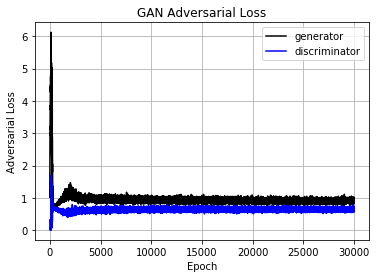

In [109]:
plot_loss(gen_losses, disc_losses, 'Adversarial Loss')

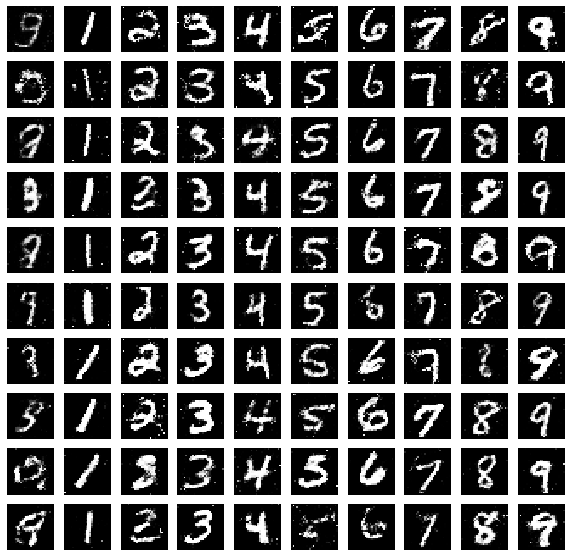

In [112]:
r, c = 10, 10
labels = np.eye(n_classes)
fig, axs = plt.subplots(r, c, figsize=(10,10))
ix = 0
for i in range(r):
    for j in range(c):
        noise = np.random.normal(0, 1, (1, latent_dim))
        label = labels[j].reshape(1,-1)

        gen_img = generator.predict([noise, label])
        gen_img = 0.5 * gen_img + 0.5

        axs[i,j].imshow(gen_img.reshape(28,28), cmap='gray')
        axs[i,j].axis('off')
        ix += 1